In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy

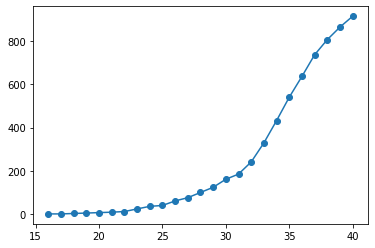

In [2]:
raw_data = [1,1,1,1,1,1,3,5,7,9,12,24,36,40,61,76,100,124,161,185,241,329,432,540,636,736,806,864,914]
raw_time = [11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]

clip = None

data = raw_data[4:clip]
time = raw_time[4:clip]

def system_2(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y),
        p[1]*y[0]*y[2]/sum(y) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2]
    ]
plt.plot(time, data, 'o-')

In [3]:
# data_pd = np.array(list(zip(*data)))
data_pd = np.array([[i] for i in data])
p0 = [7./8, 3, 7./10]
config = {
    "grid_size": 100,
    "basis_number": 12,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [time[0], time[-1]],
    "knot_function": None,
    "model": system_2,
    "dataset": {"y": data_pd, "t": np.array(time)},
    "observation_vector": [-1],
    "weightings":[
        [1]*4,
        [1]*len(time)
    ],
    "regularisation_value": copy(p0),
}

In [4]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [5]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [6]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)

In [7]:
c0 = [np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*4) + [0]*len(config['regularisation_value'])
alpha = 1

In [8]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

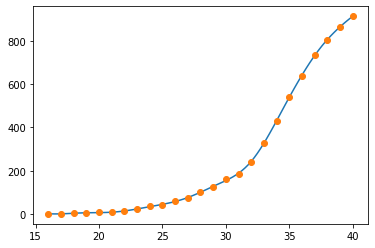

In [9]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(time, data, 'o')

In [10]:
prange = np.logspace(-6, -2, num=30)
solutions = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
    }
    solutions.append(solver(**solve_opts))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  36  1.1216993e+03 0.00e+00 2.73e+00  -8.6 1.12e+03 -10.5 1.00e+00 1.00e+00f  1
  37  1.1216784e+03 0.00e+00 7.95e+00  -8.6 3.18e+03 -11.0 1.00e+00 5.00e-01f  2
  38  1.1216475e+03 0.00e+00 2.93e+00  -8.6 1.17e+03 -10.6 1.00e+00 1.00e+00f  1
  39  1.1216278e+03 0.00e+00 6.64e+00  -8.6 2.20e+03 -11.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1216031e+03 0.00e+00 3.56e+00  -8.6 1.62e+03 -10.6 1.00e+00 1.00e+00f  1
  41  1.1215991e+03 0.00e+00 3.82e+00  -8.6 2.88e+04 -11.1 4.16e-01 1.01e-01f  4
  42  1.1215850e+03 0.00e+00 5.16e+00  -8.6 2.96e+03 -11.6 4.20e-01 5.00e-01f  2
  43  1.1215728e+03 0.00e+00 1.46e+00  -8.6 2.62e+03 -11.1 1.00e+00 1.00e+00f  1
  44  1.1215652e+03 0.00e+00 2.16e+00  -8.6 1.68e+03 -10.7 6.61e-01 1.00e+00f  1
  45  1.1215555e+03 0.00e+00 5.39e-01  -8.6 9.39e+03 -11.2 8.83e-01 1.00e+00f  1
  46  1.1215529e+03 0.00e+00 2.41e+00  -8.6 5.66e+03 -10.8 1.00e+00 5.00e-01f  2
  47  1.1215481e+03 0.00e+00

   8  1.1227311e+03 0.00e+00 9.71e+00  -1.0 3.46e+04    -  3.82e-02 1.49e-01f  1
   9  1.1309448e+03 0.00e+00 7.09e+01  -1.0 6.18e+04    -  1.47e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1230291e+03 0.00e+00 6.02e-03  -1.0 2.47e+00  -4.5 1.00e+00 1.00e+00f  1
  11  1.1218237e+03 0.00e+00 6.84e-01  -1.7 6.59e+03    -  8.46e-01 1.00e+00f  1
  12  1.1222557e+03 0.00e+00 4.38e+01  -1.7 2.93e+04    -  7.50e-01 8.08e-01f  1
  13  1.1217636e+03 0.00e+00 4.90e+00  -1.7 6.51e-01  -5.0 6.48e-01 1.00e+00f  1
  14  1.1219148e+03 0.00e+00 2.81e+01  -1.7 4.57e+04    -  8.45e-01 5.00e-01f  2
  15  1.1217940e+03 0.00e+00 8.10e-04  -1.7 2.35e+00  -5.4 1.00e+00 1.00e+00f  1
  16  1.1217528e+03 0.00e+00 1.35e+01  -3.8 1.27e+04    -  7.25e-01 5.00e-01f  2
  17  1.1217364e+03 0.00e+00 5.95e-05  -3.8 5.35e+00  -5.9 1.00e+00 1.00e+00f  1
  18  1.1217358e+03 0.00e+00 2.67e-05  -3.8 1.34e+01  -6.4 1.00e+00 1.00e+00f  1
  19  1.1217350e+03 0.00e+00

  17  1.1216764e+03 0.00e+00 1.09e-04  -3.8 3.42e+00  -5.9 1.00e+00 1.00e+00f  1
  18  1.1216761e+03 0.00e+00 1.74e-05  -5.7 8.16e+00  -6.4 1.00e+00 1.00e+00f  1
  19  1.1216756e+03 0.00e+00 4.43e-05  -5.7 1.64e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1216750e+03 0.00e+00 3.20e-04  -5.7 3.00e+01  -7.3 1.00e+00 1.00e+00f  1
  21  1.1216738e+03 0.00e+00 2.33e-03  -5.7 5.63e+01  -7.8 1.00e+00 1.00e+00f  1
  22  1.1216716e+03 0.00e+00 2.04e-02  -5.7 1.07e+02  -8.3 1.00e+00 1.00e+00f  1
  23  1.1216660e+03 0.00e+00 1.93e-01  -5.7 2.09e+02  -8.8 1.00e+00 1.00e+00f  1
  24  1.1216499e+03 0.00e+00 1.97e+00  -5.7 6.91e+02  -9.2 1.00e+00 1.00e+00f  1
  25  1.1216300e+03 0.00e+00 1.03e+01  -5.7 1.50e+03  -9.7 1.00e+00 1.00e+00f  1
  26  1.1216115e+03 0.00e+00 5.86e+00  -5.7 1.31e+03 -10.2 1.00e+00 4.61e-01f  1
  27  1.1215920e+03 0.00e+00 2.40e+00  -5.7 3.78e+03 -10.7 1.00e+00 1.00e+00f  1
  28  1.1215868e+03 0.00e+00

  14  1.1217771e+03 0.00e+00 1.46e+01  -2.5 1.32e+04    -  4.42e-01 4.84e-01f  1
  15  1.1216273e+03 0.00e+00 3.20e+00  -2.5 5.41e-01  -4.5 8.23e-02 1.00e+00f  1
  16  1.1216702e+03 0.00e+00 1.50e+01  -2.5 1.19e+04    -  7.13e-01 5.00e-01f  2
  17  1.1215844e+03 0.00e+00 2.68e-04  -2.5 9.39e-01  -5.0 1.00e+00 1.00e+00f  1
  18  1.1215841e+03 0.00e+00 1.06e-05  -3.8 2.86e+00  -5.4 1.00e+00 1.00e+00f  1
  19  1.1215834e+03 0.00e+00 1.88e-05  -5.7 7.96e+00  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1215820e+03 0.00e+00 2.12e-04  -5.7 1.94e+01  -6.4 1.00e+00 1.00e+00f  1
  21  1.1215795e+03 0.00e+00 2.08e-03  -5.7 3.55e+01  -6.9 1.00e+00 1.00e+00f  1
  22  1.1215752e+03 0.00e+00 1.62e-02  -5.7 5.56e+01  -7.3 1.00e+00 1.00e+00f  1
  23  1.1215664e+03 0.00e+00 1.15e-01  -5.7 1.02e+02  -7.8 1.00e+00 1.00e+00f  1
  24  1.1215517e+03 0.00e+00 5.81e-01  -5.7 1.94e+02  -8.3 1.00e+00 1.00e+00f  1
  25  1.1215437e+03 0.00e+00

  29  1.1215433e+03 0.00e+00 2.34e-01  -5.7 3.79e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1215415e+03 0.00e+00 4.51e-01  -5.7 5.18e+03  -9.8 4.34e-01 3.84e-01f  1
  31  1.1215402e+03 0.00e+00 4.87e-02  -5.7 1.95e+03 -10.3 1.00e+00 1.00e+00f  1
  32  1.1215392e+03 0.00e+00 2.37e-01  -5.7 1.06e+03 -10.8 1.00e+00 1.00e+00f  1
  33  1.1215386e+03 0.00e+00 1.40e+00  -5.7 2.29e+03 -11.3 1.00e+00 5.00e-01f  2
  34  1.1215372e+03 0.00e+00 8.26e-02  -5.7 7.97e+02 -10.8 1.00e+00 1.00e+00f  1
  35  1.1215363e+03 0.00e+00 8.68e-01  -5.7 3.09e+03 -11.3 1.00e+00 5.00e-01f  2
  36  1.1215350e+03 0.00e+00 8.95e-02  -5.7 1.59e+03 -10.9 1.00e+00 1.00e+00f  1
  37  1.1215339e+03 0.00e+00 1.14e+00  -5.7 2.32e+04 -11.4 3.68e-01 5.98e-02f  3
  38  1.1215327e+03 0.00e+00 5.13e-02  -5.7 2.28e+02 -10.0 1.00e+00 1.00e+00f  1
  39  1.1215313e+03 0.00e+00 4.41e-01  -5.7 9.00e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  36  1.1216520e+03 0.00e+00 4.74e+00  -5.7 4.14e+02  -9.9 1.00e+00 2.50e-01f  1
  37  1.1216416e+03 0.00e+00 8.95e+00  -5.7 9.47e+02 -10.4 1.00e+00 1.00e+00f  1
  38  1.1216368e+03 0.00e+00 2.85e+00  -5.7 2.05e+03 -10.8 6.25e-01 1.00e+00f  1
  39  1.1216327e+03 0.00e+00 2.00e+00  -5.7 5.80e+03 -10.4 8.95e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1216245e+03 0.00e+00 1.02e+01  -5.7 1.42e+04 -10.0 4.67e-01 1.25e-01f  4
  41  1.1216163e+03 0.00e+00 1.76e+00  -5.7 3.33e+03 -10.5 1.00e+00 1.00e+00f  1
  42  1.1216062e+03 0.00e+00 4.02e-01  -5.7 8.40e+03 -10.9 8.81e-01 1.00e+00f  1
  43  1.1215987e+03 0.00e+00 6.07e+00  -5.7 1.32e+04 -10.5 1.00e+00 1.25e-01f  4
  44  1.1215896e+03 0.00e+00 7.02e+00  -5.7 1.59e+03 -11.0 1.00e+00 1.00e+00f  1
  45  1.1215818e+03 0.00e+00 4.09e+00  -5.7 4.73e+03 -10.6 1.00e+00 1.00e+00f  1
  46  1.1215742e+03 0.00e+00 2.10e+00  -5.7 1.84e+02  -9.2 1.00e+00 1.00e+00f  1
  47  1.1215696e+03 0.00e+00

 138  1.1215420e+03 0.00e+00 3.31e-02  -5.7 1.91e+02 -10.7 1.00e+00 1.00e+00f  1
 139  1.1215419e+03 0.00e+00 1.05e-01  -5.7 4.63e+02 -11.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.1215416e+03 0.00e+00 4.06e-01  -5.7 1.67e+03 -11.6 1.00e+00 1.00e+00f  1
 141  1.1215413e+03 0.00e+00 2.48e-01  -5.7 2.05e+04 -12.1 1.00e+00 1.25e-01f  4
 142  1.1215411e+03 0.00e+00 7.47e-02  -5.7 2.84e+02 -10.8 1.00e+00 1.00e+00f  1
 143  1.1215409e+03 0.00e+00 2.92e-01  -5.7 8.73e+02 -11.3 1.00e+00 1.00e+00f  1
 144  1.1215402e+03 0.00e+00 7.48e-01  -5.7 4.36e+03 -11.7 1.00e+00 1.00e+00f  1
 145  1.1215398e+03 0.00e+00 9.07e-02  -5.7 2.79e+02 -10.4 1.00e+00 1.00e+00f  1
 146  1.1215395e+03 0.00e+00 1.56e-01  -5.7 5.66e+02 -10.9 1.00e+00 1.00e+00f  1
 147  1.1215387e+03 0.00e+00 5.10e-01  -5.7 2.26e+03 -11.4 1.00e+00 1.00e+00f  1
 148  1.1215382e+03 0.00e+00 5.63e-02  -5.7 9.71e+02 -10.9 1.00e+00 1.00e+00f  1
 149  1.1215372e+03 0.00e+00

  31  1.1217495e+03 0.00e+00 1.01e+01  -8.6 1.00e+03  -9.4 1.00e+00 1.00e+00f  1
  32  1.1217306e+03 0.00e+00 8.51e+00  -8.6 9.64e+02  -9.8 1.00e+00 1.00e+00f  1
  33  1.1217121e+03 0.00e+00 1.53e+01  -8.6 3.06e+03 -10.3 1.00e+00 1.00e+00f  1
  34  1.1216876e+03 0.00e+00 6.63e+00  -8.6 1.42e+03  -9.9 1.00e+00 1.00e+00f  1
  35  1.1216825e+03 0.00e+00 6.93e+00  -8.6 6.90e+04 -10.4 3.24e-01 1.90e-02f  1
  36  1.1216738e+03 0.00e+00 1.07e+01  -8.6 9.23e+03 -10.8 7.48e-01 2.50e-01f  3
  37  1.1216640e+03 0.00e+00 8.32e+00  -8.6 1.80e+05 -11.3 7.54e-02 3.10e-02f  4
  38  1.1216627e+03 0.00e+00 7.95e+00  -8.6 4.94e+02  -9.1 1.00e+00 4.48e-02f  1
  39  1.1216435e+03 0.00e+00 7.32e+00  -8.6 5.39e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1216328e+03 0.00e+00 8.54e+00  -8.6 9.92e+02 -10.0 1.00e+00 1.00e+00f  1
  41  1.1216227e+03 0.00e+00 3.90e+00  -8.6 6.37e+02 -10.5 1.00e+00 1.00e+00f  1
  42  1.1216196e+03 0.00e+00

 136  1.1207800e+03 0.00e+00 7.20e-06  -8.6 1.84e+01  -8.8 1.00e+00 1.00e+00h  1
 137  1.1207799e+03 0.00e+00 1.10e-05  -8.6 2.22e+01  -9.3 1.00e+00 1.00e+00h  1
 138  1.1207799e+03 0.00e+00 3.18e-06  -8.6 1.16e+01  -9.8 1.00e+00 1.00e+00h  1
 139  1.1207799e+03 0.00e+00 1.24e-07  -8.6 2.23e+00 -10.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.1207799e+03 0.00e+00 5.58e-10  -8.6 1.80e-01 -10.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 140

                                   (scaled)                 (unscaled)
Objective...............:   1.1207799425047299e+03    1.1207799425047299e+03
Dual infeasibility......:   5.5767085001168316e-10    5.5767085001168316e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective func

   1  1.1207954e+03 0.00e+00 1.48e-02  -1.0 3.97e-01    -  9.85e-01 1.00e+00f  1
   2  1.1208279e+03 0.00e+00 5.05e-02  -1.0 4.31e+01    -  3.96e-01 1.00e+00f  1
   3  1.1208196e+03 0.00e+00 2.42e-02  -1.0 3.55e+01    -  4.64e-01 1.00e+00f  1
   4  1.1208401e+03 0.00e+00 1.37e-02  -1.0 7.36e+01    -  7.01e-01 1.00e+00f  1
   5  1.1209554e+03 0.00e+00 2.44e-01  -1.0 3.04e+02    -  5.10e-01 1.00e+00f  1
   6  1.1212964e+03 0.00e+00 8.73e-01  -1.0 6.46e+02    -  6.83e-01 1.00e+00f  1
   7  1.1220961e+03 0.00e+00 4.62e+00  -1.0 6.57e+02    -  4.89e-01 4.36e-01f  1
   8  1.1228962e+03 0.00e+00 9.12e+00  -1.0 1.90e+03    -  3.34e-02 3.85e-01f  1
   9  1.1221329e+03 0.00e+00 6.66e+00  -1.0 1.28e+04    -  1.93e-01 9.21e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1226865e+03 0.00e+00 1.86e+01  -1.0 2.06e+04    -  9.76e-02 8.87e-02f  1
  11  1.1220957e+03 0.00e+00 4.21e+00  -1.0 1.16e+00  -4.0 4.13e-01 1.00e+00f  1
  12  1.1225177e+03 0.00e+00

       nlp_g      0.00111      0.00108       106
    nlp_grad     0.000121      0.00012         1
  nlp_grad_f       0.0101       0.0101        89
  nlp_hess_l        0.486        0.485        87
   nlp_jac_g      0.00357      0.00358        89
      solver        0.702        0.698         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints............

  11  1.1487154e+03 0.00e+00 1.04e+03  -1.0 3.63e+04    -  7.51e-02 1.00e+00f  1
  12  1.1223787e+03 0.00e+00 1.45e-01  -1.0 2.22e+00  -4.5 1.00e+00 1.00e+00f  1
  13  1.1220478e+03 0.00e+00 6.19e+00  -2.5 2.48e+03    -  4.47e-01 1.00e+00f  1
  14  1.1220192e+03 0.00e+00 2.75e+00  -2.5 1.02e+03    -  9.57e-01 1.00e+00f  1
  15  1.1220185e+03 0.00e+00 1.71e-05  -2.5 2.45e-01  -5.0 1.00e+00 1.00e+00f  1
  16  1.1220100e+03 0.00e+00 4.94e+00  -3.8 9.49e+03    -  3.48e-01 1.12e-01f  4
  17  1.1220092e+03 0.00e+00 5.63e-06  -3.8 1.00e+00  -5.4 1.00e+00 1.00e+00f  1
  18  1.1220092e+03 0.00e+00 5.56e-06  -5.7 1.67e+00  -5.9 1.00e+00 1.00e+00f  1
  19  1.1220091e+03 0.00e+00 1.27e-05  -8.6 2.34e+00  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1220090e+03 0.00e+00 3.22e-05  -8.6 3.87e+00  -6.9 1.00e+00 1.00e+00f  1
  21  1.1220089e+03 0.00e+00 7.46e-05  -8.6 6.36e+00  -7.3 1.00e+00 1.00e+00f  1
  22  1.1220087e+03 0.00e+00

 115  1.1215463e+03 0.00e+00 1.57e+00  -8.6 3.18e+03 -10.6 1.00e+00 5.00e-01f  2
 116  1.1215456e+03 0.00e+00 1.92e-03  -8.6 7.56e+01  -9.3 1.00e+00 1.00e+00f  1
 117  1.1215453e+03 0.00e+00 1.58e-01  -8.6 2.08e+02  -9.8 1.00e+00 1.00e+00f  1
 118  1.1215440e+03 0.00e+00 6.70e-01  -8.6 7.76e+02 -10.3 1.00e+00 1.00e+00f  1
 119  1.1215432e+03 0.00e+00 2.47e+00  -8.6 2.77e+04 -10.7 4.74e-01 6.72e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1215402e+03 0.00e+00 6.17e-01  -8.6 3.02e+02  -9.4 1.00e+00 1.00e+00f  1
 121  1.1215384e+03 0.00e+00 3.13e-01  -8.6 5.62e+02  -9.9 1.00e+00 1.00e+00f  1
 122  1.1215294e+03 0.00e+00 2.94e+00  -8.6 3.27e+03 -10.4 1.00e+00 1.00e+00f  1
 123  1.1215210e+03 0.00e+00 2.38e-01  -8.6 1.18e+02  -9.0 1.00e+00 1.00e+00f  1
 124  1.1215147e+03 0.00e+00 2.38e+00  -8.6 1.18e+03  -9.5 1.00e+00 1.00e+00f  1
 125  1.1215015e+03 0.00e+00 7.28e-02  -8.6 6.02e+01  -8.2 1.00e+00 1.00e+00f  1
 126  1.1214936e+03 0.00e+00

  48  1.1210921e+03 0.00e+00 1.09e+00  -5.7 8.60e+03  -7.2 3.48e-02 1.93e-02f  2
  49  1.1210752e+03 0.00e+00 7.24e-01  -5.7 8.71e+03  -7.6 3.54e-02 2.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1209021e+03 0.00e+00 4.60e-01  -5.7 3.03e+02  -6.3 1.00e+00 4.38e-01f  1
  51  1.1208257e+03 0.00e+00 2.01e-01  -5.7 6.71e+01  -6.8 9.79e-01 1.00e+00f  1
  52  1.1207959e+03 0.00e+00 9.44e-02  -5.7 2.42e+04    -  1.00e+00 6.17e-01f  1
  53  1.1207922e+03 0.00e+00 7.45e-02  -5.7 3.90e+03    -  6.23e-02 1.00e+00f  1
  54  1.1207878e+03 0.00e+00 5.04e-03  -5.7 1.11e+01  -7.3 1.00e+00 1.00e+00f  1
  55  1.1207873e+03 0.00e+00 7.22e-03  -5.7 2.14e+05    -  1.00e+00 1.70e-01f  2
  56  1.1207863e+03 0.00e+00 9.37e-03  -5.7 2.33e+04    -  1.00e+00 1.00e+00f  1
  57  1.1207861e+03 0.00e+00 1.84e-02  -5.7 4.00e+04    -  1.00e+00 1.67e-01f  2
  58  1.1207853e+03 0.00e+00 7.89e-03  -5.7 2.35e+03    -  1.00e+00 1.00e+00f  1
  59  1.1207850e+03 0.00e+00

  12  1.1209582e+03 0.00e+00 1.99e-03  -3.8 1.28e+00  -4.5 1.00e+00 1.00e+00f  1
  13  1.1209132e+03 0.00e+00 4.25e-01  -3.8 1.56e+03    -  6.76e-01 3.34e-01f  1
  14  1.1208227e+03 0.00e+00 4.52e-02  -3.8 3.81e+01  -5.0 1.00e+00 1.00e+00f  1
  15  1.1208099e+03 0.00e+00 1.26e-02  -3.8 8.08e+00  -5.4 1.00e+00 1.00e+00f  1
  16  1.1207988e+03 0.00e+00 6.80e-02  -3.8 8.07e+02    -  7.14e-01 5.00e-01f  2
  17  1.1207915e+03 0.00e+00 5.06e-03  -3.8 1.62e+02    -  1.00e+00 1.00e+00f  1
  18  1.1207932e+03 0.00e+00 2.30e-02  -3.8 1.61e+03    -  5.82e-01 2.50e-01f  3
  19  1.1207962e+03 0.00e+00 4.29e-02  -3.8 9.03e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1207958e+03 0.00e+00 9.54e-03  -3.8 7.63e+02    -  1.00e+00 1.00e+00f  1
  21  1.1208045e+03 0.00e+00 1.13e-01  -3.8 3.73e+03    -  1.00e+00 1.00e+00f  1
  22  1.1208003e+03 0.00e+00 8.47e-03  -3.8 4.29e+03    -  1.00e+00 1.00e+00f  1
  23  1.1207988e+03 0.00e+00

  54  1.1208213e+03 0.00e+00 3.97e-02  -5.7 2.03e+01  -5.9 1.00e+00 1.00e+00f  1
  55  1.1208138e+03 0.00e+00 1.55e-02  -5.7 1.58e+01  -6.4 1.00e+00 1.00e+00f  1
  56  1.1208105e+03 0.00e+00 1.93e-03  -5.7 2.45e+01  -6.9 1.00e+00 1.00e+00f  1
  57  1.1208067e+03 0.00e+00 2.70e-04  -5.7 4.15e+01  -7.4 1.00e+00 1.00e+00f  1
  58  1.1208022e+03 0.00e+00 2.12e-03  -5.7 8.44e+01  -7.8 1.00e+00 1.00e+00f  1
  59  1.1207999e+03 0.00e+00 2.17e-03  -5.7 8.45e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1207996e+03 0.00e+00 4.31e-04  -5.7 3.51e+01  -8.8 1.00e+00 1.00e+00f  1
  61  1.1207996e+03 0.00e+00 1.10e-05  -5.7 5.20e+00  -9.3 1.00e+00 1.00e+00h  1
  62  1.1207996e+03 0.00e+00 6.89e-06  -8.6 3.38e+00  -9.7 1.00e+00 1.00e+00h  1
  63  1.1207996e+03 0.00e+00 1.39e-07  -8.6 2.13e+00 -10.2 1.00e+00 1.00e+00h  1
  64  1.1207996e+03 0.00e+00 4.37e-10  -8.6 5.52e+00 -10.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 6

  57  1.1219625e+03 0.00e+00 3.79e+00  -2.5 2.07e+02  -9.3 1.00e+00 1.00e+00f  1
  58  1.1219623e+03 0.00e+00 1.78e-01  -2.5 6.03e+02  -9.8 1.00e+00 1.00e+00f  1
  59  1.1219627e+03 0.00e+00 6.87e+00  -2.5 1.69e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1219769e+03 0.00e+00 1.12e+02  -2.5 5.41e+03 -10.8 1.00e+00 1.00e+00f  1
  61  1.1219548e+03 0.00e+00 1.65e-01  -2.5 2.57e+01  -8.5 1.00e+00 1.00e+00f  1
  62  1.1219513e+03 0.00e+00 3.93e+01  -2.5 1.22e+05    -  2.77e-01 1.09e-02f  6
  63  1.1219486e+03 0.00e+00 6.63e-02  -2.5 8.31e+01  -9.0 1.00e+00 1.00e+00f  1
  64  1.1219489e+03 0.00e+00 3.47e-01  -2.5 2.27e+02  -9.5 1.00e+00 1.00e+00f  1
  65  1.1219441e+03 0.00e+00 2.80e+01  -2.5 7.25e+04    -  1.00e+00 6.25e-02f  5
  66  1.1219394e+03 0.00e+00 1.46e+00  -2.5 6.52e+02 -10.0 1.00e+00 1.00e+00f  1
  67  1.1219426e+03 0.00e+00 2.48e+01  -2.5 1.83e+03 -10.4 1.00e+00 1.00e+00f  1
  68  1.1219412e+03 0.00e+00

 156  1.1216846e+03 0.00e+00 7.67e+01  -3.8 7.27e+02  -9.5 1.00e+00 5.00e-01f  2
 157  1.1216779e+03 0.00e+00 8.67e+00  -3.8 4.46e+02  -9.9 1.00e+00 1.00e+00f  1
 158  1.1216749e+03 0.00e+00 6.48e+01  -3.8 1.20e+03 -10.4 1.00e+00 2.50e-01f  3
 159  1.1216689e+03 0.00e+00 1.15e+01  -3.8 4.73e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.1216657e+03 0.00e+00 4.28e+01  -3.8 8.80e+02 -10.5 1.00e+00 2.50e-01f  3
 161  1.1216608e+03 0.00e+00 2.63e+01  -3.8 3.79e+02 -10.0 1.00e+00 1.00e+00f  1
 162  1.1216569e+03 0.00e+00 5.20e+01  -3.8 1.44e+03 -10.5 1.00e+00 1.00e+00f  1
 163  1.1216503e+03 0.00e+00 6.81e+01  -3.8 1.61e+03 -11.0 1.00e+00 5.00e-01f  2
 164  1.1216473e+03 0.00e+00 4.85e+01  -3.8 1.04e+05 -11.5 7.95e-01 3.12e-02f  6
 165  1.1216414e+03 0.00e+00 5.87e+01  -3.8 1.27e+03 -11.0 1.00e+00 1.00e+00f  1
 166  1.1216375e+03 0.00e+00 7.86e+00  -3.8 1.33e+02  -9.7 1.00e+00 1.00e+00f  1
 167  1.1216363e+03 0.00e+00

 252  1.1216067e+03 0.00e+00 3.33e-02  -5.7 2.85e+01 -10.1 1.00e+00 1.00e+00h  1
 253  1.1216067e+03 0.00e+00 3.06e-01  -5.7 8.04e+01 -10.6 1.00e+00 1.00e+00h  1
 254  1.1216065e+03 0.00e+00 6.61e+00  -5.7 5.81e+05    -  2.75e-01 7.99e-03f  6
 255  1.1216065e+03 0.00e+00 1.14e-01  -5.7 5.16e+01 -10.2 1.00e+00 1.00e+00f  1
 256  1.1216063e+03 0.00e+00 6.73e+00  -5.7 8.08e+05    -  2.02e-01 4.43e-03f  6
 257  1.1216063e+03 0.00e+00 2.59e-01  -5.7 1.81e+01  -9.7 1.00e+00 1.00e+00f  1
 258  1.1216063e+03 0.00e+00 9.58e-02  -5.7 4.55e+01 -10.2 1.00e+00 1.00e+00h  1
 259  1.1216061e+03 0.00e+00 7.07e+00  -5.7 4.56e+06    -  3.54e-02 7.30e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  1.1216061e+03 0.00e+00 4.15e-02  -5.7 1.56e+01  -9.8 1.00e+00 1.00e+00f  1
 261  1.1216060e+03 0.00e+00 1.33e-01  -5.7 5.30e+01 -10.3 1.00e+00 1.00e+00h  1
 262  1.1216059e+03 0.00e+00 5.21e+00  -5.7 5.09e+05    -  3.04e-01 7.08e-03f  6
 263  1.1216058e+03 0.00e+00

 358  1.1215981e+03 0.00e+00 3.23e+00  -5.7 4.30e+02 -11.1 1.00e+00 5.00e-01f  2
 359  1.1215979e+03 0.00e+00 1.43e+00  -5.7 8.49e+02 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.1215979e+03 0.00e+00 2.20e+00  -5.7 3.39e+02 -11.2 1.00e+00 1.00e+00f  1
 361  1.1215978e+03 0.00e+00 1.20e+00  -5.7 3.57e+02 -10.8 1.00e+00 5.00e-01f  2
 362  1.1215978e+03 0.00e+00 6.59e-02  -5.7 2.99e+02 -11.2 1.00e+00 1.00e+00f  1
 363  1.1215977e+03 0.00e+00 1.07e+00  -5.7 9.78e+02 -11.7 1.00e+00 5.00e-01f  2
 364  1.1215976e+03 0.00e+00 3.22e+00  -5.7 8.86e+03 -12.2 1.00e+00 1.25e-01f  4
 365  1.1215975e+03 0.00e+00 1.20e-01  -5.7 3.59e+01 -10.0 1.00e+00 1.00e+00f  1
 366  1.1215975e+03 0.00e+00 2.67e-01  -5.7 7.57e+01 -10.4 1.00e+00 1.00e+00h  1
 367  1.1215969e+03 0.00e+00 1.81e+01  -5.7 3.20e+05    -  2.02e-01 2.49e-02f  4
 368  1.1215963e+03 0.00e+00 4.93e-04  -5.7 1.33e+00  -8.2 1.00e+00 1.00e+00f  1
 369  1.1215963e+03 0.00e+00

 462  1.1215741e+03 0.00e+00 1.75e+00  -5.7 2.46e+03 -11.0 1.00e+00 5.00e-01f  2
 463  1.1215736e+03 0.00e+00 4.38e-01  -5.7 9.68e+01  -8.8 1.00e+00 1.00e+00f  1
 464  1.1215734e+03 0.00e+00 1.40e-02  -5.7 3.96e+01  -9.3 1.00e+00 1.00e+00f  1
 465  1.1215731e+03 0.00e+00 1.84e-01  -5.7 1.39e+02  -9.8 1.00e+00 1.00e+00f  1
 466  1.1215723e+03 0.00e+00 2.18e-01  -5.7 4.02e+02 -10.2 1.00e+00 1.00e+00f  1
 467  1.1215716e+03 0.00e+00 5.33e-01  -5.7 1.74e+03 -10.7 1.00e+00 2.50e-01f  3
 468  1.1215703e+03 0.00e+00 3.77e-01  -5.7 6.10e+02 -10.3 1.00e+00 1.00e+00f  1
 469  1.1215700e+03 0.00e+00 3.48e-01  -5.7 8.66e+01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.1215697e+03 0.00e+00 2.11e-02  -5.7 7.70e+01  -9.4 1.00e+00 1.00e+00f  1
 471  1.1215691e+03 0.00e+00 1.43e-01  -5.7 2.57e+02  -9.9 1.00e+00 1.00e+00f  1
 472  1.1215668e+03 0.00e+00 1.27e+00  -5.7 8.55e+02 -10.4 1.00e+00 1.00e+00f  1
 473  1.1215665e+03 0.00e+00

  18  1.1223079e+03 0.00e+00 5.70e+01  -1.7 5.63e+01  -6.4 1.11e-01 1.00e+00f  1
  19  1.1225888e+03 0.00e+00 6.41e+01  -1.7 1.76e+04    -  5.85e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1221636e+03 0.00e+00 1.01e+00  -1.7 5.93e+01  -6.9 1.00e+00 1.00e+00f  1
  21  1.1234708e+03 0.00e+00 5.56e+02  -1.7 9.82e+03    -  9.63e-01 9.63e-01f  1
  22  1.1221492e+03 0.00e+00 4.30e+00  -1.7 5.83e+01  -7.3 1.00e+00 1.00e+00f  1
  23  1.1226632e+03 0.00e+00 4.02e+02  -1.7 1.90e+04    -  8.98e-01 5.00e-01f  2
  24  1.1221391e+03 0.00e+00 1.01e+01  -1.7 1.80e+02  -7.8 1.00e+00 1.00e+00f  1
  25  1.1221970e+03 0.00e+00 1.52e+02  -1.7 3.82e+04    -  6.03e-01 1.25e-01f  4
  26  1.1221176e+03 0.00e+00 1.54e+01  -1.7 3.50e+02  -8.3 1.00e+00 1.00e+00f  1
  27  1.1221486e+03 0.00e+00 1.18e+02  -1.7 7.96e+04    -  2.60e-01 4.15e-02f  4
  28  1.1222895e+03 0.00e+00 2.76e+02  -1.7 1.56e+03  -8.8 1.00e+00 1.00e+00f  1
  29  1.1221094e+03 0.00e+00

 121  1.1220458e+03 0.00e+00 4.14e+01  -2.5 2.04e+04    -  1.00e+00 6.25e-02f  5
 122  1.1220452e+03 0.00e+00 4.08e+00  -2.5 4.00e+02 -11.0 1.00e+00 1.00e+00f  1
 123  1.1220446e+03 0.00e+00 7.68e+00  -2.5 3.93e+05    -  1.23e-01 1.91e-03f  7
 124  1.1220433e+03 0.00e+00 2.04e+01  -2.5 4.24e+03 -11.5 1.00e+00 1.25e-01f  4
 125  1.1220413e+03 0.00e+00 1.93e+01  -2.5 2.88e+03 -11.9 1.00e+00 1.00e+00f  1
 126  1.1220409e+03 0.00e+00 2.39e+00  -2.5 1.61e+02 -10.6 1.00e+00 1.00e+00f  1
 127  1.1220394e+03 0.00e+00 6.01e+01  -2.5 1.66e+04    -  1.00e+00 1.25e-01f  4
 128  1.1220389e+03 0.00e+00 4.03e-01  -2.5 5.83e+01 -10.2 1.00e+00 1.00e+00f  1
 129  1.1220378e+03 0.00e+00 7.23e+01  -2.5 3.62e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1220371e+03 0.00e+00 1.23e+00  -2.5 1.32e+02 -10.7 1.00e+00 1.00e+00f  1
 131  1.1220360e+03 0.00e+00 5.89e+01  -2.5 2.11e+04    -  1.00e+00 6.25e-02f  5
 132  1.1220354e+03 0.00e+00

 222  1.1219723e+03 0.00e+00 2.68e-01  -2.5 4.71e+01 -10.5 1.00e+00 1.00e+00f  1
 223  1.1219713e+03 0.00e+00 1.62e+01  -2.5 1.38e+04    -  1.00e+00 6.25e-02f  5
 224  1.1219710e+03 0.00e+00 7.56e-01  -2.5 1.03e+02 -11.0 1.00e+00 1.00e+00f  1
 225  1.1219701e+03 0.00e+00 1.36e+01  -2.5 7.04e+03    -  1.00e+00 1.25e-01f  4
 226  1.1219699e+03 0.00e+00 3.09e-01  -2.5 5.11e+01 -10.5 1.00e+00 1.00e+00f  1
 227  1.1219691e+03 0.00e+00 1.22e+01  -2.5 1.21e+04    -  1.00e+00 6.25e-02f  5
 228  1.1219688e+03 0.00e+00 9.96e-01  -2.5 1.15e+02 -11.0 1.00e+00 1.00e+00f  1
 229  1.1219681e+03 0.00e+00 8.06e+00  -2.5 5.63e+03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.1219677e+03 0.00e+00 3.51e+00  -2.5 2.28e+02 -11.5 1.00e+00 1.00e+00h  1
 231  1.1219676e+03 0.00e+00 5.45e+00  -2.5 8.46e+05    -  7.37e-02 1.94e-04f  9
 232  1.1219669e+03 0.00e+00 5.86e+00  -2.5 2.53e+03    -  1.00e+00 2.50e-01f  3
 233  1.1219666e+03 0.00e+00

 319  1.1219074e+03 0.00e+00 6.05e+00  -2.5 4.21e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1219070e+03 0.00e+00 1.38e+00  -2.5 7.44e+01 -10.4 1.00e+00 1.00e+00f  1
 321  1.1219053e+03 0.00e+00 1.22e+01  -2.5 1.35e+04    -  1.00e+00 6.25e-02f  5
 322  1.1219048e+03 0.00e+00 2.44e+00  -2.5 1.55e+02 -10.9 1.00e+00 1.00e+00f  1
 323  1.1219032e+03 0.00e+00 8.50e+00  -2.5 7.13e+03    -  1.00e+00 1.25e-01f  4
 324  1.1219032e+03 0.00e+00 6.07e+00  -2.5 9.69e+02 -11.3 1.00e+00 5.00e-01f  2
 325  1.1219018e+03 0.00e+00 3.37e+01  -2.5 1.34e+03 -11.8 1.00e+00 2.50e-01f  3
 326  1.1219007e+03 0.00e+00 4.31e+00  -2.5 5.17e+02 -11.4 1.00e+00 1.00e+00f  1
 327  1.1218993e+03 0.00e+00 2.44e+01  -2.5 6.06e+02 -11.0 1.00e+00 5.00e-01f  2
 328  1.1218989e+03 0.00e+00 1.12e+00  -2.5 1.82e+02 -10.5 1.00e+00 1.00e+00f  1
 329  1.1218975e+03 0.00e+00 9.31e+00  -2.5 9.15e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr 

 421  1.1217614e+03 0.00e+00 1.61e+01  -2.5 1.54e+02 -10.7 1.00e+00 1.00e+00f  1
 422  1.1217596e+03 0.00e+00 2.75e+01  -2.5 1.97e+02 -11.2 1.00e+00 1.00e+00f  1
 423  1.1217586e+03 0.00e+00 8.29e+00  -2.5 1.09e+02 -10.8 1.00e+00 1.00e+00f  1
 424  1.1217571e+03 0.00e+00 2.49e+01  -2.5 3.49e+02 -11.2 1.00e+00 5.00e-01f  2
 425  1.1217559e+03 0.00e+00 9.64e+00  -2.5 1.17e+02 -10.8 1.00e+00 1.00e+00f  1
 426  1.1217546e+03 0.00e+00 2.04e+01  -2.5 3.02e+02 -11.3 1.00e+00 5.00e-01f  2
 427  1.1217534e+03 0.00e+00 1.32e+01  -2.5 1.37e+02 -10.9 1.00e+00 1.00e+00f  1
 428  1.1217515e+03 0.00e+00 3.47e+01  -2.5 2.26e+02 -11.3 1.00e+00 1.00e+00f  1
 429  1.1217506e+03 0.00e+00 4.91e+00  -2.5 8.20e+01 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.1217487e+03 0.00e+00 4.55e+01  -2.5 4.96e+02 -11.4 1.00e+00 5.00e-01f  2
 431  1.1217480e+03 0.00e+00 1.46e+00  -2.5 4.42e+01 -10.1 1.00e+00 1.00e+00f  1
 432  1.1217463e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1216419e+03 0.00e+00 1.53e+01  -3.8 9.06e+01 -10.1 1.00e+00 1.00e+00f  1
 521  1.1216416e+03 0.00e+00 1.56e+01  -3.8 1.95e+02 -10.6 1.00e+00 1.00e+00f  1
 522  1.1216413e+03 0.00e+00 1.11e+01  -3.8 6.06e+02 -11.1 1.00e+00 1.00e+00f  1
 523  1.1216411e+03 0.00e+00 2.81e+01  -3.8 5.30e+02 -11.5 1.00e+00 2.50e-01f  3
 524  1.1216409e+03 0.00e+00 2.11e+01  -3.8 3.23e+03 -12.0 1.00e+00 2.50e-01f  3
 525  1.1216406e+03 0.00e+00 8.66e+00  -3.8 3.85e+03 -12.5 1.00e+00 5.00e-01f  2
 526  1.1216405e+03 0.00e+00 1.33e+01  -3.8 3.85e+02 -10.3 1.00e+00 2.50e-01f  3
 527  1.1216403e+03 0.00e+00 1.30e+00  -3.8 1.30e+02 -10.7 1.00e+00 1.00e+00f  1
 528  1.1216402e+03 0.00e+00 7.16e+00  -3.8 4.14e+02 -11.2 1.00e+00 1.00e+00f  1
 529  1.1216400e+03 0.00e+00 1.40e+01  -3.8 1.02e+03 -11.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.1216399e+03 0.00e+00

 619  1.1216284e+03 0.00e+00 1.09e+00  -5.7 1.01e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  1.1216283e+03 0.00e+00 8.45e+00  -5.7 7.59e+02 -11.6 1.00e+00 5.00e-01f  2
 621  1.1216282e+03 0.00e+00 3.85e-02  -5.7 1.12e+01  -9.4 1.00e+00 1.00e+00f  1
 622  1.1216282e+03 0.00e+00 8.47e-02  -5.7 3.54e+01  -9.9 1.00e+00 1.00e+00h  1
 623  1.1216282e+03 0.00e+00 6.75e-01  -5.7 9.95e+01 -10.3 1.00e+00 1.00e+00h  1
 624  1.1216281e+03 0.00e+00 2.84e+00  -5.7 2.10e+02 -10.8 1.00e+00 1.00e+00f  1
 625  1.1216280e+03 0.00e+00 1.62e+00  -5.7 1.82e+02 -11.3 1.00e+00 1.00e+00f  1
 626  1.1216280e+03 0.00e+00 5.01e+00  -5.7 4.62e+02 -11.8 1.00e+00 1.00e+00f  1
 627  1.1216279e+03 0.00e+00 7.28e-03  -5.7 1.04e+01  -9.5 1.00e+00 1.00e+00f  1
 628  1.1216279e+03 0.00e+00 6.30e-02  -5.7 3.26e+01 -10.0 1.00e+00 1.00e+00h  1
 629  1.1216279e+03 0.00e+00 4.64e-01  -5.7 8.97e+01 -10.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 721  1.1216152e+03 0.00e+00 9.22e-04  -5.7 1.39e+00  -8.1 1.00e+00 1.00e+00f  1
 722  1.1216152e+03 0.00e+00 1.59e-03  -5.7 4.72e+00  -8.6 1.00e+00 1.00e+00h  1
 723  1.1216152e+03 0.00e+00 1.13e-02  -5.7 1.39e+01  -9.0 1.00e+00 1.00e+00h  1
 724  1.1216152e+03 0.00e+00 9.63e-02  -5.7 3.94e+01  -9.5 1.00e+00 1.00e+00h  1
 725  1.1216151e+03 0.00e+00 5.45e-01  -5.7 9.65e+01 -10.0 1.00e+00 1.00e+00f  1
 726  1.1216151e+03 0.00e+00 7.60e-01  -5.7 1.42e+02 -10.5 1.00e+00 1.00e+00f  1
 727  1.1216150e+03 0.00e+00 7.40e-01  -5.7 2.48e+02 -10.9 1.00e+00 1.00e+00f  1
 728  1.1216147e+03 0.00e+00 7.05e-01  -5.7 7.64e+02 -11.4 1.00e+00 1.00e+00f  1
 729  1.1216142e+03 0.00e+00 2.21e+00  -5.7 2.44e+03 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.1216141e+03 0.00e+00 1.15e+00  -5.7 1.33e+02  -9.7 1.00e+00 1.00e+00f  1
 731  1.1216140e+03 0.00e+00 1.61e-01  -5.7 6.38e+01 -10.1 1.00e+00 1.00e+00f  1
 732  1.1216130e+03 0.00e+00

 819  1.1215866e+03 0.00e+00 8.13e-01  -5.7 1.89e+02  -9.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.1215860e+03 0.00e+00 1.18e-01  -5.7 1.43e+02  -9.7 1.00e+00 1.00e+00f  1
 821  1.1215848e+03 0.00e+00 6.92e-01  -5.7 4.94e+02 -10.2 1.00e+00 1.00e+00f  1
 822  1.1215835e+03 0.00e+00 6.79e-01  -5.7 6.23e+03 -10.6 1.00e+00 1.25e-01f  4
 823  1.1215823e+03 0.00e+00 8.11e-02  -5.7 3.44e+01  -8.4 1.00e+00 1.00e+00f  1
 824  1.1215820e+03 0.00e+00 8.03e-02  -5.7 3.40e+01  -8.9 1.00e+00 1.00e+00f  1
 825  1.1215817e+03 0.00e+00 1.17e-01  -5.7 9.90e+01  -9.4 1.00e+00 1.00e+00f  1
 826  1.1215806e+03 0.00e+00 2.61e-01  -5.7 2.93e+02  -9.8 1.00e+00 1.00e+00f  1
 827  1.1215769e+03 0.00e+00 3.14e+00  -5.7 1.03e+03 -10.3 1.00e+00 1.00e+00f  1
 828  1.1215746e+03 0.00e+00 5.47e-01  -5.7 4.38e+02  -9.9 1.00e+00 1.00e+00f  1
 829  1.1215739e+03 0.00e+00 2.68e-01  -5.7 6.62e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  27  1.1217594e+03 0.00e+00 3.07e+00  -3.8 3.66e+02  -8.4 1.00e+00 5.00e-01f  2
  28  1.1217126e+03 0.00e+00 3.85e+00  -3.8 1.01e+02  -8.0 1.00e+00 1.00e+00f  1
  29  1.1216689e+03 0.00e+00 1.34e+00  -3.8 7.39e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1216395e+03 0.00e+00 3.80e+00  -3.8 1.54e+02  -8.0 1.00e+00 5.00e-01f  2
  31  1.1216043e+03 0.00e+00 1.04e+00  -3.8 5.26e+01  -7.6 1.00e+00 1.00e+00f  1
  32  1.1215860e+03 0.00e+00 2.23e+00  -3.8 9.51e+01  -8.1 1.00e+00 5.00e-01f  2
  33  1.1215711e+03 0.00e+00 7.15e-01  -3.8 2.94e+01  -7.6 1.00e+00 1.00e+00f  1
  34  1.1215626e+03 0.00e+00 7.96e-01  -3.8 4.62e+01  -8.1 1.00e+00 1.00e+00f  1
  35  1.1215574e+03 0.00e+00 3.03e-01  -3.8 9.18e+01  -8.6 1.00e+00 1.00e+00f  1
  36  1.1215489e+03 0.00e+00 9.27e-01  -3.8 2.96e+02  -9.1 1.00e+00 1.00e+00f  1
  37  1.1215395e+03 0.00e+00 1.59e+00  -3.8 3.57e+03  -9.6 6.15e-01 6.11e-02f  3
  38  1.1215250e+03 0.00e+00

  45  1.1216976e+03 0.00e+00 8.75e+00  -3.8 2.04e+02  -8.9 1.00e+00 1.00e+00f  1
  46  1.1216871e+03 0.00e+00 5.22e+00  -3.8 4.44e+02  -8.4 3.47e-01 5.00e-01f  2
  47  1.1216829e+03 0.00e+00 4.54e-01  -3.8 1.59e+02  -8.9 1.00e+00 1.00e+00f  1
  48  1.1216797e+03 0.00e+00 1.57e+00  -3.8 2.79e+02  -9.4 1.00e+00 1.00e+00f  1
  49  1.1216781e+03 0.00e+00 1.77e+00  -3.8 4.53e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.1216768e+03 0.00e+00 4.91e+00  -3.8 2.27e+02  -9.4 1.00e+00 1.00e+00f  1
  51  1.1216746e+03 0.00e+00 3.37e+00  -3.8 2.87e+02  -9.0 1.00e+00 1.00e+00f  1
  52  1.1216747e+03 0.00e+00 2.76e+00  -3.8 4.24e+03  -9.5 2.01e-01 1.66e-02f  6
  53  1.1216708e+03 0.00e+00 8.97e-01  -3.8 3.39e+02 -10.0 1.00e+00 1.00e+00f  1
  54  1.1216700e+03 0.00e+00 6.53e-01  -3.8 2.87e+03 -10.4 1.00e+00 1.25e-01f  4
  55  1.1216703e+03 0.00e+00 3.44e+00  -3.8 2.82e+03 -10.9 1.00e+00 2.50e-01f  3
  56  1.1216699e+03 0.00e+00

 138  1.1215640e+03 0.00e+00 1.00e+00  -5.7 5.30e+02  -8.8 1.00e+00 4.03e-01f  2
 139  1.1215532e+03 0.00e+00 4.84e-01  -5.7 1.26e+02  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.1215387e+03 0.00e+00 5.86e+00  -5.7 5.55e+02  -8.9 1.00e+00 1.00e+00f  1
 141  1.1215188e+03 0.00e+00 6.66e-02  -5.7 2.22e+01  -7.5 1.00e+00 1.00e+00f  1
 142  1.1215080e+03 0.00e+00 5.21e-01  -5.7 1.38e+02  -8.0 1.00e+00 1.00e+00f  1
 143  1.1214861e+03 0.00e+00 6.56e+00  -5.7 5.11e+02  -8.5 1.00e+00 1.00e+00f  1
 144  1.1214723e+03 0.00e+00 1.97e+00  -5.7 2.13e+02  -8.1 6.19e-01 4.10e-01f  2
 145  1.1214208e+03 0.00e+00 1.85e-01  -5.7 1.26e+02  -7.6 1.00e+00 1.00e+00f  1
 146  1.1214083e+03 0.00e+00 4.86e+00  -5.7 1.82e+03  -8.1 1.91e-01 1.77e-01f  2
 147  1.1213064e+03 0.00e+00 1.25e-02  -5.7 1.02e+01  -5.9 1.00e+00 1.00e+00f  1
 148  1.1212914e+03 0.00e+00 9.56e-02  -5.7 3.14e+01  -6.4 1.00e+00 1.00e+00f  1
 149  1.1212308e+03 0.00e+00

  13  1.1350466e+03 0.00e+00 2.71e+02  -1.0 4.58e+03    -  5.10e-01 5.23e-01f  1
  14  1.1237345e+03 0.00e+00 2.14e+01  -1.0 5.91e+01  -5.4 1.00e+00 1.00e+00f  1
  15  1.1233753e+03 0.00e+00 1.77e+02  -1.0 2.50e+04    -  8.09e-02 3.96e-02f  2
  16  1.1226039e+03 0.00e+00 1.26e+01  -1.0 8.81e+01  -5.9 1.00e+00 1.00e+00f  1
  17  1.1289583e+03 0.00e+00 1.02e+03  -1.0 6.74e+03    -  7.26e-01 7.97e-01f  1
  18  1.1239498e+03 0.00e+00 3.82e+02  -1.0 7.97e+02  -6.4 3.05e-01 5.00e-01f  2
  19  1.1238627e+03 0.00e+00 2.85e+02  -1.0 7.12e+04    -  8.49e-02 6.51e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1232102e+03 0.00e+00 2.38e+02  -1.0 4.82e+02  -6.9 1.00e+00 1.00e+00f  1
  21  1.1224492e+03 0.00e+00 2.11e+01  -1.0 4.59e+02  -7.3 1.00e+00 1.00e+00f  1
  22  1.1228058e+03 0.00e+00 1.95e+02  -1.0 1.85e+04    -  1.72e-01 3.03e-02f  3
  23  1.1225249e+03 0.00e+00 1.80e+01  -1.0 1.29e+03  -7.8 1.00e+00 1.00e+00f  1
  24  1.1275287e+03 0.00e+00

 113  1.1224971e+03 0.00e+00 6.44e+00  -2.5 6.29e+02  -9.9 1.00e+00 1.00e+00f  1
 114  1.1224919e+03 0.00e+00 2.61e+02  -2.5 3.17e+03 -10.4 1.00e+00 1.00e+00f  1
 115  1.1224759e+03 0.00e+00 6.43e+00  -2.5 6.20e+02 -10.0 1.00e+00 1.00e+00f  1
 116  1.1224679e+03 0.00e+00 8.00e+01  -2.5 3.35e+03 -10.5 1.00e+00 5.00e-01f  2
 117  1.1224617e+03 0.00e+00 1.34e+01  -2.5 9.64e+02 -10.0 1.00e+00 1.00e+00f  1
 118  1.1224548e+03 0.00e+00 1.88e+02  -2.5 2.79e+03 -10.5 1.00e+00 1.00e+00f  1
 119  1.1224438e+03 0.00e+00 7.11e+00  -2.5 6.91e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1224365e+03 0.00e+00 9.59e+01  -2.5 3.45e+03 -10.6 1.00e+00 5.00e-01f  2
 121  1.1224306e+03 0.00e+00 1.58e+01  -2.5 9.33e+02 -10.1 1.00e+00 1.00e+00f  1
 122  1.1224267e+03 0.00e+00 2.58e+02  -2.5 2.80e+03 -10.6 1.00e+00 1.00e+00f  1
 123  1.1224162e+03 0.00e+00 3.09e-01  -2.5 1.59e+02  -9.3 1.00e+00 1.00e+00f  1
 124  1.1224135e+03 0.00e+00

 219  1.1222956e+03 0.00e+00 4.69e+00  -2.5 4.14e+02 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1222949e+03 0.00e+00 5.98e+01  -2.5 1.12e+03 -11.3 1.00e+00 5.00e-01f  2
 221  1.1222938e+03 0.00e+00 2.40e+01  -2.5 1.20e+03 -10.9 1.00e+00 2.50e-01f  3
 222  1.1222940e+03 0.00e+00 6.09e+01  -2.5 1.49e+03 -11.4 1.00e+00 1.00e+00f  1
 223  1.1222935e+03 0.00e+00 7.89e-01  -2.5 6.46e+01 -10.1 1.00e+00 1.00e+00f  1
 224  1.1222925e+03 0.00e+00 9.54e+01  -2.5 3.06e+04    -  1.00e+00 3.12e-02f  6
 225  1.1222921e+03 0.00e+00 1.79e-01  -2.5 2.98e+01  -9.6 1.00e+00 1.00e+00f  1
 226  1.1222912e+03 0.00e+00 9.25e+01  -2.5 5.59e+04    -  1.00e+00 1.56e-02f  7
 227  1.1222907e+03 0.00e+00 7.25e-01  -2.5 7.51e+01 -10.1 1.00e+00 1.00e+00f  1
 228  1.1222898e+03 0.00e+00 7.87e+01  -2.5 2.62e+04    -  1.00e+00 3.12e-02f  6
 229  1.1222881e+03 0.00e+00 1.72e+01  -2.5 8.62e+02 -10.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1222426e+03 0.00e+00 1.40e+01  -2.5 1.46e+04    -  1.00e+00 3.12e-02f  6
 321  1.1222423e+03 0.00e+00 5.78e+00  -2.5 2.04e+02 -10.7 1.00e+00 1.00e+00h  1
 322  1.1222415e+03 0.00e+00 4.44e+01  -2.5 6.84e+02 -11.2 1.00e+00 1.00e+00f  1
 323  1.1222413e+03 0.00e+00 2.12e-01  -2.5 3.52e+01  -9.9 1.00e+00 1.00e+00f  1
 324  1.1222408e+03 0.00e+00 1.62e+01  -2.5 1.31e+05    -  3.36e-01 3.45e-03f  8
 325  1.1222406e+03 0.00e+00 1.59e+00  -2.5 1.03e+02 -10.4 1.00e+00 1.00e+00h  1
 326  1.1222398e+03 0.00e+00 2.42e+01  -2.5 1.02e+04    -  1.00e+00 6.25e-02f  5
 327  1.1222398e+03 0.00e+00 2.87e+00  -2.5 2.58e+02 -10.8 1.00e+00 1.00e+00f  1
 328  1.1222390e+03 0.00e+00 3.99e+01  -2.5 1.11e+03 -11.3 1.00e+00 5.00e-01f  2
 329  1.1222388e+03 0.00e+00 3.39e-01  -2.5 4.05e+01 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.1222383e+03 0.00e+00

 421  1.1221720e+03 0.00e+00 8.35e+01  -2.5 4.20e+02 -10.8 1.00e+00 1.00e+00f  1
 422  1.1221714e+03 0.00e+00 3.02e+00  -2.5 1.11e+02 -10.3 1.00e+00 1.00e+00f  1
 423  1.1221703e+03 0.00e+00 2.89e+01  -2.5 1.72e+04    -  1.00e+00 6.25e-02f  5
 424  1.1221688e+03 0.00e+00 7.27e+01  -2.5 3.75e+02 -10.8 1.00e+00 1.00e+00f  1
 425  1.1221681e+03 0.00e+00 4.24e+00  -2.5 1.20e+02 -10.4 1.00e+00 1.00e+00f  1
 426  1.1221668e+03 0.00e+00 6.01e+01  -2.5 6.12e+02 -10.9 1.00e+00 5.00e-01f  2
 427  1.1221661e+03 0.00e+00 6.24e+00  -2.5 1.46e+02 -10.4 1.00e+00 1.00e+00f  1
 428  1.1221649e+03 0.00e+00 5.60e+01  -2.5 5.81e+02 -10.9 1.00e+00 5.00e-01f  2
 429  1.1221642e+03 0.00e+00 7.68e+00  -2.5 1.51e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.1221629e+03 0.00e+00 5.59e+01  -2.5 5.72e+02 -11.0 1.00e+00 5.00e-01f  2
 431  1.1221622e+03 0.00e+00 8.61e+00  -2.5 1.50e+02 -10.5 1.00e+00 1.00e+00f  1
 432  1.1221609e+03 0.00e+00

 522  1.1220659e+03 0.00e+00 6.19e+00  -2.5 8.10e+01 -10.4 1.00e+00 1.00e+00f  1
 523  1.1220644e+03 0.00e+00 4.06e+01  -2.5 1.38e+04    -  1.00e+00 1.25e-01f  4
 524  1.1220632e+03 0.00e+00 6.83e+01  -2.5 1.26e+03 -10.8 1.00e+00 1.25e-01f  4
 525  1.1220614e+03 0.00e+00 7.32e+01  -2.5 2.27e+02 -11.3 1.00e+00 1.00e+00f  1
 526  1.1220607e+03 0.00e+00 7.08e+00  -2.5 7.42e+01 -10.0 1.00e+00 1.00e+00f  1
 527  1.1220595e+03 0.00e+00 5.62e+01  -2.5 4.04e+02 -10.5 1.00e+00 5.00e-01f  2
 528  1.1220587e+03 0.00e+00 1.07e+01  -2.5 9.07e+01 -10.0 1.00e+00 1.00e+00f  1
 529  1.1220575e+03 0.00e+00 4.91e+01  -2.5 3.67e+02 -10.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.1220568e+03 0.00e+00 1.38e+01  -2.5 1.03e+02 -10.1 1.00e+00 1.00e+00f  1
 531  1.1220556e+03 0.00e+00 4.46e+01  -2.5 3.41e+02 -10.6 1.00e+00 5.00e-01f  2
 532  1.1220548e+03 0.00e+00 1.70e+01  -2.5 1.14e+02 -10.1 1.00e+00 1.00e+00f  1
 533  1.1220538e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.1219633e+03 0.00e+00 2.43e+01  -2.5 1.33e+03 -11.1 1.00e+00 6.25e-02f  5
 631  1.1219625e+03 0.00e+00 3.06e+01  -2.5 1.27e+02 -11.5 1.00e+00 1.00e+00f  1
 632  1.1219622e+03 0.00e+00 8.98e+00  -2.5 1.38e+02 -11.1 1.00e+00 1.00e+00f  1
 633  1.1219613e+03 0.00e+00 4.72e+01  -2.5 1.39e+03    -  1.00e+00 5.00e-01f  2
 634  1.1219609e+03 0.00e+00 2.95e+00  -2.5 3.24e+01 -10.7 1.00e+00 1.00e+00f  1
 635  1.1219599e+03 0.00e+00 3.80e+01  -2.5 6.11e+02    -  1.00e+00 2.50e-01f  3
 636  1.1219595e+03 0.00e+00 3.02e+00  -2.5 3.29e+01 -10.3 1.00e+00 1.00e+00f  1
 637  1.1219587e+03 0.00e+00 3.22e+01  -2.5 4.63e+02    -  1.00e+00 2.50e-01f  3
 638  1.1219583e+03 0.00e+00 4.67e+00  -2.5 4.05e+01 -10.7 1.00e+00 1.00e+00f  1
 639  1.1219577e+03 0.00e+00 1.58e+01  -2.5 4.58e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.1219569e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.1218820e+03 0.00e+00 7.74e+00  -3.8 4.09e+01 -10.0 1.00e+00 1.00e+00f  1
 731  1.1218818e+03 0.00e+00 5.78e+01  -3.8 2.15e+02 -10.5 1.00e+00 5.00e-01f  2
 732  1.1218816e+03 0.00e+00 6.54e+00  -3.8 4.65e+01 -10.0 1.00e+00 1.00e+00f  1
 733  1.1218814e+03 0.00e+00 5.46e+01  -3.8 2.10e+02 -10.5 1.00e+00 5.00e-01f  2
 734  1.1218812e+03 0.00e+00 5.31e+00  -3.8 5.59e+01 -10.1 1.00e+00 1.00e+00f  1
 735  1.1218810e+03 0.00e+00 5.13e+01  -3.8 2.06e+02 -10.6 1.00e+00 5.00e-01f  2
 736  1.1218808e+03 0.00e+00 4.11e+00  -3.8 6.63e+01 -10.1 1.00e+00 1.00e+00f  1
 737  1.1218807e+03 0.00e+00 4.75e+01  -3.8 2.02e+02 -10.6 1.00e+00 5.00e-01f  2
 738  1.1218805e+03 0.00e+00 3.05e+00  -3.8 7.80e+01 -10.2 1.00e+00 1.00e+00f  1
 739  1.1218804e+03 0.00e+00 4.22e+01  -3.8 2.28e+02 -10.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  1.1218803e+03 0.00e+00

 828  1.1218650e+03 0.00e+00 9.12e+01  -5.7 4.19e+05    -  5.01e-01 1.27e-02f  6
 829  1.1218644e+03 0.00e+00 1.70e+01  -5.7 2.73e+02 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  1.1218644e+03 0.00e+00 1.36e+01  -5.7 5.11e+01  -9.6 1.00e+00 1.00e+00f  1
 831  1.1218643e+03 0.00e+00 1.48e-01  -5.7 3.13e+01 -10.0 1.00e+00 1.00e+00h  1
 832  1.1218643e+03 0.00e+00 7.23e-01  -5.7 8.52e+01 -10.5 1.00e+00 1.00e+00h  1
 833  1.1218635e+03 0.00e+00 4.74e+01  -5.7 4.09e+05    -  5.06e-01 1.20e-02f  6
 834  1.1218632e+03 0.00e+00 4.48e-01  -5.7 2.75e+02 -11.0 1.00e+00 1.00e+00f  1
 835  1.1218631e+03 0.00e+00 9.41e+00  -5.7 7.84e+02 -11.5 1.00e+00 5.00e-01f  2
 836  1.1218631e+03 0.00e+00 4.55e-03  -5.7 4.54e+00  -9.2 1.00e+00 1.00e+00h  1
 837  1.1218631e+03 0.00e+00 3.07e-02  -5.7 1.36e+01  -9.7 1.00e+00 1.00e+00h  1
 838  1.1218630e+03 0.00e+00 2.57e-01  -5.7 3.98e+01 -10.2 1.00e+00 1.00e+00h  1
 839  1.1218630e+03 0.00e+00

 937  1.1218462e+03 0.00e+00 4.01e-02  -5.7 2.27e+01  -9.7 1.00e+00 1.00e+00h  1
 938  1.1218462e+03 0.00e+00 3.07e-01  -5.7 6.79e+01 -10.2 1.00e+00 1.00e+00h  1
 939  1.1218461e+03 0.00e+00 1.64e+00  -5.7 2.04e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940  1.1218459e+03 0.00e+00 5.85e+00  -5.7 6.15e+02 -11.2 1.00e+00 1.00e+00f  1
 941  1.1218456e+03 0.00e+00 2.40e+01  -5.7 1.85e+03 -11.6 1.00e+00 1.00e+00f  1
 942  1.1218453e+03 0.00e+00 2.57e-02  -5.7 2.57e+00  -8.5 1.00e+00 1.00e+00f  1
 943  1.1218453e+03 0.00e+00 4.59e-02  -5.7 4.87e+00  -9.0 1.00e+00 1.00e+00h  1
 944  1.1218453e+03 0.00e+00 1.92e-01  -5.7 1.38e+01  -9.5 1.00e+00 1.00e+00h  1
 945  1.1218452e+03 0.00e+00 2.91e-01  -5.7 3.83e+01  -9.9 1.00e+00 1.00e+00h  1
 946  1.1218452e+03 0.00e+00 9.58e-01  -5.7 1.11e+02 -10.4 1.00e+00 1.00e+00h  1
 947  1.1218450e+03 0.00e+00 6.08e+01  -5.7 7.51e+05    -  1.74e-01 4.23e-03f  6
 948  1.1218442e+03 0.00e+00

1046  1.1218157e+03 0.00e+00 1.09e+00  -5.7 1.42e+02 -10.3 1.00e+00 1.00e+00f  1
1047  1.1218154e+03 0.00e+00 4.07e+00  -5.7 4.69e+02 -10.8 1.00e+00 1.00e+00f  1
1048  1.1218154e+03 0.00e+00 5.80e-01  -5.7 2.59e+01  -9.4 1.00e+00 1.00e+00f  1
1049  1.1218153e+03 0.00e+00 1.38e-01  -5.7 6.56e+01  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050  1.1218152e+03 0.00e+00 7.10e-01  -5.7 2.00e+02 -10.4 1.00e+00 1.00e+00f  1
1051  1.1218148e+03 0.00e+00 2.24e+00  -5.7 5.92e+02 -10.9 1.00e+00 1.00e+00f  1
1052  1.1218138e+03 0.00e+00 1.04e+01  -5.7 7.08e+05    -  9.03e-02 2.39e-03f  6
1053  1.1218137e+03 0.00e+00 5.56e-01  -5.7 1.16e+01  -8.6 1.00e+00 1.00e+00f  1
1054  1.1218137e+03 0.00e+00 3.29e-02  -5.7 1.35e+01  -9.1 1.00e+00 1.00e+00h  1
1055  1.1218137e+03 0.00e+00 2.08e-01  -5.7 3.60e+01  -9.6 1.00e+00 1.00e+00h  1
1056  1.1218136e+03 0.00e+00 7.74e-01  -5.7 9.84e+01 -10.1 1.00e+00 1.00e+00f  1
1057  1.1218134e+03 0.00e+00

1144  1.1217670e+03 0.00e+00 1.51e-01  -5.7 5.71e+01  -9.3 1.00e+00 1.00e+00f  1
1145  1.1217667e+03 0.00e+00 2.01e-01  -5.7 1.67e+02  -9.8 1.00e+00 1.00e+00f  1
1146  1.1217656e+03 0.00e+00 7.16e-01  -5.7 5.05e+02 -10.3 1.00e+00 1.00e+00f  1
1147  1.1217642e+03 0.00e+00 1.28e+00  -5.7 1.56e+03 -10.8 1.00e+00 5.00e-01f  2
1148  1.1217639e+03 0.00e+00 6.50e-01  -5.7 3.74e+02  -9.5 1.00e+00 2.50e-01f  3
1149  1.1217632e+03 0.00e+00 6.65e-01  -5.7 2.35e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150  1.1217618e+03 0.00e+00 1.89e+00  -5.7 7.19e+02 -10.4 1.00e+00 1.00e+00f  1
1151  1.1217608e+03 0.00e+00 2.50e+00  -5.7 5.34e+03 -10.9 1.00e+00 1.25e-01f  4
1152  1.1217604e+03 0.00e+00 2.19e+00  -5.7 9.09e+02  -9.6 1.00e+00 1.25e-01f  4
1153  1.1217588e+03 0.00e+00 1.70e+00  -5.7 3.91e+02 -10.0 1.00e+00 1.00e+00f  1
1154  1.1217585e+03 0.00e+00 3.03e+00  -5.7 2.21e+03 -10.5 1.00e+00 1.25e-01f  4
1155  1.1217582e+03 0.00e+00

Total CPU secs in IPOPT (w/o function evaluations)   =      2.864
Total CPU secs in NLP function evaluations           =      7.105

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f       0.0977        0.098      2589
       nlp_g       0.0228       0.0225      2589
    nlp_grad     0.000157     0.000122         1
  nlp_grad_f        0.139         0.14      1249
  nlp_hess_l         6.84         6.83      1247
   nlp_jac_g         0.05       0.0503      1249
      solver         10.1           10         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lowe

  77  1.1229856e+03 0.00e+00 8.38e+02  -1.0 3.98e+03 -10.1 1.00e+00 5.00e-01f  2
  78  1.1229543e+03 0.00e+00 2.10e+02  -1.0 1.48e+03  -9.7 1.00e+00 1.00e+00f  1
  79  1.1229744e+03 0.00e+00 6.89e+02  -1.0 3.79e+03 -10.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.1229564e+03 0.00e+00 2.43e+02  -1.0 1.45e+03  -9.7 1.00e+00 1.00e+00f  1
  81  1.1230804e+03 0.00e+00 1.78e+03  -1.0 3.53e+03 -10.2 1.00e+00 1.00e+00f  1
  82  1.1229559e+03 0.00e+00 6.13e+00  -1.0 2.07e+02  -8.9 1.00e+00 1.00e+00f  1
  83  1.1229675e+03 0.00e+00 4.54e+02  -1.0 2.79e+04    -  1.00e+00 6.25e-02f  5
  84  1.1229608e+03 0.00e+00 8.05e+01  -1.0 5.65e+02  -9.4 1.00e+00 1.00e+00f  1
  85  1.1230052e+03 0.00e+00 8.52e+02  -1.0 1.71e+03  -9.8 1.00e+00 1.00e+00f  1
  86  1.1229707e+03 0.00e+00 4.14e+01  -1.0 5.60e+02  -9.4 1.00e+00 1.00e+00f  1
  87  1.1229778e+03 0.00e+00 4.98e+02  -1.0 1.76e+04    -  1.00e+00 1.25e-01f  4
  88  1.1229717e+03 0.00e+00

 175  1.1224876e+03 0.00e+00 1.11e+02  -2.5 3.71e+03 -11.4 1.00e+00 5.00e-01f  2
 176  1.1224869e+03 0.00e+00 1.43e+00  -2.5 1.82e+02 -10.1 1.00e+00 1.00e+00f  1
 177  1.1224862e+03 0.00e+00 7.07e+00  -2.5 5.97e+02 -10.6 1.00e+00 1.00e+00f  1
 178  1.1224849e+03 0.00e+00 6.82e+01  -2.5 1.13e+03 -11.0 1.00e+00 1.00e+00f  1
 179  1.1224837e+03 0.00e+00 1.77e+01  -2.5 4.51e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.1224829e+03 0.00e+00 1.07e+02  -2.5 1.66e+03 -11.1 1.00e+00 5.00e-01f  2
 181  1.1224811e+03 0.00e+00 5.85e+01  -2.5 5.38e+02 -10.7 1.00e+00 1.00e+00f  1
 182  1.1224809e+03 0.00e+00 4.56e+00  -2.5 3.34e+02 -10.2 1.00e+00 1.00e+00f  1
 183  1.1224800e+03 0.00e+00 1.28e+01  -2.5 8.00e+02 -10.7 1.00e+00 1.00e+00f  1
 184  1.1224782e+03 0.00e+00 9.23e+01  -2.5 1.43e+03 -11.2 1.00e+00 1.00e+00f  1
 185  1.1224779e+03 0.00e+00 3.46e-01  -2.5 1.28e+02  -9.9 1.00e+00 1.00e+00f  1
 186  1.1224771e+03 0.00e+00

 279  1.1224028e+03 0.00e+00 4.01e+00  -2.5 2.58e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.1224023e+03 0.00e+00 5.57e+01  -2.5 1.07e+03 -11.2 1.00e+00 5.00e-01f  2
 281  1.1224021e+03 0.00e+00 6.19e+00  -2.5 3.57e+02 -10.8 1.00e+00 1.00e+00f  1
 282  1.1224015e+03 0.00e+00 3.89e+01  -2.5 9.37e+02 -11.2 1.00e+00 5.00e-01f  2
 283  1.1224010e+03 0.00e+00 8.63e+00  -2.5 3.26e+02 -10.8 1.00e+00 1.00e+00f  1
 284  1.1224005e+03 0.00e+00 3.57e+01  -2.5 8.99e+02 -11.3 1.00e+00 5.00e-01f  2
 285  1.1223999e+03 0.00e+00 9.79e+00  -2.5 3.46e+02 -10.9 1.00e+00 1.00e+00f  1
 286  1.1223995e+03 0.00e+00 3.53e+01  -2.5 8.77e+02 -11.3 1.00e+00 5.00e-01f  2
 287  1.1223988e+03 0.00e+00 9.03e+00  -2.5 3.59e+02 -10.9 1.00e+00 1.00e+00f  1
 288  1.1223985e+03 0.00e+00 3.88e+01  -2.5 8.94e+02 -11.4 1.00e+00 5.00e-01f  2
 289  1.1223974e+03 0.00e+00 7.89e+00  -2.5 3.60e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 378  1.1223574e+03 0.00e+00 1.01e+01  -2.5 2.99e+02 -10.8 1.00e+00 1.00e+00f  1
 379  1.1223567e+03 0.00e+00 2.66e+01  -2.5 8.21e+02 -11.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  1.1223561e+03 0.00e+00 1.22e+01  -2.5 3.14e+02 -10.8 1.00e+00 1.00e+00f  1
 381  1.1223551e+03 0.00e+00 7.70e+01  -2.5 7.75e+02 -11.3 1.00e+00 1.00e+00f  1
 382  1.1223547e+03 0.00e+00 7.73e-01  -2.5 5.04e+01 -10.0 1.00e+00 1.00e+00f  1
 383  1.1223537e+03 0.00e+00 6.18e+01  -2.5 7.28e+04    -  5.55e-01 9.02e-03f  7
 384  1.1223534e+03 0.00e+00 2.44e-01  -2.5 2.45e+01  -9.6 1.00e+00 1.00e+00f  1
 385  1.1223532e+03 0.00e+00 2.74e+00  -2.5 8.59e+01 -10.0 1.00e+00 1.00e+00h  1
 386  1.1223523e+03 0.00e+00 3.11e+01  -2.5 1.53e+04    -  1.00e+00 6.25e-02f  5
 387  1.1223518e+03 0.00e+00 6.38e+00  -2.5 1.34e+02 -10.5 1.00e+00 1.00e+00f  1
 388  1.1223510e+03 0.00e+00 2.68e+01  -2.5 7.35e+02 -11.0 1.00e+00 5.00e-01f  2
 389  1.1223505e+03 0.00e+00

 472  1.1222813e+03 0.00e+00 4.62e+01  -2.5 4.15e+02 -11.0 1.00e+00 5.00e-01f  2
 473  1.1222805e+03 0.00e+00 2.59e+01  -2.5 1.74e+02 -10.5 1.00e+00 1.00e+00f  1
 474  1.1222795e+03 0.00e+00 1.12e+02  -2.5 3.96e+02 -11.0 1.00e+00 1.00e+00f  1
 475  1.1222783e+03 0.00e+00 8.35e+00  -2.5 1.46e+02 -10.6 1.00e+00 1.00e+00f  1
 476  1.1222768e+03 0.00e+00 6.38e+01  -2.5 1.06e+04    -  1.00e+00 1.25e-01f  4
 477  1.1222755e+03 0.00e+00 4.70e+01  -2.5 2.17e+02 -11.1 1.00e+00 1.00e+00f  1
 478  1.1222747e+03 0.00e+00 3.04e+01  -2.5 1.93e+02 -10.7 1.00e+00 1.00e+00f  1
 479  1.1222733e+03 0.00e+00 1.08e+02  -2.5 3.44e+02 -11.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.1222727e+03 0.00e+00 2.75e+00  -2.5 5.32e+01  -9.8 1.00e+00 1.00e+00f  1
 481  1.1222712e+03 0.00e+00 9.14e+01  -2.5 1.61e+04    -  1.00e+00 6.25e-02f  5
 482  1.1222704e+03 0.00e+00 1.21e+01  -2.5 1.11e+02 -10.3 1.00e+00 1.00e+00f  1
 483  1.1222693e+03 0.00e+00

 584  1.1221687e+03 0.00e+00 9.27e+01  -2.5 7.08e+03    -  1.00e+00 6.25e-02f  5
 585  1.1221679e+03 0.00e+00 8.96e+00  -2.5 6.66e+01 -10.0 1.00e+00 1.00e+00f  1
 586  1.1221666e+03 0.00e+00 7.60e+01  -2.5 3.82e+02 -10.4 1.00e+00 5.00e-01f  2
 587  1.1221659e+03 0.00e+00 1.10e+01  -2.5 7.43e+01 -10.0 1.00e+00 1.00e+00f  1
 588  1.1221646e+03 0.00e+00 7.28e+01  -2.5 3.69e+02 -10.5 1.00e+00 5.00e-01f  2
 589  1.1221639e+03 0.00e+00 1.24e+01  -2.5 7.91e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.1221627e+03 0.00e+00 7.17e+01  -2.5 3.64e+02 -10.6 1.00e+00 5.00e-01f  2
 591  1.1221619e+03 0.00e+00 1.34e+01  -2.5 8.23e+01 -10.1 1.00e+00 1.00e+00f  1
 592  1.1221607e+03 0.00e+00 7.23e+01  -2.5 3.63e+02 -10.6 1.00e+00 5.00e-01f  2
 593  1.1221600e+03 0.00e+00 1.39e+01  -2.5 8.40e+01 -10.2 1.00e+00 1.00e+00f  1
 594  1.1221587e+03 0.00e+00 7.49e+01  -2.5 3.68e+02 -10.7 1.00e+00 5.00e-01f  2
 595  1.1221580e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  1.1220834e+03 0.00e+00 9.27e+00  -2.5 5.49e+01 -10.8 1.00e+00 1.00e+00f  1
 681  1.1220827e+03 0.00e+00 3.23e+01  -2.5 1.84e+02 -11.3 1.00e+00 5.00e-01f  2
 682  1.1220822e+03 0.00e+00 9.70e+00  -2.5 5.58e+01 -10.9 1.00e+00 1.00e+00f  1
 683  1.1220816e+03 0.00e+00 2.77e+01  -2.5 1.68e+02 -11.4 1.00e+00 5.00e-01f  2
 684  1.1220810e+03 0.00e+00 1.15e+01  -2.5 5.97e+01 -10.9 1.00e+00 1.00e+00f  1
 685  1.1220805e+03 0.00e+00 2.07e+01  -2.5 1.38e+02 -11.4 1.00e+00 5.00e-01h  2
 686  1.1220799e+03 0.00e+00 1.73e+01  -2.5 7.18e+01 -11.0 1.00e+00 1.00e+00h  1
 687  1.1220793e+03 0.00e+00 2.48e+01  -2.5 9.70e+01 -11.5 1.00e+00 1.00e+00h  1
 688  1.1220787e+03 0.00e+00 1.12e+01  -2.5 5.26e+01 -11.0 1.00e+00 1.00e+00f  1
 689  1.1220778e+03 0.00e+00 4.73e+01  -2.5 1.24e+02 -11.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.1220775e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  1.1220059e+03 0.00e+00 1.73e+01  -3.8 1.55e+02 -10.4 1.00e+00 1.00e+00f  1
 781  1.1220057e+03 0.00e+00 1.06e+02  -3.8 4.67e+02 -10.9 1.00e+00 1.00e+00f  1
 782  1.1220051e+03 0.00e+00 2.06e+00  -3.8 1.95e+02 -10.5 1.00e+00 1.00e+00f  1
 783  1.1220044e+03 0.00e+00 4.76e+01  -3.8 2.73e+05    -  8.81e-01 1.09e-02f  7
 784  1.1220043e+03 0.00e+00 1.30e+02  -3.8 1.21e+03  -9.2 1.00e+00 1.25e-01f  4
 785  1.1220038e+03 0.00e+00 1.82e+00  -3.8 2.35e+01  -9.6 1.00e+00 1.00e+00f  1
 786  1.1220037e+03 0.00e+00 6.70e+01  -3.8 1.99e+02 -10.1 1.00e+00 5.00e-01f  2
 787  1.1220034e+03 0.00e+00 1.07e+01  -3.8 3.07e+02 -10.6 1.00e+00 1.00e+00f  1
 788  1.1220033e+03 0.00e+00 3.59e+01  -3.8 1.10e+03 -10.2 1.00e+00 6.25e-02f  5
 789  1.1220030e+03 0.00e+00 1.37e+01  -3.8 2.43e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  1.1220026e+03 0.00e+00

 872  1.1219868e+03 0.00e+00 2.06e-03  -5.7 1.19e+00  -8.5 1.00e+00 1.00e+00f  1
 873  1.1219868e+03 0.00e+00 1.70e-02  -5.7 3.57e+00  -9.0 1.00e+00 1.00e+00h  1
 874  1.1219868e+03 0.00e+00 1.07e-01  -5.7 1.05e+01  -9.4 1.00e+00 1.00e+00h  1
 875  1.1219867e+03 0.00e+00 3.78e-01  -5.7 3.05e+01  -9.9 1.00e+00 1.00e+00h  1
 876  1.1219867e+03 0.00e+00 4.49e-01  -5.7 8.86e+01 -10.4 1.00e+00 1.00e+00h  1
 877  1.1219866e+03 0.00e+00 2.21e+00  -5.7 2.66e+02 -10.9 1.00e+00 1.00e+00f  1
 878  1.1219864e+03 0.00e+00 1.34e+01  -5.7 8.27e+02 -11.4 1.00e+00 1.00e+00f  1
 879  1.1219862e+03 0.00e+00 3.70e+01  -5.7 3.59e+03 -11.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  1.1219861e+03 0.00e+00 3.32e-04  -5.7 2.05e+00  -8.7 1.00e+00 1.00e+00f  1
 881  1.1219861e+03 0.00e+00 2.80e-04  -5.7 5.87e+00  -9.2 1.00e+00 1.00e+00h  1
 882  1.1219861e+03 0.00e+00 2.12e-03  -5.7 1.76e+01  -9.7 1.00e+00 1.00e+00h  1
 883  1.1219861e+03 0.00e+00

 968  1.1219721e+03 0.00e+00 1.22e-01  -5.7 3.98e+01  -9.9 1.00e+00 1.00e+00h  1
 969  1.1219720e+03 0.00e+00 1.65e-01  -5.7 1.22e+02 -10.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970  1.1219719e+03 0.00e+00 1.13e+00  -5.7 3.68e+02 -10.9 1.00e+00 1.00e+00f  1
 971  1.1219715e+03 0.00e+00 1.18e+01  -5.7 1.10e+03 -11.4 1.00e+00 1.00e+00f  1
 972  1.1219709e+03 0.00e+00 2.68e+01  -5.7 3.70e+03 -11.9 1.00e+00 5.00e-01f  2
 973  1.1219708e+03 0.00e+00 1.15e-01  -5.7 4.12e+00  -8.7 1.00e+00 1.00e+00f  1
 974  1.1219708e+03 0.00e+00 1.67e-01  -5.7 8.37e+00  -9.2 1.00e+00 1.00e+00h  1
 975  1.1219708e+03 0.00e+00 6.25e-01  -5.7 2.37e+01  -9.7 1.00e+00 1.00e+00h  1
 976  1.1219708e+03 0.00e+00 7.30e-01  -5.7 6.64e+01 -10.1 1.00e+00 1.00e+00h  1
 977  1.1219707e+03 0.00e+00 2.33e+00  -5.7 1.96e+02 -10.6 1.00e+00 1.00e+00f  1
 978  1.1219705e+03 0.00e+00 9.15e+00  -5.7 5.96e+02 -11.1 1.00e+00 1.00e+00f  1
 979  1.1219703e+03 0.00e+00

1066  1.1219470e+03 0.00e+00 5.62e+01  -5.7 1.79e+06    -  6.17e-02 1.39e-03f  6
1067  1.1219467e+03 0.00e+00 2.53e+01  -5.7 3.05e+02  -9.9 1.00e+00 1.00e+00f  1
1068  1.1219462e+03 0.00e+00 8.76e-01  -5.7 1.23e+01  -8.6 1.00e+00 1.00e+00f  1
1069  1.1219462e+03 0.00e+00 5.20e-01  -5.7 1.10e+01  -9.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070  1.1219462e+03 0.00e+00 1.42e+00  -5.7 3.15e+01  -9.5 1.00e+00 1.00e+00h  1
1071  1.1219461e+03 0.00e+00 7.76e-01  -5.7 8.61e+01 -10.0 1.00e+00 1.00e+00f  1
1072  1.1219449e+03 0.00e+00 5.23e+01  -5.7 1.80e+05    -  6.00e-01 2.84e-02f  5
1073  1.1219434e+03 0.00e+00 5.19e-02  -5.7 5.54e+00  -8.7 1.00e+00 1.00e+00f  1
1074  1.1219433e+03 0.00e+00 8.91e-02  -5.7 2.01e+01  -9.2 1.00e+00 1.00e+00h  1
1075  1.1219433e+03 0.00e+00 6.05e-01  -5.7 5.57e+01  -9.6 1.00e+00 1.00e+00h  1
1076  1.1219426e+03 0.00e+00 5.33e+01  -5.7 3.67e+05    -  2.82e-01 1.22e-02f  5
1077  1.1219407e+03 0.00e+00

1167  1.1219104e+03 0.00e+00 2.77e+01  -5.7 7.89e+02 -10.8 1.00e+00 1.00e+00f  1
1168  1.1219099e+03 0.00e+00 1.38e+01  -5.7 2.92e+02  -9.5 1.00e+00 5.00e-01f  2
1169  1.1219096e+03 0.00e+00 2.61e-01  -5.7 1.19e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.1219093e+03 0.00e+00 4.58e+00  -5.7 3.55e+02 -10.5 1.00e+00 1.00e+00f  1
1171  1.1219092e+03 0.00e+00 8.61e-03  -5.7 1.61e+01  -9.1 1.00e+00 1.00e+00f  1
1172  1.1219091e+03 0.00e+00 8.20e-02  -5.7 5.10e+01  -9.6 1.00e+00 1.00e+00f  1
1173  1.1219090e+03 0.00e+00 4.18e-01  -5.7 1.53e+02 -10.1 1.00e+00 1.00e+00f  1
1174  1.1219073e+03 0.00e+00 2.02e+01  -5.7 1.27e+06    -  4.41e-02 1.95e-03f  5
1175  1.1219059e+03 0.00e+00 6.14e+00  -5.7 6.73e+02 -10.6 1.00e+00 1.00e+00f  1
1176  1.1219058e+03 0.00e+00 4.53e+00  -5.7 3.62e+01  -9.2 1.00e+00 1.00e+00f  1
1177  1.1219057e+03 0.00e+00 2.61e+00  -5.7 1.01e+02  -9.7 1.00e+00 1.00e+00f  1
1178  1.1219054e+03 0.00e+00

1274  1.1218452e+03 0.00e+00 9.09e-01  -5.7 2.57e+02  -9.8 1.00e+00 1.00e+00f  1
1275  1.1218442e+03 0.00e+00 3.75e+00  -5.7 8.50e+02 -10.3 1.00e+00 5.00e-01f  2
1276  1.1218437e+03 0.00e+00 7.25e-01  -5.7 5.24e+01  -9.0 1.00e+00 1.00e+00f  1
1277  1.1218433e+03 0.00e+00 2.39e-01  -5.7 1.03e+02  -9.5 1.00e+00 1.00e+00f  1
1278  1.1218422e+03 0.00e+00 1.19e+00  -5.7 3.49e+02  -9.9 1.00e+00 1.00e+00f  1
1279  1.1218416e+03 0.00e+00 1.97e+00  -5.7 1.71e+03 -10.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  1.1218399e+03 0.00e+00 2.40e+00  -5.7 9.51e+03 -10.9 1.00e+00 5.32e-02f  5
1281  1.1218396e+03 0.00e+00 5.10e+00  -5.7 1.83e+02  -9.6 1.00e+00 1.00e+00f  1
1282  1.1218391e+03 0.00e+00 2.58e+00  -5.7 1.29e+02  -9.1 1.00e+00 5.00e-01f  2
1283  1.1218382e+03 0.00e+00 1.39e-01  -5.7 1.86e+02  -9.6 1.00e+00 1.00e+00f  1
1284  1.1218365e+03 0.00e+00 3.65e+00  -5.7 5.56e+02 -10.1 1.00e+00 1.00e+00f  1
1285  1.1218361e+03 0.00e+00

   3  1.1209849e+03 0.00e+00 5.67e-02  -1.0 1.64e+01    -  5.20e-01 1.00e+00f  1
   4  1.1211928e+03 0.00e+00 2.90e-01  -1.0 3.74e+01    -  7.45e-01 1.00e+00f  1
   5  1.1219063e+03 0.00e+00 4.21e+00  -1.0 1.33e+02    -  5.56e-01 1.00e+00f  1
   6  1.1256964e+03 0.00e+00 4.28e+01  -1.0 1.97e+02    -  7.63e-01 1.00e+00f  1
   7  1.1221914e+03 0.00e+00 3.34e+00  -1.0 9.44e+00  -4.0 1.00e+00 1.00e+00f  1
   8  1.1293146e+03 0.00e+00 1.06e+02  -1.0 1.28e+03    -  5.52e-01 1.00e+00f  1
   9  1.1228327e+03 0.00e+00 6.82e+00  -1.0 2.48e+01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1323177e+03 0.00e+00 2.59e+02  -1.0 1.58e+03    -  4.73e-01 7.05e-01f  1
  11  1.1230842e+03 0.00e+00 1.96e+01  -1.0 4.30e+01  -5.0 1.00e+00 1.00e+00f  1
  12  1.1235782e+03 0.00e+00 1.52e+02  -1.0 4.16e+03    -  2.91e-01 1.55e-01f  2
  13  1.1229306e+03 0.00e+00 1.29e+01  -1.0 5.82e+01  -5.4 9.41e-01 1.00e+00f  1
  14  1.1253087e+03 0.00e+00

 106  1.1229195e+03 0.00e+00 1.16e+02  -1.7 1.37e+03 -10.4 1.00e+00 1.00e+00f  1
 107  1.1229151e+03 0.00e+00 5.13e+00  -1.7 3.50e+02  -9.9 1.00e+00 1.00e+00f  1
 108  1.1229043e+03 0.00e+00 8.70e+01  -1.7 1.14e+03 -10.4 1.00e+00 1.00e+00f  1
 109  1.1229008e+03 0.00e+00 4.46e+00  -1.7 3.00e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1229001e+03 0.00e+00 3.99e+01  -1.7 3.82e+04    -  1.00e+00 1.56e-02f  7
 111  1.1228892e+03 0.00e+00 1.33e+02  -1.7 1.21e+03 -10.5 1.00e+00 1.00e+00f  1
 112  1.1228866e+03 0.00e+00 1.06e+00  -1.7 1.87e+02 -10.0 1.00e+00 1.00e+00f  1
 113  1.1228835e+03 0.00e+00 6.62e+01  -1.7 9.20e+03    -  1.00e+00 1.25e-01f  4
 114  1.1228750e+03 0.00e+00 1.01e+02  -1.7 9.10e+02 -10.5 1.00e+00 1.00e+00f  1
 115  1.1228736e+03 0.00e+00 1.51e-01  -1.7 1.40e+02 -10.1 1.00e+00 1.00e+00f  1
 116  1.1228672e+03 0.00e+00 2.13e+02  -2.5 1.71e+04    -  7.90e-01 1.25e-01f  4
 117  1.1228460e+03 0.00e+00

 215  1.1226085e+03 0.00e+00 2.24e+02  -2.5 6.44e+02 -10.6 1.00e+00 1.00e+00f  1
 216  1.1226064e+03 0.00e+00 7.03e+01  -2.5 4.44e+02 -10.2 1.00e+00 1.00e+00f  1
 217  1.1226056e+03 0.00e+00 2.39e+02  -2.5 1.52e+03 -10.6 1.00e+00 5.00e-01f  2
 218  1.1226054e+03 0.00e+00 9.28e-01  -2.5 3.86e+02 -10.2 1.00e+00 1.00e+00f  1
 219  1.1226045e+03 0.00e+00 1.20e+02  -2.5 2.00e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1226043e+03 0.00e+00 4.50e-01  -2.5 1.32e+02  -9.8 1.00e+00 1.00e+00f  1
 221  1.1226035e+03 0.00e+00 7.04e+01  -2.5 3.13e+04    -  1.00e+00 1.56e-02f  7
 222  1.1226033e+03 0.00e+00 1.33e+00  -2.5 3.43e+02 -10.3 1.00e+00 1.00e+00f  1
 223  1.1226025e+03 0.00e+00 5.76e+01  -2.5 7.72e+02 -10.7 1.00e+00 1.00e+00f  1
 224  1.1226020e+03 0.00e+00 3.63e+00  -2.5 2.34e+02 -10.3 1.00e+00 1.00e+00f  1
 225  1.1226009e+03 0.00e+00 1.58e+02  -2.5 1.48e+04    -  1.00e+00 1.25e-01f  4
 226  1.1226000e+03 0.00e+00

 317  1.1225579e+03 0.00e+00 2.42e+00  -2.5 1.32e+02 -10.5 1.00e+00 1.00e+00f  1
 318  1.1225576e+03 0.00e+00 2.82e+01  -2.5 6.37e+03    -  1.00e+00 6.25e-02f  5
 319  1.1225570e+03 0.00e+00 1.03e+01  -2.5 3.30e+02 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1225568e+03 0.00e+00 3.10e+01  -2.5 7.72e+02 -11.4 1.00e+00 5.00e-01f  2
 321  1.1225563e+03 0.00e+00 1.24e+01  -2.5 3.61e+02 -11.0 1.00e+00 1.00e+00f  1
 322  1.1225563e+03 0.00e+00 8.65e+01  -2.5 6.86e+02 -11.5 1.00e+00 1.00e+00f  1
 323  1.1225560e+03 0.00e+00 8.17e-01  -2.5 5.20e+01 -10.1 1.00e+00 1.00e+00f  1
 324  1.1225555e+03 0.00e+00 3.42e+01  -2.5 2.90e+04    -  1.00e+00 1.56e-02f  7
 325  1.1225548e+03 0.00e+00 4.51e+00  -2.5 1.25e+02 -10.6 1.00e+00 1.00e+00f  1
 326  1.1225542e+03 0.00e+00 4.17e+01  -2.5 8.72e+02 -11.1 1.00e+00 5.00e-01f  2
 327  1.1225539e+03 0.00e+00 5.34e+00  -2.5 2.26e+02 -10.7 1.00e+00 1.00e+00f  1
 328  1.1225535e+03 0.00e+00

 414  1.1225072e+03 0.00e+00 3.16e+01  -2.5 2.20e+02 -10.3 1.00e+00 1.00e+00f  1
 415  1.1225062e+03 0.00e+00 4.11e+01  -2.5 3.64e+02 -10.8 1.00e+00 1.00e+00f  1
 416  1.1225056e+03 0.00e+00 1.46e+01  -2.5 1.42e+02 -10.4 1.00e+00 1.00e+00f  1
 417  1.1225048e+03 0.00e+00 3.92e+01  -2.5 4.84e+02 -10.9 1.00e+00 5.00e-01f  2
 418  1.1225041e+03 0.00e+00 1.77e+01  -2.5 1.76e+02 -10.4 1.00e+00 1.00e+00f  1
 419  1.1225029e+03 0.00e+00 1.17e+02  -2.5 4.49e+02 -10.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.1225024e+03 0.00e+00 8.74e-01  -2.5 3.22e+01  -9.6 1.00e+00 1.00e+00f  1
 421  1.1225012e+03 0.00e+00 1.33e+02  -2.5 4.35e+04    -  1.00e+00 1.36e-02f  7
 422  1.1225004e+03 0.00e+00 2.45e+00  -2.5 6.05e+01 -10.1 1.00e+00 1.00e+00f  1
 423  1.1224993e+03 0.00e+00 1.23e+02  -2.5 2.46e+04    -  1.00e+00 6.25e-02f  5
 424  1.1224982e+03 0.00e+00 1.17e+01  -2.5 1.27e+02 -10.5 1.00e+00 1.00e+00f  1
 425  1.1224971e+03 0.00e+00

 517  1.1224156e+03 0.00e+00 1.72e+01  -2.5 1.60e+02 -10.4 1.00e+00 1.00e+00f  1
 518  1.1224142e+03 0.00e+00 9.76e+01  -2.5 9.17e+02 -10.9 1.00e+00 2.50e-01f  3
 519  1.1224134e+03 0.00e+00 1.93e+01  -2.5 1.10e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1224122e+03 0.00e+00 9.97e+01  -2.5 4.81e+02 -10.9 1.00e+00 5.00e-01f  2
 521  1.1224116e+03 0.00e+00 4.37e+00  -2.5 5.12e+01  -9.6 1.00e+00 1.00e+00f  1
 522  1.1224113e+03 0.00e+00 3.42e+01  -2.5 5.59e+04    -  1.00e+00 1.56e-02f  7
 523  1.1224098e+03 0.00e+00 1.71e+02  -2.5 6.42e+02 -10.1 1.00e+00 5.00e-01f  2
 524  1.1224089e+03 0.00e+00 3.08e+00  -2.5 4.21e+01  -9.6 1.00e+00 1.00e+00f  1
 525  1.1224075e+03 0.00e+00 1.13e+02  -2.5 1.83e+04    -  1.00e+00 6.25e-02f  5
 526  1.1224064e+03 0.00e+00 2.35e+01  -2.5 1.16e+02 -10.1 1.00e+00 1.00e+00f  1
 527  1.1224055e+03 0.00e+00 5.57e+01  -2.5 3.24e+02 -10.6 1.00e+00 5.00e-01f  2
 528  1.1224046e+03 0.00e+00

 615  1.1223183e+03 0.00e+00 5.25e+01  -2.5 7.56e+03    -  1.00e+00 6.25e-02f  5
 616  1.1223174e+03 0.00e+00 3.40e+01  -2.5 1.05e+02 -10.0 1.00e+00 1.00e+00f  1
 617  1.1223161e+03 0.00e+00 8.87e+01  -2.5 1.72e+02 -10.5 1.00e+00 1.00e+00f  1
 618  1.1223154e+03 0.00e+00 1.29e+01  -2.5 6.49e+01 -10.0 1.00e+00 1.00e+00f  1
 619  1.1223142e+03 0.00e+00 9.54e+01  -2.5 3.42e+02 -10.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  1.1223135e+03 0.00e+00 1.18e+01  -2.5 6.27e+01 -10.1 1.00e+00 1.00e+00f  1
 621  1.1223122e+03 0.00e+00 1.13e+02  -2.5 3.74e+02 -10.6 1.00e+00 5.00e-01f  2
 622  1.1223115e+03 0.00e+00 9.11e+00  -2.5 5.70e+01 -10.1 1.00e+00 1.00e+00f  1
 623  1.1223106e+03 0.00e+00 4.69e+01  -2.5 4.54e+02 -10.6 1.00e+00 2.50e-01f  3
 624  1.1223097e+03 0.00e+00 3.81e+01  -2.5 1.11e+02 -10.2 1.00e+00 1.00e+00f  1
 625  1.1223086e+03 0.00e+00 8.07e+01  -2.5 1.72e+02 -10.7 1.00e+00 1.00e+00f  1
 626  1.1223079e+03 0.00e+00

 717  1.1222423e+03 0.00e+00 1.75e+02  -2.5 1.79e+03 -11.9 1.00e+00 5.00e-01h  2
 718  1.1222402e+03 0.00e+00 1.75e-01  -2.5 6.31e+00  -8.7 1.00e+00 1.00e+00f  1
 719  1.1222397e+03 0.00e+00 2.33e+01  -2.5 1.58e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.1222396e+03 0.00e+00 2.96e-01  -2.5 8.59e+00  -9.2 1.00e+00 1.00e+00h  1
 721  1.1222392e+03 0.00e+00 1.54e+01  -2.5 1.32e+03    -  1.00e+00 6.25e-02f  5
 722  1.1222390e+03 0.00e+00 1.64e+00  -2.5 2.08e+01  -9.7 1.00e+00 1.00e+00h  1
 723  1.1222384e+03 0.00e+00 4.81e+01  -2.5 1.04e+03    -  1.00e+00 2.50e-01f  3
 724  1.1222383e+03 0.00e+00 1.12e+00  -2.5 2.75e+01 -10.2 1.00e+00 1.00e+00f  1
 725  1.1222378e+03 0.00e+00 1.86e+01  -2.5 9.22e+02    -  1.00e+00 1.25e-01f  4
 726  1.1222377e+03 0.00e+00 5.34e+00  -2.5 7.13e+01 -10.6 1.00e+00 1.00e+00h  1
 727  1.1222371e+03 0.00e+00 3.31e+01  -2.5 7.72e+02    -  1.00e+00 5.00e-01h  2
 728  1.1222373e+03 0.00e+00

 817  1.1221686e+03 0.00e+00 4.11e+00  -3.8 2.54e+02 -10.6 1.00e+00 1.00e+00f  1
 818  1.1221684e+03 0.00e+00 3.20e+01  -3.8 6.94e+02 -11.1 1.00e+00 2.50e-01f  3
 819  1.1221682e+03 0.00e+00 1.05e+01  -3.8 2.77e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.1221678e+03 0.00e+00 6.43e+01  -3.8 7.78e+02 -11.1 1.00e+00 1.00e+00f  1
 821  1.1221675e+03 0.00e+00 4.38e+00  -3.8 3.11e+02 -10.7 1.00e+00 1.00e+00f  1
 822  1.1221674e+03 0.00e+00 3.91e+01  -3.8 1.23e+03 -11.2 1.00e+00 6.25e-02f  5
 823  1.1221672e+03 0.00e+00 2.55e+00  -3.8 3.77e+02 -10.8 1.00e+00 1.00e+00f  1
 824  1.1221641e+03 0.00e+00 1.04e+02  -3.8 1.59e+05    -  1.00e+00 6.25e-02f  5
 825  1.1221632e+03 0.00e+00 3.05e+01  -3.8 1.43e+03 -11.2 1.00e+00 1.00e+00f  1
 826  1.1221631e+03 0.00e+00 8.98e+00  -3.8 2.93e+01  -9.0 1.00e+00 1.00e+00f  1
 827  1.1221630e+03 0.00e+00 9.20e+00  -3.8 2.80e+01  -9.5 1.00e+00 1.00e+00h  1
 828  1.1221629e+03 0.00e+00

 915  1.1221455e+03 0.00e+00 3.12e+00  -5.7 2.45e+02 -10.7 1.00e+00 1.00e+00f  1
 916  1.1221452e+03 0.00e+00 1.02e+01  -5.7 7.57e+02 -11.2 1.00e+00 1.00e+00f  1
 917  1.1221450e+03 0.00e+00 9.15e+01  -5.7 2.40e+03 -11.6 1.00e+00 1.00e+00f  1
 918  1.1221442e+03 0.00e+00 7.17e-01  -5.7 8.67e+00  -8.5 1.00e+00 1.00e+00f  1
 919  1.1221442e+03 0.00e+00 5.45e-02  -5.7 5.60e+00  -9.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.1221441e+03 0.00e+00 3.29e-01  -5.7 1.64e+01  -9.4 1.00e+00 1.00e+00h  1
 921  1.1221441e+03 0.00e+00 9.59e-01  -5.7 4.72e+01  -9.9 1.00e+00 1.00e+00h  1
 922  1.1221441e+03 0.00e+00 8.56e-01  -5.7 1.37e+02 -10.4 1.00e+00 1.00e+00h  1
 923  1.1221439e+03 0.00e+00 3.86e+00  -5.7 4.11e+02 -10.9 1.00e+00 1.00e+00f  1
 924  1.1221437e+03 0.00e+00 4.34e+01  -5.7 1.30e+03 -11.4 1.00e+00 5.00e-01f  2
 925  1.1221436e+03 0.00e+00 2.99e-01  -5.7 5.83e+01 -10.0 1.00e+00 1.00e+00f  1
 926  1.1221435e+03 0.00e+00

1015  1.1221254e+03 0.00e+00 9.95e-01  -5.7 2.46e+01  -9.5 1.00e+00 1.00e+00h  1
1016  1.1221253e+03 0.00e+00 8.38e-01  -5.7 7.04e+01 -10.0 1.00e+00 1.00e+00h  1
1017  1.1221252e+03 0.00e+00 7.33e-01  -5.7 2.07e+02 -10.5 1.00e+00 1.00e+00f  1
1018  1.1221249e+03 0.00e+00 3.36e+00  -5.7 6.25e+02 -10.9 1.00e+00 1.00e+00f  1
1019  1.1221244e+03 0.00e+00 3.41e+01  -5.7 1.89e+03 -11.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  1.1221243e+03 0.00e+00 1.54e+00  -5.7 9.15e+01 -10.1 1.00e+00 1.00e+00f  1
1021  1.1221241e+03 0.00e+00 5.68e+00  -5.7 2.49e+02 -10.6 1.00e+00 1.00e+00f  1
1022  1.1221237e+03 0.00e+00 1.60e+01  -5.7 7.99e+02 -11.1 1.00e+00 1.00e+00f  1
1023  1.1221237e+03 0.00e+00 4.51e-02  -5.7 5.22e+00  -8.8 1.00e+00 1.00e+00f  1
1024  1.1221237e+03 0.00e+00 8.27e-02  -5.7 1.47e+01  -9.3 1.00e+00 1.00e+00h  1
1025  1.1221237e+03 0.00e+00 2.70e-01  -5.7 4.31e+01  -9.8 1.00e+00 1.00e+00h  1
1026  1.1221236e+03 0.00e+00

1108  1.1220981e+03 0.00e+00 7.75e-02  -5.7 6.06e+00  -8.6 1.00e+00 1.00e+00h  1
1109  1.1220981e+03 0.00e+00 4.12e-01  -5.7 1.76e+01  -9.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  1.1220980e+03 0.00e+00 9.15e-01  -5.7 4.82e+01  -9.5 1.00e+00 1.00e+00f  1
1111  1.1220968e+03 0.00e+00 3.36e+01  -5.7 4.38e+06    -  2.54e-02 4.82e-04f  6
1112  1.1220964e+03 0.00e+00 6.72e-03  -5.7 2.42e+00  -8.2 1.00e+00 1.00e+00f  1
1113  1.1220964e+03 0.00e+00 1.96e-02  -5.7 7.67e+00  -8.7 1.00e+00 1.00e+00h  1
1114  1.1220964e+03 0.00e+00 1.49e-01  -5.7 2.21e+01  -9.2 1.00e+00 1.00e+00h  1
1115  1.1220963e+03 0.00e+00 1.15e+00  -5.7 5.91e+01  -9.6 1.00e+00 1.00e+00f  1
1116  1.1220962e+03 0.00e+00 4.48e+00  -5.7 1.31e+02 -10.1 1.00e+00 1.00e+00f  1
1117  1.1220961e+03 0.00e+00 4.64e-01  -5.7 4.62e+01  -9.7 1.00e+00 1.00e+00f  1
1118  1.1220960e+03 0.00e+00 3.16e+00  -5.7 1.41e+02 -10.2 1.00e+00 1.00e+00f  1
1119  1.1220959e+03 0.00e+00

1205  1.1220606e+03 0.00e+00 3.00e-02  -5.7 7.13e+00  -8.7 1.00e+00 1.00e+00h  1
1206  1.1220606e+03 0.00e+00 9.59e-02  -5.7 2.07e+01  -9.1 1.00e+00 1.00e+00h  1
1207  1.1220605e+03 0.00e+00 2.14e-01  -5.7 5.99e+01  -9.6 1.00e+00 1.00e+00f  1
1208  1.1220603e+03 0.00e+00 9.56e-01  -5.7 1.77e+02 -10.1 1.00e+00 1.00e+00f  1
1209  1.1220597e+03 0.00e+00 3.41e+00  -5.7 5.29e+02 -10.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210  1.1220586e+03 0.00e+00 2.91e+01  -5.7 1.59e+03 -11.0 1.00e+00 1.00e+00f  1
1211  1.1220578e+03 0.00e+00 2.56e-02  -5.7 2.03e+00  -7.9 1.00e+00 1.00e+00f  1
1212  1.1220578e+03 0.00e+00 5.06e-02  -5.7 4.41e+00  -8.4 1.00e+00 1.00e+00h  1
1213  1.1220578e+03 0.00e+00 2.29e-01  -5.7 1.25e+01  -8.9 1.00e+00 1.00e+00h  1
1214  1.1220577e+03 0.00e+00 4.05e-01  -5.7 3.47e+01  -9.3 1.00e+00 1.00e+00f  1
1215  1.1220576e+03 0.00e+00 6.22e-01  -5.7 9.89e+01  -9.8 1.00e+00 1.00e+00f  1
1216  1.1220556e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310  1.1220131e+03 0.00e+00 3.20e-01  -5.7 1.91e+02  -9.9 1.00e+00 1.00e+00f  1
1311  1.1220119e+03 0.00e+00 1.64e+00  -5.7 5.74e+02 -10.4 1.00e+00 1.00e+00f  1
1312  1.1220103e+03 0.00e+00 7.78e+00  -5.7 2.24e+05    -  1.54e-01 4.05e-03f  6
1313  1.1220099e+03 0.00e+00 1.02e+00  -5.7 4.94e+01  -9.0 1.00e+00 1.00e+00f  1
1314  1.1220097e+03 0.00e+00 1.41e+00  -5.7 7.68e+01  -9.5 1.00e+00 1.00e+00f  1
1315  1.1220092e+03 0.00e+00 1.86e+00  -5.7 2.55e+02 -10.0 1.00e+00 1.00e+00f  1
1316  1.1220089e+03 0.00e+00 5.09e+00  -5.7 1.10e+03 -10.5 1.00e+00 1.25e-01f  4
1317  1.1220077e+03 0.00e+00 1.09e+01  -5.7 3.32e+03 -10.9 1.00e+00 2.50e-01f  3
1318  1.1220071e+03 0.00e+00 6.58e-03  -5.7 2.10e+00  -7.8 1.00e+00 1.00e+00f  1
1319  1.1220071e+03 0.00e+00 7.78e-03  -5.7 5.61e+00  -8.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320  1.1220070e+03 0.00e+00

1403  1.1219326e+03 0.00e+00 2.42e+00  -5.7 2.64e+01  -8.6 1.00e+00 1.00e+00f  1
1404  1.1219319e+03 0.00e+00 5.49e-01  -5.7 9.54e+01  -9.0 1.00e+00 1.00e+00f  1
1405  1.1219302e+03 0.00e+00 4.42e-01  -5.7 2.68e+02  -9.5 1.00e+00 1.00e+00f  1
1406  1.1219283e+03 0.00e+00 2.03e+00  -5.7 1.20e+03 -10.0 1.00e+00 2.50e-01f  3
1407  1.1219278e+03 0.00e+00 8.56e-01  -5.7 4.49e+01  -8.7 1.00e+00 1.00e+00f  1
1408  1.1219269e+03 0.00e+00 3.71e-01  -5.7 1.22e+02  -9.2 1.00e+00 1.00e+00f  1
1409  1.1219242e+03 0.00e+00 1.18e+00  -5.7 3.67e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410  1.1219205e+03 0.00e+00 7.54e+00  -5.7 1.17e+03 -10.1 1.00e+00 5.00e-01f  2
1411  1.1219197e+03 0.00e+00 1.75e-03  -5.7 1.08e+00  -7.0 1.00e+00 1.00e+00f  1
1412  1.1219196e+03 0.00e+00 2.69e-03  -5.7 3.15e+00  -7.4 1.00e+00 1.00e+00f  1
1413  1.1219196e+03 0.00e+00 1.37e-02  -5.7 8.99e+00  -7.9 1.00e+00 1.00e+00f  1
1414  1.1219194e+03 0.00e+00

  19  1.1238330e+03 0.00e+00 7.97e+00  -1.0 1.47e+02  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1255266e+03 0.00e+00 5.86e+02  -1.0 7.30e+03    -  7.90e-01 5.00e-01f  2
  21  1.1238224e+03 0.00e+00 6.27e+00  -1.0 4.56e+01  -6.0 1.00e+00 1.00e+00f  1
  22  1.1271845e+03 0.00e+00 1.13e+03  -1.0 1.12e+04    -  8.22e-01 5.00e-01f  2
  23  1.1239332e+03 0.00e+00 7.14e+01  -1.0 2.25e+02  -6.5 1.00e+00 1.00e+00f  1
  24  1.1238474e+03 0.00e+00 1.57e+01  -1.0 2.30e+02  -7.0 1.00e+00 1.00e+00f  1
  25  1.1298926e+03 0.00e+00 2.87e+03  -1.0 1.62e+04    -  8.61e-01 5.00e-01f  2
  26  1.1239234e+03 0.00e+00 4.60e+01  -1.0 1.59e+02  -6.5 1.00e+00 1.00e+00f  1
  27  1.1239049e+03 0.00e+00 1.10e+01  -1.0 1.72e+02  -7.0 1.00e+00 1.00e+00f  1
  28  1.1291822e+03 0.00e+00 3.35e+03  -1.0 2.28e+04    -  9.66e-01 5.00e-01f  2
  29  1.1239153e+03 0.00e+00 2.52e+01  -1.0 1.03e+02  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1235942e+03 0.00e+00 5.33e+01  -1.7 1.09e+03  -9.8 1.00e+00 1.00e+00f  1
 121  1.1235662e+03 0.00e+00 2.08e+02  -1.7 4.30e+03 -10.3 1.00e+00 5.00e-01f  2
 122  1.1235406e+03 0.00e+00 6.98e+01  -1.7 1.17e+03  -9.9 1.00e+00 1.00e+00f  1
 123  1.1235144e+03 0.00e+00 1.85e+02  -1.7 4.20e+03 -10.4 1.00e+00 5.00e-01f  2
 124  1.1234900e+03 0.00e+00 2.62e+02  -1.7 1.26e+03  -9.9 1.00e+00 1.00e+00f  1
 125  1.1234788e+03 0.00e+00 9.00e+02  -1.7 2.42e+04 -10.4 1.00e+00 6.25e-02f  5
 126  1.1234596e+03 0.00e+00 1.57e+03  -1.7 2.54e+03 -10.0 1.00e+00 1.00e+00f  1
 127  1.1234202e+03 0.00e+00 2.76e+02  -1.7 7.65e+02  -9.6 1.00e+00 1.00e+00f  1
 128  1.1234014e+03 0.00e+00 2.42e+02  -1.7 2.78e+03 -10.0 1.00e+00 5.00e-01f  2
 129  1.1233883e+03 0.00e+00 1.95e+01  -1.7 7.89e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1233648e+03 0.00e+00

 215  1.1229049e+03 0.00e+00 1.60e+02  -3.8 1.16e+03 -10.6 1.00e+00 1.00e+00f  1
 216  1.1229031e+03 0.00e+00 7.25e+01  -3.8 5.63e+02 -10.2 1.00e+00 1.00e+00f  1
 217  1.1229015e+03 0.00e+00 1.85e+02  -3.8 1.82e+03 -10.6 1.00e+00 5.00e-01f  2
 218  1.1228996e+03 0.00e+00 1.01e+02  -3.8 6.62e+02 -10.2 1.00e+00 1.00e+00f  1
 219  1.1228987e+03 0.00e+00 2.59e+02  -3.8 6.59e+03 -10.7 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1228965e+03 0.00e+00 8.94e+01  -3.8 6.72e+02 -10.3 1.00e+00 1.00e+00f  1
 221  1.1228962e+03 0.00e+00 3.99e+02  -3.8 7.59e+03 -10.8 1.00e+00 1.25e-01f  4
 222  1.1228961e+03 0.00e+00 3.60e+02  -3.8 1.16e+03 -10.3 1.00e+00 1.00e+00f  1
 223  1.1228911e+03 0.00e+00 3.01e+01  -3.8 3.45e+02  -9.9 1.00e+00 1.00e+00f  1
 224  1.1228898e+03 0.00e+00 4.84e+01  -3.8 1.10e+03 -10.4 1.00e+00 5.00e-01f  2
 225  1.1228886e+03 0.00e+00 1.09e+02  -3.8 2.63e+03 -10.9 1.00e+00 2.50e-01f  3
 226  1.1228868e+03 0.00e+00

 312  1.1227925e+03 0.00e+00 1.21e+02  -3.8 1.03e+03 -11.2 1.00e+00 5.00e-01f  2
 313  1.1227920e+03 0.00e+00 1.16e+01  -3.8 3.99e+02 -10.8 1.00e+00 1.00e+00f  1
 314  1.1227916e+03 0.00e+00 6.14e+01  -3.8 2.60e+03 -11.3 1.00e+00 1.25e-01f  4
 315  1.1227912e+03 0.00e+00 7.41e+01  -3.8 3.78e+02 -10.9 1.00e+00 1.00e+00f  1
 316  1.1227909e+03 0.00e+00 1.80e+01  -3.8 2.35e+02 -10.4 1.00e+00 1.00e+00f  1
 317  1.1227906e+03 0.00e+00 8.26e+01  -3.8 7.16e+02 -10.9 1.00e+00 5.00e-01f  2
 318  1.1227902e+03 0.00e+00 1.69e+01  -3.8 2.51e+02 -10.5 1.00e+00 1.00e+00f  1
 319  1.1227899e+03 0.00e+00 9.43e+01  -3.8 7.81e+02 -11.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1227898e+03 0.00e+00 1.73e+00  -3.8 5.12e+01  -9.6 1.00e+00 1.00e+00f  1
 321  1.1227896e+03 0.00e+00 2.00e+01  -3.8 1.79e+02 -10.1 1.00e+00 1.00e+00f  1
 322  1.1227893e+03 0.00e+00 9.76e+01  -3.8 4.02e+02 -10.6 1.00e+00 1.00e+00f  1
 323  1.1227890e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.1227533e+03 0.00e+00 1.38e+02  -3.8 5.93e+02 -10.1 1.00e+00 1.00e+00f  1
 411  1.1227524e+03 0.00e+00 8.05e+00  -3.8 1.97e+02  -9.7 1.00e+00 1.00e+00f  1
 412  1.1227518e+03 0.00e+00 1.86e+02  -3.8 6.77e+02 -10.2 1.00e+00 1.00e+00f  1
 413  1.1227510e+03 0.00e+00 7.39e+01  -3.8 4.99e+02  -9.8 1.00e+00 5.00e-01f  2
 414  1.1227498e+03 0.00e+00 8.89e+01  -3.8 6.65e+02 -10.2 1.00e+00 1.00e+00f  1
 415  1.1227490e+03 0.00e+00 1.80e+01  -3.8 1.70e+02  -9.8 1.00e+00 1.00e+00f  1
 416  1.1227487e+03 0.00e+00 2.41e+02  -3.8 7.16e+02 -10.3 1.00e+00 1.00e+00f  1
 417  1.1227470e+03 0.00e+00 8.67e-01  -3.8 3.56e+01  -9.0 1.00e+00 1.00e+00f  1
 418  1.1227466e+03 0.00e+00 9.57e+00  -3.8 1.18e+02  -9.4 1.00e+00 1.00e+00f  1
 419  1.1227457e+03 0.00e+00 7.36e+01  -3.8 3.52e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.1227453e+03 0.00e+00

 503  1.1226540e+03 0.00e+00 2.75e+02  -3.8 4.31e+02  -9.8 1.00e+00 1.00e+00f  1
 504  1.1226514e+03 0.00e+00 8.19e+00  -3.8 8.06e+01  -9.4 1.00e+00 1.00e+00f  1
 505  1.1226501e+03 0.00e+00 9.88e+01  -3.8 5.00e+02  -9.8 1.00e+00 5.00e-01f  2
 506  1.1226491e+03 0.00e+00 2.59e+01  -3.8 1.32e+02  -9.4 1.00e+00 1.00e+00f  1
 507  1.1226486e+03 0.00e+00 2.84e+02  -3.8 4.36e+02  -9.9 1.00e+00 1.00e+00f  1
 508  1.1226459e+03 0.00e+00 9.94e+00  -3.8 9.74e+01  -9.5 1.00e+00 1.00e+00f  1
 509  1.1226447e+03 0.00e+00 1.64e+02  -3.8 6.35e+02  -9.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.1226432e+03 0.00e+00 2.20e+01  -3.8 1.26e+02  -9.5 1.00e+00 1.00e+00f  1
 511  1.1226419e+03 0.00e+00 1.32e+02  -3.8 5.57e+02 -10.0 1.00e+00 5.00e-01f  2
 512  1.1226405e+03 0.00e+00 3.20e+01  -3.8 1.49e+02  -9.6 1.00e+00 1.00e+00f  1
 513  1.1226393e+03 0.00e+00 1.21e+02  -3.8 5.23e+02 -10.0 1.00e+00 5.00e-01f  2
 514  1.1226379e+03 0.00e+00

 609  1.1224895e+03 0.00e+00 9.99e+01  -3.8 1.52e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.1224880e+03 0.00e+00 7.99e+01  -3.8 1.34e+02  -9.4 1.00e+00 1.00e+00f  1
 611  1.1224866e+03 0.00e+00 2.05e+02  -3.8 2.18e+02  -9.8 1.00e+00 1.00e+00f  1
 612  1.1224847e+03 0.00e+00 3.09e+01  -3.8 8.29e+01  -9.4 1.00e+00 1.00e+00f  1
 613  1.1224837e+03 0.00e+00 2.30e+02  -3.8 4.35e+02  -9.9 1.00e+00 5.00e-01f  2
 614  1.1224815e+03 0.00e+00 2.66e+01  -3.8 7.80e+01  -9.5 1.00e+00 1.00e+00f  1
 615  1.1224812e+03 0.00e+00 3.00e+02  -3.8 4.98e+02  -9.9 1.00e+00 5.00e-01f  2
 616  1.1224781e+03 0.00e+00 1.74e+01  -3.8 6.99e+01  -9.5 1.00e+00 1.00e+00f  1
 617  1.1224768e+03 0.00e+00 1.52e+02  -3.8 6.84e+02 -10.0 1.00e+00 2.50e-01f  3
 618  1.1224751e+03 0.00e+00 5.69e+01  -3.8 1.11e+02  -9.6 1.00e+00 1.00e+00f  1
 619  1.1224739e+03 0.00e+00 1.34e+02  -3.8 3.05e+02 -10.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 709  1.1223791e+03 0.00e+00 6.12e+01  -3.8 5.98e+02 -10.5 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  1.1223787e+03 0.00e+00 3.95e+01  -3.8 9.54e+01 -10.1 1.00e+00 1.00e+00f  1
 711  1.1223783e+03 0.00e+00 8.61e+01  -3.8 2.63e+02 -10.6 1.00e+00 1.00e+00f  1
 712  1.1223778e+03 0.00e+00 1.72e+01  -3.8 8.66e+01 -10.2 1.00e+00 1.00e+00f  1
 713  1.1223775e+03 0.00e+00 8.72e+01  -3.8 2.85e+02 -10.6 1.00e+00 5.00e-01f  2
 714  1.1223770e+03 0.00e+00 1.35e+01  -3.8 1.12e+02 -10.2 1.00e+00 1.00e+00f  1
 715  1.1223769e+03 0.00e+00 1.12e+02  -3.8 3.11e+02 -10.7 1.00e+00 5.00e-01f  2
 716  1.1223764e+03 0.00e+00 5.67e+00  -3.8 2.24e+01  -9.4 1.00e+00 1.00e+00f  1
 717  1.1223762e+03 0.00e+00 3.26e+01  -3.8 1.99e+02  -9.8 1.00e+00 2.50e-01f  3
 718  1.1223759e+03 0.00e+00 6.58e+01  -3.8 1.43e+02 -10.3 1.00e+00 1.00e+00f  1
 719  1.1223755e+03 0.00e+00 1.39e+01  -3.8 5.26e+01  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 805  1.1223561e+03 0.00e+00 2.45e+00  -5.7 1.28e+01  -8.9 1.00e+00 1.00e+00h  1
 806  1.1223560e+03 0.00e+00 1.14e+01  -5.7 2.75e+01  -9.3 1.00e+00 1.00e+00h  1
 807  1.1223560e+03 0.00e+00 8.18e+00  -5.7 5.81e+01  -9.8 1.00e+00 1.00e+00f  1
 808  1.1223558e+03 0.00e+00 1.42e+01  -5.7 1.59e+02 -10.3 1.00e+00 1.00e+00f  1
 809  1.1223555e+03 0.00e+00 1.00e+01  -5.7 4.68e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  1.1223554e+03 0.00e+00 4.35e+01  -5.7 1.78e+03 -11.2 1.00e+00 1.25e-01f  4
 811  1.1223550e+03 0.00e+00 4.13e+01  -5.7 5.96e+02 -10.8 1.00e+00 1.00e+00f  1
 812  1.1223549e+03 0.00e+00 5.23e-02  -5.7 3.92e+00  -8.6 1.00e+00 1.00e+00f  1
 813  1.1223549e+03 0.00e+00 1.30e-01  -5.7 1.05e+01  -9.1 1.00e+00 1.00e+00h  1
 814  1.1223549e+03 0.00e+00 6.52e-01  -5.7 3.10e+01  -9.5 1.00e+00 1.00e+00h  1
 815  1.1223548e+03 0.00e+00 1.39e+00  -5.7 8.99e+01 -10.0 1.00e+00 1.00e+00h  1
 816  1.1223546e+03 0.00e+00

 907  1.1223303e+03 0.00e+00 2.29e-02  -5.7 5.66e+00  -8.7 1.00e+00 1.00e+00h  1
 908  1.1223303e+03 0.00e+00 1.40e-01  -5.7 1.68e+01  -9.2 1.00e+00 1.00e+00h  1
 909  1.1223303e+03 0.00e+00 4.85e-01  -5.7 4.94e+01  -9.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  1.1223302e+03 0.00e+00 6.33e-01  -5.7 1.45e+02 -10.1 1.00e+00 1.00e+00f  1
 911  1.1223298e+03 0.00e+00 3.93e+00  -5.7 4.34e+02 -10.6 1.00e+00 1.00e+00f  1
 912  1.1223297e+03 0.00e+00 2.27e+01  -5.7 1.54e+03 -11.1 1.00e+00 1.25e-01f  4
 913  1.1223293e+03 0.00e+00 2.14e+01  -5.7 5.34e+02 -10.7 1.00e+00 1.00e+00f  1
 914  1.1223292e+03 0.00e+00 1.11e-02  -5.7 2.75e+00  -8.4 1.00e+00 1.00e+00f  1
 915  1.1223292e+03 0.00e+00 3.76e-02  -5.7 8.46e+00  -8.9 1.00e+00 1.00e+00h  1
 916  1.1223291e+03 0.00e+00 1.28e-01  -5.7 2.52e+01  -9.4 1.00e+00 1.00e+00h  1
 917  1.1223291e+03 0.00e+00 5.94e-02  -5.7 7.67e+01  -9.9 1.00e+00 1.00e+00f  1
 918  1.1223289e+03 0.00e+00

1006  1.1222935e+03 0.00e+00 2.34e-03  -5.7 5.01e-01  -7.5 1.00e+00 1.00e+00f  1
1007  1.1222935e+03 0.00e+00 1.30e-02  -5.7 1.62e+00  -8.0 1.00e+00 1.00e+00h  1
1008  1.1222935e+03 0.00e+00 9.91e-02  -5.7 4.80e+00  -8.4 1.00e+00 1.00e+00h  1
1009  1.1222935e+03 0.00e+00 5.58e-01  -5.7 1.39e+01  -8.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010  1.1222934e+03 0.00e+00 1.41e+00  -5.7 3.89e+01  -9.4 1.00e+00 1.00e+00f  1
1011  1.1222933e+03 0.00e+00 2.32e+00  -5.7 1.10e+02  -9.9 1.00e+00 1.00e+00f  1
1012  1.1222929e+03 0.00e+00 5.75e+00  -5.7 3.27e+02 -10.4 1.00e+00 1.00e+00f  1
1013  1.1222902e+03 0.00e+00 7.68e+01  -5.7 1.41e+05    -  6.71e-01 2.09e-02f  6
1014  1.1222896e+03 0.00e+00 6.32e-01  -5.7 7.33e+00  -8.1 1.00e+00 1.00e+00f  1
1015  1.1222896e+03 0.00e+00 8.00e-02  -5.7 8.92e+00  -8.6 1.00e+00 1.00e+00h  1
1016  1.1222895e+03 0.00e+00 3.52e-01  -5.7 2.51e+01  -9.1 1.00e+00 1.00e+00f  1
1017  1.1222894e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1222560e+03 0.00e+00 2.09e+01  -5.7 1.02e+03 -10.7 1.00e+00 5.00e-01f  2
1101  1.1222560e+03 0.00e+00 2.16e+01  -5.7 5.64e+02 -10.3 1.00e+00 5.00e-01f  2
1102  1.1222555e+03 0.00e+00 1.11e-01  -5.7 3.06e+00  -8.0 1.00e+00 1.00e+00f  1
1103  1.1222555e+03 0.00e+00 3.94e-01  -5.7 8.71e+00  -8.5 1.00e+00 1.00e+00h  1
1104  1.1222555e+03 0.00e+00 1.19e+00  -5.7 2.32e+01  -9.0 1.00e+00 1.00e+00f  1
1105  1.1222554e+03 0.00e+00 5.56e-01  -5.7 6.13e+01  -9.5 1.00e+00 1.00e+00f  1
1106  1.1222551e+03 0.00e+00 7.63e-01  -5.7 1.72e+02  -9.9 1.00e+00 1.00e+00f  1
1107  1.1222542e+03 0.00e+00 1.59e+00  -5.7 5.29e+02 -10.4 1.00e+00 1.00e+00f  1
1108  1.1222511e+03 0.00e+00 7.27e+01  -5.7 1.03e+05    -  6.46e-01 3.31e-02f  5
1109  1.1222506e+03 0.00e+00 6.42e+01  -5.7 1.88e+03 -10.0 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  1.1222476e+03 0.00e+00

1198  1.1221977e+03 0.00e+00 2.53e-01  -5.7 7.43e+00  -8.1 1.00e+00 1.00e+00f  1
1199  1.1221976e+03 0.00e+00 8.07e-01  -5.7 1.88e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.1221974e+03 0.00e+00 7.77e-01  -5.7 4.25e+01  -9.1 1.00e+00 1.00e+00f  1
1201  1.1221938e+03 0.00e+00 2.07e+01  -5.7 3.11e+05    -  1.23e-01 5.64e-03f  5
1202  1.1221925e+03 0.00e+00 1.73e+00  -5.7 1.09e+02  -9.5 1.00e+00 1.00e+00f  1
1203  1.1221917e+03 0.00e+00 5.31e+00  -5.7 3.26e+02 -10.0 1.00e+00 1.00e+00f  1
1204  1.1221916e+03 0.00e+00 8.96e+00  -5.7 3.26e+01  -8.7 1.00e+00 1.00e+00f  1
1205  1.1221914e+03 0.00e+00 1.15e+00  -5.7 5.62e+01  -9.2 1.00e+00 1.00e+00f  1
1206  1.1221910e+03 0.00e+00 8.01e+00  -5.7 1.57e+02  -9.6 1.00e+00 1.00e+00f  1
1207  1.1221904e+03 0.00e+00 7.97e+00  -5.7 6.02e+02 -10.1 1.00e+00 5.00e-01f  2
1208  1.1221901e+03 0.00e+00 4.83e-04  -5.7 3.10e+00  -7.9 1.00e+00 1.00e+00f  1
1209  1.1221901e+03 0.00e+00

1293  1.1221026e+03 0.00e+00 3.12e-01  -5.7 1.31e+01  -8.2 1.00e+00 1.00e+00f  1
1294  1.1221024e+03 0.00e+00 1.87e-01  -5.7 3.69e+01  -8.7 1.00e+00 1.00e+00f  1
1295  1.1221016e+03 0.00e+00 9.49e-02  -5.7 1.11e+02  -9.1 1.00e+00 1.00e+00f  1
1296  1.1220993e+03 0.00e+00 1.68e+00  -5.7 3.40e+02  -9.6 1.00e+00 1.00e+00f  1
1297  1.1220978e+03 0.00e+00 5.88e+00  -5.7 1.24e+03 -10.1 1.00e+00 2.50e-01f  3
1298  1.1220968e+03 0.00e+00 1.10e+00  -5.7 6.49e+01  -8.8 1.00e+00 1.00e+00f  1
1299  1.1220957e+03 0.00e+00 3.50e-02  -5.7 1.37e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.1220925e+03 0.00e+00 3.42e+00  -5.7 4.70e+02  -9.7 1.00e+00 1.00e+00f  1
1301  1.1220923e+03 0.00e+00 1.97e+00  -5.7 7.04e+01  -8.4 1.00e+00 2.50e-01f  3
1302  1.1220916e+03 0.00e+00 7.86e-01  -5.7 6.07e+01  -8.9 1.00e+00 1.00e+00f  1
1303  1.1220901e+03 0.00e+00 1.13e+00  -5.7 2.06e+02  -9.3 1.00e+00 1.00e+00f  1
1304  1.1220890e+03 0.00e+00

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1208639e+03 0.00e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.1208755e+03 0.00e+00 3.39e-02  -1.0 1.37e-01    -  9.67e-01 1.00e+00f  1
   2  1.1209441e+03 0.00e+00 1.65e-01  -1.0 1.20e+01    -  2.40e-01 1.00e+00f  1
   3  1.1210923e+03 0.00e+00 9.71e-02  -1.0 2.03e+01    -  5.28e-01 1.00e+00f  1
   4  1.1213275e+03 0.00e+00 6.38e-01  -1.0 4.44e+01    -  7.76e-01 1.00e+00f  1
 

  87  1.1242573e+03 0.00e+00 6.10e+00  -1.0 1.65e+02  -8.9 1.00e+00 1.00e+00f  1
  88  1.1242490e+03 0.00e+00 1.05e+03  -1.0 2.05e+04    -  1.00e+00 1.25e-01f  4
  89  1.1242386e+03 0.00e+00 2.07e+01  -1.0 4.36e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.1242466e+03 0.00e+00 2.17e+03  -1.0 1.65e+04    -  1.00e+00 2.50e-01f  3
  91  1.1242186e+03 0.00e+00 2.68e-01  -1.0 1.35e+02  -8.9 1.00e+00 1.00e+00f  1
  92  1.1241746e+03 0.00e+00 8.08e+02  -1.7 1.94e+04    -  8.32e-01 1.25e-01f  4
  93  1.1241220e+03 0.00e+00 2.14e+01  -1.7 6.94e+02  -9.4 1.00e+00 1.00e+00f  1
  94  1.1241028e+03 0.00e+00 1.15e+03  -1.7 3.22e+03  -9.9 1.00e+00 1.00e+00f  1
  95  1.1240402e+03 0.00e+00 1.37e+00  -1.7 1.58e+02  -8.6 1.00e+00 1.00e+00f  1
  96  1.1239846e+03 0.00e+00 1.72e+03  -1.7 5.77e+04    -  1.00e+00 8.17e-02f  4
  97  1.1239470e+03 0.00e+00 6.16e+00  -1.7 3.79e+02  -9.0 1.00e+00 1.00e+00f  1
  98  1.1239172e+03 0.00e+00

 181  1.1232551e+03 0.00e+00 9.53e+01  -3.8 1.12e+03 -10.2 1.00e+00 5.00e-01f  2
 182  1.1232536e+03 0.00e+00 1.45e+02  -3.8 2.63e+03 -10.7 1.00e+00 2.50e-01f  3
 183  1.1232519e+03 0.00e+00 7.52e+01  -3.8 5.51e+03 -11.1 1.00e+00 1.25e-01f  4
 184  1.1232492e+03 0.00e+00 2.11e+02  -3.8 2.28e+03 -10.7 1.00e+00 5.00e-01f  2
 185  1.1232474e+03 0.00e+00 3.05e+02  -3.8 9.51e+02 -10.3 1.00e+00 1.00e+00f  1
 186  1.1232442e+03 0.00e+00 2.56e+01  -3.8 3.66e+02  -9.9 1.00e+00 1.00e+00f  1
 187  1.1232424e+03 0.00e+00 1.02e+02  -3.8 1.21e+03 -10.3 1.00e+00 5.00e-01f  2
 188  1.1232407e+03 0.00e+00 9.03e+00  -3.8 3.58e+02  -9.9 1.00e+00 1.00e+00f  1
 189  1.1232402e+03 0.00e+00 2.66e+02  -3.8 1.19e+03 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.1232356e+03 0.00e+00 2.58e+01  -3.8 3.53e+02 -10.0 1.00e+00 1.00e+00f  1
 191  1.1232343e+03 0.00e+00 2.13e+02  -3.8 1.62e+03 -10.4 1.00e+00 5.00e-01f  2
 192  1.1232314e+03 0.00e+00

 288  1.1231207e+03 0.00e+00 4.92e+00  -3.8 8.33e+01  -9.7 1.00e+00 1.00e+00f  1
 289  1.1231204e+03 0.00e+00 4.10e+01  -3.8 2.41e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  1.1231200e+03 0.00e+00 1.17e+02  -3.8 4.52e+02 -10.7 1.00e+00 1.00e+00f  1
 291  1.1231197e+03 0.00e+00 1.56e+01  -3.8 1.63e+02 -10.2 1.00e+00 1.00e+00f  1
 292  1.1231196e+03 0.00e+00 2.65e+02  -3.8 6.33e+02 -10.7 1.00e+00 1.00e+00f  1
 293  1.1231189e+03 0.00e+00 8.09e-01  -3.8 3.05e+01  -9.4 1.00e+00 1.00e+00f  1
 294  1.1231188e+03 0.00e+00 9.62e+00  -3.8 1.15e+02  -9.9 1.00e+00 1.00e+00f  1
 295  1.1231184e+03 0.00e+00 7.08e+01  -3.8 3.16e+02 -10.3 1.00e+00 1.00e+00f  1
 296  1.1231183e+03 0.00e+00 7.61e+00  -3.8 1.04e+02  -9.9 1.00e+00 1.00e+00f  1
 297  1.1231179e+03 0.00e+00 9.03e+01  -3.8 3.55e+02 -10.4 1.00e+00 1.00e+00f  1
 298  1.1231177e+03 0.00e+00 7.95e+00  -3.8 1.08e+02 -10.0 1.00e+00 1.00e+00f  1
 299  1.1231174e+03 0.00e+00

 386  1.1230910e+03 0.00e+00 9.26e+01  -3.8 8.44e+02 -10.4 1.00e+00 1.00e+00f  1
 387  1.1230904e+03 0.00e+00 1.42e+01  -3.8 2.74e+02 -10.0 1.00e+00 1.00e+00f  1
 388  1.1230898e+03 0.00e+00 7.75e+01  -3.8 9.57e+02 -10.5 1.00e+00 5.00e-01f  2
 389  1.1230892e+03 0.00e+00 2.27e+01  -3.8 3.47e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  1.1230891e+03 0.00e+00 2.54e+02  -3.8 1.02e+03 -10.5 1.00e+00 1.00e+00f  1
 391  1.1230875e+03 0.00e+00 1.19e+00  -3.8 5.23e+01  -9.2 1.00e+00 1.00e+00f  1
 392  1.1230872e+03 0.00e+00 1.76e+01  -3.8 1.89e+02  -9.7 1.00e+00 1.00e+00f  1
 393  1.1230864e+03 0.00e+00 1.03e+02  -3.8 5.52e+02 -10.1 1.00e+00 1.00e+00f  1
 394  1.1230859e+03 0.00e+00 9.39e+00  -3.8 1.93e+02  -9.7 1.00e+00 1.00e+00f  1
 395  1.1230852e+03 0.00e+00 1.67e+02  -3.8 6.65e+02 -10.2 1.00e+00 1.00e+00f  1
 396  1.1230846e+03 0.00e+00 4.99e-01  -3.8 3.24e+01  -8.9 1.00e+00 1.00e+00f  1
 397  1.1230844e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.1229868e+03 0.00e+00 1.22e+02  -3.8 2.79e+02  -9.9 1.00e+00 1.00e+00f  1
 491  1.1229856e+03 0.00e+00 3.26e+01  -3.8 1.35e+02  -9.5 1.00e+00 1.00e+00f  1
 492  1.1229845e+03 0.00e+00 1.02e+02  -3.8 4.41e+02  -9.9 1.00e+00 5.00e-01f  2
 493  1.1229833e+03 0.00e+00 4.25e+01  -3.8 1.54e+02  -9.5 1.00e+00 1.00e+00f  1
 494  1.1229829e+03 0.00e+00 3.16e+02  -3.8 4.26e+02 -10.0 1.00e+00 1.00e+00f  1
 495  1.1229803e+03 0.00e+00 1.75e+00  -3.8 2.89e+01  -8.7 1.00e+00 1.00e+00f  1
 496  1.1229795e+03 0.00e+00 2.72e+01  -3.8 1.20e+02  -9.1 1.00e+00 1.00e+00f  1
 497  1.1229782e+03 0.00e+00 1.50e+02  -3.8 2.83e+02  -9.6 1.00e+00 1.00e+00f  1
 498  1.1229771e+03 0.00e+00 1.39e+01  -3.8 8.59e+01  -9.2 1.00e+00 1.00e+00f  1
 499  1.1229761e+03 0.00e+00 2.40e+02  -3.8 3.54e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1229742e+03 0.00e+00

 586  1.1228410e+03 0.00e+00 1.10e+02  -3.8 1.46e+02 -10.5 1.00e+00 1.00e+00f  1
 587  1.1228395e+03 0.00e+00 6.48e+01  -3.8 1.20e+02  -9.2 1.00e+00 1.00e+00f  1
 588  1.1228386e+03 0.00e+00 2.96e+02  -3.8 2.56e+02  -9.7 1.00e+00 1.00e+00f  1
 589  1.1228358e+03 0.00e+00 1.92e+01  -3.8 6.48e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.1228352e+03 0.00e+00 3.13e+02  -3.8 5.13e+02  -9.7 1.00e+00 5.00e-01f  2
 591  1.1228322e+03 0.00e+00 1.86e+01  -3.8 6.56e+01  -9.3 1.00e+00 1.00e+00f  1
 592  1.1228309e+03 0.00e+00 1.06e+02  -3.8 5.62e+02  -9.8 1.00e+00 2.50e-01f  3
 593  1.1228293e+03 0.00e+00 9.35e+01  -3.8 1.41e+02  -9.4 1.00e+00 1.00e+00f  1
 594  1.1228277e+03 0.00e+00 2.09e+02  -3.8 2.25e+02  -9.8 1.00e+00 1.00e+00f  1
 595  1.1228257e+03 0.00e+00 4.05e+01  -3.8 9.24e+01  -9.4 1.00e+00 1.00e+00f  1
 596  1.1228245e+03 0.00e+00 2.16e+02  -3.8 4.06e+02  -9.9 1.00e+00 5.00e-01f  2
 597  1.1228224e+03 0.00e+00

 686  1.1226935e+03 0.00e+00 1.23e+01  -3.8 3.58e+01  -9.5 1.00e+00 1.00e+00f  1
 687  1.1226929e+03 0.00e+00 1.56e+02  -3.8 4.50e+02 -10.0 1.00e+00 2.50e-01f  3
 688  1.1226918e+03 0.00e+00 2.94e+01  -3.8 5.29e+01  -9.5 1.00e+00 1.00e+00f  1
 689  1.1226913e+03 0.00e+00 1.79e+02  -3.8 2.42e+02 -10.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.1226900e+03 0.00e+00 2.17e+01  -3.8 4.71e+01  -9.6 1.00e+00 1.00e+00f  1
 691  1.1226894e+03 0.00e+00 8.14e+01  -3.8 3.01e+02 -10.1 1.00e+00 2.50e-01f  3
 692  1.1226885e+03 0.00e+00 8.67e+01  -3.8 8.73e+01  -9.6 1.00e+00 1.00e+00f  1
 693  1.1226876e+03 0.00e+00 8.61e+01  -3.8 1.37e+02 -10.1 1.00e+00 1.00e+00f  1
 694  1.1226865e+03 0.00e+00 9.69e+01  -3.8 2.97e+02 -10.6 1.00e+00 1.00e+00f  1
 695  1.1226855e+03 0.00e+00 7.62e+01  -3.8 1.39e+02 -10.2 1.00e+00 1.00e+00f  1
 696  1.1226846e+03 0.00e+00 1.08e+02  -3.8 3.31e+02 -10.6 1.00e+00 1.00e+00f  1
 697  1.1226837e+03 0.00e+00

 782  1.1226513e+03 0.00e+00 2.88e+00  -3.8 1.36e+02 -10.1 1.00e+00 1.00e+00f  1
 783  1.1226509e+03 0.00e+00 7.05e+00  -3.8 4.20e+02 -10.6 1.00e+00 1.00e+00f  1
 784  1.1226508e+03 0.00e+00 1.18e+00  -3.8 1.54e+02 -10.2 1.00e+00 1.00e+00f  1
 785  1.1226494e+03 0.00e+00 2.62e+02  -3.8 1.02e+06    -  1.64e-01 3.26e-03f  6
 786  1.1226468e+03 0.00e+00 3.42e+01  -3.8 9.88e+02 -10.7 1.00e+00 1.00e+00f  1
 787  1.1226467e+03 0.00e+00 7.98e-03  -3.8 4.06e+00  -8.4 1.00e+00 1.00e+00f  1
 788  1.1226467e+03 0.00e+00 8.77e-02  -3.8 1.17e+01  -8.9 1.00e+00 1.00e+00h  1
 789  1.1226466e+03 0.00e+00 7.39e-01  -3.8 3.30e+01  -9.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  1.1226465e+03 0.00e+00 4.68e+00  -3.8 8.38e+01  -9.9 1.00e+00 1.00e+00f  1
 791  1.1226462e+03 0.00e+00 9.65e+00  -3.8 2.23e+02 -10.3 1.00e+00 1.00e+00f  1
 792  1.1226460e+03 0.00e+00 4.17e+01  -3.8 7.67e+02 -10.8 1.00e+00 2.50e-01f  3
 793  1.1226456e+03 0.00e+00

 884  1.1226052e+03 0.00e+00 3.93e+01  -3.8 8.36e+02 -10.8 1.00e+00 5.00e-01f  2
 885  1.1226050e+03 0.00e+00 2.73e+01  -3.8 5.10e+02 -10.4 1.00e+00 5.00e-01f  2
 886  1.1226048e+03 0.00e+00 3.24e+00  -3.8 1.72e+01  -9.0 1.00e+00 1.00e+00f  1
 887  1.1226048e+03 0.00e+00 5.82e-01  -3.8 4.76e+01  -9.5 1.00e+00 1.00e+00f  1
 888  1.1226047e+03 0.00e+00 5.12e-01  -3.8 1.31e+02 -10.0 1.00e+00 1.00e+00f  1
 889  1.1226042e+03 0.00e+00 1.01e+00  -3.8 3.83e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.1226029e+03 0.00e+00 4.31e+01  -3.8 1.17e+03 -10.9 1.00e+00 1.00e+00f  1
 891  1.1226026e+03 0.00e+00 4.00e-04  -3.8 9.85e-01  -7.8 1.00e+00 1.00e+00f  1
 892  1.1226026e+03 0.00e+00 4.42e-01  -5.7 4.98e+00  -8.3 1.00e+00 1.00e+00h  1
 893  1.1226026e+03 0.00e+00 3.10e+00  -5.7 1.32e+01  -8.8 1.00e+00 1.00e+00h  1
 894  1.1226025e+03 0.00e+00 1.01e+01  -5.7 3.43e+01  -9.2 1.00e+00 1.00e+00f  1
 895  1.1226024e+03 0.00e+00

 989  1.1225556e+03 0.00e+00 1.88e+00  -5.7 3.93e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.1225554e+03 0.00e+00 1.06e-01  -5.7 1.15e+02  -9.7 1.00e+00 1.00e+00f  1
 991  1.1225548e+03 0.00e+00 3.17e+00  -5.7 3.53e+02 -10.2 1.00e+00 1.00e+00f  1
 992  1.1225548e+03 0.00e+00 4.15e+00  -5.7 2.82e+03  -9.8 1.00e+00 7.81e-03f  8
 993  1.1225541e+03 0.00e+00 4.78e+00  -5.7 3.95e+02 -10.3 1.00e+00 1.00e+00f  1
 994  1.1225540e+03 0.00e+00 1.87e-02  -5.7 1.83e+01  -8.9 1.00e+00 1.00e+00f  1
 995  1.1225539e+03 0.00e+00 1.61e-01  -5.7 5.58e+01  -9.4 1.00e+00 1.00e+00f  1
 996  1.1225536e+03 0.00e+00 1.07e+00  -5.7 1.69e+02  -9.9 1.00e+00 1.00e+00f  1
 997  1.1225527e+03 0.00e+00 6.79e+00  -5.7 5.09e+02 -10.4 1.00e+00 1.00e+00f  1
 998  1.1225503e+03 0.00e+00 8.22e+01  -5.7 5.00e+05    -  1.66e-01 4.23e-03f  6
 999  1.1225489e+03 0.00e+00 2.07e-03  -5.7 4.23e-01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1083  1.1224992e+03 0.00e+00 6.28e+01  -5.7 8.38e+04    -  7.10e-01 3.75e-02f  5
1084  1.1224987e+03 0.00e+00 3.73e+01  -5.7 5.67e+02  -9.7 1.00e+00 5.00e-01f  2
1085  1.1224950e+03 0.00e+00 1.66e+01  -5.7 6.71e+02 -10.2 1.00e+00 1.00e+00f  1
1086  1.1224949e+03 0.00e+00 6.49e-03  -5.7 3.49e+00  -8.0 1.00e+00 1.00e+00f  1
1087  1.1224949e+03 0.00e+00 6.82e-02  -5.7 1.00e+01  -8.5 1.00e+00 1.00e+00f  1
1088  1.1224948e+03 0.00e+00 4.61e-01  -5.7 2.91e+01  -8.9 1.00e+00 1.00e+00f  1
1089  1.1224945e+03 0.00e+00 1.75e+00  -5.7 8.42e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  1.1224939e+03 0.00e+00 2.06e+00  -5.7 2.49e+02  -9.9 1.00e+00 1.00e+00f  1
1091  1.1224899e+03 0.00e+00 7.91e+01  -5.7 9.42e+04    -  5.86e-01 2.94e-02f  5
1092  1.1224887e+03 0.00e+00 5.99e+01  -5.7 8.41e+02  -9.5 1.00e+00 2.50e-01f  3
1093  1.1224855e+03 0.00e+00 4.87e+00  -5.7 3.82e+02  -9.9 1.00e+00 1.00e+00f  1
1094  1.1224854e+03 0.00e+00

1186  1.1224112e+03 0.00e+00 1.37e+01  -5.7 5.88e+02 -10.0 1.00e+00 1.00e+00f  1
1187  1.1224105e+03 0.00e+00 1.11e+00  -5.7 1.02e+01  -7.8 1.00e+00 1.00e+00f  1
1188  1.1224105e+03 0.00e+00 3.13e-02  -5.7 9.96e+00  -8.3 1.00e+00 1.00e+00f  1
1189  1.1224103e+03 0.00e+00 1.45e-01  -5.7 2.95e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  1.1224100e+03 0.00e+00 1.63e-01  -5.7 8.78e+01  -9.2 1.00e+00 1.00e+00f  1
1191  1.1224088e+03 0.00e+00 1.13e+00  -5.7 2.67e+02  -9.7 1.00e+00 1.00e+00f  1
1192  1.1224081e+03 0.00e+00 4.66e+01  -5.7 8.24e+02 -10.2 1.00e+00 1.00e+00f  1
1193  1.1224052e+03 0.00e+00 2.34e-02  -5.7 4.97e+00  -7.9 1.00e+00 1.00e+00f  1
1194  1.1224051e+03 0.00e+00 2.02e+00  -5.7 1.39e+01  -8.4 1.00e+00 1.00e+00f  1
1195  1.1224048e+03 0.00e+00 7.30e-01  -5.7 4.25e+01  -8.9 1.00e+00 1.00e+00f  1
1196  1.1224042e+03 0.00e+00 9.85e-01  -5.7 1.29e+02  -9.4 1.00e+00 1.00e+00f  1
1197  1.1224025e+03 0.00e+00

1292  1.1222242e+03 0.00e+00 1.05e+01  -5.7 6.89e+02  -9.5 1.00e+00 1.00e+00f  1
1293  1.1222214e+03 0.00e+00 5.14e+01  -5.7 1.78e+04    -  3.79e-01 4.59e-02f  4
1294  1.1222055e+03 0.00e+00 1.04e-01  -5.7 3.71e+00  -6.4 1.00e+00 1.00e+00f  1
1295  1.1222048e+03 0.00e+00 8.20e-02  -5.7 8.29e+00  -6.8 1.00e+00 1.00e+00f  1
1296  1.1222039e+03 0.00e+00 2.38e-01  -5.7 1.77e+01  -7.3 1.00e+00 1.00e+00f  1
1297  1.1222029e+03 0.00e+00 4.44e-01  -5.7 2.46e+01  -7.8 1.00e+00 1.00e+00f  1
1298  1.1222014e+03 0.00e+00 3.11e-01  -5.7 5.65e+01  -8.3 1.00e+00 1.00e+00f  1
1299  1.1221971e+03 0.00e+00 1.45e+00  -5.7 1.69e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.1221844e+03 0.00e+00 7.51e+00  -5.7 5.41e+02  -9.2 1.00e+00 1.00e+00f  1
1301  1.1221760e+03 0.00e+00 1.47e+01  -5.7 1.04e+04  -9.7 5.02e-01 2.93e-02f  4
1302  1.1221704e+03 0.00e+00 1.30e+01  -5.7 4.91e+03    -  7.80e-01 4.42e-02f  5
1303  1.1221591e+03 0.00e+00

   1  1.1209069e+03 0.00e+00 3.38e-02  -1.0 1.48e-01    -  9.67e-01 1.00e+00f  1
   2  1.1209913e+03 0.00e+00 1.64e-01  -1.0 1.36e+01    -  2.41e-01 1.00e+00f  1
   3  1.1211603e+03 0.00e+00 1.50e-01  -1.0 2.24e+01    -  5.34e-01 1.00e+00f  1
   4  1.1214025e+03 0.00e+00 9.37e-01  -1.0 4.77e+01    -  7.95e-01 1.00e+00f  1
   5  1.1230649e+03 0.00e+00 8.00e+00  -1.0 1.81e+02    -  5.57e-01 1.00e+00f  1
   6  1.1238533e+03 0.00e+00 3.40e+01  -1.0 2.24e+02    -  5.15e-01 4.31e-01f  2
   7  1.1252123e+03 0.00e+00 1.95e+01  -1.0 3.02e+03    -  4.92e-02 2.61e-02f  2
   8  1.1350312e+03 0.00e+00 7.26e+01  -1.0 9.26e+02    -  6.93e-01 1.00e+00f  1
   9  1.1242534e+03 0.00e+00 9.21e+00  -1.0 1.48e+01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1268043e+03 0.00e+00 2.27e+02  -1.0 1.80e+03    -  3.62e-01 2.94e-01f  2
  11  1.1238703e+03 0.00e+00 3.40e+00  -1.0 1.18e+01  -4.5 1.00e+00 1.00e+00f  1
  12  1.1251683e+03 0.00e+00

  99  1.1248102e+03 0.00e+00 1.96e+03  -1.0 7.40e+04    -  1.00e+00 2.71e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1247900e+03 0.00e+00 4.98e+01  -1.0 2.29e+02  -8.3 1.00e+00 1.00e+00f  1
 101  1.1248284e+03 0.00e+00 7.34e+02  -1.0 6.90e+04    -  1.00e+00 6.25e-02f  5
 102  1.1247868e+03 0.00e+00 8.19e+00  -1.0 7.33e+01  -7.9 1.00e+00 1.00e+00f  1
 103  1.1251126e+03 0.00e+00 5.67e+03  -1.0 3.47e+04    -  1.00e+00 1.25e-01f  4
 104  1.1247693e+03 0.00e+00 2.78e+00  -1.0 1.87e+02  -8.4 1.00e+00 1.00e+00f  1
 105  1.1249053e+03 0.00e+00 2.89e+03  -1.0 3.98e+04    -  1.00e+00 6.25e-02f  5
 106  1.1247662e+03 0.00e+00 4.11e+01  -1.0 5.17e+02  -8.9 1.00e+00 1.00e+00f  1
 107  1.1250114e+03 0.00e+00 4.17e+03  -1.0 3.13e+04    -  1.00e+00 1.25e-01f  4
 108  1.1247684e+03 0.00e+00 2.34e+00  -1.0 1.86e+02  -8.4 1.00e+00 1.00e+00f  1
 109  1.1248507e+03 0.00e+00 2.38e+03  -1.0 3.77e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr 

 203  1.1239855e+03 0.00e+00 6.59e+01  -1.7 1.51e+03 -10.7 1.00e+00 5.00e-01f  2
 204  1.1239835e+03 0.00e+00 2.12e+01  -1.7 3.03e+02 -10.3 1.00e+00 1.00e+00f  1
 205  1.1239822e+03 0.00e+00 3.89e+01  -1.7 9.67e+02 -10.8 1.00e+00 1.00e+00f  1
 206  1.1239781e+03 0.00e+00 2.77e+01  -1.7 3.13e+02 -10.3 1.00e+00 1.00e+00f  1
 207  1.1239779e+03 0.00e+00 1.63e+01  -1.7 1.20e+03 -10.8 1.00e+00 5.00e-01f  2
 208  1.1239739e+03 0.00e+00 4.51e+01  -1.7 2.42e+03 -11.3 1.00e+00 2.50e-01f  3
 209  1.1239735e+03 0.00e+00 7.30e+01  -1.7 1.23e+03 -10.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.1239701e+03 0.00e+00 4.06e+01  -1.7 2.84e+04 -11.3 1.00e+00 1.56e-02f  7
 211  1.1239696e+03 0.00e+00 2.52e+02  -1.7 1.20e+03 -10.9 1.00e+00 1.00e+00f  1
 212  1.1239685e+03 0.00e+00 1.01e+00  -1.7 5.12e+01  -9.6 1.00e+00 1.00e+00f  1
 213  1.1239665e+03 0.00e+00 1.33e+02  -1.7 1.22e+04    -  1.00e+00 6.25e-02f  5
 214  1.1239655e+03 0.00e+00

 303  1.1236748e+03 0.00e+00 1.75e+02  -3.8 5.95e+02 -10.0 1.00e+00 1.00e+00f  1
 304  1.1236734e+03 0.00e+00 1.08e+01  -3.8 2.35e+02  -9.6 1.00e+00 1.00e+00f  1
 305  1.1236715e+03 0.00e+00 2.28e+02  -3.8 7.73e+02 -10.1 1.00e+00 1.00e+00f  1
 306  1.1236693e+03 0.00e+00 5.15e+00  -3.8 2.27e+02  -9.6 1.00e+00 1.00e+00f  1
 307  1.1236681e+03 0.00e+00 3.12e+02  -3.8 8.80e+02 -10.1 1.00e+00 1.00e+00f  1
 308  1.1236648e+03 0.00e+00 4.45e+00  -3.8 2.39e+02  -9.7 1.00e+00 1.00e+00f  1
 309  1.1236645e+03 0.00e+00 3.42e+02  -3.8 2.05e+05    -  9.54e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.1236639e+03 0.00e+00 2.94e+02  -3.8 1.99e+02  -9.3 1.00e+00 1.39e-01f  2
 311  1.1236625e+03 0.00e+00 1.14e+00  -3.8 5.99e+01  -8.8 1.00e+00 1.00e+00f  1
 312  1.1236619e+03 0.00e+00 9.60e+00  -3.8 1.47e+02  -9.3 1.00e+00 1.00e+00f  1
 313  1.1236604e+03 0.00e+00 7.49e+01  -3.8 4.21e+02  -9.8 1.00e+00 1.00e+00f  1
 314  1.1236578e+03 0.00e+00

 403  1.1235860e+03 0.00e+00 4.03e-01  -3.8 2.02e+01  -9.4 1.00e+00 1.00e+00f  1
 404  1.1235860e+03 0.00e+00 4.32e+00  -3.8 7.11e+01  -9.8 1.00e+00 1.00e+00f  1
 405  1.1235858e+03 0.00e+00 3.58e+01  -3.8 2.07e+02 -10.3 1.00e+00 1.00e+00f  1
 406  1.1235853e+03 0.00e+00 6.87e+01  -3.8 4.87e+02 -10.8 1.00e+00 1.00e+00f  1
 407  1.1235852e+03 0.00e+00 4.63e+01  -3.8 4.74e+03 -11.3 1.00e+00 6.25e-02f  5
 408  1.1235848e+03 0.00e+00 1.13e+02  -3.8 1.41e+03 -10.9 1.00e+00 2.50e-01f  3
 409  1.1235840e+03 0.00e+00 1.03e+02  -3.8 4.03e+03 -11.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.1235833e+03 0.00e+00 3.41e+01  -3.8 1.91e+02 -10.0 1.00e+00 1.00e+00f  1
 411  1.1235830e+03 0.00e+00 3.75e+01  -3.8 2.39e+02 -10.5 1.00e+00 1.00e+00f  1
 412  1.1235823e+03 0.00e+00 7.21e+01  -3.8 6.87e+02 -11.0 1.00e+00 1.00e+00f  1
 413  1.1235817e+03 0.00e+00 2.48e+02  -3.8 3.24e+03 -11.4 1.00e+00 1.00e+00f  1
 414  1.1235801e+03 0.00e+00

 511  1.1235417e+03 0.00e+00 9.03e+01  -3.8 4.18e+02 -10.3 1.00e+00 1.00e+00f  1
 512  1.1235414e+03 0.00e+00 5.92e+00  -3.8 1.51e+02  -9.9 1.00e+00 1.00e+00f  1
 513  1.1235409e+03 0.00e+00 1.24e+02  -3.8 5.06e+02 -10.3 1.00e+00 1.00e+00f  1
 514  1.1235407e+03 0.00e+00 3.43e+01  -3.8 2.43e+02  -9.9 1.00e+00 1.00e+00f  1
 515  1.1235402e+03 0.00e+00 9.39e+01  -3.8 3.66e+03 -10.4 1.00e+00 1.25e-01f  4
 516  1.1235398e+03 0.00e+00 5.49e+01  -3.8 3.00e+03 -10.9 1.00e+00 2.50e-01f  3
 517  1.1235396e+03 0.00e+00 3.60e+01  -3.8 1.17e+05 -11.3 3.21e-02 5.35e-03f  7
 518  1.1235389e+03 0.00e+00 1.71e+02  -3.8 3.62e+02 -10.0 1.00e+00 1.00e+00f  1
 519  1.1235383e+03 0.00e+00 1.54e+01  -3.8 1.24e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1235378e+03 0.00e+00 1.35e+02  -3.8 3.29e+02 -10.1 1.00e+00 1.00e+00f  1
 521  1.1235374e+03 0.00e+00 3.55e+00  -3.8 8.28e+01  -9.6 1.00e+00 1.00e+00f  1
 522  1.1235369e+03 0.00e+00

 608  1.1234661e+03 0.00e+00 1.32e+02  -3.8 2.80e+02  -9.6 1.00e+00 1.00e+00f  1
 609  1.1234652e+03 0.00e+00 1.10e+01  -3.8 8.07e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.1234640e+03 0.00e+00 1.68e+02  -3.8 3.13e+02  -9.6 1.00e+00 1.00e+00f  1
 611  1.1234629e+03 0.00e+00 1.12e+01  -3.8 8.23e+01  -9.2 1.00e+00 1.00e+00f  1
 612  1.1234618e+03 0.00e+00 2.16e+02  -3.8 3.53e+02  -9.7 1.00e+00 1.00e+00f  1
 613  1.1234603e+03 0.00e+00 1.07e+01  -3.8 8.46e+01  -9.3 1.00e+00 1.00e+00f  1
 614  1.1234597e+03 0.00e+00 2.88e+02  -3.8 4.04e+02  -9.8 1.00e+00 1.00e+00f  1
 615  1.1234575e+03 0.00e+00 9.71e+00  -3.8 1.08e+02  -9.3 1.00e+00 1.00e+00f  1
 616  1.1234562e+03 0.00e+00 1.38e+02  -3.8 5.41e+02  -9.8 1.00e+00 5.00e-01f  2
 617  1.1234551e+03 0.00e+00 2.36e+01  -3.8 1.15e+02  -9.4 1.00e+00 1.00e+00f  1
 618  1.1234549e+03 0.00e+00 3.42e+02  -3.8 4.35e+02  -9.9 1.00e+00 1.00e+00f  1
 619  1.1234523e+03 0.00e+00

 712  1.1233142e+03 0.00e+00 3.28e+01  -3.8 9.02e+01  -9.0 1.00e+00 1.00e+00f  1
 713  1.1233127e+03 0.00e+00 1.18e+02  -3.8 3.17e+02  -9.5 1.00e+00 5.00e-01f  2
 714  1.1233113e+03 0.00e+00 4.56e+01  -3.8 1.06e+02  -9.1 1.00e+00 1.00e+00f  1
 715  1.1233109e+03 0.00e+00 3.63e+02  -3.8 3.01e+02  -9.5 1.00e+00 1.00e+00f  1
 716  1.1233074e+03 0.00e+00 1.42e+01  -3.8 6.55e+01  -9.1 1.00e+00 1.00e+00f  1
 717  1.1233062e+03 0.00e+00 2.62e+02  -3.8 4.91e+02  -9.6 1.00e+00 5.00e-01f  2
 718  1.1233039e+03 0.00e+00 2.41e+01  -3.8 8.07e+01  -9.2 1.00e+00 1.00e+00f  1
 719  1.1233025e+03 0.00e+00 2.35e+02  -3.8 4.58e+02  -9.7 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.1233004e+03 0.00e+00 3.07e+01  -3.8 9.06e+01  -9.2 1.00e+00 1.00e+00f  1
 721  1.1232990e+03 0.00e+00 2.31e+02  -3.8 4.49e+02  -9.7 1.00e+00 5.00e-01f  2
 722  1.1232969e+03 0.00e+00 3.43e+01  -3.8 9.70e+01  -9.3 1.00e+00 1.00e+00f  1
 723  1.1232955e+03 0.00e+00

 816  1.1231368e+03 0.00e+00 3.43e+02  -3.8 1.91e+02  -9.9 1.00e+00 1.00e+00f  1
 817  1.1231338e+03 0.00e+00 8.80e+00  -3.8 2.67e+01  -8.5 1.00e+00 1.00e+00f  1
 818  1.1231325e+03 0.00e+00 1.29e+02  -3.8 2.06e+02  -9.0 1.00e+00 5.00e-01f  2
 819  1.1231310e+03 0.00e+00 1.02e+02  -3.8 1.00e+02  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.1231295e+03 0.00e+00 1.84e+02  -3.8 1.71e+02 -10.0 1.00e+00 1.00e+00f  1
 821  1.1231277e+03 0.00e+00 6.66e+01  -3.8 6.95e+01  -9.6 1.00e+00 1.00e+00f  1
 822  1.1231266e+03 0.00e+00 1.35e+02  -3.8 1.98e+02 -10.0 1.00e+00 5.00e-01f  2
 823  1.1231250e+03 0.00e+00 9.34e+01  -3.8 8.84e+01  -9.6 1.00e+00 1.00e+00f  1
 824  1.1231237e+03 0.00e+00 2.10e+02  -3.8 1.83e+02 -10.1 1.00e+00 1.00e+00f  1
 825  1.1231218e+03 0.00e+00 5.02e+01  -3.8 7.28e+01  -9.7 1.00e+00 1.00e+00f  1
 826  1.1231208e+03 0.00e+00 2.10e+02  -3.8 2.55e+02 -10.1 1.00e+00 5.00e-01f  2
 827  1.1231192e+03 0.00e+00

 918  1.1230509e+03 0.00e+00 1.95e-01  -3.8 2.92e+00  -8.0 1.00e+00 1.00e+00h  1
 919  1.1230508e+03 0.00e+00 1.63e+00  -3.8 8.45e+00  -8.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.1230507e+03 0.00e+00 1.10e+01  -3.8 2.20e+01  -8.9 1.00e+00 1.00e+00f  1
 921  1.1230506e+03 0.00e+00 1.86e+01  -3.8 4.69e+01  -9.4 1.00e+00 1.00e+00f  1
 922  1.1230504e+03 0.00e+00 1.24e+01  -3.8 1.23e+02  -9.9 1.00e+00 1.00e+00f  1
 923  1.1230498e+03 0.00e+00 1.95e+01  -3.8 3.63e+02 -10.4 1.00e+00 1.00e+00f  1
 924  1.1230485e+03 0.00e+00 8.55e+01  -3.8 1.17e+03 -10.8 1.00e+00 1.00e+00f  1
 925  1.1230481e+03 0.00e+00 3.47e-02  -3.8 1.30e+00  -7.7 1.00e+00 1.00e+00f  1
 926  1.1230481e+03 0.00e+00 2.28e-01  -3.8 3.31e+00  -8.2 1.00e+00 1.00e+00h  1
 927  1.1230480e+03 0.00e+00 1.82e+00  -3.8 9.78e+00  -8.6 1.00e+00 1.00e+00h  1
 928  1.1230479e+03 0.00e+00 1.02e+01  -3.8 2.77e+01  -9.1 1.00e+00 1.00e+00h  1
 929  1.1230478e+03 0.00e+00

1016  1.1230000e+03 0.00e+00 1.01e+01  -3.8 5.20e+02 -10.4 1.00e+00 1.00e+00f  1
1017  1.1229999e+03 0.00e+00 5.49e+00  -3.8 2.89e+01  -9.1 1.00e+00 1.00e+00f  1
1018  1.1229998e+03 0.00e+00 1.61e-01  -3.8 7.27e+01  -9.6 1.00e+00 1.00e+00f  1
1019  1.1229994e+03 0.00e+00 8.79e-01  -3.8 2.19e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  1.1229982e+03 0.00e+00 8.68e+00  -3.8 6.58e+02 -10.5 1.00e+00 1.00e+00f  1
1021  1.1229980e+03 0.00e+00 5.32e+01  -3.8 2.69e+03 -11.0 1.00e+00 6.25e-02f  5
1022  1.1229972e+03 0.00e+00 4.56e+01  -3.8 9.82e+02 -10.6 1.00e+00 5.00e-01f  2
1023  1.1229969e+03 0.00e+00 1.20e-01  -3.8 4.57e+00  -8.3 1.00e+00 1.00e+00f  1
1024  1.1229969e+03 0.00e+00 3.74e-01  -3.8 1.35e+01  -8.8 1.00e+00 1.00e+00h  1
1025  1.1229969e+03 0.00e+00 1.11e+00  -3.8 3.96e+01  -9.3 1.00e+00 1.00e+00f  1
1026  1.1229967e+03 0.00e+00 2.25e-01  -3.8 1.16e+02  -9.8 1.00e+00 1.00e+00f  1
1027  1.1229960e+03 0.00e+00

1121  1.1229376e+03 0.00e+00 2.43e+00  -5.7 2.09e+02  -9.8 1.00e+00 1.00e+00f  1
1122  1.1229370e+03 0.00e+00 3.86e+01  -5.7 6.55e+02 -10.3 1.00e+00 5.00e-01f  2
1123  1.1229363e+03 0.00e+00 1.95e+01  -5.7 2.69e+02  -9.9 1.00e+00 1.00e+00f  1
1124  1.1229362e+03 0.00e+00 2.38e+00  -5.7 1.19e+01  -8.6 1.00e+00 1.00e+00f  1
1125  1.1229361e+03 0.00e+00 1.92e-01  -5.7 3.33e+01  -9.0 1.00e+00 1.00e+00f  1
1126  1.1229359e+03 0.00e+00 3.94e-01  -5.7 9.83e+01  -9.5 1.00e+00 1.00e+00f  1
1127  1.1229351e+03 0.00e+00 1.60e+00  -5.7 3.01e+02 -10.0 1.00e+00 1.00e+00f  1
1128  1.1229343e+03 0.00e+00 5.31e+01  -5.7 9.37e+02 -10.5 1.00e+00 5.00e-01f  2
1129  1.1229339e+03 0.00e+00 1.74e-01  -5.7 4.29e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130  1.1229336e+03 0.00e+00 4.34e+00  -5.7 1.22e+02  -9.6 1.00e+00 1.00e+00f  1
1131  1.1229327e+03 0.00e+00 8.30e+00  -5.7 3.84e+02 -10.1 1.00e+00 1.00e+00f  1
1132  1.1229326e+03 0.00e+00

1219  1.1228613e+03 0.00e+00 1.10e+01  -5.7 3.84e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220  1.1228603e+03 0.00e+00 7.19e+01  -5.7 1.22e+03 -10.4 1.00e+00 1.00e+00f  1
1221  1.1228572e+03 0.00e+00 2.99e-03  -5.7 1.16e+00  -7.3 1.00e+00 1.00e+00f  1
1222  1.1228572e+03 0.00e+00 2.94e-02  -5.7 2.92e+00  -7.8 1.00e+00 1.00e+00h  1
1223  1.1228571e+03 0.00e+00 2.03e-01  -5.7 8.63e+00  -8.3 1.00e+00 1.00e+00h  1
1224  1.1228570e+03 0.00e+00 8.87e-01  -5.7 2.50e+01  -8.7 1.00e+00 1.00e+00f  1
1225  1.1228568e+03 0.00e+00 1.40e+00  -5.7 7.14e+01  -9.2 1.00e+00 1.00e+00f  1
1226  1.1228561e+03 0.00e+00 1.42e+00  -5.7 2.10e+02  -9.7 1.00e+00 1.00e+00f  1
1227  1.1228540e+03 0.00e+00 2.16e+01  -5.7 6.30e+02 -10.2 1.00e+00 1.00e+00f  1
1228  1.1228523e+03 0.00e+00 3.96e+01  -5.7 2.97e+03 -10.6 1.00e+00 2.50e-01f  3
1229  1.1228514e+03 0.00e+00 3.93e-03  -5.7 1.72e+00  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1312  1.1227745e+03 0.00e+00 2.80e+01  -5.7 7.46e+02 -10.0 1.00e+00 1.00e+00f  1
1313  1.1227742e+03 0.00e+00 6.81e-01  -5.7 6.21e+00  -7.8 1.00e+00 1.00e+00f  1
1314  1.1227741e+03 0.00e+00 3.40e-01  -5.7 1.34e+01  -8.3 1.00e+00 1.00e+00f  1
1315  1.1227739e+03 0.00e+00 7.20e-01  -5.7 3.75e+01  -8.8 1.00e+00 1.00e+00f  1
1316  1.1227734e+03 0.00e+00 8.09e-01  -5.7 1.07e+02  -9.2 1.00e+00 1.00e+00f  1
1317  1.1227718e+03 0.00e+00 1.60e+00  -5.7 3.16e+02  -9.7 1.00e+00 1.00e+00f  1
1318  1.1227645e+03 0.00e+00 2.61e+01  -5.7 9.10e+04    -  4.00e-01 1.86e-02f  5
1319  1.1227633e+03 0.00e+00 1.49e-02  -5.7 2.18e+00  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320  1.1227632e+03 0.00e+00 5.21e-02  -5.7 6.82e+00  -8.0 1.00e+00 1.00e+00f  1
1321  1.1227631e+03 0.00e+00 3.11e-01  -5.7 1.87e+01  -8.4 1.00e+00 1.00e+00f  1
1322  1.1227628e+03 0.00e+00 1.08e+00  -5.7 5.38e+01  -8.9 1.00e+00 1.00e+00f  1
1323  1.1227620e+03 0.00e+00

1419  1.1226358e+03 0.00e+00 4.38e-01  -5.7 1.48e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1420  1.1226312e+03 0.00e+00 3.10e+00  -5.7 4.55e+02  -9.6 1.00e+00 1.00e+00f  1
1421  1.1226297e+03 0.00e+00 1.34e+01  -5.7 1.87e+03 -10.0 1.00e+00 1.25e-01f  4
1422  1.1226275e+03 0.00e+00 8.75e+00  -5.7 1.77e+03  -9.6 1.00e+00 1.25e-01f  4
1423  1.1226200e+03 0.00e+00 6.29e+01  -5.7 2.16e+03 -10.1 1.00e+00 5.00e-01f  2
1424  1.1226155e+03 0.00e+00 8.21e+00  -5.7 2.47e+01  -7.0 1.00e+00 1.00e+00f  1
1425  1.1226149e+03 0.00e+00 2.15e-01  -5.7 1.29e+01  -7.4 1.00e+00 1.00e+00f  1
1426  1.1226143e+03 0.00e+00 8.38e-01  -5.7 2.59e+01  -7.9 1.00e+00 1.00e+00f  1
1427  1.1226136e+03 0.00e+00 1.30e+00  -5.7 3.75e+01  -8.4 1.00e+00 1.00e+00f  1
1428  1.1226124e+03 0.00e+00 9.88e-01  -5.7 1.02e+02  -8.9 1.00e+00 1.00e+00f  1
1429  1.1226088e+03 0.00e+00 1.19e+00  -5.7 3.07e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1515  1.1218412e+03 0.00e+00 1.03e+00  -5.7 4.00e+01  -6.5 1.00e+00 1.00e+00f  1
1516  1.1218055e+03 0.00e+00 2.57e+00  -5.7 7.45e+01  -7.0 1.00e+00 1.00e+00f  1
1517  1.1217797e+03 0.00e+00 1.09e+00  -5.7 3.86e+01  -6.5 1.00e+00 1.00e+00f  1
1518  1.1217700e+03 0.00e+00 3.05e+00  -5.7 1.55e+02  -7.0 9.26e-01 2.54e-01f  2
1519  1.1217262e+03 0.00e+00 8.36e-01  -5.7 5.01e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1520  1.1216646e+03 0.00e+00 7.20e+00  -5.7 1.13e+02  -7.1 1.00e+00 1.00e+00f  1
1521  1.1216395e+03 0.00e+00 1.41e-01  -5.7 6.19e+00  -5.7 1.00e+00 1.00e+00f  1
1522  1.1216248e+03 0.00e+00 3.31e-01  -5.7 2.06e+01  -6.2 1.00e+00 1.00e+00f  1
1523  1.1215783e+03 0.00e+00 3.14e+00  -5.7 6.61e+01  -6.7 1.00e+00 1.00e+00f  1
1524  1.1215723e+03 0.00e+00 2.39e+00  -5.7 1.20e+02  -7.2 9.87e-01 4.99e-01f  2
1525  1.1215111e+03 0.00e+00 2.51e-01  -5.7 1.93e+01  -5.8 1.00e+00 1.00e+00f  1
1526  1.1214589e+03 0.00e+00

  51  1.1255604e+03 0.00e+00 6.22e+00  -1.0 1.93e+01  -6.5 1.00e+00 1.00e+00f  1
  52  1.1257480e+03 0.00e+00 3.09e+03  -1.0 4.37e+04    -  1.00e+00 1.25e-01f  4
  53  1.1255437e+03 0.00e+00 8.85e-01  -1.0 4.64e+01  -7.0 1.00e+00 1.00e+00f  1
  54  1.1253767e+03 0.00e+00 1.61e+03  -1.7 9.88e+03    -  7.95e-01 2.50e-01f  3
  55  1.1252891e+03 0.00e+00 8.97e-01  -1.7 9.49e+01  -7.5 1.00e+00 1.00e+00f  1
  56  1.1252543e+03 0.00e+00 2.20e+01  -1.7 2.48e+02  -8.0 1.00e+00 1.00e+00f  1
  57  1.1251713e+03 0.00e+00 1.16e+02  -1.7 6.88e+02  -8.4 1.00e+00 1.00e+00f  1
  58  1.1250444e+03 0.00e+00 8.49e+01  -1.7 1.95e+03  -8.9 1.00e+00 1.00e+00f  1
  59  1.1249679e+03 0.00e+00 5.28e+02  -1.7 6.98e+02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.1249126e+03 0.00e+00 1.75e+00  -1.7 2.40e+02  -8.1 1.00e+00 1.00e+00f  1
  61  1.1253356e+03 0.00e+00 3.46e+03  -1.7 4.77e+04    -  1.00e+00 2.50e-01f  3
  62  1.1248516e+03 0.00e+00

 149  1.1245192e+03 0.00e+00 6.95e-01  -1.7 2.12e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.1245306e+03 0.00e+00 1.40e+03  -1.7 3.81e+04    -  1.00e+00 6.25e-02f  5
 151  1.1245202e+03 0.00e+00 8.48e-01  -1.7 6.07e+01  -8.8 1.00e+00 1.00e+00f  1
 152  1.1245248e+03 0.00e+00 1.06e+03  -1.7 3.65e+04    -  1.00e+00 6.25e-02f  5
 153  1.1245210e+03 0.00e+00 5.50e+00  -1.7 1.57e+02  -9.3 1.00e+00 1.00e+00f  1
 154  1.1245239e+03 0.00e+00 4.31e+02  -1.7 5.05e+04    -  1.00e+00 6.25e-02f  5
 155  1.1245178e+03 0.00e+00 1.56e+01  -1.7 7.94e+01  -8.8 1.00e+00 1.00e+00f  1
 156  1.1245197e+03 0.00e+00 3.23e+01  -1.7 1.94e+02  -9.3 1.00e+00 1.00e+00f  1
 157  1.1245231e+03 0.00e+00 1.97e+02  -1.7 5.82e+02  -9.8 1.00e+00 1.00e+00f  1
 158  1.1245252e+03 0.00e+00 2.12e+02  -1.7 1.31e+03 -10.3 1.00e+00 1.00e+00f  1
 159  1.1245375e+03 0.00e+00 3.67e+02  -1.7 9.28e+02  -9.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 254  1.1242649e+03 0.00e+00 2.41e+02  -3.8 1.18e+03 -10.2 1.00e+00 5.00e-01f  2
 255  1.1242626e+03 0.00e+00 1.70e+01  -3.8 3.18e+02  -9.7 1.00e+00 1.00e+00f  1
 256  1.1242608e+03 0.00e+00 1.91e+02  -3.8 1.15e+03 -10.2 1.00e+00 5.00e-01f  2
 257  1.1242588e+03 0.00e+00 1.55e+01  -3.8 3.45e+02  -9.8 1.00e+00 1.00e+00f  1
 258  1.1242570e+03 0.00e+00 1.73e+02  -3.8 1.16e+03 -10.3 1.00e+00 5.00e-01f  2
 259  1.1242550e+03 0.00e+00 2.51e+01  -3.8 3.70e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  1.1242534e+03 0.00e+00 1.90e+02  -3.8 1.22e+03 -10.3 1.00e+00 5.00e-01f  2
 261  1.1242513e+03 0.00e+00 6.04e+01  -3.8 4.02e+02  -9.9 1.00e+00 1.00e+00f  1
 262  1.1242507e+03 0.00e+00 3.50e+02  -3.8 1.42e+03 -10.4 1.00e+00 5.00e-01f  2
 263  1.1242480e+03 0.00e+00 6.32e+02  -3.8 7.10e+02 -10.0 1.00e+00 1.00e+00f  1
 264  1.1242455e+03 0.00e+00 2.20e+02  -3.8 4.05e+02  -9.5 1.00e+00 1.00e+00f  1
 265  1.1242435e+03 0.00e+00

 361  1.1241863e+03 0.00e+00 1.89e+02  -3.8 5.55e+02 -10.7 1.00e+00 1.00e+00f  1
 362  1.1241861e+03 0.00e+00 6.40e-01  -3.8 2.54e+01  -9.3 1.00e+00 1.00e+00f  1
 363  1.1241860e+03 0.00e+00 7.13e+00  -3.8 8.30e+01  -9.8 1.00e+00 1.00e+00f  1
 364  1.1241856e+03 0.00e+00 5.52e+01  -3.8 2.36e+02 -10.3 1.00e+00 1.00e+00f  1
 365  1.1241854e+03 0.00e+00 6.10e+00  -3.8 8.58e+01  -9.8 1.00e+00 1.00e+00f  1
 366  1.1241850e+03 0.00e+00 6.92e+01  -3.8 2.64e+02 -10.3 1.00e+00 1.00e+00f  1
 367  1.1241848e+03 0.00e+00 6.44e+00  -3.8 9.70e+01  -9.9 1.00e+00 1.00e+00f  1
 368  1.1241844e+03 0.00e+00 8.40e+01  -3.8 2.94e+02 -10.4 1.00e+00 1.00e+00f  1
 369  1.1241841e+03 0.00e+00 6.33e+00  -3.8 1.10e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.1241836e+03 0.00e+00 1.03e+02  -3.8 3.34e+02 -10.4 1.00e+00 1.00e+00f  1
 371  1.1241834e+03 0.00e+00 4.80e+00  -3.8 1.23e+02 -10.0 1.00e+00 1.00e+00f  1
 372  1.1241828e+03 0.00e+00

 463  1.1241246e+03 0.00e+00 5.50e+01  -3.8 2.33e+02 -10.0 1.00e+00 1.00e+00f  1
 464  1.1241234e+03 0.00e+00 4.29e+01  -3.8 5.54e+02 -10.5 1.00e+00 1.00e+00f  1
 465  1.1241225e+03 0.00e+00 1.36e+01  -3.8 2.28e+03 -11.0 1.00e+00 5.00e-01f  2
 466  1.1241213e+03 0.00e+00 2.11e+01  -3.8 3.24e+02  -9.6 1.00e+00 1.00e+00f  1
 467  1.1241205e+03 0.00e+00 1.58e+02  -3.8 3.61e+02 -10.1 1.00e+00 1.00e+00f  1
 468  1.1241198e+03 0.00e+00 5.02e+00  -3.8 1.77e+02  -9.7 1.00e+00 1.00e+00f  1
 469  1.1241194e+03 0.00e+00 2.52e+02  -3.8 4.00e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.1241186e+03 0.00e+00 4.58e-01  -3.8 2.00e+01  -8.8 1.00e+00 1.00e+00f  1
 471  1.1241184e+03 0.00e+00 4.80e+00  -3.8 6.51e+01  -9.3 1.00e+00 1.00e+00f  1
 472  1.1241179e+03 0.00e+00 3.97e+01  -3.8 2.12e+02  -9.8 1.00e+00 1.00e+00f  1
 473  1.1241170e+03 0.00e+00 7.27e+01  -3.8 5.70e+02 -10.3 1.00e+00 1.00e+00f  1
 474  1.1241164e+03 0.00e+00

 565  1.1240235e+03 0.00e+00 1.26e+01  -3.8 7.40e+01  -9.0 1.00e+00 1.00e+00f  1
 566  1.1240221e+03 0.00e+00 2.23e+02  -3.8 3.00e+02  -9.5 1.00e+00 1.00e+00f  1
 567  1.1240204e+03 0.00e+00 1.22e+01  -3.8 7.58e+01  -9.1 1.00e+00 1.00e+00f  1
 568  1.1240195e+03 0.00e+00 2.96e+02  -3.8 3.42e+02  -9.5 1.00e+00 1.00e+00f  1
 569  1.1240170e+03 0.00e+00 1.06e+01  -3.8 9.04e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.1240149e+03 0.00e+00 2.83e+02  -3.8 4.88e+05    -  3.18e-01 2.82e-03f  7
 571  1.1240126e+03 0.00e+00 4.01e+00  -3.8 3.83e+01  -8.7 1.00e+00 1.00e+00f  1
 572  1.1240113e+03 0.00e+00 7.33e+01  -3.8 1.67e+02  -9.2 1.00e+00 1.00e+00f  1
 573  1.1240095e+03 0.00e+00 1.62e+02  -3.8 2.61e+02  -9.6 1.00e+00 1.00e+00f  1
 574  1.1240081e+03 0.00e+00 2.88e+01  -3.8 1.05e+02  -9.2 1.00e+00 1.00e+00f  1
 575  1.1240066e+03 0.00e+00 1.20e+02  -3.8 3.99e+02  -9.7 1.00e+00 5.00e-01f  2
 576  1.1240052e+03 0.00e+00

 664  1.1238490e+03 0.00e+00 2.66e+02  -3.8 4.17e+02  -9.7 1.00e+00 5.00e-01f  2
 665  1.1238464e+03 0.00e+00 3.85e+01  -3.8 1.06e+02  -9.2 1.00e+00 1.00e+00f  1
 666  1.1238461e+03 0.00e+00 4.04e+02  -3.8 5.09e+02  -9.7 1.00e+00 5.00e-01f  2
 667  1.1238422e+03 0.00e+00 5.40e+00  -3.8 2.88e+01  -8.4 1.00e+00 1.00e+00f  1
 668  1.1238404e+03 0.00e+00 1.38e+02  -3.8 1.49e+02  -8.9 1.00e+00 1.00e+00f  1
 669  1.1238382e+03 0.00e+00 1.16e+02  -3.8 1.50e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  1.1238367e+03 0.00e+00 2.63e+02  -3.8 2.98e+02  -9.8 1.00e+00 1.00e+00f  1
 671  1.1238330e+03 0.00e+00 2.10e+02  -3.8 1.87e+02 -10.3 1.00e+00 1.00e+00f  1
 672  1.1238309e+03 0.00e+00 3.97e+01  -3.8 7.64e+01  -9.0 1.00e+00 1.00e+00f  1
 673  1.1238291e+03 0.00e+00 1.85e+02  -3.8 3.17e+02  -9.4 1.00e+00 5.00e-01f  2
 674  1.1238271e+03 0.00e+00 5.00e+01  -3.8 8.64e+01  -9.0 1.00e+00 1.00e+00f  1
 675  1.1238254e+03 0.00e+00

 765  1.1236535e+03 0.00e+00 1.13e+02  -3.8 8.76e+01  -9.1 1.00e+00 1.00e+00f  1
 766  1.1236517e+03 0.00e+00 1.57e+02  -3.8 1.16e+02  -9.6 1.00e+00 1.00e+00f  1
 767  1.1236500e+03 0.00e+00 7.05e+01  -3.8 6.76e+01  -9.1 1.00e+00 1.00e+00f  1
 768  1.1236487e+03 0.00e+00 1.26e+02  -3.8 1.61e+02  -9.6 1.00e+00 5.00e-01f  2
 769  1.1236470e+03 0.00e+00 1.01e+02  -3.8 8.17e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  1.1236455e+03 0.00e+00 1.88e+02  -3.8 1.24e+02  -9.7 1.00e+00 1.00e+00f  1
 771  1.1236436e+03 0.00e+00 5.15e+01  -3.8 5.64e+01  -9.2 1.00e+00 1.00e+00f  1
 772  1.1236424e+03 0.00e+00 1.81e+02  -3.8 2.04e+02  -9.7 1.00e+00 5.00e-01f  2
 773  1.1236405e+03 0.00e+00 5.40e+01  -3.8 6.04e+01  -9.3 1.00e+00 1.00e+00f  1
 774  1.1236393e+03 0.00e+00 1.69e+02  -3.8 1.95e+02  -9.8 1.00e+00 5.00e-01f  2
 775  1.1236375e+03 0.00e+00 6.02e+01  -3.8 6.37e+01  -9.3 1.00e+00 1.00e+00f  1
 776  1.1236363e+03 0.00e+00

 869  1.1235341e+03 0.00e+00 1.07e+02  -3.8 6.78e+02 -10.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  1.1235334e+03 0.00e+00 5.38e+01  -3.8 3.39e+02  -9.9 1.00e+00 5.00e-01f  2
 871  1.1235314e+03 0.00e+00 2.88e+01  -3.8 7.84e+02 -10.4 1.00e+00 1.00e+00f  1
 872  1.1235313e+03 0.00e+00 7.60e-01  -3.8 5.83e+00  -8.2 1.00e+00 1.00e+00f  1
 873  1.1235312e+03 0.00e+00 3.32e+00  -3.8 1.61e+01  -8.7 1.00e+00 1.00e+00f  1
 874  1.1235311e+03 0.00e+00 1.11e+01  -3.8 4.48e+01  -9.1 1.00e+00 1.00e+00f  1
 875  1.1235307e+03 0.00e+00 5.96e+00  -3.8 1.23e+02  -9.6 1.00e+00 1.00e+00f  1
 876  1.1235297e+03 0.00e+00 2.26e+01  -3.8 3.67e+02 -10.1 1.00e+00 1.00e+00f  1
 877  1.1235274e+03 0.00e+00 7.40e+01  -3.8 1.13e+03 -10.6 1.00e+00 1.00e+00f  1
 878  1.1235268e+03 0.00e+00 6.63e-03  -3.8 9.42e-01  -7.4 1.00e+00 1.00e+00f  1
 879  1.1235268e+03 0.00e+00 6.11e-02  -3.8 2.79e+00  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 971  1.1234582e+03 0.00e+00 5.59e+00  -5.7 7.80e+01  -9.3 1.00e+00 1.00e+00f  1
 972  1.1234547e+03 0.00e+00 3.69e+02  -5.7 1.31e+05    -  6.58e-01 3.28e-02f  5
 973  1.1234460e+03 0.00e+00 1.09e+02  -5.7 3.56e+02  -9.7 1.00e+00 1.00e+00f  1
 974  1.1234431e+03 0.00e+00 9.92e-03  -5.7 2.22e+00  -7.5 1.00e+00 1.00e+00f  1
 975  1.1234431e+03 0.00e+00 1.53e-02  -5.7 3.91e+00  -8.0 1.00e+00 1.00e+00h  1
 976  1.1234430e+03 0.00e+00 1.11e-01  -5.7 1.18e+01  -8.5 1.00e+00 1.00e+00f  1
 977  1.1234429e+03 0.00e+00 6.00e-01  -5.7 3.60e+01  -8.9 1.00e+00 1.00e+00f  1
 978  1.1234425e+03 0.00e+00 3.49e+00  -5.7 1.10e+02  -9.4 1.00e+00 1.00e+00f  1
 979  1.1234413e+03 0.00e+00 7.42e+00  -5.7 3.36e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.1234409e+03 0.00e+00 1.61e+00  -5.7 1.21e+02  -9.5 1.00e+00 1.00e+00f  1
 981  1.1234396e+03 0.00e+00 1.13e+01  -5.7 3.82e+02  -9.9 1.00e+00 1.00e+00f  1
 982  1.1234395e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070  1.1233608e+03 0.00e+00 8.39e-01  -5.7 5.83e+01  -9.0 1.00e+00 1.00e+00f  1
1071  1.1233600e+03 0.00e+00 1.75e+00  -5.7 1.72e+02  -9.5 1.00e+00 1.00e+00f  1
1072  1.1233578e+03 0.00e+00 1.84e+01  -5.7 5.16e+02 -10.0 1.00e+00 1.00e+00f  1
1073  1.1233545e+03 0.00e+00 4.03e+01  -5.7 1.70e+03 -10.4 1.00e+00 5.00e-01f  2
1074  1.1233539e+03 0.00e+00 3.58e-03  -5.7 1.28e+00  -7.3 1.00e+00 1.00e+00f  1
1075  1.1233538e+03 0.00e+00 3.21e-02  -5.7 3.77e+00  -7.8 1.00e+00 1.00e+00h  1
1076  1.1233538e+03 0.00e+00 2.15e-01  -5.7 1.12e+01  -8.3 1.00e+00 1.00e+00f  1
1077  1.1233537e+03 0.00e+00 8.78e-01  -5.7 3.26e+01  -8.7 1.00e+00 1.00e+00f  1
1078  1.1233532e+03 0.00e+00 1.26e+00  -5.7 9.49e+01  -9.2 1.00e+00 1.00e+00f  1
1079  1.1233519e+03 0.00e+00 3.71e+00  -5.7 2.81e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1233512e+03 0.00e+00

1172  1.1232354e+03 0.00e+00 2.38e-02  -5.7 7.93e+00  -8.0 1.00e+00 1.00e+00f  1
1173  1.1232353e+03 0.00e+00 1.88e-01  -5.7 2.31e+01  -8.4 1.00e+00 1.00e+00f  1
1174  1.1232348e+03 0.00e+00 7.66e-01  -5.7 6.79e+01  -8.9 1.00e+00 1.00e+00f  1
1175  1.1232334e+03 0.00e+00 4.54e-01  -5.7 2.03e+02  -9.4 1.00e+00 1.00e+00f  1
1176  1.1232292e+03 0.00e+00 6.26e+00  -5.7 6.17e+02  -9.9 1.00e+00 1.00e+00f  1
1177  1.1232177e+03 0.00e+00 1.55e+02  -5.7 6.04e+04    -  5.88e-01 3.65e-02f  5
1178  1.1232146e+03 0.00e+00 8.64e-03  -5.7 1.41e+00  -6.7 1.00e+00 1.00e+00f  1
1179  1.1232145e+03 0.00e+00 8.21e-02  -5.7 3.99e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  1.1232143e+03 0.00e+00 5.50e-01  -5.7 1.11e+01  -7.7 1.00e+00 1.00e+00f  1
1181  1.1232138e+03 0.00e+00 2.12e+00  -5.7 2.79e+01  -8.2 1.00e+00 1.00e+00f  1
1182  1.1232132e+03 0.00e+00 3.93e+00  -5.7 5.40e+01  -8.6 1.00e+00 1.00e+00f  1
1183  1.1232122e+03 0.00e+00

1269  1.1230131e+03 0.00e+00 1.11e+00  -5.7 1.82e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270  1.1230045e+03 0.00e+00 2.32e+00  -5.7 5.53e+02  -9.5 1.00e+00 1.00e+00f  1
1271  1.1229967e+03 0.00e+00 2.44e+01  -5.7 2.14e+03  -9.9 1.00e+00 2.50e-01f  3
1272  1.1229951e+03 0.00e+00 4.37e-02  -5.7 2.12e+00  -6.8 1.00e+00 1.00e+00f  1
1273  1.1229950e+03 0.00e+00 8.83e-02  -5.7 5.68e+00  -7.3 1.00e+00 1.00e+00f  1
1274  1.1229947e+03 0.00e+00 1.77e-01  -5.7 1.46e+01  -7.8 1.00e+00 1.00e+00f  1
1275  1.1229940e+03 0.00e+00 3.63e-01  -5.7 3.78e+01  -8.2 1.00e+00 1.00e+00f  1
1276  1.1229921e+03 0.00e+00 6.03e-01  -5.7 1.08e+02  -8.7 1.00e+00 1.00e+00f  1
1277  1.1229865e+03 0.00e+00 1.47e+00  -5.7 3.26e+02  -9.2 1.00e+00 1.00e+00f  1
1278  1.1229732e+03 0.00e+00 7.05e+01  -5.7 7.71e+04    -  1.63e-01 1.59e-02f  4
1279  1.1229637e+03 0.00e+00 6.10e-03  -5.7 6.82e-01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1373  1.1212859e+03 0.00e+00 3.25e+00  -5.7 4.55e+01  -6.0 1.00e+00 1.00e+00f  1
1374  1.1212416e+03 0.00e+00 4.70e-01  -5.7 1.15e+01  -5.6 1.00e+00 1.00e+00f  1
1375  1.1211923e+03 0.00e+00 1.94e+00  -5.7 8.10e+02    -  1.65e-01 3.54e-02f  3
1376  1.1211345e+03 0.00e+00 1.46e+00  -5.7 2.35e+01  -6.1 1.00e+00 1.00e+00f  1
1377  1.1210735e+03 0.00e+00 2.00e+00  -5.7 4.69e+01  -6.5 1.00e+00 1.00e+00f  1
1378  1.1210486e+03 0.00e+00 3.10e+00  -5.7 3.36e+01    -  1.00e+00 1.00e+00f  1
1379  1.1209840e+03 0.00e+00 1.16e+00  -5.7 1.62e+01  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380  1.1209641e+03 0.00e+00 1.37e-01  -5.7 1.03e+01  -5.7 1.00e+00 1.00e+00f  1
1381  1.1209489e+03 0.00e+00 6.82e-01  -5.7 8.87e+01    -  1.00e+00 5.00e-01f  2
1382  1.1209443e+03 0.00e+00 1.88e-01  -5.7 4.41e+01    -  1.00e+00 5.00e-01f  2
1383  1.1209387e+03 0.00e+00 1.91e-02  -5.7 2.77e+01    -  1.00e+00 1.00e+00f  1
1384  1.1209385e+03 0.00e+00

  61  1.1268609e+03 0.00e+00 1.36e+02  -1.0 2.15e+02  -7.6 1.00e+00 1.00e+00f  1
  62  1.1268429e+03 0.00e+00 1.64e+02  -1.0 5.39e+02  -8.1 1.00e+00 1.00e+00f  1
  63  1.1268411e+03 0.00e+00 1.19e+03  -1.0 1.44e+03  -8.6 1.00e+00 1.00e+00f  1
  64  1.1267841e+03 0.00e+00 9.97e+01  -1.0 4.87e+02  -8.2 1.00e+00 1.00e+00f  1
  65  1.1268253e+03 0.00e+00 1.42e+03  -1.0 1.52e+03  -8.6 1.00e+00 1.00e+00f  1
  66  1.1267471e+03 0.00e+00 8.25e+01  -1.0 4.81e+02  -8.2 1.00e+00 1.00e+00f  1
  67  1.1270003e+03 0.00e+00 3.81e+03  -1.0 1.78e+05    -  1.74e-01 8.56e-03f  5
  68  1.1268118e+03 0.00e+00 7.00e+01  -1.0 2.36e+02  -7.8 1.00e+00 1.00e+00f  1
  69  1.1277213e+03 0.00e+00 6.39e+03  -1.0 7.60e+04    -  6.61e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.1268602e+03 0.00e+00 3.03e+01  -1.0 8.70e+01  -7.4 1.00e+00 1.00e+00f  1
  71  1.1269821e+03 0.00e+00 1.78e+03  -1.0 6.08e+04    -  9.79e-01 6.25e-02f  5
  72  1.1268694e+03 0.00e+00

 166  1.1256472e+03 0.00e+00 2.23e+02  -1.7 7.89e+02 -10.1 1.00e+00 1.00e+00f  1
 167  1.1256437e+03 0.00e+00 2.14e+01  -1.7 2.84e+02  -9.7 1.00e+00 1.00e+00f  1
 168  1.1256365e+03 0.00e+00 4.90e+02  -1.7 8.96e+02 -10.2 1.00e+00 1.00e+00f  1
 169  1.1256330e+03 0.00e+00 1.57e+01  -1.7 3.15e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.1256188e+03 0.00e+00 1.44e+02  -1.7 3.48e+04    -  1.00e+00 6.25e-02f  5
 171  1.1256187e+03 0.00e+00 2.08e+02  -1.7 8.52e+02 -10.2 1.00e+00 1.00e+00f  1
 172  1.1256094e+03 0.00e+00 1.32e+02  -1.7 6.81e+03 -10.7 1.00e+00 5.47e-02f  5
 173  1.1256034e+03 0.00e+00 6.42e+01  -1.7 1.04e+03 -10.3 1.00e+00 1.00e+00f  1
 174  1.1255959e+03 0.00e+00 2.04e+02  -1.7 1.27e+05 -10.7 6.04e-01 5.65e-03f  6
 175  1.1255921e+03 0.00e+00 5.41e+02  -1.7 2.03e+03 -10.3 1.00e+00 5.00e-01f  2
 176  1.1255818e+03 0.00e+00 2.96e+02  -1.7 3.85e+02  -9.9 1.00e+00 1.00e+00f  1
 177  1.1255798e+03 0.00e+00

 268  1.1251978e+03 0.00e+00 5.24e+00  -2.5 1.85e+02  -9.2 1.00e+00 1.00e+00f  1
 269  1.1251949e+03 0.00e+00 2.34e+02  -2.5 4.95e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.1251924e+03 0.00e+00 9.95e+02  -2.5 1.10e+03 -10.2 1.00e+00 1.00e+00f  1
 271  1.1251885e+03 0.00e+00 3.56e+02  -2.5 6.06e+03  -9.7 1.00e+00 8.20e-02f  2
 272  1.1251803e+03 0.00e+00 1.30e+02  -2.5 6.74e+02 -10.2 1.00e+00 1.00e+00f  1
 273  1.1251792e+03 0.00e+00 3.58e+02  -2.5 7.29e+02  -9.8 1.00e+00 1.00e+00f  1
 274  1.1251767e+03 0.00e+00 9.56e+00  -2.5 1.62e+02  -9.4 1.00e+00 1.00e+00f  1
 275  1.1251739e+03 0.00e+00 3.63e+02  -2.5 6.05e+02  -9.8 1.00e+00 1.00e+00f  1
 276  1.1251716e+03 0.00e+00 7.93e+00  -2.5 1.86e+02  -9.4 1.00e+00 1.00e+00f  1
 277  1.1251691e+03 0.00e+00 4.27e+02  -2.5 6.53e+02  -9.9 1.00e+00 1.00e+00f  1
 278  1.1251663e+03 0.00e+00 4.54e+00  -2.5 1.97e+02  -9.5 1.00e+00 1.00e+00f  1
 279  1.1251644e+03 0.00e+00

 365  1.1250708e+03 0.00e+00 4.32e-01  -2.5 2.41e+01  -9.6 1.00e+00 1.00e+00f  1
 366  1.1250701e+03 0.00e+00 1.37e+02  -2.5 2.77e+04    -  1.00e+00 1.56e-02f  7
 367  1.1250697e+03 0.00e+00 9.61e+00  -2.5 9.09e+01 -10.0 1.00e+00 1.00e+00f  1
 368  1.1250693e+03 0.00e+00 8.57e+01  -2.5 2.41e+02 -10.5 1.00e+00 1.00e+00f  1
 369  1.1250692e+03 0.00e+00 2.57e+00  -2.5 6.98e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.1250681e+03 0.00e+00 4.27e+02  -2.5 1.80e+04    -  1.00e+00 6.25e-02f  5
 371  1.1250668e+03 0.00e+00 3.15e+01  -2.5 1.09e+02  -9.7 1.00e+00 1.00e+00f  1
 372  1.1250669e+03 0.00e+00 1.15e+01  -2.5 1.24e+02 -10.1 1.00e+00 1.00e+00f  1
 373  1.1250666e+03 0.00e+00 6.43e+01  -2.5 2.34e+02 -10.6 1.00e+00 1.00e+00f  1
 374  1.1250662e+03 0.00e+00 3.31e+01  -2.5 1.06e+03 -11.1 1.00e+00 1.25e-01f  4
 375  1.1250656e+03 0.00e+00 1.59e+02  -2.5 1.90e+03 -11.6 1.00e+00 5.00e-01f  2
 376  1.1250654e+03 0.00e+00

 469  1.1250252e+03 0.00e+00 4.55e+00  -2.5 5.01e+01 -11.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.1250243e+03 0.00e+00 2.00e+01  -2.5 1.63e+03    -  1.00e+00 2.50e-01h  3
 471  1.1250238e+03 0.00e+00 2.53e+01  -2.5 1.76e+03    -  1.00e+00 2.50e-01h  3
 472  1.1250235e+03 0.00e+00 1.25e+01  -2.5 1.03e+02 -11.5 1.00e+00 1.00e+00h  1
 473  1.1250235e+03 0.00e+00 4.90e+01  -2.5 1.52e+02 -11.9 1.00e+00 1.00e+00h  1
 474  1.1250234e+03 0.00e+00 7.59e-01  -2.5 3.45e+01 -10.6 1.00e+00 1.00e+00h  1
 475  1.1250230e+03 0.00e+00 4.87e+01  -2.5 1.38e+03    -  1.00e+00 1.25e-01h  4
 476  1.1250229e+03 0.00e+00 3.16e-01  -2.5 1.25e+01 -10.2 1.00e+00 1.00e+00h  1
 477  1.1250225e+03 0.00e+00 7.16e+01  -2.5 1.67e+03    -  1.00e+00 1.25e-01h  4
 478  1.1250224e+03 0.00e+00 5.62e-02  -2.5 4.33e+00  -9.7 1.00e+00 1.00e+00h  1
 479  1.1250220e+03 0.00e+00 8.72e+01  -2.5 1.82e+03    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr 

 563  1.1249409e+03 0.00e+00 3.60e+02  -3.8 1.95e+03 -10.8 1.00e+00 1.00e+00f  1
 564  1.1249386e+03 0.00e+00 2.85e-01  -3.8 1.43e+01  -8.6 1.00e+00 1.00e+00f  1
 565  1.1249385e+03 0.00e+00 1.29e+00  -3.8 3.43e+01  -9.0 1.00e+00 1.00e+00f  1
 566  1.1249381e+03 0.00e+00 8.78e+00  -3.8 9.08e+01  -9.5 1.00e+00 1.00e+00f  1
 567  1.1249351e+03 0.00e+00 2.44e+02  -3.8 2.62e+05    -  5.40e-01 7.17e-03f  4
 568  1.1249335e+03 0.00e+00 4.59e+00  -3.8 4.94e+01  -9.1 1.00e+00 1.00e+00f  1
 569  1.1249331e+03 0.00e+00 1.05e+01  -3.8 1.02e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.1249308e+03 0.00e+00 3.08e+02  -3.8 3.41e+05    -  3.88e-01 5.13e-03f  4
 571  1.1249288e+03 0.00e+00 1.17e+01  -3.8 7.49e+01  -9.1 1.00e+00 1.00e+00f  1
 572  1.1249284e+03 0.00e+00 1.35e+01  -3.8 1.17e+02  -9.6 1.00e+00 1.00e+00f  1
 573  1.1249254e+03 0.00e+00 2.61e+02  -3.8 2.21e+05    -  5.80e-01 7.96e-03f  4
 574  1.1249241e+03 0.00e+00

 659  1.1248092e+03 0.00e+00 2.47e+02  -3.8 2.93e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660  1.1248072e+03 0.00e+00 1.15e+01  -3.8 9.01e+01  -9.0 1.00e+00 1.00e+00f  1
 661  1.1248064e+03 0.00e+00 3.55e+02  -3.8 3.49e+02  -9.5 1.00e+00 1.00e+00f  1
 662  1.1248034e+03 0.00e+00 9.80e-01  -3.8 1.52e+01  -8.1 1.00e+00 1.00e+00f  1
 663  1.1248029e+03 0.00e+00 8.92e+00  -3.8 5.46e+01  -8.6 1.00e+00 1.00e+00f  1
 664  1.1248013e+03 0.00e+00 7.47e+01  -3.8 1.58e+02  -9.1 1.00e+00 1.00e+00f  1
 665  1.1247991e+03 0.00e+00 1.68e+02  -3.8 2.80e+02  -9.6 1.00e+00 1.00e+00f  1
 666  1.1247974e+03 0.00e+00 3.30e+01  -3.8 1.07e+02  -9.2 1.00e+00 1.00e+00f  1
 667  1.1247956e+03 0.00e+00 1.27e+02  -3.8 3.90e+02  -9.6 1.00e+00 5.00e-01f  2
 668  1.1247940e+03 0.00e+00 4.67e+01  -3.8 1.26e+02  -9.2 1.00e+00 1.00e+00f  1
 669  1.1247935e+03 0.00e+00 3.91e+02  -3.8 3.72e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 762  1.1245881e+03 0.00e+00 4.15e+02  -3.8 2.58e+02  -9.3 1.00e+00 1.00e+00f  1
 763  1.1245847e+03 0.00e+00 2.11e+02  -3.8 3.40e+02  -8.9 1.00e+00 5.00e-01f  2
 764  1.1245813e+03 0.00e+00 1.81e+02  -3.8 1.57e+02  -9.4 1.00e+00 1.00e+00f  1
 765  1.1245787e+03 0.00e+00 6.42e+01  -3.8 9.26e+01  -9.0 1.00e+00 1.00e+00f  1
 766  1.1245765e+03 0.00e+00 1.65e+02  -3.8 2.74e+02  -9.4 1.00e+00 5.00e-01f  2
 767  1.1245739e+03 0.00e+00 7.85e+01  -3.8 1.04e+02  -9.0 1.00e+00 1.00e+00f  1
 768  1.1245735e+03 0.00e+00 4.39e+02  -3.8 2.56e+02  -9.5 1.00e+00 1.00e+00f  1
 769  1.1245684e+03 0.00e+00 4.77e+00  -3.8 2.37e+01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  1.1245662e+03 0.00e+00 1.09e+02  -3.8 1.19e+02  -8.6 1.00e+00 1.00e+00f  1
 771  1.1245636e+03 0.00e+00 1.61e+02  -3.8 1.49e+02  -9.1 1.00e+00 1.00e+00f  1
 772  1.1245615e+03 0.00e+00 4.34e+01  -3.8 7.48e+01  -8.7 1.00e+00 1.00e+00f  1
 773  1.1245594e+03 0.00e+00

 859  1.1243479e+03 0.00e+00 3.06e+02  -3.8 1.45e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  1.1243446e+03 0.00e+00 1.28e+01  -3.8 2.51e+01  -8.2 1.00e+00 1.00e+00f  1
 861  1.1243429e+03 0.00e+00 1.44e+02  -3.8 1.69e+02  -8.7 1.00e+00 5.00e-01f  2
 862  1.1243406e+03 0.00e+00 1.08e+02  -3.8 8.22e+01  -9.2 1.00e+00 1.00e+00f  1
 863  1.1243383e+03 0.00e+00 2.03e+02  -3.8 1.51e+02  -9.7 1.00e+00 1.00e+00f  1
 864  1.1243357e+03 0.00e+00 5.58e+01  -3.8 6.17e+01  -9.2 1.00e+00 1.00e+00f  1
 865  1.1243341e+03 0.00e+00 2.26e+02  -3.8 2.25e+02  -9.7 1.00e+00 5.00e-01f  2
 866  1.1243315e+03 0.00e+00 4.41e+01  -3.8 1.07e+02  -9.3 1.00e+00 1.00e+00f  1
 867  1.1243298e+03 0.00e+00 1.91e+02  -3.8 3.44e+02  -9.8 1.00e+00 2.50e-01f  3
 868  1.1243273e+03 0.00e+00 7.28e+01  -3.8 7.53e+01  -9.3 1.00e+00 1.00e+00f  1
 869  1.1243256e+03 0.00e+00 1.50e+02  -3.8 2.21e+02  -9.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 967  1.1241916e+03 0.00e+00 1.71e+01  -3.8 1.19e+02  -8.7 1.00e+00 2.50e-01f  3
 968  1.1241912e+03 0.00e+00 1.52e+01  -3.8 7.66e+01  -9.2 1.00e+00 1.00e+00f  1
 969  1.1241902e+03 0.00e+00 2.86e+01  -3.8 2.23e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970  1.1241877e+03 0.00e+00 8.11e+01  -3.8 7.27e+02 -10.1 1.00e+00 1.00e+00f  1
 971  1.1241869e+03 0.00e+00 7.35e+00  -3.8 1.37e+01  -7.9 1.00e+00 1.00e+00f  1
 972  1.1241868e+03 0.00e+00 3.79e+00  -3.8 1.44e+01  -8.4 1.00e+00 1.00e+00f  1
 973  1.1241866e+03 0.00e+00 2.05e+01  -3.8 4.13e+01  -8.9 1.00e+00 1.00e+00f  1
 974  1.1241861e+03 0.00e+00 6.73e+00  -3.8 1.08e+02  -9.3 1.00e+00 1.00e+00f  1
 975  1.1241846e+03 0.00e+00 3.54e+01  -3.8 3.22e+02  -9.8 1.00e+00 1.00e+00f  1
 976  1.1241833e+03 0.00e+00 3.11e+01  -3.8 1.34e+03 -10.3 1.00e+00 2.50e-01f  3
 977  1.1241831e+03 0.00e+00 6.37e+01  -3.8 7.54e+01  -9.0 1.00e+00 5.00e-01f  2
 978  1.1241823e+03 0.00e+00

1071  1.1240819e+03 0.00e+00 6.77e-01  -5.7 7.40e+01  -9.0 1.00e+00 1.00e+00f  1
1072  1.1240807e+03 0.00e+00 1.66e+00  -5.7 2.21e+02  -9.5 1.00e+00 1.00e+00f  1
1073  1.1240770e+03 0.00e+00 3.00e+01  -5.7 6.67e+02 -10.0 1.00e+00 1.00e+00f  1
1074  1.1240717e+03 0.00e+00 7.48e+01  -5.7 2.15e+03 -10.5 1.00e+00 5.00e-01f  2
1075  1.1240709e+03 0.00e+00 3.05e-02  -5.7 1.80e+00  -7.3 1.00e+00 1.00e+00f  1
1076  1.1240709e+03 0.00e+00 1.48e-01  -5.7 5.08e+00  -7.8 1.00e+00 1.00e+00h  1
1077  1.1240708e+03 0.00e+00 9.61e-01  -5.7 1.49e+01  -8.3 1.00e+00 1.00e+00f  1
1078  1.1240705e+03 0.00e+00 3.36e+00  -5.7 4.30e+01  -8.8 1.00e+00 1.00e+00f  1
1079  1.1240698e+03 0.00e+00 2.91e+00  -5.7 1.23e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1240675e+03 0.00e+00 4.04e+02  -5.7 5.05e+05    -  1.30e-01 5.49e-03f  5
1081  1.1240503e+03 0.00e+00 5.69e+01  -5.7 8.58e+02  -9.7 1.00e+00 1.00e+00f  1
1082  1.1240498e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.1239238e+03 0.00e+00 1.03e+01  -5.7 6.95e+01  -8.8 1.00e+00 1.00e+00f  1
1171  1.1239234e+03 0.00e+00 1.13e+00  -5.7 2.31e+01  -8.3 1.00e+00 1.00e+00f  1
1172  1.1239228e+03 0.00e+00 5.31e+00  -5.7 6.75e+01  -8.8 1.00e+00 1.00e+00f  1
1173  1.1239220e+03 0.00e+00 7.50e+01  -5.7 2.13e+02  -9.3 1.00e+00 1.00e+00f  1
1174  1.1239205e+03 0.00e+00 9.09e+00  -5.7 9.14e+01  -8.9 1.00e+00 1.00e+00f  1
1175  1.1239203e+03 0.00e+00 3.05e+01  -5.7 5.54e+01  -8.4 1.00e+00 5.00e-01f  2
1176  1.1239195e+03 0.00e+00 4.88e-01  -5.7 8.44e+01  -8.9 1.00e+00 1.00e+00f  1
1177  1.1239174e+03 0.00e+00 5.66e+00  -5.7 2.52e+02  -9.4 1.00e+00 1.00e+00f  1
1178  1.1239173e+03 0.00e+00 1.44e-02  -5.7 1.19e+01  -8.1 1.00e+00 1.00e+00f  1
1179  1.1239170e+03 0.00e+00 1.01e-01  -5.7 3.58e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  1.1239161e+03 0.00e+00

1262  1.1237214e+03 0.00e+00 3.97e+00  -5.7 1.82e+01  -7.9 1.00e+00 1.00e+00f  1
1263  1.1237208e+03 0.00e+00 1.23e-01  -5.7 4.09e+01  -8.4 1.00e+00 1.00e+00f  1
1264  1.1237192e+03 0.00e+00 3.47e-01  -5.7 1.15e+02  -8.8 1.00e+00 1.00e+00f  1
1265  1.1237144e+03 0.00e+00 6.26e+00  -5.7 3.52e+02  -9.3 1.00e+00 1.00e+00f  1
1266  1.1237141e+03 0.00e+00 1.31e+00  -5.7 1.83e+01  -8.0 1.00e+00 1.00e+00f  1
1267  1.1237134e+03 0.00e+00 2.39e-01  -5.7 4.89e+01  -8.5 1.00e+00 1.00e+00f  1
1268  1.1237113e+03 0.00e+00 9.57e-01  -5.7 1.49e+02  -8.9 1.00e+00 1.00e+00f  1
1269  1.1237051e+03 0.00e+00 1.24e+01  -5.7 4.55e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1270  1.1237042e+03 0.00e+00 7.82e+01  -5.7 1.84e+03  -9.9 1.00e+00 5.00e-01f  2
1271  1.1236915e+03 0.00e+00 2.56e+00  -5.7 9.63e+00  -6.8 1.00e+00 1.00e+00f  1
1272  1.1236915e+03 0.00e+00 5.80e-02  -5.7 3.86e+00  -7.2 1.00e+00 1.00e+00f  1
1273  1.1236913e+03 0.00e+00

1369  1.1231947e+03 0.00e+00 2.93e+00  -5.7 1.78e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1370  1.1231929e+03 0.00e+00 7.03e+01  -5.7 5.84e+02  -8.7 1.00e+00 1.00e+00f  1
1371  1.1231404e+03 0.00e+00 1.58e-02  -5.7 8.43e-01  -5.6 1.00e+00 1.00e+00f  1
1372  1.1231401e+03 0.00e+00 2.17e-02  -5.7 2.11e+00  -6.1 1.00e+00 1.00e+00f  1
1373  1.1231395e+03 0.00e+00 8.24e-02  -5.7 5.70e+00  -6.6 1.00e+00 1.00e+00f  1
1374  1.1231381e+03 0.00e+00 1.11e-01  -5.7 1.48e+01  -7.0 1.00e+00 1.00e+00f  1
1375  1.1231339e+03 0.00e+00 2.32e-01  -5.7 4.09e+01  -7.5 1.00e+00 1.00e+00f  1
1376  1.1231205e+03 0.00e+00 3.24e+00  -5.7 1.26e+02  -8.0 1.00e+00 1.00e+00f  1
1377  1.1230852e+03 0.00e+00 1.49e+01  -5.7 4.17e+02  -8.5 1.00e+00 1.00e+00f  1
1378  1.1230675e+03 0.00e+00 1.86e+01  -5.7 2.38e+02  -8.0 1.00e+00 1.00e+00f  1
1379  1.1230394e+03 0.00e+00 3.75e-02  -5.7 2.36e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   3  1.1214490e+03 0.00e+00 5.29e-01  -1.0 2.83e+01    -  5.68e-01 1.00e+00f  1
   4  1.1217821e+03 0.00e+00 2.78e+00  -1.0 5.55e+01    -  8.64e-01 1.00e+00f  1
   5  1.1245058e+03 0.00e+00 4.65e+01  -1.0 2.55e+02    -  6.36e-01 5.00e-01f  2
   6  1.1233699e+03 0.00e+00 1.04e+01  -1.0 1.72e+01  -4.0 1.00e+00 1.00e+00f  1
   7  1.1262483e+03 0.00e+00 8.72e+01  -1.0 1.64e+03    -  8.12e-02 5.89e-02f  2
   8  1.1295324e+03 0.00e+00 4.99e+01  -1.0 2.01e+02  -4.5 5.91e-01 3.26e-01f  2
   9  1.1264013e+03 0.00e+00 2.72e+01  -1.0 5.76e+01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1260465e+03 0.00e+00 1.93e+01  -1.0 3.35e+01  -4.5 1.00e+00 1.00e+00f  1
  11  1.1286084e+03 0.00e+00 1.27e+02  -1.0 1.46e+04    -  1.52e-02 9.02e-03f  2
  12  1.1271945e+03 0.00e+00 5.55e+01  -1.0 6.71e+01  -5.0 1.00e+00 1.00e+00f  1
  13  1.1275059e+03 0.00e+00 5.91e+01  -1.0 9.18e+01  -5.5 1.00e+00 1.00e+00f  1
  14  1.1330253e+03 0.00e+00

 109  1.1281678e+03 0.00e+00 1.96e+03  -1.0 3.68e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1280325e+03 0.00e+00 1.18e+00  -1.0 3.48e+01  -7.7 1.00e+00 1.00e+00f  1
 111  1.1281047e+03 0.00e+00 1.71e+03  -1.0 3.52e+04    -  1.00e+00 1.25e-01f  4
 112  1.1280075e+03 0.00e+00 3.29e+00  -1.0 8.57e+01  -8.2 1.00e+00 1.00e+00f  1
 113  1.1281041e+03 0.00e+00 1.99e+03  -1.0 3.60e+04    -  1.00e+00 1.25e-01f  4
 114  1.1279806e+03 0.00e+00 1.01e+00  -1.0 3.05e+01  -7.8 1.00e+00 1.00e+00f  1
 115  1.1280125e+03 0.00e+00 1.34e+03  -1.0 3.20e+04    -  1.00e+00 1.25e-01f  4
 116  1.1279587e+03 0.00e+00 1.75e+00  -1.0 7.45e+01  -8.3 1.00e+00 1.00e+00f  1
 117  1.1279873e+03 0.00e+00 1.33e+03  -1.0 3.11e+04    -  1.00e+00 1.25e-01f  4
 118  1.1279535e+03 0.00e+00 1.64e+02  -1.0 3.86e+02  -8.8 1.00e+00 1.00e+00f  1
 119  1.1279465e+03 0.00e+00 3.40e+01  -1.0 6.00e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.1265514e+03 0.00e+00 3.17e+02  -2.5 4.99e+02  -9.5 1.00e+00 1.00e+00f  1
 211  1.1265429e+03 0.00e+00 1.88e+02  -2.5 9.58e+02 -10.0 1.00e+00 1.00e+00f  1
 212  1.1265382e+03 0.00e+00 1.96e+02  -2.5 3.78e+03 -10.5 1.00e+00 1.25e-01f  4
 213  1.1265297e+03 0.00e+00 3.61e+02  -2.5 1.06e+03 -10.1 1.00e+00 1.00e+00f  1
 214  1.1265225e+03 0.00e+00 5.45e+02  -2.5 5.53e+02  -9.6 1.00e+00 1.00e+00f  1
 215  1.1265190e+03 0.00e+00 2.90e+01  -2.5 2.12e+02  -9.2 1.00e+00 1.00e+00f  1
 216  1.1265142e+03 0.00e+00 6.73e+02  -2.5 6.91e+02  -9.7 1.00e+00 1.00e+00f  1
 217  1.1265088e+03 0.00e+00 2.10e+01  -2.5 1.98e+02  -9.3 1.00e+00 1.00e+00f  1
 218  1.1265055e+03 0.00e+00 8.81e+02  -2.5 7.82e+02  -9.7 1.00e+00 1.00e+00f  1
 219  1.1264977e+03 0.00e+00 9.90e+00  -2.5 2.07e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1264931e+03 0.00e+00

 317  1.1262482e+03 0.00e+00 2.97e+02  -2.5 2.76e+04    -  1.00e+00 3.12e-02f  6
 318  1.1262477e+03 0.00e+00 5.74e+00  -2.5 5.87e+01  -9.4 1.00e+00 1.00e+00f  1
 319  1.1262473e+03 0.00e+00 1.28e+01  -2.5 1.39e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1262459e+03 0.00e+00 5.27e+02  -2.5 2.42e+04    -  1.00e+00 6.25e-02f  5
 321  1.1262437e+03 0.00e+00 1.07e+02  -2.5 4.32e+02  -9.5 1.00e+00 5.00e-01f  2
 322  1.1262438e+03 0.00e+00 1.59e+01  -2.5 1.65e+02 -10.0 1.00e+00 1.00e+00f  1
 323  1.1262432e+03 0.00e+00 6.66e+01  -2.5 1.71e+05    -  8.38e-01 2.34e-03f  9
 324  1.1262425e+03 0.00e+00 2.50e+02  -2.5 7.01e+02 -10.4 1.00e+00 5.00e-01f  2
 325  1.1262420e+03 0.00e+00 2.93e+01  -2.5 1.60e+02 -10.0 1.00e+00 1.00e+00f  1
 326  1.1262415e+03 0.00e+00 1.25e+02  -2.5 5.40e+02 -10.5 1.00e+00 5.00e-01f  2
 327  1.1262408e+03 0.00e+00 1.12e+02  -2.5 8.61e+02 -11.0 1.00e+00 5.00e-01f  2
 328  1.1262399e+03 0.00e+00

 411  1.1261786e+03 0.00e+00 1.87e+02  -2.5 2.65e+02 -10.4 1.00e+00 1.00e+00f  1
 412  1.1261790e+03 0.00e+00 2.00e+01  -2.5 7.76e+01  -9.9 1.00e+00 1.00e+00f  1
 413  1.1261782e+03 0.00e+00 1.62e+02  -2.5 2.48e+02 -10.4 1.00e+00 1.00e+00f  1
 414  1.1261778e+03 0.00e+00 3.16e+00  -2.5 5.92e+01 -10.0 1.00e+00 1.00e+00f  1
 415  1.1261775e+03 0.00e+00 9.78e+01  -2.5 2.05e+02 -10.5 1.00e+00 1.00e+00f  1
 416  1.1261773e+03 0.00e+00 5.08e+00  -2.5 5.12e+01 -10.0 1.00e+00 1.00e+00f  1
 417  1.1261764e+03 0.00e+00 5.66e+01  -2.5 6.10e+04    -  1.00e+00 6.50e-03f  8
 418  1.1261759e+03 0.00e+00 3.99e+01  -2.5 1.29e+03 -10.5 1.00e+00 1.25e-01f  4
 419  1.1261751e+03 0.00e+00 1.76e+02  -2.5 5.15e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.1261747e+03 0.00e+00 1.57e+00  -2.5 3.01e+01  -9.7 1.00e+00 1.00e+00f  1
 421  1.1261745e+03 0.00e+00 1.94e+01  -2.5 8.99e+01 -10.1 1.00e+00 1.00e+00h  1
 422  1.1261740e+03 0.00e+00

 508  1.1261178e+03 0.00e+00 2.74e+00  -2.5 5.49e+01 -10.3 1.00e+00 1.00e+00h  1
 509  1.1261174e+03 0.00e+00 1.00e+02  -2.5 1.84e+02 -10.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.1261174e+03 0.00e+00 1.26e-01  -2.5 7.62e+00  -9.4 1.00e+00 1.00e+00f  1
 511  1.1261167e+03 0.00e+00 4.52e+01  -2.5 1.08e+04    -  1.00e+00 1.56e-02f  7
 512  1.1261167e+03 0.00e+00 9.74e-01  -2.5 2.07e+01  -9.9 1.00e+00 1.00e+00h  1
 513  1.1261160e+03 0.00e+00 3.67e+01  -2.5 6.31e+03    -  1.00e+00 3.12e-02f  6
 514  1.1261159e+03 0.00e+00 5.21e+00  -2.5 4.55e+01 -10.4 1.00e+00 1.00e+00h  1
 515  1.1261148e+03 0.00e+00 3.39e+01  -2.5 1.13e+04    -  1.00e+00 3.12e-02f  6
 516  1.1261146e+03 0.00e+00 5.08e+00  -2.5 3.96e+01 -10.0 1.00e+00 1.00e+00h  1
 517  1.1261137e+03 0.00e+00 2.16e+01  -2.5 9.68e+03    -  1.00e+00 3.12e-02f  6
 518  1.1261133e+03 0.00e+00 7.98e+01  -2.5 1.56e+02 -10.4 1.00e+00 1.00e+00f  1
 519  1.1261135e+03 0.00e+00

 601  1.1260843e+03 0.00e+00 3.44e+01  -2.5 1.67e+02 -10.3 1.00e+00 1.00e+00f  1
 602  1.1260844e+03 0.00e+00 1.69e+02  -2.5 3.43e+02 -10.8 1.00e+00 1.00e+00f  1
 603  1.1260833e+03 0.00e+00 7.18e+01  -2.5 2.93e+02 -10.4 1.00e+00 5.00e-01f  2
 604  1.1260825e+03 0.00e+00 1.62e+02  -2.5 3.54e+02 -10.9 1.00e+00 1.00e+00f  1
 605  1.1260822e+03 0.00e+00 3.28e+00  -2.5 4.03e+01  -9.5 1.00e+00 1.00e+00f  1
 606  1.1260815e+03 0.00e+00 9.23e+01  -2.5 1.91e+02 -10.0 1.00e+00 1.00e+00f  1
 607  1.1260813e+03 0.00e+00 5.95e+00  -2.5 6.54e+01  -9.6 1.00e+00 1.00e+00f  1
 608  1.1260806e+03 0.00e+00 1.14e+02  -2.5 2.44e+02 -10.1 1.00e+00 1.00e+00f  1
 609  1.1260805e+03 0.00e+00 5.41e+00  -2.5 7.91e+01  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.1260797e+03 0.00e+00 1.66e+02  -2.5 3.04e+02 -10.1 1.00e+00 1.00e+00f  1
 611  1.1260794e+03 0.00e+00 3.96e-01  -2.5 1.42e+01  -8.8 1.00e+00 1.00e+00f  1
 612  1.1260792e+03 0.00e+00

 699  1.1259906e+03 0.00e+00 4.80e+01  -2.5 1.02e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1259892e+03 0.00e+00 1.99e+02  -2.5 4.01e+02 -10.1 1.00e+00 5.00e-01f  2
 701  1.1259880e+03 0.00e+00 6.01e+01  -2.5 1.19e+02  -9.6 1.00e+00 1.00e+00f  1
 702  1.1259862e+03 0.00e+00 2.10e+02  -2.5 3.86e+02 -10.1 1.00e+00 5.00e-01f  2
 703  1.1259852e+03 0.00e+00 7.40e+00  -2.5 3.85e+01  -8.8 1.00e+00 1.00e+00f  1
 704  1.1259835e+03 0.00e+00 1.14e+02  -2.5 1.52e+02  -9.3 1.00e+00 1.00e+00f  1
 705  1.1259840e+03 0.00e+00 1.47e+02  -2.5 2.44e+02  -9.8 1.00e+00 1.00e+00f  1
 706  1.1259807e+03 0.00e+00 2.16e+02  -2.5 2.06e+02  -9.3 1.00e+00 1.00e+00f  1
 707  1.1259795e+03 0.00e+00 1.08e+01  -2.5 4.66e+01  -8.9 1.00e+00 1.00e+00f  1
 708  1.1259773e+03 0.00e+00 1.90e+02  -2.5 1.94e+02  -9.4 1.00e+00 1.00e+00f  1
 709  1.1259763e+03 0.00e+00 1.33e+01  -2.5 5.08e+01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 794  1.1258346e+03 0.00e+00 4.06e+02  -2.5 3.77e+02 -10.1 1.00e+00 5.00e-01f  2
 795  1.1258326e+03 0.00e+00 1.15e+01  -2.5 3.51e+01  -8.8 1.00e+00 1.00e+00f  1
 796  1.1258306e+03 0.00e+00 3.85e+02  -2.5 2.03e+02  -9.2 1.00e+00 1.00e+00f  1
 797  1.1258286e+03 0.00e+00 1.23e+01  -2.5 3.80e+01  -8.8 1.00e+00 1.00e+00f  1
 798  1.1258268e+03 0.00e+00 1.26e+02  -2.5 2.27e+02  -9.3 1.00e+00 5.00e-01f  2
 799  1.1258264e+03 0.00e+00 1.24e+02  -2.5 2.74e+02  -9.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1258241e+03 0.00e+00 2.85e+02  -2.5 2.89e+02 -10.2 1.00e+00 5.00e-01f  2
 801  1.1258226e+03 0.00e+00 2.44e+01  -2.5 4.97e+01  -8.9 1.00e+00 1.00e+00f  1
 802  1.1258207e+03 0.00e+00 1.57e+02  -2.5 2.45e+02  -9.4 1.00e+00 5.00e-01f  2
 803  1.1258193e+03 0.00e+00 4.48e+01  -2.5 6.80e+01  -9.0 1.00e+00 1.00e+00f  1
 804  1.1258176e+03 0.00e+00 1.38e+02  -2.5 2.20e+02  -9.4 1.00e+00 5.00e-01f  2
 805  1.1258161e+03 0.00e+00

 887  1.1256730e+03 0.00e+00 2.18e+02  -2.5 2.22e+02  -9.3 1.00e+00 5.00e-01f  2
 888  1.1256717e+03 0.00e+00 2.98e+01  -2.5 4.27e+01  -8.8 1.00e+00 1.00e+00f  1
 889  1.1256699e+03 0.00e+00 1.75e+02  -2.5 1.94e+02  -9.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.1256707e+03 0.00e+00 1.54e+02  -2.5 1.26e+03  -9.8 1.00e+00 1.25e-01f  4
 891  1.1256684e+03 0.00e+00 3.77e+02  -2.5 1.34e+02 -10.3 1.00e+00 1.00e+00f  1
 892  1.1256664e+03 0.00e+00 1.60e+01  -2.5 3.01e+01  -8.9 1.00e+00 1.00e+00f  1
 893  1.1256645e+03 0.00e+00 3.45e+02  -2.5 2.73e+02  -9.4 1.00e+00 5.00e-01f  2
 894  1.1256626e+03 0.00e+00 1.93e+01  -2.5 3.42e+01  -9.0 1.00e+00 1.00e+00f  1
 895  1.1256608e+03 0.00e+00 3.58e+02  -2.5 2.77e+02  -9.5 1.00e+00 5.00e-01f  2
 896  1.1256590e+03 0.00e+00 1.89e+01  -2.5 3.58e+01  -9.0 1.00e+00 1.00e+00f  1
 897  1.1256575e+03 0.00e+00 1.18e+02  -2.5 3.02e+02  -9.5 1.00e+00 2.50e-01f  3
 898  1.1256572e+03 0.00e+00

 984  1.1255308e+03 0.00e+00 3.40e+01  -2.5 3.33e+01  -9.5 1.00e+00 1.00e+00f  1
 985  1.1255294e+03 0.00e+00 1.73e+02  -2.5 1.47e+02 -10.0 1.00e+00 5.00e-01f  2
 986  1.1255285e+03 0.00e+00 2.82e+01  -2.5 3.29e+01  -9.5 1.00e+00 1.00e+00f  1
 987  1.1255270e+03 0.00e+00 2.25e+02  -2.5 1.69e+02 -10.0 1.00e+00 5.00e-01f  2
 988  1.1255262e+03 0.00e+00 1.63e+01  -2.5 4.00e+01  -9.6 1.00e+00 1.00e+00f  1
 989  1.1255248e+03 0.00e+00 1.62e+02  -2.5 2.76e+02 -10.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.1255237e+03 0.00e+00 3.01e+01  -2.5 3.07e+01  -9.6 1.00e+00 1.00e+00f  1
 991  1.1255223e+03 0.00e+00 1.89e+02  -2.5 1.54e+02 -10.1 1.00e+00 5.00e-01f  2
 992  1.1255214e+03 0.00e+00 2.06e+01  -2.5 3.00e+01  -9.7 1.00e+00 1.00e+00f  1
 993  1.1255203e+03 0.00e+00 1.01e+02  -2.5 2.09e+02 -10.2 1.00e+00 2.50e-01f  3
 994  1.1255191e+03 0.00e+00 6.67e+01  -2.5 4.62e+01  -9.7 1.00e+00 1.00e+00f  1
 995  1.1255177e+03 0.00e+00

1087  1.1254039e+03 0.00e+00 6.97e+00  -2.5 2.45e+01 -10.0 1.00e+00 1.00e+00h  1
1088  1.1254031e+03 0.00e+00 3.35e+01  -2.5 7.21e+01 -10.5 1.00e+00 1.00e+00h  1
1089  1.1254016e+03 0.00e+00 3.86e+01  -2.5 3.46e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  1.1254012e+03 0.00e+00 1.07e+01  -2.5 1.63e+01  -8.8 1.00e+00 1.00e+00f  1
1091  1.1254011e+03 0.00e+00 1.47e+00  -2.5 8.31e+00  -9.2 1.00e+00 1.00e+00h  1
1092  1.1253995e+03 0.00e+00 1.49e+01  -2.5 6.53e+03    -  1.00e+00 6.25e-02f  5
1093  1.1253993e+03 0.00e+00 1.41e+00  -2.5 6.27e+00  -8.8 1.00e+00 1.00e+00h  1
1094  1.1253976e+03 0.00e+00 1.66e+01  -2.5 6.68e+03    -  1.00e+00 6.25e-02f  5
1095  1.1253976e+03 0.00e+00 1.29e-01  -2.5 1.94e+00  -8.4 1.00e+00 1.00e+00h  1
1096  1.1253948e+03 0.00e+00 2.39e+01  -2.5 4.89e+03    -  1.00e+00 1.25e-01f  4
1097  1.1253913e+03 0.00e+00 1.56e+01  -2.5 1.90e+03    -  1.00e+00 5.00e-01f  2
1098  1.1253911e+03 0.00e+00

1185  1.1252485e+03 0.00e+00 4.72e+00  -3.8 7.95e+01  -9.1 1.00e+00 1.00e+00f  1
1186  1.1252476e+03 0.00e+00 1.43e+02  -3.8 2.43e+02  -9.6 1.00e+00 1.00e+00f  1
1187  1.1252467e+03 0.00e+00 2.57e-01  -3.8 8.83e+01  -9.1 1.00e+00 1.00e+00f  1
1188  1.1252460e+03 0.00e+00 8.85e+01  -3.8 2.82e+02  -9.6 1.00e+00 5.00e-01f  2
1189  1.1252455e+03 0.00e+00 7.73e+01  -3.8 2.24e+03 -10.1 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  1.1252446e+03 0.00e+00 1.10e+01  -3.8 4.26e+01  -8.8 1.00e+00 1.00e+00f  1
1191  1.1252439e+03 0.00e+00 2.96e+00  -3.8 1.18e+02  -9.2 1.00e+00 1.00e+00f  1
1192  1.1252421e+03 0.00e+00 4.31e+01  -3.8 3.39e+02  -9.7 1.00e+00 1.00e+00f  1
1193  1.1252404e+03 0.00e+00 4.23e+01  -3.8 1.38e+03 -10.2 1.00e+00 2.50e-01f  3
1194  1.1252400e+03 0.00e+00 7.40e+01  -3.8 5.88e+01  -8.9 1.00e+00 1.00e+00f  1
1195  1.1252391e+03 0.00e+00 2.81e+00  -3.8 1.46e+02  -9.4 1.00e+00 1.00e+00f  1
1196  1.1252374e+03 0.00e+00

1291  1.1250872e+03 0.00e+00 6.54e+00  -3.8 9.17e+01  -9.0 1.00e+00 1.00e+00f  1
1292  1.1250853e+03 0.00e+00 8.45e+00  -3.8 2.69e+02  -9.5 1.00e+00 1.00e+00f  1
1293  1.1250846e+03 0.00e+00 3.79e+01  -3.8 1.08e+02  -9.1 1.00e+00 1.00e+00f  1
1294  1.1250824e+03 0.00e+00 2.68e+01  -3.8 3.20e+02  -9.6 1.00e+00 1.00e+00f  1
1295  1.1250822e+03 0.00e+00 1.00e-01  -3.8 1.45e+01  -8.2 1.00e+00 1.00e+00f  1
1296  1.1250819e+03 0.00e+00 1.25e-01  -3.8 4.25e+01  -8.7 1.00e+00 1.00e+00f  1
1297  1.1250810e+03 0.00e+00 1.88e-01  -3.8 1.28e+02  -9.2 1.00e+00 1.00e+00f  1
1298  1.1250783e+03 0.00e+00 8.18e+00  -3.8 3.87e+02  -9.7 1.00e+00 1.00e+00f  1
1299  1.1250773e+03 0.00e+00 2.89e+01  -3.8 1.50e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.1250743e+03 0.00e+00 4.92e+01  -3.8 4.63e+02  -9.7 1.00e+00 1.00e+00f  1
1301  1.1250740e+03 0.00e+00 2.00e-03  -3.8 2.53e+00  -7.5 1.00e+00 1.00e+00f  1
1302  1.1250739e+03 0.00e+00

1389  1.1248774e+03 0.00e+00 4.43e+00  -3.8 6.51e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  1.1248756e+03 0.00e+00 5.05e+00  -3.8 1.86e+02  -9.2 1.00e+00 1.00e+00f  1
1391  1.1248708e+03 0.00e+00 9.12e+01  -3.8 5.59e+02  -9.7 1.00e+00 1.00e+00f  1
1392  1.1248689e+03 0.00e+00 4.41e+01  -3.8 3.07e+02  -9.3 1.00e+00 5.00e-01f  2
1393  1.1248621e+03 0.00e+00 5.49e+01  -3.8 6.62e+02  -9.7 1.00e+00 1.00e+00f  1
1394  1.1248618e+03 0.00e+00 1.19e-01  -3.8 4.41e+00  -7.5 1.00e+00 1.00e+00f  1
1395  1.1248616e+03 0.00e+00 3.07e-01  -3.8 1.22e+01  -8.0 1.00e+00 1.00e+00f  1
1396  1.1248612e+03 0.00e+00 1.00e+00  -3.8 3.55e+01  -8.5 1.00e+00 1.00e+00f  1
1397  1.1248602e+03 0.00e+00 2.41e+00  -3.8 1.03e+02  -8.9 1.00e+00 1.00e+00f  1
1398  1.1248570e+03 0.00e+00 1.13e+01  -3.8 3.06e+02  -9.4 1.00e+00 1.00e+00f  1
1399  1.1248498e+03 0.00e+00 8.43e+01  -3.8 9.19e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1485  1.1246494e+03 0.00e+00 3.51e+00  -5.7 2.12e+01  -8.0 1.00e+00 1.00e+00f  1
1486  1.1246486e+03 0.00e+00 3.82e-01  -5.7 5.56e+01  -8.5 1.00e+00 1.00e+00f  1
1487  1.1246460e+03 0.00e+00 1.71e+00  -5.7 1.69e+02  -9.0 1.00e+00 1.00e+00f  1
1488  1.1246391e+03 0.00e+00 5.08e+01  -5.7 5.16e+02  -9.4 1.00e+00 1.00e+00f  1
1489  1.1246353e+03 0.00e+00 1.87e+01  -5.7 2.28e+02  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1490  1.1246347e+03 0.00e+00 6.59e+00  -5.7 1.19e+01  -7.7 1.00e+00 1.00e+00f  1
1491  1.1246343e+03 0.00e+00 9.75e-02  -5.7 2.68e+01  -8.2 1.00e+00 1.00e+00f  1
1492  1.1246330e+03 0.00e+00 1.96e-01  -5.7 8.15e+01  -8.6 1.00e+00 1.00e+00f  1
1493  1.1246292e+03 0.00e+00 3.33e+00  -5.7 2.49e+02  -9.1 1.00e+00 1.00e+00f  1
1494  1.1246285e+03 0.00e+00 5.62e+01  -5.7 9.36e+02  -9.6 1.00e+00 1.25e-01f  4
1495  1.1246282e+03 0.00e+00 5.02e+01  -5.7 5.07e+02  -9.2 1.00e+00 5.00e-01f  2
1496  1.1246246e+03 0.00e+00

1582  1.1243025e+03 0.00e+00 1.43e+02  -5.7 9.02e+02  -9.6 1.00e+00 1.00e+00f  1
1583  1.1242922e+03 0.00e+00 3.75e+00  -5.7 9.24e+00  -6.4 1.00e+00 1.00e+00f  1
1584  1.1242896e+03 0.00e+00 9.75e-01  -5.7 1.88e+01  -6.9 1.00e+00 1.00e+00f  1
1585  1.1242855e+03 0.00e+00 4.07e+00  -5.7 3.91e+01  -7.4 1.00e+00 1.00e+00f  1
1586  1.1242823e+03 0.00e+00 4.95e+00  -5.7 4.41e+01  -7.9 1.00e+00 1.00e+00f  1
1587  1.1242789e+03 0.00e+00 4.37e+00  -5.7 8.13e+01  -8.3 1.00e+00 1.00e+00f  1
1588  1.1242776e+03 0.00e+00 8.30e-01  -5.7 3.30e+01  -7.9 1.00e+00 1.00e+00f  1
1589  1.1242743e+03 0.00e+00 2.29e+00  -5.7 9.73e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590  1.1242721e+03 0.00e+00 1.32e+01  -5.7 3.35e+02  -8.9 1.00e+00 2.50e-01f  3
1591  1.1242623e+03 0.00e+00 2.36e+01  -5.7 1.57e+03  -9.3 1.00e+00 2.50e-01f  3
1592  1.1242583e+03 0.00e+00 2.21e-03  -5.7 8.27e-01  -6.2 1.00e+00 1.00e+00f  1
1593  1.1242583e+03 0.00e+00

1687  1.1233029e+03 0.00e+00 3.72e-02  -5.7 1.47e+01  -6.4 1.00e+00 1.00e+00f  1
1688  1.1232885e+03 0.00e+00 7.35e-01  -5.7 3.36e+01  -6.9 1.00e+00 1.00e+00f  1
1689  1.1232422e+03 0.00e+00 7.38e+00  -5.7 1.11e+02  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1690  1.1232240e+03 0.00e+00 3.43e+00  -5.7 5.09e+02  -7.8 1.00e+00 1.23e-01f  4
1691  1.1232159e+03 0.00e+00 2.76e+01  -5.7 1.98e+02  -7.4 1.00e+00 1.00e+00f  1
1692  1.1231153e+03 0.00e+00 7.81e-02  -5.7 2.93e+00  -5.2 1.00e+00 1.00e+00f  1
1693  1.1231128e+03 0.00e+00 1.20e-02  -5.7 4.55e+00  -5.6 1.00e+00 1.00e+00f  1
1694  1.1231070e+03 0.00e+00 5.19e-02  -5.7 1.06e+01  -6.1 1.00e+00 1.00e+00f  1
1695  1.1230912e+03 0.00e+00 5.05e-01  -5.7 2.60e+01  -6.6 1.00e+00 1.00e+00f  1
1696  1.1230405e+03 0.00e+00 5.49e+00  -5.7 8.44e+01  -7.1 1.00e+00 1.00e+00f  1
1697  1.1229610e+03 0.00e+00 8.26e+00  -5.7 2.84e+02  -7.5 1.00e+00 5.00e-01f  2
1698  1.1228914e+03 0.00e+00

In [11]:
prange2 = np.logspace(-2, 2, num=30)
solutions2 = []
for p in prange2:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
    }
    solutions2.append(solver(**solve_opts))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  88  1.1278452e+03 0.00e+00 3.80e+02  -1.0 6.14e+02  -8.7 1.00e+00 1.00e+00f  1
  89  1.1278347e+03 0.00e+00 1.73e+03  -1.0 1.69e+03  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.1278198e+03 0.00e+00 1.78e+02  -1.0 5.82e+02  -8.8 1.00e+00 1.00e+00f  1
  91  1.1278535e+03 0.00e+00 2.55e+03  -1.0 1.79e+03  -9.2 1.00e+00 1.00e+00f  1
  92  1.1278141e+03 0.00e+00 5.32e+01  -1.0 5.85e+02  -8.8 1.00e+00 1.00e+00f  1
  93  1.1283131e+03 0.00e+00 1.17e+04  -1.0 4.40e+04    -  1.00e+00 1.25e-01f  4
  94  1.1278177e+03 0.00e+00 1.94e+02  -1.0 4.84e+02  -8.4 1.00e+00 1.00e+00f  1
  95  1.1278209e+03 0.00e+00 4.37e+02  -1.0 6.72e+02  -8.9 1.00e+00 1.00e+00f  1
  96  1.1278102e+03 0.00e+00 1.75e+03  -1.0 1.87e+03  -9.4 1.00e+00 1.00e+00f  1
  97  1.1278020e+03 0.00e+00 2.05e+02  -1.0 6.34e+02  -8.9 1.00e+00 1.00e+00f  1
  98  1.1278292e+03 0.00e+00 2.70e+03  -1.0 1.97e+03  -9.4 1.00e+00 1.00e+00f  1
  99  1.1278008e+03 0.00e+00

 181  1.1263715e+03 0.00e+00 4.73e+02  -2.5 1.16e+03 -10.0 1.00e+00 5.00e-01f  2
 182  1.1263654e+03 0.00e+00 1.46e+02  -2.5 4.11e+02  -9.6 1.00e+00 1.00e+00f  1
 183  1.1263613e+03 0.00e+00 3.57e+02  -2.5 1.86e+03 -10.1 1.00e+00 2.50e-01f  3
 184  1.1263556e+03 0.00e+00 1.60e+02  -2.5 4.46e+02  -9.6 1.00e+00 1.00e+00f  1
 185  1.1263527e+03 0.00e+00 5.35e+02  -2.5 2.23e+03 -10.1 1.00e+00 2.50e-01f  3
 186  1.1263468e+03 0.00e+00 1.16e+03  -2.5 8.20e+02  -9.7 1.00e+00 1.00e+00f  1
 187  1.1263385e+03 0.00e+00 1.87e+02  -2.5 6.54e+02  -9.3 1.00e+00 5.00e-01f  2
 188  1.1263338e+03 0.00e+00 1.69e+01  -2.5 4.24e+02  -9.7 1.00e+00 1.00e+00f  1
 189  1.1263296e+03 0.00e+00 4.35e+02  -2.5 1.33e+03 -10.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.1263244e+03 0.00e+00 8.88e+02  -2.5 7.13e+02  -9.8 1.00e+00 1.00e+00f  1
 191  1.1263190e+03 0.00e+00 2.21e+02  -2.5 7.86e+02  -9.4 1.00e+00 5.00e-01f  2
 192  1.1263127e+03 0.00e+00

 277  1.1261786e+03 0.00e+00 4.91e+00  -2.5 8.74e+01  -9.9 1.00e+00 1.00e+00f  1
 278  1.1261781e+03 0.00e+00 2.47e+02  -2.5 3.74e+02 -10.4 1.00e+00 1.00e+00f  1
 279  1.1261775e+03 0.00e+00 8.00e+00  -2.5 1.02e+02 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.1261772e+03 0.00e+00 3.29e+02  -2.5 4.15e+02 -10.5 1.00e+00 1.00e+00f  1
 281  1.1261768e+03 0.00e+00 4.43e-01  -2.5 1.53e+01  -9.1 1.00e+00 1.00e+00f  1
 282  1.1261757e+03 0.00e+00 1.83e+02  -2.5 2.52e+04    -  1.00e+00 1.56e-02f  7
 283  1.1261756e+03 0.00e+00 2.42e+00  -2.5 4.30e+01  -9.6 1.00e+00 1.00e+00f  1
 284  1.1261743e+03 0.00e+00 1.43e+02  -2.5 1.46e+04    -  1.00e+00 3.12e-02f  6
 285  1.1261741e+03 0.00e+00 9.92e+00  -2.5 1.03e+02 -10.1 1.00e+00 1.00e+00f  1
 286  1.1261723e+03 0.00e+00 2.26e+02  -2.5 6.65e+03    -  1.00e+00 1.25e-01f  4
 287  1.1261719e+03 0.00e+00 2.58e+00  -2.5 4.43e+01  -9.7 1.00e+00 1.00e+00f  1
 288  1.1261708e+03 0.00e+00

 379  1.1261161e+03 0.00e+00 6.25e+01  -2.5 3.82e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  1.1261161e+03 0.00e+00 6.28e+00  -2.5 4.41e+01 -10.3 1.00e+00 1.00e+00h  1
 381  1.1261149e+03 0.00e+00 2.36e+01  -2.5 5.69e+03    -  1.00e+00 6.25e-02f  5
 382  1.1261148e+03 0.00e+00 6.46e+00  -2.5 4.34e+01  -9.9 1.00e+00 1.00e+00h  1
 383  1.1261146e+03 0.00e+00 2.68e+01  -2.5 9.02e+01 -10.4 1.00e+00 1.00e+00h  1
 384  1.1261146e+03 0.00e+00 3.97e+01  -2.5 1.17e+02 -10.9 1.00e+00 1.00e+00h  1
 385  1.1261134e+03 0.00e+00 3.61e+01  -2.5 2.20e+02 -11.3 1.00e+00 1.00e+00h  1
 386  1.1261132e+03 0.00e+00 1.11e+01  -2.5 5.98e+01 -10.0 1.00e+00 1.00e+00f  1
 387  1.1261133e+03 0.00e+00 1.94e+01  -2.5 1.09e+02 -10.5 1.00e+00 1.00e+00h  1
 388  1.1261109e+03 0.00e+00 2.57e+01  -2.5 1.84e+03    -  1.00e+00 5.00e-01f  2
 389  1.1261105e+03 0.00e+00 1.85e+01  -2.5 7.49e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 474  1.1260842e+03 0.00e+00 1.77e+01  -2.5 7.41e+01 -10.1 1.00e+00 1.00e+00f  1
 475  1.1260838e+03 0.00e+00 7.22e+01  -2.5 4.48e+02 -10.5 1.00e+00 5.00e-01f  2
 476  1.1260838e+03 0.00e+00 1.67e+01  -2.5 1.23e+02 -10.1 1.00e+00 1.00e+00f  1
 477  1.1260831e+03 0.00e+00 1.00e+02  -2.5 5.55e+02 -10.6 1.00e+00 5.00e-01f  2
 478  1.1260829e+03 0.00e+00 1.85e+00  -2.5 2.23e+01  -9.3 1.00e+00 1.00e+00f  1
 479  1.1260825e+03 0.00e+00 2.38e+01  -2.5 9.46e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.1260819e+03 0.00e+00 9.58e+01  -2.5 2.61e+02 -10.2 1.00e+00 1.00e+00f  1
 481  1.1260817e+03 0.00e+00 9.65e+00  -2.5 8.85e+01  -9.8 1.00e+00 1.00e+00f  1
 482  1.1260812e+03 0.00e+00 6.00e+01  -2.5 3.63e+02 -10.3 1.00e+00 5.00e-01f  2
 483  1.1260809e+03 0.00e+00 1.88e+01  -2.5 1.16e+02  -9.8 1.00e+00 1.00e+00f  1
 484  1.1260802e+03 0.00e+00 2.01e+02  -2.5 3.75e+02 -10.3 1.00e+00 1.00e+00f  1
 485  1.1260798e+03 0.00e+00

 567  1.1260025e+03 0.00e+00 3.30e+02  -2.5 2.72e+02  -9.7 1.00e+00 1.00e+00f  1
 568  1.1260011e+03 0.00e+00 1.18e+00  -2.5 1.45e+01  -8.4 1.00e+00 1.00e+00f  1
 569  1.1260005e+03 0.00e+00 1.30e+01  -2.5 5.34e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.1259989e+03 0.00e+00 1.01e+02  -2.5 1.49e+02  -9.3 1.00e+00 1.00e+00f  1
 571  1.1259988e+03 0.00e+00 8.97e+01  -2.5 2.63e+02  -9.8 1.00e+00 5.00e-01f  2
 572  1.1259967e+03 0.00e+00 2.84e+02  -2.5 5.30e+02 -10.3 1.00e+00 5.00e-01f  2
 573  1.1259953e+03 0.00e+00 8.69e+00  -2.5 4.26e+01  -8.9 1.00e+00 1.00e+00f  1
 574  1.1259934e+03 0.00e+00 1.89e+02  -2.5 2.01e+02  -9.4 1.00e+00 1.00e+00f  1
 575  1.1259924e+03 0.00e+00 1.27e+01  -2.5 5.19e+01  -9.0 1.00e+00 1.00e+00f  1
 576  1.1259905e+03 0.00e+00 2.23e+02  -2.5 2.18e+02  -9.5 1.00e+00 1.00e+00f  1
 577  1.1259894e+03 0.00e+00 1.30e+01  -2.5 5.47e+01  -9.1 1.00e+00 1.00e+00f  1
 578  1.1259875e+03 0.00e+00

 664  1.1258601e+03 0.00e+00 5.98e+01  -2.5 8.13e+01  -9.2 1.00e+00 1.00e+00f  1
 665  1.1258584e+03 0.00e+00 1.78e+02  -2.5 2.63e+02  -9.7 1.00e+00 5.00e-01f  2
 666  1.1258567e+03 0.00e+00 7.38e+01  -2.5 9.23e+01  -9.3 1.00e+00 1.00e+00f  1
 667  1.1258551e+03 0.00e+00 1.63e+02  -2.5 2.45e+02  -9.8 1.00e+00 5.00e-01f  2
 668  1.1258533e+03 0.00e+00 9.20e+01  -2.5 1.02e+02  -9.3 1.00e+00 1.00e+00f  1
 669  1.1258517e+03 0.00e+00 4.03e+02  -2.5 2.24e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  1.1258496e+03 0.00e+00 2.85e+01  -2.5 6.12e+01  -9.4 1.00e+00 1.00e+00f  1
 671  1.1258478e+03 0.00e+00 1.54e+02  -2.5 4.79e+02  -9.9 1.00e+00 2.50e-01f  3
 672  1.1258458e+03 0.00e+00 1.18e+02  -2.5 1.13e+02  -9.4 1.00e+00 1.00e+00f  1
 673  1.1258452e+03 0.00e+00 3.17e+02  -2.5 2.41e+02  -9.9 1.00e+00 1.00e+00f  1
 674  1.1258418e+03 0.00e+00 1.75e+02  -2.5 3.00e+02 -10.4 1.00e+00 1.00e+00f  1
 675  1.1258402e+03 0.00e+00

 759  1.1256923e+03 0.00e+00 7.38e+00  -2.5 2.00e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760  1.1256902e+03 0.00e+00 2.53e+02  -2.5 1.21e+02  -8.9 1.00e+00 1.00e+00f  1
 761  1.1256889e+03 0.00e+00 4.94e+01  -2.5 6.85e+01  -9.4 1.00e+00 1.00e+00f  1
 762  1.1256871e+03 0.00e+00 3.75e+02  -2.5 2.82e+02  -9.9 1.00e+00 5.00e-01f  2
 763  1.1256853e+03 0.00e+00 9.82e+00  -2.5 2.31e+01  -8.6 1.00e+00 1.00e+00f  1
 764  1.1256834e+03 0.00e+00 3.81e+02  -2.5 1.46e+02  -9.0 1.00e+00 1.00e+00f  1
 765  1.1256816e+03 0.00e+00 1.03e+01  -2.5 2.41e+01  -8.6 1.00e+00 1.00e+00f  1
 766  1.1256799e+03 0.00e+00 1.22e+02  -2.5 1.62e+02  -9.1 1.00e+00 5.00e-01f  2
 767  1.1256783e+03 0.00e+00 1.80e+02  -2.5 1.14e+02  -9.6 1.00e+00 1.00e+00f  1
 768  1.1256792e+03 0.00e+00 1.74e+02  -2.5 5.21e+03 -10.0 1.00e+00 3.12e-02f  6
 769  1.1256766e+03 0.00e+00 3.00e+02  -2.5 1.10e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 856  1.1255477e+03 0.00e+00 8.98e+01  -2.5 3.57e+02 -10.5 1.00e+00 5.00e-01f  2
 857  1.1255460e+03 0.00e+00 1.85e+02  -2.5 8.28e+02 -11.0 1.00e+00 2.50e-01f  3
 858  1.1255448e+03 0.00e+00 4.43e+01  -2.5 2.33e+02 -10.5 1.00e+00 1.00e+00f  1
 859  1.1255430e+03 0.00e+00 1.59e+02  -2.5 4.68e+02 -11.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  1.1255421e+03 0.00e+00 3.79e+01  -2.5 4.66e+01  -9.7 1.00e+00 1.00e+00f  1
 861  1.1255407e+03 0.00e+00 2.02e+02  -2.5 1.57e+02 -10.2 1.00e+00 5.00e-01f  2
 862  1.1255399e+03 0.00e+00 2.36e+01  -2.5 5.82e+01  -9.7 1.00e+00 1.00e+00f  1
 863  1.1255385e+03 0.00e+00 1.43e+02  -2.5 2.51e+02 -10.2 1.00e+00 2.50e-01f  3
 864  1.1255373e+03 0.00e+00 4.64e+01  -2.5 3.54e+01  -9.8 1.00e+00 1.00e+00f  1
 865  1.1255361e+03 0.00e+00 1.22e+02  -2.5 1.22e+02 -10.3 1.00e+00 5.00e-01f  2
 866  1.1255349e+03 0.00e+00 5.66e+01  -2.5 4.46e+01  -9.8 1.00e+00 1.00e+00f  1
 867  1.1255334e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950  1.1254342e+03 0.00e+00 1.16e+01  -2.5 4.16e+02 -10.9 1.00e+00 1.00e+00f  1
 951  1.1254339e+03 0.00e+00 6.41e+00  -2.5 1.24e+01  -8.7 1.00e+00 1.00e+00h  1
 952  1.1254335e+03 0.00e+00 1.87e+01  -2.5 2.17e+01  -9.2 1.00e+00 1.00e+00h  1
 953  1.1254330e+03 0.00e+00 1.73e+01  -2.5 2.42e+01  -9.7 1.00e+00 1.00e+00h  1
 954  1.1254324e+03 0.00e+00 2.37e+01  -2.5 6.08e+01 -10.1 1.00e+00 1.00e+00h  1
 955  1.1254315e+03 0.00e+00 9.95e+00  -2.5 1.77e+02 -10.6 1.00e+00 1.00e+00f  1
 956  1.1254290e+03 0.00e+00 5.72e+01  -2.5 5.08e+02 -11.1 1.00e+00 1.00e+00f  1
 957  1.1254281e+03 0.00e+00 5.40e+00  -2.5 2.07e+02 -10.7 1.00e+00 1.00e+00f  1
 958  1.1254277e+03 0.00e+00 1.39e+01  -2.5 3.71e+01  -9.3 1.00e+00 5.00e-01h  2
 959  1.1254272e+03 0.00e+00 1.64e+01  -2.5 3.08e+01  -9.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  1.1254267e+03 0.00e+00

1052  1.1252702e+03 0.00e+00 5.31e+01  -3.8 1.16e+03 -10.2 1.00e+00 2.50e-01f  3
1053  1.1252645e+03 0.00e+00 2.08e+02  -3.8 2.72e+03 -10.6 1.00e+00 5.00e-01f  2
1054  1.1252627e+03 0.00e+00 1.26e+00  -3.8 1.57e+01  -8.4 1.00e+00 1.00e+00f  1
1055  1.1252624e+03 0.00e+00 6.94e+01  -3.8 6.80e+01  -8.9 1.00e+00 5.00e-01f  2
1056  1.1252615e+03 0.00e+00 1.53e+01  -3.8 1.37e+02  -9.3 1.00e+00 1.00e+00f  1
1057  1.1252605e+03 0.00e+00 1.29e+02  -3.8 4.21e+02  -9.8 1.00e+00 5.00e-01f  2
1058  1.1252593e+03 0.00e+00 9.95e+00  -3.8 1.59e+02  -9.4 1.00e+00 1.00e+00f  1
1059  1.1252591e+03 0.00e+00 4.24e+01  -3.8 1.07e+02  -9.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060  1.1252581e+03 0.00e+00 2.73e+01  -3.8 1.74e+02  -9.5 1.00e+00 1.00e+00f  1
1061  1.1252553e+03 0.00e+00 2.13e+01  -3.8 5.29e+02  -9.9 1.00e+00 1.00e+00f  1
1062  1.1252306e+03 0.00e+00 7.97e+02  -3.8 1.04e+05    -  9.79e-01 6.09e-02f  5
1063  1.1252234e+03 0.00e+00

1154  1.1251264e+03 0.00e+00 9.90e-02  -3.8 4.86e+00  -7.8 1.00e+00 1.00e+00h  1
1155  1.1251263e+03 0.00e+00 6.33e-01  -3.8 1.42e+01  -8.2 1.00e+00 1.00e+00f  1
1156  1.1251260e+03 0.00e+00 1.98e+00  -3.8 4.10e+01  -8.7 1.00e+00 1.00e+00f  1
1157  1.1251253e+03 0.00e+00 1.00e+00  -3.8 1.17e+02  -9.2 1.00e+00 1.00e+00f  1
1158  1.1251230e+03 0.00e+00 8.30e+00  -3.8 3.57e+02  -9.7 1.00e+00 1.00e+00f  1
1159  1.1251228e+03 0.00e+00 1.38e-02  -3.8 1.68e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160  1.1251225e+03 0.00e+00 1.33e-01  -3.8 5.03e+01  -8.8 1.00e+00 1.00e+00f  1
1161  1.1251215e+03 0.00e+00 1.40e+00  -3.8 1.52e+02  -9.3 1.00e+00 1.00e+00f  1
1162  1.1251185e+03 0.00e+00 1.68e+01  -3.8 4.58e+02  -9.8 1.00e+00 1.00e+00f  1
1163  1.1251115e+03 0.00e+00 2.52e+02  -3.8 4.90e+05    -  1.64e-01 3.68e-03f  6
1164  1.1251067e+03 0.00e+00 5.01e-03  -3.8 3.65e-01  -6.6 1.00e+00 1.00e+00f  1
1165  1.1251067e+03 0.00e+00

1258  1.1249463e+03 0.00e+00 3.87e+00  -5.7 1.65e+01  -8.1 1.00e+00 1.00e+00f  1
1259  1.1249458e+03 0.00e+00 9.99e+00  -5.7 4.54e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  1.1249446e+03 0.00e+00 6.77e+00  -5.7 1.25e+02  -9.0 1.00e+00 1.00e+00f  1
1261  1.1249437e+03 0.00e+00 1.87e+02  -5.7 3.78e+02  -9.5 1.00e+00 1.00e+00f  1
1262  1.1249412e+03 0.00e+00 2.07e-01  -5.7 1.77e+01  -8.2 1.00e+00 1.00e+00f  1
1263  1.1249408e+03 0.00e+00 2.18e+00  -5.7 4.94e+01  -8.7 1.00e+00 1.00e+00f  1
1264  1.1249394e+03 0.00e+00 4.44e+00  -5.7 1.53e+02  -9.1 1.00e+00 1.00e+00f  1
1265  1.1249394e+03 0.00e+00 2.27e+01  -5.7 2.80e+03  -9.6 1.00e+00 7.81e-03f  8
1266  1.1249343e+03 0.00e+00 9.63e+01  -5.7 1.59e+03 -10.1 1.00e+00 5.00e-01f  2
1267  1.1249321e+03 0.00e+00 2.86e-03  -5.7 1.13e+00  -7.0 1.00e+00 1.00e+00f  1
1268  1.1249321e+03 0.00e+00 1.18e-03  -5.7 3.04e+00  -7.4 1.00e+00 1.00e+00h  1
1269  1.1249320e+03 0.00e+00

1355  1.1247165e+03 0.00e+00 3.30e+00  -5.7 8.29e+00  -7.4 1.00e+00 1.00e+00f  1
1356  1.1247163e+03 0.00e+00 4.64e-01  -5.7 1.26e+01  -7.8 1.00e+00 1.00e+00f  1
1357  1.1247158e+03 0.00e+00 1.68e+00  -5.7 3.60e+01  -8.3 1.00e+00 1.00e+00f  1
1358  1.1247145e+03 0.00e+00 1.79e+00  -5.7 1.02e+02  -8.8 1.00e+00 1.00e+00f  1
1359  1.1247105e+03 0.00e+00 7.36e+00  -5.7 3.04e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360  1.1247015e+03 0.00e+00 8.09e+01  -5.7 9.11e+02  -9.7 1.00e+00 1.00e+00f  1
1361  1.1246982e+03 0.00e+00 4.43e-03  -5.7 8.06e-01  -6.6 1.00e+00 1.00e+00f  1
1362  1.1246981e+03 0.00e+00 3.10e-02  -5.7 2.37e+00  -7.1 1.00e+00 1.00e+00f  1
1363  1.1246980e+03 0.00e+00 2.17e-01  -5.7 7.00e+00  -7.6 1.00e+00 1.00e+00f  1
1364  1.1246977e+03 0.00e+00 1.00e+00  -5.7 2.02e+01  -8.0 1.00e+00 1.00e+00f  1
1365  1.1246970e+03 0.00e+00 1.80e+00  -5.7 5.75e+01  -8.5 1.00e+00 1.00e+00f  1
1366  1.1246947e+03 0.00e+00

1461  1.1244526e+03 0.00e+00 1.14e+00  -5.7 1.32e+02  -8.7 1.00e+00 1.00e+00f  1
1462  1.1244439e+03 0.00e+00 1.05e+01  -5.7 4.01e+02  -9.2 1.00e+00 1.00e+00f  1
1463  1.1244353e+03 0.00e+00 7.17e+01  -5.7 1.46e+03  -9.6 1.00e+00 5.00e-01f  2
1464  1.1244270e+03 0.00e+00 4.19e-02  -5.7 1.36e+00  -6.5 1.00e+00 1.00e+00f  1
1465  1.1244269e+03 0.00e+00 1.13e-01  -5.7 3.47e+00  -7.0 1.00e+00 1.00e+00f  1
1466  1.1244266e+03 0.00e+00 5.96e-01  -5.7 9.81e+00  -7.5 1.00e+00 1.00e+00f  1
1467  1.1244260e+03 0.00e+00 1.45e+00  -5.7 2.69e+01  -7.9 1.00e+00 1.00e+00f  1
1468  1.1244243e+03 0.00e+00 8.71e-01  -5.7 7.59e+01  -8.4 1.00e+00 1.00e+00f  1
1469  1.1244190e+03 0.00e+00 2.71e+00  -5.7 2.27e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470  1.1244177e+03 0.00e+00 8.37e+01  -5.7 7.27e+02  -9.4 1.00e+00 5.00e-01f  2
1471  1.1244151e+03 0.00e+00 4.22e+01  -5.7 2.21e+02  -8.0 1.00e+00 5.00e-01f  2
1472  1.1244071e+03 0.00e+00

1556  1.1239042e+03 0.00e+00 7.43e-01  -5.7 5.14e+00  -6.2 1.00e+00 1.00e+00f  1
1557  1.1239023e+03 0.00e+00 7.44e-01  -5.7 1.07e+01  -6.6 1.00e+00 1.00e+00f  1
1558  1.1239002e+03 0.00e+00 7.24e-01  -5.7 1.82e+01  -7.1 1.00e+00 1.00e+00f  1
1559  1.1238963e+03 0.00e+00 4.83e-01  -5.7 4.02e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560  1.1238844e+03 0.00e+00 3.72e+00  -5.7 1.28e+02  -8.1 1.00e+00 1.00e+00f  1
1561  1.1238839e+03 0.00e+00 2.23e+01  -5.7 4.28e+02  -8.5 1.00e+00 1.00e+00f  1
1562  1.1238436e+03 0.00e+00 1.22e-01  -5.7 3.51e+00  -6.3 1.00e+00 1.00e+00f  1
1563  1.1238418e+03 0.00e+00 3.04e+00  -5.7 1.06e+01  -6.8 1.00e+00 1.00e+00f  1
1564  1.1238388e+03 0.00e+00 8.16e-01  -5.7 2.25e+01  -7.3 1.00e+00 1.00e+00f  1
1565  1.1238309e+03 0.00e+00 1.31e+00  -5.7 6.97e+01  -7.7 1.00e+00 1.00e+00f  1
1566  1.1238062e+03 0.00e+00 7.44e+00  -5.7 2.23e+02  -8.2 1.00e+00 1.00e+00f  1
1567  1.1237712e+03 0.00e+00

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1211844e+03 0.00e+00 1.05e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.1211956e+03 0.00e+00 3.33e-02  -1.0 2.13e-01    -  9.67e-01 1.00e+00f  1
   2  1.1213637e+03 0.00e+00 2.12e-01  -1.0 2.19e+01    -  2.44e-01 1.00e+00f  1
   3  1.1215949e+03 0.00e+00 7.79e-01  -1.0 2.96e+01    -  5.87e-01 1.00e+00f  1
   4  1.1220331e+03 0.00e+00 3.83e+00  -1.0 5.79e+01    -  8.89e-01 1.00e+00f  1
 

  95  1.1289492e+03 0.00e+00 9.34e+02  -1.0 1.55e+03  -8.7 1.00e+00 1.00e+00f  1
  96  1.1290648e+03 0.00e+00 1.96e+03  -1.0 4.10e+02  -8.2 1.00e+00 1.00e+00f  1
  97  1.1289476e+03 0.00e+00 1.31e+03  -1.0 1.53e+03  -8.7 1.00e+00 1.00e+00f  1
  98  1.1290073e+03 0.00e+00 1.32e+03  -1.0 3.92e+02  -8.3 1.00e+00 1.00e+00f  1
  99  1.1289530e+03 0.00e+00 1.78e+03  -1.0 1.15e+03  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1289620e+03 0.00e+00 7.04e+02  -1.0 4.35e+02  -8.3 1.00e+00 1.00e+00f  1
 101  1.1290143e+03 0.00e+00 3.20e+03  -1.0 1.29e+03  -8.8 1.00e+00 1.00e+00f  1
 102  1.1289443e+03 0.00e+00 2.92e+02  -1.0 4.16e+02  -8.4 1.00e+00 1.00e+00f  1
 103  1.1290152e+03 0.00e+00 2.21e+03  -1.0 1.56e+03  -8.9 1.00e+00 5.00e-01f  2
 104  1.1289651e+03 0.00e+00 4.06e+02  -1.0 5.05e+02  -8.4 1.00e+00 1.00e+00f  1
 105  1.1290168e+03 0.00e+00 2.01e+03  -1.0 1.61e+03  -8.9 1.00e+00 5.00e-01f  2
 106  1.1289797e+03 0.00e+00

 196  1.1293764e+03 0.00e+00 3.91e+01  -1.0 1.72e+02  -9.1 1.00e+00 1.00e+00f  1
 197  1.1294013e+03 0.00e+00 4.80e+03  -1.0 1.20e+04    -  1.00e+00 2.50e-01f  3
 198  1.1293754e+03 0.00e+00 2.23e+00  -1.0 5.51e+01  -8.7 1.00e+00 1.00e+00f  1
 199  1.1293819e+03 0.00e+00 6.41e+02  -1.0 1.25e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1293827e+03 0.00e+00 3.38e+01  -1.0 1.52e+02  -9.2 1.00e+00 1.00e+00f  1
 201  1.1293861e+03 0.00e+00 8.84e+02  -1.0 8.44e+03    -  1.00e+00 1.25e-01f  4
 202  1.1293852e+03 0.00e+00 1.20e+02  -1.0 3.35e+02  -9.6 1.00e+00 1.00e+00f  1
 203  1.1294017e+03 0.00e+00 1.45e+03  -1.0 1.04e+03 -10.1 1.00e+00 1.00e+00f  1
 204  1.1293962e+03 0.00e+00 3.40e+00  -1.0 5.12e+01  -8.8 1.00e+00 1.00e+00f  1
 205  1.1294110e+03 0.00e+00 1.46e+03  -1.0 9.83e+03    -  1.00e+00 1.25e-01f  4
 206  1.1294052e+03 0.00e+00 1.30e+01  -1.0 1.15e+02  -9.3 1.00e+00 1.00e+00f  1
 207  1.1294136e+03 0.00e+00

 297  1.1282238e+03 0.00e+00 2.06e+02  -2.5 4.20e+02  -9.5 1.00e+00 1.00e+00f  1
 298  1.1282173e+03 0.00e+00 5.47e+02  -2.5 2.06e+03  -9.9 1.00e+00 2.50e-01f  3
 299  1.1282100e+03 0.00e+00 8.95e+01  -2.5 4.32e+02  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1282024e+03 0.00e+00 5.78e+02  -2.5 1.34e+03 -10.0 1.00e+00 5.00e-01f  2
 301  1.1281949e+03 0.00e+00 8.96e+01  -2.5 4.69e+02  -9.6 1.00e+00 1.00e+00f  1
 302  1.1281872e+03 0.00e+00 5.49e+02  -2.5 1.40e+03 -10.0 1.00e+00 5.00e-01f  2
 303  1.1281795e+03 0.00e+00 6.84e+01  -2.5 5.11e+02  -9.6 1.00e+00 1.00e+00f  1
 304  1.1281717e+03 0.00e+00 5.71e+02  -2.5 1.46e+03 -10.1 1.00e+00 5.00e-01f  2
 305  1.1281636e+03 0.00e+00 4.49e+01  -2.5 5.67e+02  -9.7 1.00e+00 1.00e+00f  1
 306  1.1281564e+03 0.00e+00 8.49e+02  -2.5 1.59e+03 -10.1 1.00e+00 5.00e-01f  2
 307  1.1281476e+03 0.00e+00 1.24e+03  -2.5 8.74e+02  -9.7 1.00e+00 1.00e+00f  1
 308  1.1281395e+03 0.00e+00

 391  1.1278878e+03 0.00e+00 4.99e-01  -2.5 2.45e+01  -9.1 1.00e+00 1.00e+00f  1
 392  1.1278864e+03 0.00e+00 5.71e+02  -2.5 2.89e+05    -  6.98e-01 2.48e-03f  8
 393  1.1278847e+03 0.00e+00 7.94e+01  -2.5 1.37e+02  -9.6 1.00e+00 1.00e+00f  1
 394  1.1278849e+03 0.00e+00 5.23e+01  -2.5 1.93e+02 -10.1 1.00e+00 1.00e+00f  1
 395  1.1278839e+03 0.00e+00 1.50e+02  -2.5 5.75e+02 -10.5 1.00e+00 1.00e+00f  1
 396  1.1278827e+03 0.00e+00 1.85e+02  -2.5 2.92e+02 -10.1 1.00e+00 1.00e+00f  1
 397  1.1278824e+03 0.00e+00 4.11e+00  -2.5 8.63e+01  -9.7 1.00e+00 1.00e+00f  1
 398  1.1278818e+03 0.00e+00 4.72e+01  -2.5 2.30e+02 -10.2 1.00e+00 1.00e+00f  1
 399  1.1278801e+03 0.00e+00 3.05e+02  -2.5 8.17e+05    -  2.12e-01 1.31e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1278796e+03 0.00e+00 3.31e+01  -2.5 1.26e+02  -9.7 1.00e+00 1.00e+00f  1
 401  1.1278787e+03 0.00e+00 3.74e+01  -2.5 2.69e+02 -10.2 1.00e+00 1.00e+00f  1
 402  1.1278783e+03 0.00e+00

 484  1.1277747e+03 0.00e+00 2.30e+02  -2.5 2.52e+02  -9.8 1.00e+00 1.00e+00f  1
 485  1.1277747e+03 0.00e+00 8.30e-01  -2.5 3.84e+01  -9.3 1.00e+00 1.00e+00f  1
 486  1.1277719e+03 0.00e+00 6.69e+02  -2.5 8.94e+04    -  1.00e+00 1.22e-02f  7
 487  1.1277708e+03 0.00e+00 2.59e-01  -2.5 1.29e+01  -8.9 1.00e+00 1.00e+00f  1
 488  1.1277690e+03 0.00e+00 2.06e+02  -2.5 1.21e+05    -  9.84e-01 4.44e-03f  8
 489  1.1277688e+03 0.00e+00 1.19e+00  -2.5 3.29e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.1277659e+03 0.00e+00 6.02e+02  -2.5 7.52e+04    -  1.00e+00 1.45e-02f  7
 491  1.1277640e+03 0.00e+00 2.16e+02  -2.5 2.50e+02  -9.9 1.00e+00 5.00e-01f  2
 492  1.1277636e+03 0.00e+00 1.12e+01  -2.5 3.25e+02 -10.3 1.00e+00 1.00e+00f  1
 493  1.1277624e+03 0.00e+00 4.68e+01  -2.5 1.07e+03 -10.8 1.00e+00 2.50e-01f  3
 494  1.1277615e+03 0.00e+00 2.65e+02  -2.5 6.14e+02 -10.4 1.00e+00 5.00e-01f  2
 495  1.1277610e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.1276085e+03 0.00e+00 7.91e+01  -3.8 9.32e+02 -10.3 1.00e+00 5.00e-01f  2
 591  1.1276070e+03 0.00e+00 2.74e+02  -3.8 5.83e+02  -9.8 1.00e+00 5.00e-01f  2
 592  1.1276057e+03 0.00e+00 1.49e+02  -3.8 1.28e+03 -10.3 1.00e+00 2.50e-01f  3
 593  1.1276013e+03 0.00e+00 5.08e+02  -3.8 6.74e+04 -10.8 1.00e+00 1.79e-02f  4
 594  1.1276006e+03 0.00e+00 3.07e+02  -3.8 1.52e+03  -9.5 1.00e+00 1.25e-01f  4
 595  1.1275973e+03 0.00e+00 2.01e+01  -3.8 4.86e+02  -9.9 1.00e+00 1.00e+00f  1
 596  1.1275967e+03 0.00e+00 4.73e+01  -3.8 2.57e+03 -10.4 1.00e+00 6.25e-02f  5
 597  1.1275961e+03 0.00e+00 5.51e+02  -3.8 8.05e+02 -10.0 1.00e+00 5.00e-01f  2
 598  1.1275945e+03 0.00e+00 4.93e-01  -3.8 1.99e+01  -8.7 1.00e+00 1.00e+00f  1
 599  1.1275940e+03 0.00e+00 8.40e+00  -3.8 6.34e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1275928e+03 0.00e+00

 689  1.1274101e+03 0.00e+00 1.96e+02  -3.8 4.90e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.1274092e+03 0.00e+00 1.77e+00  -3.8 2.54e+01  -8.3 1.00e+00 1.00e+00f  1
 691  1.1274085e+03 0.00e+00 1.75e+01  -3.8 8.15e+01  -8.7 1.00e+00 1.00e+00f  1
 692  1.1274065e+03 0.00e+00 1.37e+02  -3.8 2.54e+02  -9.2 1.00e+00 1.00e+00f  1
 693  1.1274055e+03 0.00e+00 1.47e+01  -3.8 9.30e+01  -8.8 1.00e+00 1.00e+00f  1
 694  1.1274033e+03 0.00e+00 1.90e+02  -3.8 3.04e+02  -9.3 1.00e+00 1.00e+00f  1
 695  1.1274020e+03 0.00e+00 1.59e+01  -3.8 1.08e+02  -8.8 1.00e+00 1.00e+00f  1
 696  1.1273997e+03 0.00e+00 2.57e+02  -3.8 3.57e+02  -9.3 1.00e+00 1.00e+00f  1
 697  1.1273979e+03 0.00e+00 1.53e+01  -3.8 1.25e+02  -8.9 1.00e+00 1.00e+00f  1
 698  1.1273958e+03 0.00e+00 3.66e+02  -3.8 4.19e+02  -9.4 1.00e+00 1.00e+00f  1
 699  1.1273938e+03 0.00e+00 1.07e+00  -3.8 1.99e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  1.1271480e+03 0.00e+00 5.35e+02  -3.8 2.57e+02  -9.0 1.00e+00 1.00e+00f  1
 791  1.1271434e+03 0.00e+00 1.14e+02  -3.8 1.62e+02  -8.6 1.00e+00 1.00e+00f  1
 792  1.1271401e+03 0.00e+00 3.63e+01  -3.8 6.24e+01  -8.2 1.00e+00 1.00e+00f  1
 793  1.1271367e+03 0.00e+00 1.78e+02  -3.8 1.39e+02  -8.6 1.00e+00 1.00e+00f  1
 794  1.1271325e+03 0.00e+00 2.14e+02  -3.8 1.60e+02  -9.1 1.00e+00 1.00e+00f  1
 795  1.1271292e+03 0.00e+00 7.82e+01  -3.8 9.56e+01  -8.7 1.00e+00 1.00e+00f  1
 796  1.1271289e+03 0.00e+00 6.38e+02  -3.8 2.76e+02  -9.2 1.00e+00 1.00e+00f  1
 797  1.1271212e+03 0.00e+00 3.43e+00  -3.8 1.81e+01  -7.8 1.00e+00 1.00e+00f  1
 798  1.1271191e+03 0.00e+00 5.46e+01  -3.8 7.64e+01  -8.3 1.00e+00 1.00e+00f  1
 799  1.1271156e+03 0.00e+00 2.89e+02  -3.8 1.79e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1271126e+03 0.00e+00

 884  1.1267597e+03 0.00e+00 8.60e+00  -3.8 1.98e+01  -7.7 1.00e+00 1.00e+00f  1
 885  1.1267564e+03 0.00e+00 2.19e+02  -3.8 1.02e+02  -8.2 1.00e+00 1.00e+00f  1
 886  1.1267523e+03 0.00e+00 1.24e+02  -3.8 8.85e+01  -8.7 1.00e+00 1.00e+00f  1
 887  1.1267502e+03 0.00e+00 4.81e+02  -3.8 1.70e+02  -9.2 1.00e+00 1.00e+00f  1
 888  1.1267441e+03 0.00e+00 1.15e+01  -3.8 2.23e+01  -7.8 1.00e+00 1.00e+00f  1
 889  1.1267413e+03 0.00e+00 3.55e+02  -3.8 1.28e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.1267374e+03 0.00e+00 1.72e+01  -3.8 2.81e+01  -7.9 1.00e+00 1.00e+00f  1
 891  1.1267353e+03 0.00e+00 4.17e+02  -3.8 1.38e+02  -8.4 1.00e+00 1.00e+00f  1
 892  1.1267303e+03 0.00e+00 1.65e+01  -3.8 2.80e+01  -7.9 1.00e+00 1.00e+00f  1
 893  1.1267298e+03 0.00e+00 5.27e+02  -3.8 1.55e+02  -8.4 1.00e+00 1.00e+00f  1
 894  1.1267226e+03 0.00e+00 1.38e+01  -3.8 2.63e+01  -8.0 1.00e+00 1.00e+00f  1
 895  1.1267196e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.1264395e+03 0.00e+00 2.17e+02  -3.8 1.30e+02  -8.4 1.00e+00 5.00e-01f  2
 981  1.1264366e+03 0.00e+00 3.57e+01  -3.8 8.10e+01  -8.9 1.00e+00 1.00e+00f  1
 982  1.1264351e+03 0.00e+00 2.67e+02  -3.8 2.50e+02  -9.3 1.00e+00 5.00e-01f  2
 983  1.1264322e+03 0.00e+00 1.45e+01  -3.8 1.68e+01  -8.0 1.00e+00 1.00e+00f  1
 984  1.1264311e+03 0.00e+00 2.27e+02  -3.8 1.31e+02  -8.5 1.00e+00 5.00e-01f  2
 985  1.1264280e+03 0.00e+00 2.70e+01  -3.8 1.07e+02  -9.0 1.00e+00 1.00e+00f  1
 986  1.1264262e+03 0.00e+00 1.16e+02  -3.8 3.23e+02  -9.5 1.00e+00 2.50e-01f  3
 987  1.1264235e+03 0.00e+00 9.66e+01  -3.8 1.17e+02  -9.0 1.00e+00 1.00e+00f  1
 988  1.1264188e+03 0.00e+00 1.19e+02  -3.8 3.58e+02  -9.5 1.00e+00 1.00e+00f  1
 989  1.1264107e+03 0.00e+00 2.13e+02  -3.8 1.26e+03 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.1264061e+03 0.00e+00

1072  1.1261962e+03 0.00e+00 8.88e-01  -3.8 6.14e+00  -7.6 1.00e+00 1.00e+00f  1
1073  1.1261960e+03 0.00e+00 6.09e+00  -3.8 1.80e+01  -8.0 1.00e+00 1.00e+00f  1
1074  1.1261953e+03 0.00e+00 1.57e+01  -3.8 5.03e+01  -8.5 1.00e+00 1.00e+00f  1
1075  1.1261935e+03 0.00e+00 6.45e+00  -3.8 1.42e+02  -9.0 1.00e+00 1.00e+00f  1
1076  1.1261881e+03 0.00e+00 1.71e+01  -3.8 4.31e+02  -9.5 1.00e+00 1.00e+00f  1
1077  1.1261759e+03 0.00e+00 1.61e+02  -3.8 2.00e+05    -  2.74e-01 6.11e-03f  6
1078  1.1261729e+03 0.00e+00 3.38e-03  -3.8 4.03e-01  -6.3 1.00e+00 1.00e+00f  1
1079  1.1261729e+03 0.00e+00 4.54e-02  -3.8 1.21e+00  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1261728e+03 0.00e+00 3.84e-01  -3.8 3.62e+00  -7.3 1.00e+00 1.00e+00f  1
1081  1.1261726e+03 0.00e+00 2.84e+00  -3.8 1.06e+01  -7.8 1.00e+00 1.00e+00f  1
1082  1.1261722e+03 0.00e+00 1.26e+01  -3.8 3.00e+01  -8.2 1.00e+00 1.00e+00f  1
1083  1.1261711e+03 0.00e+00

1167  1.1259331e+03 0.00e+00 5.75e+00  -3.8 2.02e+02  -9.0 1.00e+00 1.00e+00f  1
1168  1.1259327e+03 0.00e+00 2.35e+01  -3.8 1.02e+02  -8.6 1.00e+00 2.50e-01f  3
1169  1.1259286e+03 0.00e+00 1.03e+01  -3.8 2.34e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.1259284e+03 0.00e+00 6.95e-02  -3.8 1.02e+01  -7.7 1.00e+00 1.00e+00f  1
1171  1.1259278e+03 0.00e+00 1.47e-01  -3.8 3.17e+01  -8.2 1.00e+00 1.00e+00f  1
1172  1.1259261e+03 0.00e+00 1.34e+00  -3.8 9.65e+01  -8.7 1.00e+00 1.00e+00f  1
1173  1.1259210e+03 0.00e+00 1.14e+01  -3.8 2.95e+02  -9.2 1.00e+00 1.00e+00f  1
1174  1.1259110e+03 0.00e+00 1.24e+02  -3.8 8.98e+02  -9.6 1.00e+00 1.00e+00f  1
1175  1.1259050e+03 0.00e+00 6.68e-03  -3.8 7.72e-01  -6.5 1.00e+00 1.00e+00f  1
1176  1.1259050e+03 0.00e+00 3.06e-02  -3.8 2.21e+00  -7.0 1.00e+00 1.00e+00f  1
1177  1.1259049e+03 0.00e+00 2.26e-01  -3.8 6.56e+00  -7.5 1.00e+00 1.00e+00f  1
1178  1.1259045e+03 0.00e+00

1272  1.1255526e+03 0.00e+00 1.43e-01  -3.8 3.36e+01  -8.0 1.00e+00 1.00e+00f  1
1273  1.1255496e+03 0.00e+00 9.52e-01  -3.8 1.01e+02  -8.5 1.00e+00 1.00e+00f  1
1274  1.1255404e+03 0.00e+00 5.55e+00  -3.8 3.08e+02  -9.0 1.00e+00 1.00e+00f  1
1275  1.1255318e+03 0.00e+00 1.56e+02  -3.8 9.41e+02  -9.4 1.00e+00 1.00e+00f  1
1276  1.1255115e+03 0.00e+00 2.25e-02  -3.8 1.06e+00  -6.3 1.00e+00 1.00e+00f  1
1277  1.1255114e+03 0.00e+00 1.13e-01  -3.8 2.83e+00  -6.8 1.00e+00 1.00e+00f  1
1278  1.1255110e+03 0.00e+00 6.49e-01  -3.8 8.01e+00  -7.3 1.00e+00 1.00e+00f  1
1279  1.1255103e+03 0.00e+00 1.86e+00  -3.8 2.17e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  1.1255084e+03 0.00e+00 1.51e+00  -3.8 5.94e+01  -8.2 1.00e+00 1.00e+00f  1
1281  1.1255028e+03 0.00e+00 2.39e+00  -3.8 1.75e+02  -8.7 1.00e+00 1.00e+00f  1
1282  1.1254944e+03 0.00e+00 1.05e+02  -3.8 5.37e+02  -9.2 1.00e+00 1.00e+00f  1
1283  1.1254845e+03 0.00e+00

1371  1.1249446e+03 0.00e+00 4.60e+00  -5.7 4.09e+01  -7.4 1.00e+00 1.00e+00f  1
1372  1.1249426e+03 0.00e+00 1.51e+01  -5.7 1.90e+01  -7.0 1.00e+00 1.00e+00f  1
1373  1.1249390e+03 0.00e+00 1.91e-01  -5.7 2.89e+01  -7.4 1.00e+00 1.00e+00f  1
1374  1.1249310e+03 0.00e+00 2.29e+00  -5.7 8.66e+01  -7.9 1.00e+00 1.00e+00f  1
1375  1.1249064e+03 0.00e+00 3.61e+00  -5.7 2.76e+02  -8.4 1.00e+00 1.00e+00f  1
1376  1.1248796e+03 0.00e+00 3.64e+01  -5.7 1.27e+03  -8.9 1.00e+00 2.50e-01f  3
1377  1.1248736e+03 0.00e+00 5.00e-03  -5.7 7.29e-01  -5.7 1.00e+00 1.00e+00f  1
1378  1.1248734e+03 0.00e+00 9.48e-03  -5.7 2.09e+00  -6.2 1.00e+00 1.00e+00f  1
1379  1.1248728e+03 0.00e+00 4.79e-02  -5.7 6.12e+00  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380  1.1248710e+03 0.00e+00 9.24e-02  -5.7 1.79e+01  -7.2 1.00e+00 1.00e+00f  1
1381  1.1248655e+03 0.00e+00 4.67e-01  -5.7 5.35e+01  -7.6 1.00e+00 1.00e+00f  1
1382  1.1248481e+03 0.00e+00

1475  1.1211879e+03 0.00e+00 1.72e-02  -5.7 1.60e+00  -5.3 1.00e+00 1.00e+00f  1
1476  1.1211842e+03 0.00e+00 2.65e-01  -5.7 3.59e+01    -  1.00e+00 1.00e+00f  1
1477  1.1211834e+03 0.00e+00 1.17e-03  -5.7 3.01e+00    -  1.00e+00 1.00e+00f  1
1478  1.1211834e+03 0.00e+00 5.57e-05  -5.7 7.68e-01    -  1.00e+00 1.00e+00h  1
1479  1.1211834e+03 0.00e+00 5.14e-10  -5.7 1.85e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  1.1211834e+03 0.00e+00 1.12e-06  -8.6 1.37e-01    -  1.00e+00 9.93e-01h  1
1481  1.1211834e+03 0.00e+00 2.06e-10  -8.6 1.54e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1481

                                   (scaled)                 (unscaled)
Objective...............:   1.1211833862951401e+03    1.1211833862951401e+03
Dual infeasibility......:   2.0573245766494282e-10    2.0573245766494282e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity..

  64  1.1351695e+03 0.00e+00 1.12e+04  -1.0 1.78e+04    -  9.79e-01 2.50e-01f  3
  65  1.1325016e+03 0.00e+00 1.81e+01  -1.0 2.77e+01  -6.5 1.00e+00 1.00e+00f  1
  66  1.1328491e+03 0.00e+00 2.43e+03  -1.0 2.15e+04    -  1.00e+00 1.25e-01f  4
  67  1.1324506e+03 0.00e+00 1.47e+01  -1.0 6.15e+01  -6.9 1.00e+00 1.00e+00f  1
  68  1.1335608e+03 0.00e+00 2.87e+03  -1.0 2.72e+04    -  9.05e-01 1.25e-01f  4
  69  1.1323778e+03 0.00e+00 6.41e+00  -1.0 2.35e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.1327030e+03 0.00e+00 1.73e+03  -1.0 2.64e+04    -  1.00e+00 1.25e-01f  4
  71  1.1323271e+03 0.00e+00 1.13e+01  -1.0 5.46e+01  -7.0 1.00e+00 1.00e+00f  1
  72  1.1334709e+03 0.00e+00 3.19e+03  -1.0 3.22e+04    -  9.73e-01 1.25e-01f  4
  73  1.1322603e+03 0.00e+00 6.02e+00  -1.0 2.10e+01  -6.6 1.00e+00 1.00e+00f  1
  74  1.1325865e+03 0.00e+00 1.71e+03  -1.0 3.11e+04    -  1.00e+00 1.25e-01f  4
  75  1.1322145e+03 0.00e+00

 169  1.1315878e+03 0.00e+00 3.92e+02  -1.7 4.44e+02  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.1315061e+03 0.00e+00 1.82e+03  -1.7 1.22e+03  -8.9 1.00e+00 1.00e+00f  1
 171  1.1314580e+03 0.00e+00 1.42e+02  -1.7 3.74e+02  -8.5 1.00e+00 1.00e+00f  1
 172  1.1313856e+03 0.00e+00 2.59e+03  -1.7 1.28e+03  -9.0 1.00e+00 1.00e+00f  1
 173  1.1313309e+03 0.00e+00 8.83e+01  -1.7 3.28e+02  -8.6 1.00e+00 1.00e+00f  1
 174  1.1312662e+03 0.00e+00 2.65e+03  -1.7 1.19e+03  -9.0 1.00e+00 1.00e+00f  1
 175  1.1312181e+03 0.00e+00 7.16e+01  -1.7 2.68e+02  -8.6 1.00e+00 1.00e+00f  1
 176  1.1311622e+03 0.00e+00 2.01e+03  -1.7 8.89e+02  -9.1 1.00e+00 1.00e+00f  1
 177  1.1311363e+03 0.00e+00 5.98e+01  -1.7 1.39e+02  -8.7 1.00e+00 1.00e+00f  1
 178  1.1311083e+03 0.00e+00 8.02e+02  -1.7 3.73e+02  -9.1 1.00e+00 1.00e+00f  1
 179  1.1310961e+03 0.00e+00 2.17e+02  -1.7 8.07e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 275  1.1302929e+03 0.00e+00 5.25e+02  -1.7 6.78e+03    -  1.00e+00 6.25e-02f  5
 276  1.1302903e+03 0.00e+00 5.19e+01  -1.7 1.19e+02  -9.7 1.00e+00 1.00e+00f  1
 277  1.1302896e+03 0.00e+00 1.94e+02  -1.7 3.05e+02 -10.2 1.00e+00 1.00e+00f  1
 278  1.1302884e+03 0.00e+00 4.53e+00  -1.7 1.03e+02  -9.7 1.00e+00 1.00e+00f  1
 279  1.1302883e+03 0.00e+00 6.45e+02  -1.7 4.88e+03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.1302846e+03 0.00e+00 2.03e+02  -1.7 3.16e+02 -10.2 1.00e+00 5.00e-01f  2
 281  1.1302851e+03 0.00e+00 7.54e+01  -1.7 4.75e+02 -10.7 1.00e+00 1.00e+00f  1
 282  1.1302850e+03 0.00e+00 8.03e+01  -1.7 2.80e+02 -10.3 1.00e+00 1.00e+00f  1
 283  1.1302843e+03 0.00e+00 2.87e+02  -1.7 8.02e+03    -  1.00e+00 1.25e-01f  4
 284  1.1302835e+03 0.00e+00 5.90e+01  -1.7 1.10e+02  -9.8 1.00e+00 1.00e+00f  1
 285  1.1302822e+03 0.00e+00 7.01e+01  -1.7 2.44e+02 -10.3 1.00e+00 1.00e+00f  1
 286  1.1302837e+03 0.00e+00

 369  1.1300827e+03 0.00e+00 4.70e+00  -3.8 6.66e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.1300819e+03 0.00e+00 2.67e+02  -3.8 2.52e+02  -9.9 1.00e+00 1.00e+00f  1
 371  1.1300812e+03 0.00e+00 3.46e+00  -3.8 7.84e+01  -9.4 1.00e+00 1.00e+00f  1
 372  1.1300802e+03 0.00e+00 2.51e+02  -3.8 2.63e+02  -9.9 1.00e+00 1.00e+00f  1
 373  1.1300795e+03 0.00e+00 3.02e+00  -3.8 9.71e+01  -9.5 1.00e+00 1.00e+00f  1
 374  1.1300785e+03 0.00e+00 2.41e+02  -3.8 2.85e+02 -10.0 1.00e+00 1.00e+00f  1
 375  1.1300778e+03 0.00e+00 3.61e+00  -3.8 1.18e+02  -9.5 1.00e+00 1.00e+00f  1
 376  1.1300766e+03 0.00e+00 2.39e+02  -3.8 3.36e+02 -10.0 1.00e+00 1.00e+00f  1
 377  1.1300759e+03 0.00e+00 6.81e+00  -3.8 1.40e+02  -9.6 1.00e+00 1.00e+00f  1
 378  1.1300746e+03 0.00e+00 2.54e+02  -3.8 3.98e+02 -10.1 1.00e+00 1.00e+00f  1
 379  1.1300737e+03 0.00e+00 1.43e+01  -3.8 1.65e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 474  1.1299334e+03 0.00e+00 4.11e+02  -3.8 8.95e+02 -10.2 1.00e+00 5.00e-01f  2
 475  1.1299329e+03 0.00e+00 1.58e+00  -3.8 3.62e+01  -8.9 1.00e+00 1.00e+00f  1
 476  1.1299323e+03 0.00e+00 5.67e+00  -3.8 1.13e+02  -9.4 1.00e+00 1.00e+00f  1
 477  1.1299305e+03 0.00e+00 5.21e+01  -3.8 3.51e+02  -9.9 1.00e+00 1.00e+00f  1
 478  1.1299260e+03 0.00e+00 4.86e+02  -3.8 1.13e+03 -10.3 1.00e+00 1.00e+00f  1
 479  1.1299253e+03 0.00e+00 1.09e+01  -3.8 5.58e+01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.1299245e+03 0.00e+00 1.10e+01  -3.8 1.39e+02  -9.5 1.00e+00 1.00e+00f  1
 481  1.1299223e+03 0.00e+00 1.02e+02  -3.8 4.43e+02 -10.0 1.00e+00 1.00e+00f  1
 482  1.1299161e+03 0.00e+00 3.79e+01  -3.8 1.48e+03 -10.4 1.00e+00 1.00e+00f  1
 483  1.1299147e+03 0.00e+00 1.98e+02  -3.8 4.60e+02 -10.0 1.00e+00 1.00e+00f  1
 484  1.1299120e+03 0.00e+00 8.86e+01  -3.8 2.14e+02  -9.6 1.00e+00 1.00e+00f  1
 485  1.1299112e+03 0.00e+00

 568  1.1297075e+03 0.00e+00 1.35e+02  -3.8 2.98e+02  -9.4 1.00e+00 5.00e-01f  2
 569  1.1297042e+03 0.00e+00 3.24e+02  -3.8 4.92e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.1297036e+03 0.00e+00 8.57e-01  -3.8 2.06e+01  -8.5 1.00e+00 1.00e+00f  1
 571  1.1297030e+03 0.00e+00 1.15e+01  -3.8 6.57e+01  -9.0 1.00e+00 1.00e+00f  1
 572  1.1297013e+03 0.00e+00 1.01e+02  -3.8 1.89e+02  -9.5 1.00e+00 1.00e+00f  1
 573  1.1296978e+03 0.00e+00 1.19e+02  -3.8 5.89e+02  -9.9 1.00e+00 1.00e+00f  1
 574  1.1296950e+03 0.00e+00 3.24e+02  -3.8 2.83e+02  -9.5 1.00e+00 1.00e+00f  1
 575  1.1296939e+03 0.00e+00 5.56e+00  -3.8 7.66e+01  -9.1 1.00e+00 1.00e+00f  1
 576  1.1296919e+03 0.00e+00 2.15e+02  -3.8 2.56e+02  -9.6 1.00e+00 1.00e+00f  1
 577  1.1296910e+03 0.00e+00 9.79e+00  -3.8 9.32e+01  -9.1 1.00e+00 1.00e+00f  1
 578  1.1296887e+03 0.00e+00 2.31e+02  -3.8 2.90e+02  -9.6 1.00e+00 1.00e+00f  1
 579  1.1296877e+03 0.00e+00

 677  1.1294237e+03 0.00e+00 1.17e+01  -3.8 5.85e+01  -8.5 1.00e+00 1.00e+00f  1
 678  1.1294216e+03 0.00e+00 1.01e+02  -3.8 1.83e+02  -8.9 1.00e+00 1.00e+00f  1
 679  1.1294175e+03 0.00e+00 2.45e+02  -3.8 4.71e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  1.1294163e+03 0.00e+00 2.34e+00  -3.8 2.45e+01  -8.1 1.00e+00 1.00e+00f  1
 681  1.1294152e+03 0.00e+00 2.31e+01  -3.8 7.87e+01  -8.6 1.00e+00 1.00e+00f  1
 682  1.1294125e+03 0.00e+00 1.80e+02  -3.8 2.45e+02  -9.0 1.00e+00 1.00e+00f  1
 683  1.1294111e+03 0.00e+00 1.92e+01  -3.8 8.95e+01  -8.6 1.00e+00 1.00e+00f  1
 684  1.1294080e+03 0.00e+00 2.50e+02  -3.8 2.92e+02  -9.1 1.00e+00 1.00e+00f  1
 685  1.1294062e+03 0.00e+00 2.06e+01  -3.8 1.04e+02  -8.7 1.00e+00 1.00e+00f  1
 686  1.1294030e+03 0.00e+00 3.40e+02  -3.8 3.43e+02  -9.1 1.00e+00 1.00e+00f  1
 687  1.1294004e+03 0.00e+00 1.90e+01  -3.8 1.20e+02  -8.7 1.00e+00 1.00e+00f  1
 688  1.1293976e+03 0.00e+00

 777  1.1290739e+03 0.00e+00 2.21e+01  -3.8 5.69e+01  -8.3 1.00e+00 1.00e+00f  1
 778  1.1290696e+03 0.00e+00 2.42e+02  -3.8 2.79e+02  -8.8 1.00e+00 5.00e-01f  2
 779  1.1290661e+03 0.00e+00 6.47e+01  -3.8 7.52e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  1.1290641e+03 0.00e+00 6.79e+02  -3.8 2.43e+02  -8.8 1.00e+00 1.00e+00f  1
 781  1.1290579e+03 0.00e+00 1.43e+02  -3.8 1.56e+02  -8.4 1.00e+00 1.00e+00f  1
 782  1.1290535e+03 0.00e+00 4.74e+01  -3.8 5.97e+01  -8.0 1.00e+00 1.00e+00f  1
 783  1.1290491e+03 0.00e+00 2.25e+02  -3.8 1.31e+02  -8.5 1.00e+00 1.00e+00f  1
 784  1.1290435e+03 0.00e+00 2.62e+02  -3.8 1.50e+02  -8.9 1.00e+00 1.00e+00f  1
 785  1.1290393e+03 0.00e+00 1.03e+02  -3.8 9.20e+01  -8.5 1.00e+00 1.00e+00f  1
 786  1.1290381e+03 0.00e+00 7.55e+02  -3.8 2.54e+02  -9.0 1.00e+00 1.00e+00f  1
 787  1.1290290e+03 0.00e+00 4.45e+00  -3.8 1.73e+01  -7.7 1.00e+00 1.00e+00f  1
 788  1.1290263e+03 0.00e+00

 877  1.1285949e+03 0.00e+00 1.24e+02  -3.8 7.33e+01  -8.6 1.00e+00 1.00e+00f  1
 878  1.1285911e+03 0.00e+00 2.64e+02  -3.8 1.76e+02  -9.1 1.00e+00 5.00e-01f  2
 879  1.1285862e+03 0.00e+00 1.60e+02  -3.8 7.72e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  1.1285826e+03 0.00e+00 5.13e+02  -3.8 1.62e+02  -9.1 1.00e+00 1.00e+00f  1
 881  1.1285765e+03 0.00e+00 1.88e+01  -3.8 2.33e+01  -7.8 1.00e+00 1.00e+00f  1
 882  1.1285752e+03 0.00e+00 5.94e+02  -3.8 1.34e+02  -8.3 1.00e+00 1.00e+00f  1
 883  1.1285679e+03 0.00e+00 1.80e+01  -3.8 2.35e+01  -7.8 1.00e+00 1.00e+00f  1
 884  1.1285645e+03 0.00e+00 1.95e+02  -3.8 1.51e+02  -8.3 1.00e+00 5.00e-01f  2
 885  1.1285597e+03 0.00e+00 2.94e+02  -3.8 1.10e+02  -8.8 1.00e+00 1.00e+00f  1
 886  1.1285553e+03 0.00e+00 1.01e+02  -3.8 5.62e+01  -8.4 1.00e+00 1.00e+00f  1
 887  1.1285518e+03 0.00e+00 2.61e+02  -3.8 1.68e+02  -8.8 1.00e+00 5.00e-01f  2
 888  1.1285474e+03 0.00e+00

 971  1.1282416e+03 0.00e+00 4.09e+02  -3.8 2.37e+02  -9.2 1.00e+00 1.00e+00f  1
 972  1.1282368e+03 0.00e+00 1.14e+01  -3.8 1.30e+01  -7.8 1.00e+00 1.00e+00f  1
 973  1.1282356e+03 0.00e+00 2.92e+02  -3.8 1.25e+02  -8.3 1.00e+00 5.00e-01f  2
 974  1.1282318e+03 0.00e+00 3.00e+01  -3.8 1.02e+02  -8.8 1.00e+00 1.00e+00f  1
 975  1.1282296e+03 0.00e+00 1.46e+02  -3.8 3.12e+02  -9.3 1.00e+00 2.50e-01f  3
 976  1.1282264e+03 0.00e+00 1.08e+02  -3.8 1.14e+02  -8.9 1.00e+00 1.00e+00f  1
 977  1.1282205e+03 0.00e+00 1.73e+02  -3.8 3.42e+02  -9.3 1.00e+00 1.00e+00f  1
 978  1.1282171e+03 0.00e+00 7.67e+01  -3.8 1.26e+02  -8.9 1.00e+00 1.00e+00f  1
 979  1.1282119e+03 0.00e+00 3.17e+02  -3.8 3.78e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.1282088e+03 0.00e+00 1.74e+01  -3.8 2.00e+01  -8.1 1.00e+00 1.00e+00f  1
 981  1.1282085e+03 0.00e+00 3.60e+02  -3.8 1.37e+02  -8.5 1.00e+00 5.00e-01f  2
 982  1.1282048e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070  1.1279185e+03 0.00e+00 7.38e+00  -3.8 1.92e+02  -9.0 1.00e+00 1.00e+00f  1
1071  1.1279173e+03 0.00e+00 2.35e+00  -3.8 7.29e+01  -8.5 1.00e+00 1.00e+00f  1
1072  1.1279135e+03 0.00e+00 1.05e+01  -3.8 2.16e+02  -9.0 1.00e+00 1.00e+00f  1
1073  1.1279133e+03 0.00e+00 2.12e-02  -3.8 1.02e+01  -7.7 1.00e+00 1.00e+00f  1
1074  1.1279128e+03 0.00e+00 1.77e-01  -3.8 3.05e+01  -8.2 1.00e+00 1.00e+00f  1
1075  1.1279112e+03 0.00e+00 1.44e+00  -3.8 9.18e+01  -8.7 1.00e+00 1.00e+00f  1
1076  1.1279064e+03 0.00e+00 7.14e+00  -3.8 2.77e+02  -9.1 1.00e+00 1.00e+00f  1
1077  1.1278921e+03 0.00e+00 3.01e+02  -3.8 3.32e+05    -  1.62e-01 3.15e-03f  6
1078  1.1278861e+03 0.00e+00 3.34e+01  -3.8 1.25e+02  -8.7 1.00e+00 1.00e+00f  1
1079  1.1278859e+03 0.00e+00 2.86e-01  -3.8 4.84e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1278856e+03 0.00e+00

1169  1.1275779e+03 0.00e+00 1.11e+02  -3.8 2.19e+03  -9.7 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.1275740e+03 0.00e+00 1.27e-03  -3.8 1.19e+00  -6.5 1.00e+00 1.00e+00f  1
1171  1.1275740e+03 0.00e+00 6.46e-02  -5.7 3.20e+00  -7.0 1.00e+00 1.00e+00f  1
1172  1.1275737e+03 0.00e+00 5.11e-01  -5.7 9.51e+00  -7.5 1.00e+00 1.00e+00f  1
1173  1.1275731e+03 0.00e+00 3.06e+00  -5.7 2.83e+01  -8.0 1.00e+00 1.00e+00f  1
1174  1.1275711e+03 0.00e+00 6.19e+00  -5.7 8.29e+01  -8.4 1.00e+00 1.00e+00f  1
1175  1.1275652e+03 0.00e+00 7.84e+00  -5.7 2.48e+02  -8.9 1.00e+00 1.00e+00f  1
1176  1.1275649e+03 0.00e+00 2.07e+01  -5.7 1.35e+02  -8.5 1.00e+00 1.25e-01f  4
1177  1.1275581e+03 0.00e+00 1.67e+01  -5.7 2.80e+02  -9.0 1.00e+00 1.00e+00f  1
1178  1.1275577e+03 0.00e+00 2.33e+00  -5.7 1.45e+01  -7.6 1.00e+00 1.00e+00f  1
1179  1.1275567e+03 0.00e+00 4.82e-01  -5.7 3.98e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1274  1.1271158e+03 0.00e+00 7.40e+01  -5.7 7.34e+02  -9.2 1.00e+00 5.00e-01f  2
1275  1.1271093e+03 0.00e+00 4.55e+01  -5.7 4.51e+02  -8.8 1.00e+00 5.00e-01f  2
1276  1.1271057e+03 0.00e+00 3.42e+01  -5.7 2.16e+01  -7.4 1.00e+00 1.00e+00f  1
1277  1.1271036e+03 0.00e+00 3.24e-01  -5.7 4.16e+01  -7.9 1.00e+00 1.00e+00f  1
1278  1.1270992e+03 0.00e+00 2.09e+01  -5.7 1.20e+02  -8.4 1.00e+00 1.00e+00f  1
1279  1.1270868e+03 0.00e+00 4.97e+01  -5.7 3.95e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  1.1270837e+03 0.00e+00 1.26e-01  -5.7 2.37e+00  -6.6 1.00e+00 1.00e+00f  1
1281  1.1270834e+03 0.00e+00 2.13e-01  -5.7 6.60e+00  -7.1 1.00e+00 1.00e+00f  1
1282  1.1270826e+03 0.00e+00 1.60e+00  -5.7 1.93e+01  -7.6 1.00e+00 1.00e+00f  1
1283  1.1270803e+03 0.00e+00 4.17e+00  -5.7 5.74e+01  -8.1 1.00e+00 1.00e+00f  1
1284  1.1270735e+03 0.00e+00 3.23e+00  -5.7 1.72e+02  -8.6 1.00e+00 1.00e+00f  1
1285  1.1270707e+03 0.00e+00

1385  1.1260465e+03 0.00e+00 4.63e-02  -5.7 2.50e+00  -6.1 1.00e+00 1.00e+00f  1
1386  1.1260453e+03 0.00e+00 4.20e-02  -5.7 7.51e+00  -6.6 1.00e+00 1.00e+00f  1
1387  1.1260418e+03 0.00e+00 2.70e-01  -5.7 2.22e+01  -7.1 1.00e+00 1.00e+00f  1
1388  1.1260311e+03 0.00e+00 1.94e+00  -5.7 6.72e+01  -7.5 1.00e+00 1.00e+00f  1
1389  1.1259970e+03 0.00e+00 9.56e+00  -5.7 2.11e+02  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390  1.1259826e+03 0.00e+00 1.99e+02  -5.7 6.66e+02  -8.5 1.00e+00 1.00e+00f  1
1391  1.1258729e+03 0.00e+00 4.05e-02  -5.7 7.89e-01  -5.4 1.00e+00 1.00e+00f  1
1392  1.1258723e+03 0.00e+00 4.29e-02  -5.7 2.34e+00  -5.8 1.00e+00 1.00e+00f  1
1393  1.1258710e+03 0.00e+00 1.59e-01  -5.7 6.41e+00  -6.3 1.00e+00 1.00e+00f  1
1394  1.1258677e+03 0.00e+00 2.15e-01  -5.7 1.68e+01  -6.8 1.00e+00 1.00e+00f  1
1395  1.1258580e+03 0.00e+00 6.08e-01  -5.7 4.71e+01  -7.3 1.00e+00 1.00e+00f  1
1396  1.1258274e+03 0.00e+00

   8  1.1289447e+03 0.00e+00 1.72e+01  -1.0 5.25e+02    -  1.00e+00 1.00e+00f  1
   9  1.1300199e+03 0.00e+00 9.03e+01  -1.0 3.21e+03    -  8.39e-02 2.40e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1307461e+03 0.00e+00 4.90e+01  -1.0 1.11e+02  -5.0 1.00e+00 5.00e-01f  2
  11  1.1307981e+03 0.00e+00 9.94e+01  -1.0 1.82e+02  -5.4 1.00e+00 5.00e-01f  2
  12  1.1320384e+03 0.00e+00 6.51e+01  -1.0 5.14e+03    -  5.38e-02 1.52e-02f  3
  13  1.1331833e+03 0.00e+00 1.62e+02  -1.0 3.90e+03    -  1.26e-01 3.48e-02f  3
  14  1.1408256e+03 0.00e+00 4.46e+02  -1.0 1.49e+03    -  1.00e+00 5.00e-01f  2
  15  1.1327211e+03 0.00e+00 4.07e+01  -1.0 4.37e+01  -5.0 1.00e+00 1.00e+00f  1
  16  1.1329538e+03 0.00e+00 6.69e+01  -1.0 1.68e+02  -5.5 1.00e+00 5.00e-01f  2
  17  1.1344155e+03 0.00e+00 3.38e+02  -1.0 1.97e+02  -6.0 1.00e+00 1.00e+00f  1
  18  1.1351024e+03 0.00e+00 2.49e+02  -1.0 1.51e+02  -5.5 1.00e+00 1.00e+00f  1
  19  1.1366834e+03 0.00e+00

 117  1.1353837e+03 0.00e+00 9.56e+03  -1.0 4.62e+04    -  1.00e+00 1.25e-01f  4
 118  1.1350604e+03 0.00e+00 3.99e+00  -1.0 3.26e+01  -7.5 1.00e+00 1.00e+00f  1
 119  1.1355003e+03 0.00e+00 9.04e+03  -1.0 4.81e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1350486e+03 0.00e+00 2.55e+02  -1.0 1.69e+02  -8.0 1.00e+00 1.00e+00f  1
 121  1.1350413e+03 0.00e+00 8.48e+01  -1.0 2.56e+02  -8.4 1.00e+00 1.00e+00f  1
 122  1.1350325e+03 0.00e+00 7.28e+02  -1.0 7.37e+02  -8.9 1.00e+00 1.00e+00f  1
 123  1.1350322e+03 0.00e+00 3.76e+02  -1.0 1.91e+03  -9.4 1.00e+00 1.00e+00f  1
 124  1.1350788e+03 0.00e+00 6.49e+02  -1.0 2.89e+03  -9.0 1.00e+00 1.25e-01f  4
 125  1.1350598e+03 0.00e+00 1.22e+03  -1.0 1.90e+03  -9.4 1.00e+00 1.00e+00f  1
 126  1.1350595e+03 0.00e+00 7.75e+02  -1.0 7.36e+02  -9.0 1.00e+00 1.00e+00f  1
 127  1.1350604e+03 0.00e+00 1.80e+03  -1.0 2.36e+03  -9.5 1.00e+00 1.00e+00f  1
 128  1.1350419e+03 0.00e+00

 217  1.1336770e+03 0.00e+00 1.61e+02  -2.5 3.03e+02  -9.0 1.00e+00 1.00e+00f  1
 218  1.1336649e+03 0.00e+00 9.96e+02  -2.5 1.08e+03  -9.5 1.00e+00 5.00e-01f  2
 219  1.1336535e+03 0.00e+00 2.45e+02  -2.5 3.46e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1336502e+03 0.00e+00 2.86e+03  -2.5 1.07e+03  -9.6 1.00e+00 1.00e+00f  1
 221  1.1336194e+03 0.00e+00 2.70e+02  -2.5 3.74e+02  -9.1 1.00e+00 1.00e+00f  1
 222  1.1336088e+03 0.00e+00 7.46e+02  -2.5 1.76e+03  -9.6 1.00e+00 2.50e-01f  3
 223  1.1335972e+03 0.00e+00 3.02e+02  -2.5 4.14e+02  -9.2 1.00e+00 1.00e+00f  1
 224  1.1335880e+03 0.00e+00 2.14e+03  -2.5 1.15e+03  -9.7 1.00e+00 1.00e+00f  1
 225  1.1335634e+03 0.00e+00 3.03e+02  -2.5 4.13e+02  -9.3 1.00e+00 1.00e+00f  1
 226  1.1335534e+03 0.00e+00 1.16e+03  -2.5 2.10e+03  -9.7 1.00e+00 2.50e-01f  3
 227  1.1335400e+03 0.00e+00 6.57e+01  -2.5 4.69e+02  -9.3 1.00e+00 1.00e+00f  1
 228  1.1335296e+03 0.00e+00

 311  1.1331507e+03 0.00e+00 2.95e+01  -2.5 4.87e+02 -10.0 1.00e+00 1.00e+00f  1
 312  1.1331492e+03 0.00e+00 3.22e+02  -2.5 1.35e+03 -10.5 1.00e+00 2.50e-01f  3
 313  1.1331481e+03 0.00e+00 2.42e+02  -2.5 1.17e+03 -10.1 1.00e+00 2.50e-01f  3
 314  1.1331434e+03 0.00e+00 3.42e+02  -2.5 1.63e+03 -10.5 1.00e+00 1.00e+00f  1
 315  1.1331423e+03 0.00e+00 4.85e+01  -2.5 9.30e+01  -9.2 1.00e+00 1.00e+00f  1
 316  1.1331412e+03 0.00e+00 1.03e+02  -2.5 1.88e+02  -9.7 1.00e+00 1.00e+00f  1
 317  1.1331388e+03 0.00e+00 4.25e+02  -2.5 5.33e+02 -10.2 1.00e+00 1.00e+00f  1
 318  1.1331373e+03 0.00e+00 3.66e+02  -2.5 2.65e+02  -9.7 1.00e+00 1.00e+00f  1
 319  1.1331366e+03 0.00e+00 2.24e+00  -2.5 7.54e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.1331353e+03 0.00e+00 1.88e+02  -2.5 2.51e+02  -9.8 1.00e+00 1.00e+00f  1
 321  1.1331342e+03 0.00e+00 6.43e+02  -2.5 1.54e+03 -10.3 1.00e+00 2.50e-01f  3
 322  1.1331327e+03 0.00e+00

 412  1.1329537e+03 0.00e+00 6.73e+02  -2.5 8.54e+02 -10.3 1.00e+00 1.00e+00f  1
 413  1.1329527e+03 0.00e+00 1.05e+01  -2.5 4.44e+01  -9.0 1.00e+00 1.00e+00f  1
 414  1.1329520e+03 0.00e+00 7.04e+00  -2.5 1.07e+02  -9.4 1.00e+00 1.00e+00f  1
 415  1.1329497e+03 0.00e+00 6.75e+01  -2.5 3.37e+02  -9.9 1.00e+00 1.00e+00f  1
 416  1.1329446e+03 0.00e+00 5.97e+02  -2.5 1.10e+03 -10.4 1.00e+00 1.00e+00f  1
 417  1.1329431e+03 0.00e+00 5.82e+01  -2.5 8.80e+01  -9.1 1.00e+00 1.00e+00f  1
 418  1.1329423e+03 0.00e+00 1.60e+01  -2.5 1.34e+02  -9.5 1.00e+00 1.00e+00f  1
 419  1.1329310e+03 0.00e+00 4.63e+02  -2.5 7.36e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.1329267e+03 0.00e+00 6.28e+01  -2.5 6.41e+02 -10.0 1.00e+00 1.00e+00f  1
 421  1.1329251e+03 0.00e+00 2.31e+02  -2.5 3.67e+02  -9.6 1.00e+00 5.00e-01f  2
 422  1.1329244e+03 0.00e+00 7.11e+00  -2.5 5.50e+01  -9.2 1.00e+00 1.00e+00f  1
 423  1.1329185e+03 0.00e+00

 513  1.1326346e+03 0.00e+00 9.83e-01  -2.5 1.55e+01  -8.1 1.00e+00 1.00e+00f  1
 514  1.1326334e+03 0.00e+00 8.65e+00  -2.5 3.87e+01  -8.6 1.00e+00 1.00e+00f  1
 515  1.1326316e+03 0.00e+00 1.98e+01  -2.5 1.10e+02  -9.0 1.00e+00 1.00e+00f  1
 516  1.1326286e+03 0.00e+00 2.52e+02  -2.5 2.49e+02  -9.5 1.00e+00 1.00e+00f  1
 517  1.1326259e+03 0.00e+00 1.08e+02  -2.5 3.53e+02 -10.0 1.00e+00 5.00e-01f  2
 518  1.1326229e+03 0.00e+00 7.60e+02  -2.5 1.72e+03 -10.5 1.00e+00 2.50e-01f  3
 519  1.1326200e+03 0.00e+00 2.47e+02  -2.5 4.34e+02  -9.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1326175e+03 0.00e+00 1.09e+03  -2.5 4.05e+02  -9.6 1.00e+00 1.00e+00f  1
 521  1.1326145e+03 0.00e+00 5.68e-01  -2.5 1.93e+01  -8.3 1.00e+00 1.00e+00f  1
 522  1.1326142e+03 0.00e+00 5.62e+00  -2.5 3.88e+01  -8.8 1.00e+00 1.00e+00f  1
 523  1.1326054e+03 0.00e+00 3.55e+02  -2.5 1.51e+06    -  8.50e-02 9.41e-04f  6
 524  1.1325997e+03 0.00e+00

 608  1.1323527e+03 0.00e+00 1.10e+00  -2.5 1.11e+01  -8.1 1.00e+00 1.00e+00f  1
 609  1.1323521e+03 0.00e+00 1.02e+01  -2.5 3.52e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.1323506e+03 0.00e+00 8.68e+01  -2.5 1.10e+02  -9.1 1.00e+00 1.00e+00f  1
 611  1.1323475e+03 0.00e+00 2.66e+02  -2.5 2.80e+02  -9.5 1.00e+00 1.00e+00f  1
 612  1.1323458e+03 0.00e+00 3.44e+01  -2.5 9.62e+01  -9.1 1.00e+00 1.00e+00f  1
 613  1.1323435e+03 0.00e+00 6.94e+02  -2.5 3.54e+02  -9.6 1.00e+00 1.00e+00f  1
 614  1.1323405e+03 0.00e+00 2.08e+00  -2.5 1.72e+01  -8.3 1.00e+00 1.00e+00f  1
 615  1.1323396e+03 0.00e+00 2.65e+01  -2.5 5.77e+01  -8.7 1.00e+00 1.00e+00f  1
 616  1.1323373e+03 0.00e+00 1.93e+02  -2.5 1.83e+02  -9.2 1.00e+00 1.00e+00f  1
 617  1.1323363e+03 0.00e+00 1.97e+01  -2.5 6.68e+01  -8.8 1.00e+00 1.00e+00f  1
 618  1.1323337e+03 0.00e+00 2.71e+02  -2.5 2.23e+02  -9.3 1.00e+00 1.00e+00f  1
 619  1.1323325e+03 0.00e+00

 712  1.1320031e+03 0.00e+00 2.13e+01  -2.5 3.98e+01  -8.0 1.00e+00 1.00e+00f  1
 713  1.1319989e+03 0.00e+00 1.76e+02  -2.5 1.15e+02  -8.5 1.00e+00 1.00e+00f  1
 714  1.1319939e+03 0.00e+00 3.90e+02  -2.5 1.94e+02  -9.0 1.00e+00 1.00e+00f  1
 715  1.1319863e+03 0.00e+00 2.81e+02  -2.5 1.71e+02  -9.4 1.00e+00 1.00e+00f  1
 716  1.1319820e+03 0.00e+00 3.00e+02  -2.5 1.89e+02  -9.0 1.00e+00 1.00e+00f  1
 717  1.1319771e+03 0.00e+00 8.25e+02  -2.5 2.49e+02  -9.5 1.00e+00 1.00e+00f  1
 718  1.1319688e+03 0.00e+00 1.53e+01  -2.5 3.17e+01  -8.2 1.00e+00 1.00e+00f  1
 719  1.1319634e+03 0.00e+00 4.34e+02  -2.5 1.72e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.1319598e+03 0.00e+00 2.87e+01  -2.5 4.49e+01  -8.2 1.00e+00 1.00e+00f  1
 721  1.1319546e+03 0.00e+00 4.98e+02  -2.5 1.86e+02  -8.7 1.00e+00 1.00e+00f  1
 722  1.1319505e+03 0.00e+00 2.99e+01  -2.5 4.79e+01  -8.3 1.00e+00 1.00e+00f  1
 723  1.1319457e+03 0.00e+00

 817  1.1314024e+03 0.00e+00 3.32e+01  -2.5 5.96e+01  -8.4 1.00e+00 1.00e+00f  1
 818  1.1313970e+03 0.00e+00 4.63e+02  -2.5 4.55e+02  -8.9 1.00e+00 2.50e-01f  3
 819  1.1313916e+03 0.00e+00 8.24e+01  -2.5 4.90e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.1313867e+03 0.00e+00 4.29e+02  -2.5 2.22e+02  -8.9 1.00e+00 5.00e-01f  2
 821  1.1313815e+03 0.00e+00 8.96e+01  -2.5 5.48e+01  -8.5 1.00e+00 1.00e+00f  1
 822  1.1313767e+03 0.00e+00 4.27e+02  -2.5 2.21e+02  -9.0 1.00e+00 5.00e-01f  2
 823  1.1313715e+03 0.00e+00 9.47e+01  -2.5 5.80e+01  -8.5 1.00e+00 1.00e+00f  1
 824  1.1313667e+03 0.00e+00 4.34e+02  -2.5 2.22e+02  -9.0 1.00e+00 5.00e-01f  2
 825  1.1313615e+03 0.00e+00 9.62e+01  -2.5 5.95e+01  -8.6 1.00e+00 1.00e+00f  1
 826  1.1313567e+03 0.00e+00 4.55e+02  -2.5 2.25e+02  -9.1 1.00e+00 5.00e-01f  2
 827  1.1313515e+03 0.00e+00 9.20e+01  -2.5 6.05e+01  -8.6 1.00e+00 1.00e+00f  1
 828  1.1313468e+03 0.00e+00

 912  1.1309717e+03 0.00e+00 4.22e+02  -2.5 1.54e+02  -8.5 1.00e+00 5.00e-01f  2
 913  1.1309678e+03 0.00e+00 2.98e+01  -2.5 2.08e+01  -8.1 1.00e+00 1.00e+00f  1
 914  1.1309647e+03 0.00e+00 4.25e+02  -2.5 1.54e+02  -8.6 1.00e+00 5.00e-01f  2
 915  1.1309609e+03 0.00e+00 2.94e+01  -2.5 2.14e+01  -8.2 1.00e+00 1.00e+00f  1
 916  1.1309581e+03 0.00e+00 4.70e+02  -2.5 1.63e+02  -8.6 1.00e+00 5.00e-01f  2
 917  1.1309540e+03 0.00e+00 2.47e+01  -2.5 2.03e+01  -8.2 1.00e+00 1.00e+00f  1
 918  1.1309512e+03 0.00e+00 1.64e+02  -2.5 1.83e+02  -8.7 1.00e+00 2.50e-01f  3
 919  1.1309466e+03 0.00e+00 2.31e+02  -2.5 1.37e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.1309427e+03 0.00e+00 9.97e+01  -2.5 5.38e+01  -8.8 1.00e+00 1.00e+00f  1
 921  1.1309393e+03 0.00e+00 1.93e+02  -2.5 1.54e+02  -9.2 1.00e+00 5.00e-01f  2
 922  1.1309354e+03 0.00e+00 1.41e+02  -2.5 6.02e+01  -8.8 1.00e+00 1.00e+00f  1
 923  1.1309300e+03 0.00e+00

1007  1.1306050e+03 0.00e+00 1.58e+02  -2.5 4.75e+02  -9.6 1.00e+00 2.50e-01f  3
1008  1.1306003e+03 0.00e+00 2.85e+01  -2.5 1.88e+02  -9.2 1.00e+00 1.00e+00f  1
1009  1.1305991e+03 0.00e+00 4.39e+01  -2.5 2.01e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010  1.1305981e+03 0.00e+00 2.69e+01  -2.5 2.74e+01  -8.3 1.00e+00 1.00e+00f  1
1011  1.1305959e+03 0.00e+00 9.00e+01  -2.5 7.69e+01  -8.8 1.00e+00 1.00e+00f  1
1012  1.1305913e+03 0.00e+00 8.71e+00  -2.5 2.20e+02  -9.3 1.00e+00 1.00e+00f  1
1013  1.1305899e+03 0.00e+00 6.84e+01  -2.5 1.97e+02  -8.9 1.00e+00 1.25e-01f  4
1014  1.1305850e+03 0.00e+00 6.65e+00  -2.5 2.42e+02  -9.3 1.00e+00 1.00e+00f  1
1015  1.1305773e+03 0.00e+00 2.04e+02  -2.5 7.33e+02  -9.8 1.00e+00 5.00e-01f  2
1016  1.1305744e+03 0.00e+00 1.78e+02  -2.5 8.73e+02  -9.4 1.00e+00 1.25e-01f  4
1017  1.1305583e+03 0.00e+00 3.16e+02  -2.5 1.07e+03  -9.9 1.00e+00 1.00e+00f  1
1018  1.1305555e+03 0.00e+00

1108  1.1301372e+03 0.00e+00 2.55e+00  -3.8 3.93e+01  -8.1 1.00e+00 1.00e+00f  1
1109  1.1301341e+03 0.00e+00 6.23e+00  -3.8 1.17e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  1.1301250e+03 0.00e+00 2.60e+01  -3.8 3.49e+02  -9.0 1.00e+00 1.00e+00f  1
1111  1.1301245e+03 0.00e+00 4.27e+00  -3.8 1.78e+01  -7.7 1.00e+00 1.00e+00f  1
1112  1.1301231e+03 0.00e+00 6.20e-01  -3.8 4.95e+01  -8.2 1.00e+00 1.00e+00f  1
1113  1.1301192e+03 0.00e+00 4.08e+00  -3.8 1.49e+02  -8.7 1.00e+00 1.00e+00f  1
1114  1.1301075e+03 0.00e+00 3.61e+01  -3.8 4.46e+02  -9.1 1.00e+00 1.00e+00f  1
1115  1.1301072e+03 0.00e+00 3.16e+01  -3.8 6.82e+01  -7.8 1.00e+00 2.50e-01f  3
1116  1.1300834e+03 0.00e+00 2.40e+02  -3.8 2.14e+05    -  2.18e-01 4.91e-03f  6
1117  1.1300787e+03 0.00e+00 1.63e-02  -3.8 1.16e+00  -6.5 1.00e+00 1.00e+00f  1
1118  1.1300786e+03 0.00e+00 1.07e-01  -3.8 3.39e+00  -7.0 1.00e+00 1.00e+00f  1
1119  1.1300783e+03 0.00e+00

1213  1.1294094e+03 0.00e+00 5.77e+01  -3.8 1.84e+02  -8.4 1.00e+00 1.25e-01f  4
1214  1.1293930e+03 0.00e+00 5.25e+01  -3.8 3.90e+02  -8.8 1.00e+00 1.00e+00f  1
1215  1.1293914e+03 0.00e+00 6.34e-03  -3.8 2.02e+00  -6.6 1.00e+00 1.00e+00f  1
1216  1.1293911e+03 0.00e+00 1.17e-02  -3.8 6.14e+00  -7.1 1.00e+00 1.00e+00f  1
1217  1.1293903e+03 0.00e+00 1.29e-01  -3.8 1.87e+01  -7.6 1.00e+00 1.00e+00f  1
1218  1.1293878e+03 0.00e+00 8.59e-01  -3.8 5.69e+01  -8.0 1.00e+00 1.00e+00f  1
1219  1.1293800e+03 0.00e+00 4.17e+00  -3.8 1.73e+02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220  1.1293696e+03 0.00e+00 9.35e+01  -3.8 5.36e+02  -9.0 1.00e+00 5.00e-01f  2
1221  1.1293595e+03 0.00e+00 5.81e+01  -3.8 2.43e+02  -8.6 1.00e+00 1.00e+00f  1
1222  1.1293574e+03 0.00e+00 5.05e-02  -3.8 1.57e+00  -6.3 1.00e+00 1.00e+00f  1
1223  1.1293572e+03 0.00e+00 1.84e-01  -3.8 4.57e+00  -6.8 1.00e+00 1.00e+00f  1
1224  1.1293566e+03 0.00e+00

1308  1.1286737e+03 0.00e+00 1.96e+00  -5.7 4.18e+01  -7.6 1.00e+00 1.00e+00f  1
1309  1.1286633e+03 0.00e+00 7.03e-01  -5.7 1.27e+02  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310  1.1286323e+03 0.00e+00 3.81e+01  -5.7 3.92e+02  -8.6 1.00e+00 1.00e+00f  1
1311  1.1286305e+03 0.00e+00 8.13e-02  -5.7 2.56e+00  -6.4 1.00e+00 1.00e+00f  1
1312  1.1286299e+03 0.00e+00 2.11e-01  -5.7 7.23e+00  -6.8 1.00e+00 1.00e+00f  1
1313  1.1286281e+03 0.00e+00 8.50e-01  -5.7 2.13e+01  -7.3 1.00e+00 1.00e+00f  1
1314  1.1286228e+03 0.00e+00 7.98e-01  -5.7 6.30e+01  -7.8 1.00e+00 1.00e+00f  1
1315  1.1286066e+03 0.00e+00 7.93e+00  -5.7 1.91e+02  -8.3 1.00e+00 1.00e+00f  1
1316  1.1286047e+03 0.00e+00 7.89e+01  -5.7 7.98e+01  -7.8 1.00e+00 1.00e+00f  1
1317  1.1285933e+03 0.00e+00 4.59e+01  -5.7 4.18e+02  -8.3 1.00e+00 5.00e-01f  2
1318  1.1285853e+03 0.00e+00 3.17e-01  -5.7 3.00e+00  -6.1 1.00e+00 1.00e+00f  1
1319  1.1285839e+03 0.00e+00

1407  1.1267115e+03 0.00e+00 2.50e+01  -5.7 1.71e+02  -7.4 1.00e+00 1.00e+00f  1
1408  1.1266391e+03 0.00e+00 1.06e+01  -5.7 5.57e+02  -7.9 1.00e+00 2.50e-01f  3
1409  1.1265348e+03 0.00e+00 4.35e+01  -5.7 3.28e+02  -7.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410  1.1265031e+03 0.00e+00 4.32e-02  -5.7 1.64e+00  -5.2 1.00e+00 1.00e+00f  1
1411  1.1264995e+03 0.00e+00 4.07e-02  -5.7 4.84e+00  -5.7 1.00e+00 1.00e+00f  1
1412  1.1264896e+03 0.00e+00 1.83e-01  -5.7 1.26e+01  -6.2 1.00e+00 1.00e+00f  1
1413  1.1264597e+03 0.00e+00 2.22e+00  -5.7 3.83e+01  -6.6 1.00e+00 1.00e+00f  1
1414  1.1263604e+03 0.00e+00 1.94e+01  -5.7 1.25e+02  -7.1 1.00e+00 1.00e+00f  1
1415  1.1263198e+03 0.00e+00 5.00e+00  -5.7 5.01e+01  -6.7 1.00e+00 1.00e+00f  1
1416  1.1262062e+03 0.00e+00 5.50e+01  -5.7 1.87e+02  -7.2 1.00e+00 1.00e+00f  1
1417  1.1261392e+03 0.00e+00 4.19e-02  -5.7 1.22e+00  -4.9 1.00e+00 1.00e+00f  1
1418  1.1261357e+03 0.00e+00

   1  1.1218291e+03 0.00e+00 3.30e-02  -1.0 2.92e-01    -  9.68e-01 1.00e+00f  1
   2  1.1220953e+03 0.00e+00 7.51e-01  -1.0 2.74e+01    -  2.49e-01 1.00e+00f  1
   3  1.1224273e+03 0.00e+00 2.10e+00  -1.0 3.02e+01    -  6.68e-01 1.00e+00f  1
   4  1.1235455e+03 0.00e+00 7.59e+00  -1.0 6.66e+01    -  9.49e-01 1.00e+00f  1
   5  1.1247341e+03 0.00e+00 3.51e+00  -1.0 1.41e+01  -4.0 1.00e+00 1.00e+00f  1
   6  1.1304139e+03 0.00e+00 6.63e+01  -1.0 4.50e+02    -  8.47e-01 5.00e-01f  2
   7  1.1265922e+03 0.00e+00 4.08e+00  -1.0 6.02e+00  -3.6 1.00e+00 1.00e+00f  1
   8  1.1270167e+03 0.00e+00 2.66e+00  -1.0 1.06e+01  -4.1 1.00e+00 1.00e+00f  1
   9  1.1288840e+03 0.00e+00 5.95e+01  -1.0 4.72e+02    -  5.83e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1301174e+03 0.00e+00 5.04e+01  -1.0 3.86e+01  -4.5 1.00e+00 1.00e+00f  1
  11  1.1307710e+03 0.00e+00 4.13e+01  -1.0 4.11e+03  -5.0 4.19e-02 1.29e-02f  3
  12  1.1351109e+03 0.00e+00

 101  1.1394799e+03 0.00e+00 1.24e+02  -1.0 2.74e+02  -8.1 1.00e+00 1.00e+00f  1
 102  1.1394706e+03 0.00e+00 9.68e+02  -1.0 7.85e+02  -8.6 1.00e+00 1.00e+00f  1
 103  1.1395250e+03 0.00e+00 3.36e+03  -1.0 2.21e+03  -9.1 1.00e+00 1.00e+00f  1
 104  1.1394819e+03 0.00e+00 4.51e+01  -1.0 1.12e+02  -7.7 1.00e+00 1.00e+00f  1
 105  1.1394891e+03 0.00e+00 3.13e+03  -1.0 1.03e+05    -  4.71e-01 1.56e-02f  7
 106  1.1394349e+03 0.00e+00 6.10e+00  -1.0 4.29e+01  -7.3 1.00e+00 1.00e+00f  1
 107  1.1401968e+03 0.00e+00 8.64e+03  -1.0 4.78e+04    -  1.00e+00 1.25e-01f  4
 108  1.1393790e+03 0.00e+00 2.70e+00  -1.0 1.60e+01  -6.9 1.00e+00 1.00e+00f  1
 109  1.1401994e+03 0.00e+00 1.01e+04  -1.0 4.97e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1393256e+03 0.00e+00 1.68e+01  -1.0 3.97e+01  -7.4 1.00e+00 1.00e+00f  1
 111  1.1396760e+03 0.00e+00 4.15e+03  -1.0 6.62e+04    -  1.00e+00 6.25e-02f  5
 112  1.1392561e+03 0.00e+00

 199  1.1379655e+03 0.00e+00 4.86e+02  -1.7 1.59e+03  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1379536e+03 0.00e+00 1.17e+02  -1.7 9.20e+01  -8.4 1.00e+00 1.00e+00f  1
 201  1.1379413e+03 0.00e+00 5.12e+02  -1.7 3.03e+02  -8.8 1.00e+00 1.00e+00f  1
 202  1.1379224e+03 0.00e+00 7.54e+02  -1.7 6.08e+02  -9.3 1.00e+00 1.00e+00f  1
 203  1.1379071e+03 0.00e+00 3.36e+03  -1.7 1.73e+03  -9.8 1.00e+00 5.00e-01f  2
 204  1.1378907e+03 0.00e+00 1.63e+02  -1.7 1.16e+02  -8.5 1.00e+00 1.00e+00f  1
 205  1.1378784e+03 0.00e+00 6.25e+02  -1.7 3.65e+02  -8.9 1.00e+00 1.00e+00f  1
 206  1.1378591e+03 0.00e+00 3.48e+02  -1.7 6.69e+02  -9.4 1.00e+00 1.00e+00f  1
 207  1.1378265e+03 0.00e+00 1.46e+03  -1.7 1.61e+03  -9.9 1.00e+00 1.00e+00f  1
 208  1.1378146e+03 0.00e+00 2.97e+03  -1.7 2.62e+03  -9.5 1.00e+00 2.50e-01f  3
 209  1.1378093e+03 0.00e+00 1.73e+03  -1.7 4.72e+04  -9.9 2.54e-01 1.56e-02f  7
iter    objective    inf_pr 

 293  1.1373308e+03 0.00e+00 8.02e+02  -3.8 1.21e+03  -9.4 1.00e+00 2.50e-01f  3
 294  1.1373244e+03 0.00e+00 1.43e+02  -3.8 3.94e+02  -9.9 1.00e+00 1.00e+00f  1
 295  1.1373224e+03 0.00e+00 8.50e+02  -3.8 2.60e+03 -10.4 1.00e+00 1.25e-01f  4
 296  1.1373196e+03 0.00e+00 3.70e+02  -3.8 1.14e+03  -9.9 1.00e+00 2.50e-01f  3
 297  1.1373181e+03 0.00e+00 7.25e+02  -3.8 3.82e+04 -10.4 1.00e+00 8.70e-03f  7
 298  1.1373124e+03 0.00e+00 2.85e+02  -3.8 4.09e+02 -10.0 1.00e+00 1.00e+00f  1
 299  1.1373087e+03 0.00e+00 1.67e+02  -3.8 3.98e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1373039e+03 0.00e+00 3.42e+02  -3.8 6.37e+02 -10.0 1.00e+00 1.00e+00f  1
 301  1.1373001e+03 0.00e+00 1.33e+02  -3.8 2.78e+02  -9.6 1.00e+00 1.00e+00f  1
 302  1.1372982e+03 0.00e+00 9.46e+02  -3.8 8.46e+02 -10.1 1.00e+00 5.00e-01f  2
 303  1.1372950e+03 0.00e+00 1.53e+01  -3.8 5.90e+01  -8.8 1.00e+00 1.00e+00f  1
 304  1.1372932e+03 0.00e+00

 394  1.1370597e+03 0.00e+00 1.49e+02  -3.8 5.17e+02  -9.7 1.00e+00 1.00e+00f  1
 395  1.1370580e+03 0.00e+00 2.07e+02  -3.8 1.85e+03 -10.2 1.00e+00 1.25e-01f  4
 396  1.1370543e+03 0.00e+00 1.46e+03  -3.8 6.25e+02  -9.8 1.00e+00 1.00e+00f  1
 397  1.1370522e+03 0.00e+00 1.51e+00  -3.8 2.50e+01  -8.5 1.00e+00 1.00e+00f  1
 398  1.1370515e+03 0.00e+00 4.31e+00  -3.8 7.85e+01  -8.9 1.00e+00 1.00e+00f  1
 399  1.1370495e+03 0.00e+00 3.15e+01  -3.8 2.37e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1370437e+03 0.00e+00 2.83e+02  -3.8 7.24e+02  -9.9 1.00e+00 1.00e+00f  1
 401  1.1370431e+03 0.00e+00 1.18e+03  -3.8 2.59e+03 -10.4 1.00e+00 2.50e-01f  3
 402  1.1370369e+03 0.00e+00 6.00e+01  -3.8 1.08e+02  -9.0 1.00e+00 1.00e+00f  1
 403  1.1370343e+03 0.00e+00 7.55e+01  -3.8 3.05e+02  -9.5 1.00e+00 1.00e+00f  1
 404  1.1370301e+03 0.00e+00 2.01e+03  -3.8 9.48e+02 -10.0 1.00e+00 1.00e+00f  1
 405  1.1370257e+03 0.00e+00

 489  1.1366804e+03 0.00e+00 1.86e+02  -3.8 8.61e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.1366775e+03 0.00e+00 1.08e+03  -3.8 3.82e+02  -9.4 1.00e+00 1.00e+00f  1
 491  1.1366768e+03 0.00e+00 6.02e+02  -3.8 3.32e+03  -8.9 1.00e+00 5.85e-02f  3
 492  1.1366706e+03 0.00e+00 8.09e+01  -3.8 3.91e+02  -9.4 1.00e+00 1.00e+00f  1
 493  1.1366695e+03 0.00e+00 1.08e+02  -3.8 2.42e+03  -9.9 1.00e+00 6.25e-02f  5
 494  1.1366660e+03 0.00e+00 1.20e+03  -3.8 4.20e+02  -9.5 1.00e+00 1.00e+00f  1
 495  1.1366633e+03 0.00e+00 9.98e-01  -3.8 1.73e+01  -8.1 1.00e+00 1.00e+00f  1
 496  1.1366626e+03 0.00e+00 9.31e+00  -3.8 5.29e+01  -8.6 1.00e+00 1.00e+00f  1
 497  1.1366604e+03 0.00e+00 8.13e+01  -3.8 1.59e+02  -9.1 1.00e+00 1.00e+00f  1
 498  1.1366544e+03 0.00e+00 2.71e+02  -3.8 4.83e+02  -9.6 1.00e+00 1.00e+00f  1
 499  1.1366375e+03 0.00e+00 4.81e+02  -3.8 1.64e+03 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 592  1.1360768e+03 0.00e+00 1.78e+01  -3.8 8.05e+01  -8.6 1.00e+00 1.00e+00f  1
 593  1.1360720e+03 0.00e+00 7.37e+02  -3.8 2.90e+02  -9.1 1.00e+00 1.00e+00f  1
 594  1.1360691e+03 0.00e+00 1.75e+00  -3.8 1.24e+01  -7.8 1.00e+00 1.00e+00f  1
 595  1.1360681e+03 0.00e+00 1.56e+01  -3.8 4.15e+01  -8.3 1.00e+00 1.00e+00f  1
 596  1.1360650e+03 0.00e+00 1.33e+02  -3.8 1.22e+02  -8.7 1.00e+00 1.00e+00f  1
 597  1.1360577e+03 0.00e+00 3.15e+02  -3.8 3.19e+02  -9.2 1.00e+00 1.00e+00f  1
 598  1.1360542e+03 0.00e+00 6.37e+01  -3.8 1.25e+02  -8.8 1.00e+00 1.00e+00f  1
 599  1.1360479e+03 0.00e+00 8.34e+02  -3.8 3.56e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1360439e+03 0.00e+00 3.21e+00  -3.8 1.70e+01  -7.9 1.00e+00 1.00e+00f  1
 601  1.1360423e+03 0.00e+00 3.58e+01  -3.8 6.12e+01  -8.4 1.00e+00 1.00e+00f  1
 602  1.1360380e+03 0.00e+00 2.66e+02  -3.8 1.71e+02  -8.9 1.00e+00 1.00e+00f  1
 603  1.1360360e+03 0.00e+00

 699  1.1354744e+03 0.00e+00 4.15e+01  -3.8 4.72e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1354671e+03 0.00e+00 3.26e+02  -3.8 1.33e+02  -8.2 1.00e+00 1.00e+00f  1
 701  1.1354587e+03 0.00e+00 4.78e+02  -3.8 2.26e+02  -8.7 1.00e+00 1.00e+00f  1
 702  1.1354480e+03 0.00e+00 6.84e+02  -3.8 3.32e+02  -9.2 1.00e+00 5.00e-01f  2
 703  1.1354362e+03 0.00e+00 2.37e+02  -3.8 1.29e+02  -8.7 1.00e+00 1.00e+00f  1
 704  1.1354274e+03 0.00e+00 5.71e+02  -3.8 3.65e+02  -9.2 1.00e+00 5.00e-01f  2
 705  1.1354210e+03 0.00e+00 4.53e+01  -3.8 4.73e+01  -7.9 1.00e+00 1.00e+00f  1
 706  1.1354137e+03 0.00e+00 7.21e+02  -3.8 1.90e+02  -8.4 1.00e+00 1.00e+00f  1
 707  1.1354054e+03 0.00e+00 4.30e+01  -3.8 4.81e+01  -7.9 1.00e+00 1.00e+00f  1
 708  1.1353997e+03 0.00e+00 9.20e+02  -3.8 2.15e+02  -8.4 1.00e+00 1.00e+00f  1
 709  1.1353882e+03 0.00e+00 3.90e+01  -3.8 5.25e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 808  1.1345806e+03 0.00e+00 2.30e+02  -3.8 6.36e+01  -8.3 1.00e+00 1.00e+00f  1
 809  1.1345763e+03 0.00e+00 9.68e+02  -3.8 1.67e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  1.1345633e+03 0.00e+00 2.07e+01  -3.8 1.87e+01  -7.4 1.00e+00 1.00e+00f  1
 811  1.1345579e+03 0.00e+00 6.65e+02  -3.8 1.09e+02  -7.9 1.00e+00 1.00e+00f  1
 812  1.1345526e+03 0.00e+00 3.63e+02  -3.8 2.44e+02  -8.4 1.00e+00 5.00e-01f  2
 813  1.1345444e+03 0.00e+00 5.42e+02  -3.8 2.04e+02  -8.9 1.00e+00 5.00e-01f  2
 814  1.1345383e+03 0.00e+00 4.16e+02  -3.8 8.87e+02  -9.3 1.00e+00 2.50e-01f  3
 815  1.1345279e+03 0.00e+00 9.26e+02  -3.8 2.21e+03  -9.8 1.00e+00 1.00e+00f  1
 816  1.1344779e+03 0.00e+00 2.55e+00  -3.8 5.56e+00  -6.7 1.00e+00 1.00e+00f  1
 817  1.1344751e+03 0.00e+00 3.30e+01  -3.8 2.21e+01  -7.1 1.00e+00 1.00e+00f  1
 818  1.1344680e+03 0.00e+00 2.60e+02  -3.8 6.22e+01  -7.6 1.00e+00 1.00e+00f  1
 819  1.1344586e+03 0.00e+00

 913  1.1337778e+03 0.00e+00 2.66e+02  -3.8 2.10e+02  -8.7 1.00e+00 2.50e-01f  3
 914  1.1337768e+03 0.00e+00 2.64e+02  -3.8 1.61e+04  -9.2 1.00e+00 5.84e-03f  7
 915  1.1337599e+03 0.00e+00 2.01e+02  -3.8 2.60e+03  -9.7 1.00e+00 2.50e-01f  3
 916  1.1337549e+03 0.00e+00 3.60e+02  -3.8 9.81e+01  -7.4 1.00e+00 5.00e-01f  2
 917  1.1337501e+03 0.00e+00 7.85e+01  -3.8 3.38e+01  -7.9 1.00e+00 1.00e+00f  1
 918  1.1337465e+03 0.00e+00 2.45e+02  -3.8 9.98e+01  -8.4 1.00e+00 5.00e-01f  2
 919  1.1337359e+03 0.00e+00 8.84e+01  -3.8 2.59e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.1337211e+03 0.00e+00 4.35e+02  -3.8 8.81e+02  -9.3 1.00e+00 1.00e+00f  1
 921  1.1337046e+03 0.00e+00 1.03e+02  -3.8 2.72e+01  -7.1 1.00e+00 1.00e+00f  1
 922  1.1337015e+03 0.00e+00 1.42e+02  -3.8 3.48e+01  -7.6 1.00e+00 1.00e+00f  1
 923  1.1336972e+03 0.00e+00 2.17e+02  -3.8 4.80e+01  -8.1 1.00e+00 1.00e+00f  1
 924  1.1336905e+03 0.00e+00

1011  1.1330451e+03 0.00e+00 4.61e+00  -3.8 7.92e+00  -7.1 1.00e+00 1.00e+00f  1
1012  1.1330441e+03 0.00e+00 2.55e+01  -3.8 2.27e+01  -7.6 1.00e+00 1.00e+00f  1
1013  1.1330414e+03 0.00e+00 2.38e+01  -3.8 6.12e+01  -8.1 1.00e+00 1.00e+00f  1
1014  1.1330339e+03 0.00e+00 2.35e+01  -3.8 1.79e+02  -8.5 1.00e+00 1.00e+00f  1
1015  1.1330119e+03 0.00e+00 7.97e+01  -3.8 5.41e+02  -9.0 1.00e+00 1.00e+00f  1
1016  1.1330108e+03 0.00e+00 1.51e+00  -3.8 3.95e+00  -6.8 1.00e+00 1.00e+00f  1
1017  1.1330104e+03 0.00e+00 4.21e+00  -3.8 1.07e+01  -7.3 1.00e+00 1.00e+00f  1
1018  1.1330090e+03 0.00e+00 2.04e+01  -3.8 3.09e+01  -7.7 1.00e+00 1.00e+00f  1
1019  1.1330053e+03 0.00e+00 1.40e+01  -3.8 8.67e+01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  1.1329942e+03 0.00e+00 1.33e+01  -3.8 2.59e+02  -8.7 1.00e+00 1.00e+00f  1
1021  1.1329615e+03 0.00e+00 7.04e+01  -3.8 7.73e+02  -9.2 1.00e+00 1.00e+00f  1
1022  1.1329216e+03 0.00e+00

1111  1.1322700e+03 0.00e+00 4.53e+00  -3.8 4.94e+01  -7.8 1.00e+00 1.00e+00f  1
1112  1.1322607e+03 0.00e+00 3.72e+00  -3.8 1.47e+02  -8.3 1.00e+00 1.00e+00f  1
1113  1.1322408e+03 0.00e+00 2.52e+02  -3.8 4.51e+02  -8.8 1.00e+00 1.00e+00f  1
1114  1.1322389e+03 0.00e+00 2.18e+02  -3.8 1.15e+03  -8.3 1.00e+00 1.25e-01f  4
1115  1.1321878e+03 0.00e+00 2.25e+02  -3.8 6.71e+02  -8.8 1.00e+00 1.00e+00f  1
1116  1.1321826e+03 0.00e+00 7.64e-03  -3.8 6.18e-01  -5.7 1.00e+00 1.00e+00f  1
1117  1.1321824e+03 0.00e+00 4.48e-02  -3.8 1.43e+00  -6.2 1.00e+00 1.00e+00f  1
1118  1.1321821e+03 0.00e+00 3.34e-01  -3.8 4.20e+00  -6.6 1.00e+00 1.00e+00f  1
1119  1.1321812e+03 0.00e+00 1.75e+00  -3.8 1.20e+01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120  1.1321789e+03 0.00e+00 4.30e+00  -3.8 3.31e+01  -7.6 1.00e+00 1.00e+00f  1
1121  1.1321727e+03 0.00e+00 3.12e+00  -3.8 9.38e+01  -8.1 1.00e+00 1.00e+00f  1
1122  1.1321541e+03 0.00e+00

1212  1.1311417e+03 0.00e+00 5.08e+01  -3.8 3.90e+02  -8.1 1.00e+00 5.00e-01f  2
1213  1.1311312e+03 0.00e+00 3.66e+01  -3.8 1.92e+01  -6.8 1.00e+00 1.00e+00f  1
1214  1.1311260e+03 0.00e+00 9.41e-01  -3.8 3.32e+01  -7.3 1.00e+00 1.00e+00f  1
1215  1.1311146e+03 0.00e+00 5.87e+00  -3.8 8.82e+01  -7.8 1.00e+00 1.00e+00f  1
1216  1.1310808e+03 0.00e+00 4.87e+01  -3.8 2.76e+02  -8.2 1.00e+00 1.00e+00f  1
1217  1.1310781e+03 0.00e+00 3.51e-02  -3.8 1.69e+00  -6.0 1.00e+00 1.00e+00f  1
1218  1.1310774e+03 0.00e+00 1.74e-01  -3.8 4.88e+00  -6.5 1.00e+00 1.00e+00f  1
1219  1.1310755e+03 0.00e+00 9.74e-01  -3.8 1.46e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220  1.1310697e+03 0.00e+00 1.98e+00  -3.8 4.35e+01  -7.4 1.00e+00 1.00e+00f  1
1221  1.1310521e+03 0.00e+00 5.71e+00  -3.8 1.31e+02  -7.9 1.00e+00 1.00e+00f  1
1222  1.1310456e+03 0.00e+00 1.61e+02  -3.8 4.28e+02  -8.4 1.00e+00 5.00e-01f  2
1223  1.1310209e+03 0.00e+00

1312  1.1268975e+03 0.00e+00 9.68e+00  -3.8 1.07e+02  -6.6 1.00e+00 1.00e+00f  1
1313  1.1266861e+03 0.00e+00 7.08e+01  -3.8 1.04e+03  -7.1 1.00e+00 1.39e-01f  2
1314  1.1265113e+03 0.00e+00 2.12e-01  -3.8 3.08e+00  -4.9 1.00e+00 1.00e+00f  1
1315  1.1264922e+03 0.00e+00 1.57e-01  -3.8 7.63e+00  -5.3 1.00e+00 1.00e+00f  1
1316  1.1264372e+03 0.00e+00 1.45e+00  -3.8 2.04e+01  -5.8 1.00e+00 1.00e+00f  1
1317  1.1262602e+03 0.00e+00 1.52e+01  -3.8 6.43e+01  -6.3 1.00e+00 1.00e+00f  1
1318  1.1262475e+03 0.00e+00 7.90e+00  -3.8 4.76e+02  -6.8 4.19e-01 4.43e-02f  4
1319  1.1259849e+03 0.00e+00 3.43e+01  -3.8 9.27e+01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320  1.1259232e+03 0.00e+00 2.06e+00  -3.8 5.76e+00  -5.0 1.00e+00 1.00e+00f  1
1321  1.1258840e+03 0.00e+00 5.42e-01  -3.8 1.19e+01  -5.5 1.00e+00 1.00e+00f  1
1322  1.1257646e+03 0.00e+00 5.63e+00  -3.8 3.57e+01  -6.0 1.00e+00 1.00e+00f  1
1323  1.1254258e+03 0.00e+00

   4  1.1243909e+03 0.00e+00 8.71e+00  -1.0 7.08e+01    -  9.48e-01 1.00e+00f  1
   5  1.1257866e+03 0.00e+00 6.44e+01  -1.0 1.11e+03    -  9.97e-02 3.46e-02f  3
   6  1.1275628e+03 0.00e+00 5.57e+01  -1.0 2.75e+01  -4.0 1.00e+00 1.00e+00f  1
   7  1.1281067e+03 0.00e+00 2.80e+01  -1.0 1.01e+03  -4.5 1.12e-01 3.96e-02f  3
   8  1.1319131e+03 0.00e+00 1.51e+02  -1.0 4.13e+02    -  1.00e+00 1.00e+00f  1
   9  1.1324027e+03 0.00e+00 4.83e+01  -1.0 6.87e+01  -4.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1314852e+03 0.00e+00 3.65e+00  -1.0 1.86e+01  -4.5 1.00e+00 1.00e+00f  1
  11  1.1321127e+03 0.00e+00 2.93e+01  -1.0 2.93e+03    -  6.11e-02 8.85e-03f  4
  12  1.1336380e+03 0.00e+00 8.51e+01  -1.0 5.67e+01  -5.0 1.00e+00 1.00e+00f  1
  13  1.1338667e+03 0.00e+00 2.10e+01  -1.0 2.25e+01  -4.6 1.00e+00 1.00e+00f  1
  14  1.1347265e+03 0.00e+00 9.83e+00  -1.0 3.54e+01  -5.1 1.00e+00 1.00e+00f  1
  15  1.1422730e+03 0.00e+00

 106  1.1449344e+03 0.00e+00 1.97e+03  -1.0 5.49e+02  -8.1 1.00e+00 1.00e+00f  1
 107  1.1449067e+03 0.00e+00 1.13e+02  -1.0 1.86e+02  -7.7 1.00e+00 1.00e+00f  1
 108  1.1448800e+03 0.00e+00 7.18e+02  -1.0 5.09e+02  -8.2 1.00e+00 1.00e+00f  1
 109  1.1448556e+03 0.00e+00 1.61e+03  -1.0 1.33e+03  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1448676e+03 0.00e+00 6.12e+02  -1.0 4.76e+02  -8.2 1.00e+00 1.00e+00f  1
 111  1.1448375e+03 0.00e+00 1.38e+03  -1.0 1.50e+03  -8.7 1.00e+00 1.00e+00f  1
 112  1.1449398e+03 0.00e+00 2.33e+03  -1.0 5.60e+02  -8.3 1.00e+00 1.00e+00f  1
 113  1.1448874e+03 0.00e+00 6.87e+01  -1.0 2.08e+02  -7.9 1.00e+00 1.00e+00f  1
 114  1.1448829e+03 0.00e+00 1.07e+03  -1.0 6.22e+02  -8.3 1.00e+00 1.00e+00f  1
 115  1.1449769e+03 0.00e+00 6.32e+03  -1.0 1.79e+03  -8.8 1.00e+00 1.00e+00f  1
 116  1.1448962e+03 0.00e+00 8.60e+01  -1.0 9.13e+01  -7.5 1.00e+00 1.00e+00f  1
 117  1.1448776e+03 0.00e+00

 208  1.1439581e+03 0.00e+00 3.04e+02  -1.7 4.38e+02  -8.6 1.00e+00 1.00e+00f  1
 209  1.1439096e+03 0.00e+00 1.48e+03  -1.7 5.80e+02  -9.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.1438720e+03 0.00e+00 4.77e+02  -1.7 1.74e+02  -8.7 1.00e+00 1.00e+00f  1
 211  1.1438448e+03 0.00e+00 2.91e+03  -1.7 6.54e+02  -9.2 1.00e+00 1.00e+00f  1
 212  1.1438189e+03 0.00e+00 1.07e+02  -1.7 1.98e+02  -8.7 1.00e+00 1.00e+00f  1
 213  1.1437976e+03 0.00e+00 1.67e+03  -1.7 8.84e+02  -9.2 1.00e+00 5.00e-01f  2
 214  1.1437813e+03 0.00e+00 2.67e+02  -1.7 2.61e+02  -8.8 1.00e+00 1.00e+00f  1
 215  1.1437619e+03 0.00e+00 1.26e+03  -1.7 8.54e+02  -9.3 1.00e+00 5.00e-01f  2
 216  1.1437459e+03 0.00e+00 3.84e+02  -1.7 2.94e+02  -8.8 1.00e+00 1.00e+00f  1
 217  1.1437278e+03 0.00e+00 3.46e+03  -1.7 8.54e+02  -9.3 1.00e+00 1.00e+00f  1
 218  1.1436974e+03 0.00e+00 7.10e+01  -1.7 2.72e+02  -8.9 1.00e+00 1.00e+00f  1
 219  1.1436844e+03 0.00e+00

 306  1.1430894e+03 0.00e+00 5.81e+01  -1.7 2.90e+02 -10.3 1.00e+00 1.00e+00f  1
 307  1.1430878e+03 0.00e+00 3.71e+02  -1.7 9.39e+02 -10.8 1.00e+00 2.50e-01f  3
 308  1.1430858e+03 0.00e+00 1.59e+02  -1.7 4.83e+02 -10.4 1.00e+00 2.50e-01f  3
 309  1.1430827e+03 0.00e+00 1.04e+02  -1.7 3.02e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.1430796e+03 0.00e+00 2.04e+02  -1.7 1.35e+02  -9.9 1.00e+00 1.00e+00f  1
 311  1.1430793e+03 0.00e+00 4.30e+00  -1.7 3.83e+01  -9.5 1.00e+00 1.00e+00f  1
 312  1.1430757e+03 0.00e+00 6.20e+02  -1.7 6.76e+03    -  1.00e+00 6.25e-02f  5
 313  1.1430718e+03 0.00e+00 3.03e+02  -1.7 2.18e+03 -10.0 1.00e+00 6.25e-02f  5
 314  1.1430719e+03 0.00e+00 3.17e+01  -1.7 4.02e+02 -10.5 1.00e+00 1.00e+00f  1
 315  1.1430705e+03 0.00e+00 1.24e+02  -1.7 3.91e+03 -10.9 1.00e+00 3.12e-02f  6
 316  1.1430690e+03 0.00e+00 5.18e+02  -1.7 9.72e+02 -10.5 1.00e+00 2.50e-01f  3
 317  1.1430664e+03 0.00e+00

 399  1.1427395e+03 0.00e+00 1.23e+03  -3.8 3.06e+02  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1427349e+03 0.00e+00 3.85e+01  -3.8 9.65e+01  -8.9 1.00e+00 1.00e+00f  1
 401  1.1427318e+03 0.00e+00 1.08e+02  -3.8 2.72e+02  -9.4 1.00e+00 1.00e+00f  1
 402  1.1427264e+03 0.00e+00 2.73e+03  -3.8 8.76e+02  -9.8 1.00e+00 1.00e+00f  1
 403  1.1427213e+03 0.00e+00 5.43e+01  -3.8 6.35e+01  -8.5 1.00e+00 1.00e+00f  1
 404  1.1427199e+03 0.00e+00 9.44e+00  -3.8 1.14e+02  -9.0 1.00e+00 1.00e+00f  1
 405  1.1427158e+03 0.00e+00 7.05e+01  -3.8 3.50e+02  -9.5 1.00e+00 1.00e+00f  1
 406  1.1427107e+03 0.00e+00 3.44e+03  -3.8 1.13e+03 -10.0 1.00e+00 1.00e+00f  1
 407  1.1427032e+03 0.00e+00 1.23e-01  -3.8 5.77e+00  -7.7 1.00e+00 1.00e+00f  1
 408  1.1427029e+03 0.00e+00 1.17e+00  -3.8 1.63e+01  -8.2 1.00e+00 1.00e+00f  1
 409  1.1427022e+03 0.00e+00 9.56e+00  -3.8 4.97e+01  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 496  1.1422371e+03 0.00e+00 1.35e+02  -3.8 1.79e+02  -9.0 1.00e+00 1.00e+00f  1
 497  1.1422288e+03 0.00e+00 3.13e+02  -3.8 5.27e+02  -9.5 1.00e+00 1.00e+00f  1
 498  1.1422077e+03 0.00e+00 4.18e+02  -3.8 1.80e+03 -10.0 1.00e+00 1.00e+00f  1
 499  1.1422042e+03 0.00e+00 2.71e-01  -3.8 9.08e+00  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1422036e+03 0.00e+00 2.63e+00  -3.8 2.62e+01  -8.2 1.00e+00 1.00e+00f  1
 501  1.1422019e+03 0.00e+00 2.35e+01  -3.8 7.74e+01  -8.7 1.00e+00 1.00e+00f  1
 502  1.1421973e+03 0.00e+00 2.35e+02  -3.8 2.21e+02  -9.2 1.00e+00 1.00e+00f  1
 503  1.1421858e+03 0.00e+00 4.25e+02  -3.8 7.18e+02  -9.6 1.00e+00 1.00e+00f  1
 504  1.1421643e+03 0.00e+00 2.58e+03  -3.8 2.68e+03 -10.1 1.00e+00 1.00e+00f  1
 505  1.1421508e+03 0.00e+00 3.14e+00  -3.8 2.12e+01  -7.9 1.00e+00 1.00e+00f  1
 506  1.1421496e+03 0.00e+00 1.82e+01  -3.8 6.17e+01  -8.4 1.00e+00 1.00e+00f  1
 507  1.1421464e+03 0.00e+00

 592  1.1416220e+03 0.00e+00 4.35e+01  -3.8 1.16e+02  -8.7 1.00e+00 1.00e+00f  1
 593  1.1416194e+03 0.00e+00 1.96e+03  -3.8 4.26e+02  -9.2 1.00e+00 1.00e+00f  1
 594  1.1416093e+03 0.00e+00 2.98e+00  -3.8 1.80e+01  -7.9 1.00e+00 1.00e+00f  1
 595  1.1416077e+03 0.00e+00 2.91e+01  -3.8 5.45e+01  -8.3 1.00e+00 1.00e+00f  1
 596  1.1416032e+03 0.00e+00 2.41e+02  -3.8 1.61e+02  -8.8 1.00e+00 1.00e+00f  1
 597  1.1415985e+03 0.00e+00 2.67e+02  -3.8 4.87e+02  -9.3 1.00e+00 5.00e-01f  2
 598  1.1415919e+03 0.00e+00 9.70e+02  -3.8 2.78e+02  -8.9 1.00e+00 1.00e+00f  1
 599  1.1415877e+03 0.00e+00 1.15e+01  -3.8 7.97e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1415820e+03 0.00e+00 4.21e+02  -3.8 2.13e+02  -8.9 1.00e+00 1.00e+00f  1
 601  1.1415794e+03 0.00e+00 3.50e+01  -3.8 7.81e+01  -8.5 1.00e+00 1.00e+00f  1
 602  1.1415732e+03 0.00e+00 4.63e+02  -3.8 2.32e+02  -9.0 1.00e+00 1.00e+00f  1
 603  1.1415703e+03 0.00e+00

 689  1.1409766e+03 0.00e+00 6.30e+01  -3.8 6.18e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.1409675e+03 0.00e+00 9.53e+02  -3.8 2.25e+02  -8.5 1.00e+00 1.00e+00f  1
 691  1.1409581e+03 0.00e+00 4.84e+01  -3.8 6.74e+01  -8.1 1.00e+00 1.00e+00f  1
 692  1.1409520e+03 0.00e+00 1.34e+03  -3.8 2.65e+02  -8.6 1.00e+00 1.00e+00f  1
 693  1.1409398e+03 0.00e+00 3.96e+00  -3.8 1.20e+01  -7.2 1.00e+00 1.00e+00f  1
 694  1.1409370e+03 0.00e+00 3.39e+01  -3.8 4.14e+01  -7.7 1.00e+00 1.00e+00f  1
 695  1.1409295e+03 0.00e+00 2.86e+02  -3.8 1.21e+02  -8.2 1.00e+00 1.00e+00f  1
 696  1.1409179e+03 0.00e+00 7.54e+02  -3.8 2.21e+02  -8.7 1.00e+00 1.00e+00f  1
 697  1.1409087e+03 0.00e+00 1.16e+02  -3.8 7.83e+01  -8.2 1.00e+00 1.00e+00f  1
 698  1.1408996e+03 0.00e+00 5.41e+02  -3.8 3.21e+02  -8.7 1.00e+00 5.00e-01f  2
 699  1.1408909e+03 0.00e+00 1.80e+02  -3.8 9.93e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 791  1.1397677e+03 0.00e+00 1.93e+02  -3.8 6.89e+01  -7.9 1.00e+00 1.00e+00f  1
 792  1.1397665e+03 0.00e+00 1.58e+03  -3.8 2.01e+02  -8.4 1.00e+00 1.00e+00f  1
 793  1.1397427e+03 0.00e+00 8.60e+00  -3.8 1.29e+01  -7.0 1.00e+00 1.00e+00f  1
 794  1.1397364e+03 0.00e+00 1.36e+02  -3.8 5.45e+01  -7.5 1.00e+00 1.00e+00f  1
 795  1.1397257e+03 0.00e+00 7.12e+02  -3.8 1.28e+02  -8.0 1.00e+00 1.00e+00f  1
 796  1.1397166e+03 0.00e+00 6.67e+01  -3.8 3.98e+01  -7.6 1.00e+00 1.00e+00f  1
 797  1.1397095e+03 0.00e+00 1.15e+03  -3.8 1.62e+02  -8.0 1.00e+00 1.00e+00f  1
 798  1.1396936e+03 0.00e+00 4.86e+01  -3.8 3.63e+01  -7.6 1.00e+00 1.00e+00f  1
 799  1.1396841e+03 0.00e+00 4.23e+02  -3.8 1.89e+02  -8.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1396727e+03 0.00e+00 7.94e+02  -3.8 1.97e+02  -8.6 1.00e+00 1.00e+00f  1
 801  1.1396487e+03 0.00e+00 9.07e+02  -3.8 3.68e+02  -9.0 1.00e+00 1.00e+00f  1
 802  1.1396353e+03 0.00e+00

 886  1.1385640e+03 0.00e+00 5.09e+02  -3.8 7.04e+01  -7.6 1.00e+00 1.00e+00f  1
 887  1.1385532e+03 0.00e+00 1.93e+02  -3.8 5.68e+01  -8.1 1.00e+00 1.00e+00f  1
 888  1.1385446e+03 0.00e+00 4.24e+02  -3.8 1.73e+02  -8.5 1.00e+00 5.00e-01f  2
 889  1.1385340e+03 0.00e+00 2.55e+02  -3.8 6.61e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.1385236e+03 0.00e+00 7.68e+02  -3.8 1.84e+02  -8.6 1.00e+00 1.00e+00f  1
 891  1.1385121e+03 0.00e+00 3.77e+01  -3.8 1.84e+01  -7.3 1.00e+00 1.00e+00f  1
 892  1.1385053e+03 0.00e+00 3.65e+02  -3.8 1.12e+02  -7.7 1.00e+00 5.00e-01f  2
 893  1.1384947e+03 0.00e+00 3.46e+02  -3.8 8.13e+01  -8.2 1.00e+00 1.00e+00f  1
 894  1.1384781e+03 0.00e+00 3.84e+02  -3.8 2.48e+02  -8.7 1.00e+00 1.00e+00f  1
 895  1.1384406e+03 0.00e+00 1.83e+02  -3.8 7.58e+02  -9.2 1.00e+00 1.00e+00f  1
 896  1.1384277e+03 0.00e+00 8.08e+02  -3.8 2.72e+02  -8.7 1.00e+00 1.00e+00f  1
 897  1.1384151e+03 0.00e+00

 986  1.1374324e+03 0.00e+00 5.93e+01  -3.8 1.80e+01  -6.9 1.00e+00 1.00e+00f  1
 987  1.1374285e+03 0.00e+00 1.99e+02  -3.8 3.43e+01  -7.4 1.00e+00 1.00e+00f  1
 988  1.1374220e+03 0.00e+00 6.88e+01  -3.8 5.93e+01  -7.9 1.00e+00 1.00e+00f  1
 989  1.1374194e+03 0.00e+00 6.17e+02  -3.8 1.68e+02  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.1374037e+03 0.00e+00 6.13e+00  -3.8 6.15e+01  -8.0 1.00e+00 1.00e+00f  1
 991  1.1374004e+03 0.00e+00 1.66e+02  -3.8 2.38e+02  -8.4 1.00e+00 1.25e-01f  4
 992  1.1373766e+03 0.00e+00 3.46e+02  -3.8 6.31e+02  -8.9 1.00e+00 1.00e+00f  1
 993  1.1373637e+03 0.00e+00 1.70e+02  -3.8 6.19e+01  -6.7 1.00e+00 5.00e-01f  2
 994  1.1373592e+03 0.00e+00 8.59e+01  -3.8 2.07e+01  -7.2 1.00e+00 1.00e+00f  1
 995  1.1373551e+03 0.00e+00 1.47e+02  -3.8 3.44e+01  -7.6 1.00e+00 1.00e+00f  1
 996  1.1373477e+03 0.00e+00 8.35e+01  -3.8 8.98e+01  -8.1 1.00e+00 1.00e+00f  1
 997  1.1373316e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1364875e+03 0.00e+00 2.59e+00  -3.8 5.56e+00  -6.6 1.00e+00 1.00e+00f  1
1081  1.1364860e+03 0.00e+00 1.41e+01  -3.8 1.56e+01  -7.1 1.00e+00 1.00e+00f  1
1082  1.1364826e+03 0.00e+00 2.26e+01  -3.8 4.12e+01  -7.6 1.00e+00 1.00e+00f  1
1083  1.1364736e+03 0.00e+00 1.15e+01  -3.8 1.14e+02  -8.1 1.00e+00 1.00e+00f  1
1084  1.1364470e+03 0.00e+00 7.86e+01  -3.8 3.39e+02  -8.5 1.00e+00 1.00e+00f  1
1085  1.1364094e+03 0.00e+00 2.15e+02  -3.8 1.21e+03  -9.0 1.00e+00 5.00e-01f  2
1086  1.1363976e+03 0.00e+00 2.21e-02  -3.8 9.21e-01  -5.9 1.00e+00 1.00e+00f  1
1087  1.1363974e+03 0.00e+00 2.14e-01  -3.8 2.53e+00  -6.4 1.00e+00 1.00e+00f  1
1088  1.1363968e+03 0.00e+00 1.63e+00  -3.8 7.51e+00  -6.8 1.00e+00 1.00e+00f  1
1089  1.1363950e+03 0.00e+00 8.80e+00  -3.8 2.20e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  1.1363899e+03 0.00e+00

1177  1.1352493e+03 0.00e+00 8.28e-02  -3.8 1.12e+01  -6.9 1.00e+00 1.00e+00f  1
1178  1.1352447e+03 0.00e+00 1.71e-01  -3.8 3.44e+01  -7.3 1.00e+00 1.00e+00f  1
1179  1.1352304e+03 0.00e+00 2.40e+00  -3.8 1.05e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  1.1351869e+03 0.00e+00 1.06e+01  -3.8 3.21e+02  -8.3 1.00e+00 1.00e+00f  1
1181  1.1351265e+03 0.00e+00 1.80e+02  -3.8 9.88e+02  -8.8 1.00e+00 5.00e-01f  2
1182  1.1351166e+03 0.00e+00 1.96e-02  -3.8 9.31e-01  -5.6 1.00e+00 1.00e+00f  1
1183  1.1351162e+03 0.00e+00 1.51e-01  -3.8 2.72e+00  -6.1 1.00e+00 1.00e+00f  1
1184  1.1351150e+03 0.00e+00 7.88e-01  -3.8 7.73e+00  -6.6 1.00e+00 1.00e+00f  1
1185  1.1351120e+03 0.00e+00 2.03e+00  -3.8 2.14e+01  -7.1 1.00e+00 1.00e+00f  1
1186  1.1351034e+03 0.00e+00 1.25e+00  -3.8 6.06e+01  -7.5 1.00e+00 1.00e+00f  1
1187  1.1350772e+03 0.00e+00 8.13e+00  -3.8 1.81e+02  -8.0 1.00e+00 1.00e+00f  1
1188  1.1350686e+03 0.00e+00

1287  1.1313704e+03 0.00e+00 3.09e+00  -3.8 3.50e+01  -6.4 1.00e+00 1.00e+00f  1
1288  1.1312409e+03 0.00e+00 2.52e+01  -3.8 1.13e+02  -6.9 1.00e+00 1.00e+00f  1
1289  1.1311876e+03 0.00e+00 1.72e+00  -3.8 4.40e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290  1.1310148e+03 0.00e+00 5.41e+01  -3.8 1.44e+02  -7.0 1.00e+00 1.00e+00f  1
1291  1.1309989e+03 0.00e+00 3.74e-02  -3.8 8.74e-01  -4.7 1.00e+00 1.00e+00f  1
1292  1.1309955e+03 0.00e+00 7.55e-03  -3.8 2.54e+00  -5.2 1.00e+00 1.00e+00f  1
1293  1.1309851e+03 0.00e+00 8.87e-02  -3.8 7.65e+00  -5.7 1.00e+00 1.00e+00f  1
1294  1.1309534e+03 0.00e+00 1.14e+00  -3.8 2.33e+01  -6.2 1.00e+00 1.00e+00f  1
1295  1.1308510e+03 0.00e+00 1.25e+01  -3.8 7.30e+01  -6.6 1.00e+00 1.00e+00f  1
1296  1.1306381e+03 0.00e+00 3.38e+01  -3.8 2.49e+02  -7.1 1.00e+00 1.00e+00f  1
1297  1.1304097e+03 0.00e+00 4.28e+01  -3.8 1.98e+02  -6.7 1.00e+00 5.00e-01f  2
1298  1.1302495e+03 0.00e+00

   4  1.1254815e+03 0.00e+00 7.21e+00  -1.0 7.57e+01    -  9.47e-01 1.00e+00f  1
   5  1.1277876e+03 0.00e+00 7.29e+01  -1.0 2.45e+02    -  1.00e+00 5.00e-01f  2
   6  1.1291695e+03 0.00e+00 5.65e+01  -1.0 2.50e+01  -4.0 1.00e+00 1.00e+00f  1
   7  1.1303103e+03 0.00e+00 6.27e+01  -1.0 3.38e+03  -4.5 3.48e-02 1.23e-02f  3
   8  1.1334028e+03 0.00e+00 6.71e+01  -1.0 2.88e+02    -  1.00e+00 1.00e+00f  1
   9  1.1330534e+03 0.00e+00 3.43e+00  -1.0 7.39e+00  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1369036e+03 0.00e+00 9.41e+01  -1.0 3.22e+02    -  6.42e-01 2.10e-01f  3
  11  1.1358605e+03 0.00e+00 1.85e+01  -1.0 2.02e+01  -4.5 1.00e+00 1.00e+00f  1
  12  1.1369117e+03 0.00e+00 3.69e+01  -1.0 5.96e+01  -5.0 1.00e+00 5.00e-01f  2
  13  1.1392024e+03 0.00e+00 2.23e+02  -1.0 5.86e+02  -5.5 4.47e-01 1.34e-01f  3
  14  1.1380314e+03 0.00e+00 6.35e+00  -1.0 5.95e+00  -4.2 1.00e+00 1.00e+00f  1
  15  1.1414935e+03 0.00e+00

 105  1.1533110e+03 0.00e+00 6.66e+03  -1.0 4.11e+04    -  3.86e-01 2.51e-02f  6
 106  1.1530150e+03 0.00e+00 9.51e+01  -1.0 1.46e+02  -7.3 1.00e+00 1.00e+00f  1
 107  1.1530054e+03 0.00e+00 1.25e+02  -1.0 3.82e+02  -7.7 1.00e+00 1.00e+00f  1
 108  1.1529863e+03 0.00e+00 1.14e+03  -1.0 1.07e+03  -8.2 1.00e+00 1.00e+00f  1
 109  1.1529768e+03 0.00e+00 3.39e+01  -1.0 3.92e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.1529426e+03 0.00e+00 1.69e+03  -1.0 1.15e+03  -8.3 1.00e+00 1.00e+00f  1
 111  1.1529347e+03 0.00e+00 2.56e+02  -1.0 4.19e+02  -7.9 1.00e+00 1.00e+00f  1
 112  1.1529846e+03 0.00e+00 3.87e+03  -1.0 1.24e+03  -8.3 1.00e+00 1.00e+00f  1
 113  1.1530869e+03 0.00e+00 3.24e+03  -1.0 1.19e+03  -7.9 1.00e+00 5.00e-01f  2
 114  1.1529289e+03 0.00e+00 2.06e+02  -1.0 2.00e+02  -7.5 1.00e+00 1.00e+00f  1
 115  1.1528939e+03 0.00e+00 2.57e+02  -1.0 5.08e+02  -8.0 1.00e+00 1.00e+00f  1
 116  1.1528985e+03 0.00e+00

 202  1.1514839e+03 0.00e+00 1.87e+03  -1.7 7.55e+02  -9.1 1.00e+00 5.00e-01f  2
 203  1.1514296e+03 0.00e+00 1.01e+02  -1.7 2.41e+02  -8.6 1.00e+00 1.00e+00f  1
 204  1.1514288e+03 0.00e+00 4.06e+03  -1.7 9.03e+05    -  5.60e-02 1.77e-03f  8
 205  1.1513894e+03 0.00e+00 2.47e+03  -1.7 5.87e+02  -8.2 1.00e+00 2.31e-01f  2
 206  1.1513600e+03 0.00e+00 7.89e+02  -1.7 1.18e+03  -8.7 1.00e+00 2.50e-01f  3
 207  1.1513182e+03 0.00e+00 1.30e+03  -1.7 7.47e+02  -9.2 1.00e+00 1.00e+00f  1
 208  1.1512895e+03 0.00e+00 4.82e+02  -1.7 3.08e+02  -8.7 1.00e+00 1.00e+00f  1
 209  1.1512655e+03 0.00e+00 3.76e+03  -1.7 9.09e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.1512049e+03 0.00e+00 1.26e+03  -1.7 3.51e+02  -8.8 1.00e+00 1.00e+00f  1
 211  1.1511799e+03 0.00e+00 9.84e+02  -1.7 4.98e+03  -9.3 1.00e+00 6.25e-02f  5
 212  1.1511532e+03 0.00e+00 2.12e+02  -1.7 3.43e+02  -8.8 1.00e+00 1.00e+00f  1
 213  1.1511254e+03 0.00e+00

 304  1.1504883e+03 0.00e+00 1.12e+03  -2.5 1.99e+02  -8.7 1.00e+00 1.00e+00f  1
 305  1.1504826e+03 0.00e+00 2.41e+03  -2.5 4.07e+02  -9.1 1.00e+00 1.00e+00f  1
 306  1.1504757e+03 0.00e+00 5.83e+02  -2.5 3.39e+02  -8.7 1.00e+00 5.00e-01f  2
 307  1.1504702e+03 0.00e+00 2.41e+02  -2.5 2.23e+02  -9.2 1.00e+00 1.00e+00f  1
 308  1.1504647e+03 0.00e+00 1.87e+03  -2.5 7.53e+02  -9.7 1.00e+00 5.00e-01f  2
 309  1.1504617e+03 0.00e+00 7.93e+02  -2.5 9.93e+02  -9.2 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.1504573e+03 0.00e+00 4.37e+03  -2.5 1.19e+03  -9.7 1.00e+00 5.00e-01f  2
 311  1.1504461e+03 0.00e+00 1.18e+02  -2.5 7.44e+01  -8.4 1.00e+00 1.00e+00f  1
 312  1.1504434e+03 0.00e+00 2.18e+02  -2.5 1.37e+02  -8.9 1.00e+00 1.00e+00f  1
 313  1.1504375e+03 0.00e+00 2.20e+02  -2.5 2.64e+02  -9.3 1.00e+00 1.00e+00f  1
 314  1.1504250e+03 0.00e+00 1.91e+03  -2.5 8.51e+02  -9.8 1.00e+00 1.00e+00f  1
 315  1.1504213e+03 0.00e+00

 399  1.1498379e+03 0.00e+00 4.05e+01  -2.5 6.30e+01  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1498334e+03 0.00e+00 1.69e+02  -2.5 1.59e+02  -8.8 1.00e+00 1.00e+00f  1
 401  1.1498266e+03 0.00e+00 1.95e+03  -2.5 3.82e+02  -9.3 1.00e+00 1.00e+00f  1
 402  1.1498225e+03 0.00e+00 7.12e+00  -2.5 2.18e+01  -7.9 1.00e+00 1.00e+00f  1
 403  1.1498208e+03 0.00e+00 2.54e+01  -2.5 5.98e+01  -8.4 1.00e+00 1.00e+00f  1
 404  1.1498164e+03 0.00e+00 9.26e+01  -2.5 1.44e+02  -8.9 1.00e+00 1.00e+00f  1
 405  1.1498080e+03 0.00e+00 1.69e+03  -2.5 3.92e+02  -9.4 1.00e+00 1.00e+00f  1
 406  1.1498048e+03 0.00e+00 4.75e+00  -2.5 2.15e+01  -8.0 1.00e+00 1.00e+00f  1
 407  1.1498030e+03 0.00e+00 1.47e+01  -2.5 5.54e+01  -8.5 1.00e+00 1.00e+00f  1
 408  1.1497981e+03 0.00e+00 1.32e+02  -2.5 1.58e+02  -9.0 1.00e+00 1.00e+00f  1
 409  1.1497742e+03 0.00e+00 3.38e+03  -2.5 1.59e+05    -  8.40e-01 1.27e-02f  6
iter    objective    inf_pr 

 501  1.1490146e+03 0.00e+00 4.36e+01  -2.5 8.28e+01  -8.5 1.00e+00 1.00e+00f  1
 502  1.1490060e+03 0.00e+00 8.81e+02  -2.5 2.54e+02  -9.0 1.00e+00 1.00e+00f  1
 503  1.1490004e+03 0.00e+00 1.04e+02  -2.5 9.78e+01  -8.6 1.00e+00 1.00e+00f  1
 504  1.1489967e+03 0.00e+00 2.31e+03  -2.5 3.79e+02  -9.1 1.00e+00 1.00e+00f  1
 505  1.1489866e+03 0.00e+00 2.34e+00  -2.5 1.44e+01  -7.7 1.00e+00 1.00e+00f  1
 506  1.1489850e+03 0.00e+00 2.54e+01  -2.5 4.24e+01  -8.2 1.00e+00 1.00e+00f  1
 507  1.1489803e+03 0.00e+00 2.24e+02  -2.5 1.24e+02  -8.7 1.00e+00 1.00e+00f  1
 508  1.1489672e+03 0.00e+00 3.83e+02  -2.5 3.66e+02  -9.2 1.00e+00 1.00e+00f  1
 509  1.1489330e+03 0.00e+00 2.64e+02  -2.5 1.22e+03  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.1489283e+03 0.00e+00 9.92e+02  -2.5 1.86e+03  -9.2 1.00e+00 1.25e-01f  4
 511  1.1489250e+03 0.00e+00 4.49e+00  -2.5 2.18e+01  -7.9 1.00e+00 1.00e+00f  1
 512  1.1489221e+03 0.00e+00

 599  1.1483001e+03 0.00e+00 1.04e+01  -2.5 1.71e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.1482946e+03 0.00e+00 1.28e+02  -2.5 6.85e+01  -7.9 1.00e+00 1.00e+00f  1
 601  1.1482827e+03 0.00e+00 8.38e+02  -2.5 1.78e+02  -8.4 1.00e+00 1.00e+00f  1
 602  1.1482754e+03 0.00e+00 8.09e+01  -2.5 5.59e+01  -7.9 1.00e+00 1.00e+00f  1
 603  1.1482637e+03 0.00e+00 1.21e+03  -2.5 2.14e+02  -8.4 1.00e+00 1.00e+00f  1
 604  1.1482533e+03 0.00e+00 6.69e+01  -2.5 5.94e+01  -8.0 1.00e+00 1.00e+00f  1
 605  1.1482439e+03 0.00e+00 1.66e+03  -2.5 2.48e+02  -8.5 1.00e+00 1.00e+00f  1
 606  1.1482313e+03 0.00e+00 4.86e+00  -2.5 1.14e+01  -7.1 1.00e+00 1.00e+00f  1
 607  1.1482280e+03 0.00e+00 4.23e+01  -2.5 3.91e+01  -7.6 1.00e+00 1.00e+00f  1
 608  1.1482188e+03 0.00e+00 3.58e+02  -2.5 1.15e+02  -8.1 1.00e+00 1.00e+00f  1
 609  1.1482053e+03 0.00e+00 9.81e+02  -2.5 2.11e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 697  1.1470403e+03 0.00e+00 6.80e+01  -2.5 3.95e+01  -7.6 1.00e+00 1.00e+00f  1
 698  1.1470361e+03 0.00e+00 2.07e+03  -2.5 1.96e+02  -8.1 1.00e+00 1.00e+00f  1
 699  1.1470104e+03 0.00e+00 5.26e+01  -2.5 4.14e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1469979e+03 0.00e+00 7.75e+02  -2.5 2.31e+02  -8.2 1.00e+00 5.00e-01f  2
 701  1.1469876e+03 0.00e+00 1.70e+02  -2.5 5.77e+01  -7.7 1.00e+00 1.00e+00f  1
 702  1.1469836e+03 0.00e+00 2.10e+03  -2.5 1.99e+02  -8.2 1.00e+00 1.00e+00f  1
 703  1.1469579e+03 0.00e+00 6.10e+01  -2.5 5.55e+01  -7.8 1.00e+00 1.00e+00f  1
 704  1.1469492e+03 0.00e+00 1.74e+03  -2.5 3.36e+02  -8.3 1.00e+00 5.00e-01f  2
 705  1.1469290e+03 0.00e+00 8.93e+01  -2.5 4.55e+01  -7.8 1.00e+00 1.00e+00f  1
 706  1.1469170e+03 0.00e+00 1.20e+03  -2.5 2.79e+02  -8.3 1.00e+00 5.00e-01f  2
 707  1.1469027e+03 0.00e+00 1.54e+02  -2.5 5.62e+01  -7.9 1.00e+00 1.00e+00f  1
 708  1.1468905e+03 0.00e+00

 794  1.1455349e+03 0.00e+00 7.12e+01  -2.5 2.43e+01  -7.4 1.00e+00 1.00e+00f  1
 795  1.1455257e+03 0.00e+00 5.91e+02  -2.5 1.33e+02  -7.9 1.00e+00 5.00e-01f  2
 796  1.1455126e+03 0.00e+00 4.11e+02  -2.5 9.32e+01  -8.3 1.00e+00 1.00e+00f  1
 797  1.1454895e+03 0.00e+00 9.06e+02  -2.5 3.06e+02  -8.8 1.00e+00 1.00e+00f  1
 798  1.1454751e+03 0.00e+00 2.07e+02  -2.5 1.08e+02  -8.4 1.00e+00 1.00e+00f  1
 799  1.1454631e+03 0.00e+00 1.19e+03  -2.5 3.50e+02  -8.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1454486e+03 0.00e+00 6.91e+01  -2.5 2.26e+01  -7.5 1.00e+00 1.00e+00f  1
 801  1.1454405e+03 0.00e+00 9.89e+02  -2.5 1.68e+02  -8.0 1.00e+00 5.00e-01f  2
 802  1.1454287e+03 0.00e+00 9.27e+01  -2.5 2.71e+01  -7.6 1.00e+00 1.00e+00f  1
 803  1.1454203e+03 0.00e+00 9.18e+02  -2.5 1.62e+02  -8.1 1.00e+00 5.00e-01f  2
 804  1.1454091e+03 0.00e+00 1.06e+02  -2.5 2.95e+01  -7.6 1.00e+00 1.00e+00f  1
 805  1.1454008e+03 0.00e+00

 897  1.1441035e+03 0.00e+00 2.69e+02  -2.5 3.61e+01  -7.7 1.00e+00 1.00e+00f  1
 898  1.1440946e+03 0.00e+00 1.60e+02  -2.5 9.10e+01  -8.2 1.00e+00 1.00e+00f  1
 899  1.1440744e+03 0.00e+00 3.80e+02  -2.5 2.76e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.1440642e+03 0.00e+00 7.38e+01  -2.5 1.02e+02  -8.2 1.00e+00 1.00e+00f  1
 901  1.1440522e+03 0.00e+00 4.42e+02  -2.5 3.14e+02  -8.7 1.00e+00 5.00e-01f  2
 902  1.1440401e+03 0.00e+00 4.68e+01  -2.5 1.21e+02  -8.3 1.00e+00 1.00e+00f  1
 903  1.1440319e+03 0.00e+00 4.28e+02  -2.5 3.72e+02  -8.8 1.00e+00 2.50e-01f  3
 904  1.1440196e+03 0.00e+00 4.46e+01  -2.5 1.32e+02  -8.3 1.00e+00 1.00e+00f  1
 905  1.1440131e+03 0.00e+00 9.71e+02  -2.5 4.07e+02  -8.8 1.00e+00 5.00e-01f  2
 906  1.1439978e+03 0.00e+00 8.83e+00  -2.5 1.86e+01  -7.5 1.00e+00 1.00e+00f  1
 907  1.1439935e+03 0.00e+00 2.76e+02  -2.5 1.22e+02  -8.0 1.00e+00 2.50e-01f  3
 908  1.1439797e+03 0.00e+00

 992  1.1428763e+03 0.00e+00 6.49e+00  -2.5 8.43e+00  -7.0 1.00e+00 1.00e+00f  1
 993  1.1428735e+03 0.00e+00 3.40e+01  -2.5 2.44e+01  -7.5 1.00e+00 1.00e+00f  1
 994  1.1428672e+03 0.00e+00 2.53e+01  -2.5 6.74e+01  -7.9 1.00e+00 1.00e+00f  1
 995  1.1428494e+03 0.00e+00 2.69e+01  -2.5 2.01e+02  -8.4 1.00e+00 1.00e+00f  1
 996  1.1427993e+03 0.00e+00 1.66e+02  -2.5 6.04e+02  -8.9 1.00e+00 1.00e+00f  1
 997  1.1427955e+03 0.00e+00 2.36e+01  -2.5 7.86e+00  -6.7 1.00e+00 1.00e+00f  1
 998  1.1427942e+03 0.00e+00 4.44e+00  -2.5 1.16e+01  -7.1 1.00e+00 1.00e+00f  1
 999  1.1427905e+03 0.00e+00 3.13e+01  -2.5 3.43e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.1427817e+03 0.00e+00 9.01e+00  -2.5 9.70e+01  -8.1 1.00e+00 1.00e+00f  1
1001  1.1427552e+03 0.00e+00 8.99e+01  -2.5 2.92e+02  -8.6 1.00e+00 1.00e+00f  1
1002  1.1427163e+03 0.00e+00 1.88e+02  -2.5 9.69e+02  -9.0 1.00e+00 5.00e-01f  2
1003  1.1427125e+03 0.00e+00

1091  1.1413892e+03 0.00e+00 4.34e+00  -3.8 2.88e+01  -7.3 1.00e+00 1.00e+00f  1
1092  1.1413779e+03 0.00e+00 9.32e+00  -3.8 8.58e+01  -7.7 1.00e+00 1.00e+00f  1
1093  1.1413436e+03 0.00e+00 3.89e+01  -3.8 2.59e+02  -8.2 1.00e+00 1.00e+00f  1
1094  1.1413416e+03 0.00e+00 3.28e+01  -3.8 1.48e+01  -6.9 1.00e+00 1.00e+00f  1
1095  1.1413366e+03 0.00e+00 9.86e-01  -3.8 3.61e+01  -7.4 1.00e+00 1.00e+00f  1
1096  1.1413218e+03 0.00e+00 5.92e+00  -3.8 1.10e+02  -7.8 1.00e+00 1.00e+00f  1
1097  1.1412776e+03 0.00e+00 7.61e+01  -3.8 3.33e+02  -8.3 1.00e+00 1.00e+00f  1
1098  1.1412761e+03 0.00e+00 1.91e-02  -3.8 2.04e+00  -6.1 1.00e+00 1.00e+00f  1
1099  1.1412753e+03 0.00e+00 1.34e-01  -3.8 6.01e+00  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.1412728e+03 0.00e+00 7.96e-01  -3.8 1.79e+01  -7.0 1.00e+00 1.00e+00f  1
1101  1.1412655e+03 0.00e+00 2.40e+00  -3.8 5.34e+01  -7.5 1.00e+00 1.00e+00f  1
1102  1.1412435e+03 0.00e+00

1193  1.1389820e+03 0.00e+00 1.10e-01  -3.8 2.40e+00  -5.8 1.00e+00 1.00e+00f  1
1194  1.1389799e+03 0.00e+00 6.28e-01  -3.8 6.96e+00  -6.3 1.00e+00 1.00e+00f  1
1195  1.1389739e+03 0.00e+00 2.05e+00  -3.8 2.01e+01  -6.7 1.00e+00 1.00e+00f  1
1196  1.1389557e+03 0.00e+00 7.80e-01  -3.8 5.89e+01  -7.2 1.00e+00 1.00e+00f  1
1197  1.1388997e+03 0.00e+00 2.47e+01  -3.8 1.79e+02  -7.7 1.00e+00 1.00e+00f  1
1198  1.1388967e+03 0.00e+00 4.04e-01  -3.8 8.65e+00  -6.4 1.00e+00 1.00e+00f  1
1199  1.1388886e+03 0.00e+00 9.08e-02  -3.8 2.55e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.1388639e+03 0.00e+00 3.31e+00  -3.8 7.68e+01  -7.3 1.00e+00 1.00e+00f  1
1201  1.1387872e+03 0.00e+00 2.39e+01  -3.8 2.36e+02  -7.8 1.00e+00 1.00e+00f  1
1202  1.1385690e+03 0.00e+00 2.36e+02  -3.8 7.15e+02  -8.3 1.00e+00 1.00e+00f  1
1203  1.1384324e+03 0.00e+00 5.60e+02  -3.8 1.20e+04    -  6.34e-01 3.86e-02f  5
1204  1.1383773e+03 0.00e+00

1289  1.1289882e+03 0.00e+00 4.17e+01  -3.8 6.78e+01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290  1.1289399e+03 0.00e+00 4.10e-01  -3.8 3.22e+00  -4.6 1.00e+00 1.00e+00f  1
1291  1.1288732e+03 0.00e+00 1.01e+00  -3.8 9.85e+00  -5.1 1.00e+00 1.00e+00f  1
1292  1.1286665e+03 0.00e+00 9.30e+00  -3.8 3.01e+01  -5.6 1.00e+00 1.00e+00f  1
1293  1.1280993e+03 0.00e+00 7.68e+01  -3.8 9.01e+01  -6.0 1.00e+00 1.00e+00f  1
1294  1.1279812e+03 0.00e+00 7.09e-01  -3.8 5.17e+00  -4.7 1.00e+00 1.00e+00f  1
1295  1.1278777e+03 0.00e+00 2.50e+00  -3.8 1.42e+01  -5.2 1.00e+00 1.00e+00f  1
1296  1.1275698e+03 0.00e+00 2.14e+01  -3.8 4.29e+01  -5.7 1.00e+00 1.00e+00f  1
1297  1.1274438e+03 0.00e+00 3.92e+00  -3.8 1.59e+01  -5.2 1.00e+00 1.00e+00f  1
1298  1.1270908e+03 0.00e+00 3.07e+01  -3.8 5.06e+01  -5.7 1.00e+00 1.00e+00f  1
1299  1.1270514e+03 0.00e+00 3.16e-01  -3.8 2.58e+00  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  23  1.1470439e+03 0.00e+00 8.77e+00  -1.0 1.15e+01  -4.7 1.00e+00 1.00e+00f  1
  24  1.1473273e+03 0.00e+00 3.31e+01  -1.0 2.92e+01  -5.2 1.00e+00 1.00e+00f  1
  25  1.1480059e+03 0.00e+00 5.38e+01  -1.0 7.03e+01  -5.7 1.00e+00 1.00e+00f  1
  26  1.1490695e+03 0.00e+00 2.39e+02  -1.0 2.13e+02  -6.2 1.00e+00 5.00e-01f  2
  27  1.1490270e+03 0.00e+00 1.02e+01  -1.0 1.46e+01  -4.8 1.00e+00 1.00e+00f  1
  28  1.1503367e+03 0.00e+00 3.23e+02  -1.0 5.12e+03    -  1.25e-01 2.52e-02f  4
  29  1.1510919e+03 0.00e+00 9.67e+01  -1.0 1.90e+02  -5.3 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1523500e+03 0.00e+00 2.22e+02  -1.0 1.05e+03    -  1.00e+00 2.50e-01f  3
  31  1.1538019e+03 0.00e+00 5.34e+02  -1.0 1.88e+03    -  4.13e-01 1.01e-01f  4
  32  1.1553221e+03 0.00e+00 1.77e+02  -1.0 6.17e+02  -5.8 5.10e-01 8.48e-02f  4
  33  1.1564830e+03 0.00e+00 9.68e+02  -1.0 1.81e+03    -  1.00e+00 2.50e-01f  3
  34  1.1553239e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.1624894e+03 0.00e+00 3.54e+02  -1.0 3.10e+02  -7.6 1.00e+00 1.00e+00f  1
 121  1.1624289e+03 0.00e+00 1.63e+03  -1.0 9.35e+02  -8.1 1.00e+00 1.00e+00f  1
 122  1.1624130e+03 0.00e+00 2.21e+02  -1.0 3.35e+02  -7.6 1.00e+00 1.00e+00f  1
 123  1.1623591e+03 0.00e+00 2.09e+03  -1.0 1.00e+03  -8.1 1.00e+00 1.00e+00f  1
 124  1.1623371e+03 0.00e+00 8.01e+01  -1.0 3.64e+02  -7.7 1.00e+00 1.00e+00f  1
 125  1.1623486e+03 0.00e+00 3.46e+03  -1.0 1.05e+03  -8.2 1.00e+00 1.00e+00f  1
 126  1.1623193e+03 0.00e+00 1.00e+03  -1.0 4.17e+02  -7.7 1.00e+00 1.00e+00f  1
 127  1.1622889e+03 0.00e+00 8.87e+01  -1.0 1.47e+02  -7.3 1.00e+00 1.00e+00f  1
 128  1.1622590e+03 0.00e+00 5.44e+02  -1.0 4.29e+02  -7.8 1.00e+00 1.00e+00f  1
 129  1.1622045e+03 0.00e+00 1.04e+03  -1.0 1.27e+03  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.1623829e+03 0.00e+00

 218  1.1622258e+03 0.00e+00 3.54e+00  -1.0 1.94e+01  -7.3 1.00e+00 1.00e+00f  1
 219  1.1626623e+03 0.00e+00 2.54e+04  -1.0 4.77e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1622739e+03 0.00e+00 1.01e+02  -1.0 6.56e+01  -7.8 1.00e+00 1.00e+00f  1
 221  1.1623435e+03 0.00e+00 6.57e+03  -1.0 6.63e+04    -  7.63e-01 1.56e-02f  7
 222  1.1623030e+03 0.00e+00 1.36e+02  -1.0 1.65e+02  -8.2 1.00e+00 1.00e+00f  1
 223  1.1622826e+03 0.00e+00 1.37e+02  -1.0 4.33e+02  -8.7 1.00e+00 1.00e+00f  1
 224  1.1622824e+03 0.00e+00 3.95e+02  -1.0 1.23e+03  -9.2 1.00e+00 1.00e+00f  1
 225  1.1622836e+03 0.00e+00 1.45e+02  -1.0 4.49e+02  -8.8 1.00e+00 1.00e+00f  1
 226  1.1622708e+03 0.00e+00 1.10e+03  -1.0 1.37e+03  -9.3 1.00e+00 1.00e+00f  1
 227  1.1622664e+03 0.00e+00 2.32e+00  -1.0 6.25e+01  -7.9 1.00e+00 1.00e+00f  1
 228  1.1623715e+03 0.00e+00 3.87e+03  -1.0 4.34e+04    -  1.00e+00 1.25e-01f  4
 229  1.1623050e+03 0.00e+00

 325  1.1617514e+03 0.00e+00 4.06e+02  -1.7 3.25e+02  -9.5 1.00e+00 1.00e+00f  1
 326  1.1617495e+03 0.00e+00 4.97e+02  -1.7 1.24e+04 -10.0 1.00e+00 1.56e-02f  7
 327  1.1617352e+03 0.00e+00 4.51e+03  -1.7 3.37e+03 -10.5 1.00e+00 5.00e-01f  2
 328  1.1617288e+03 0.00e+00 6.24e+00  -1.7 1.62e+01  -8.3 1.00e+00 1.00e+00f  1
 329  1.1617193e+03 0.00e+00 2.38e+03  -1.7 1.16e+05    -  1.00e+00 5.35e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.1617127e+03 0.00e+00 2.99e+02  -1.7 9.66e+01  -8.7 1.00e+00 1.00e+00f  1
 331  1.1617112e+03 0.00e+00 1.89e+02  -1.7 1.39e+02  -9.2 1.00e+00 1.00e+00f  1
 332  1.1617038e+03 0.00e+00 6.87e+02  -1.7 4.19e+02  -9.7 1.00e+00 1.00e+00f  1
 333  1.1617007e+03 0.00e+00 3.33e+01  -1.7 1.61e+02  -9.3 1.00e+00 1.00e+00f  1
 334  1.1616938e+03 0.00e+00 2.21e+03  -1.7 4.70e+02  -9.7 1.00e+00 1.00e+00f  1
 335  1.1616891e+03 0.00e+00 2.94e+00  -1.7 2.27e+01  -8.4 1.00e+00 1.00e+00f  1
 336  1.1616754e+03 0.00e+00

 419  1.1610836e+03 0.00e+00 2.00e+03  -2.5 5.33e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.1610741e+03 0.00e+00 3.26e+03  -2.5 4.03e+02  -9.0 1.00e+00 1.00e+00f  1
 421  1.1610685e+03 0.00e+00 2.25e+02  -2.5 1.01e+02  -8.6 1.00e+00 1.00e+00f  1
 422  1.1610636e+03 0.00e+00 1.13e+02  -2.5 2.51e+02  -9.0 1.00e+00 1.00e+00f  1
 423  1.1610505e+03 0.00e+00 1.15e+03  -2.5 7.22e+02  -9.5 1.00e+00 1.00e+00f  1
 424  1.1610416e+03 0.00e+00 1.33e+03  -2.5 3.01e+02  -9.1 1.00e+00 1.00e+00f  1
 425  1.1610387e+03 0.00e+00 6.33e+01  -2.5 9.70e+01  -8.7 1.00e+00 1.00e+00f  1
 426  1.1610323e+03 0.00e+00 9.57e+01  -2.5 3.07e+02  -9.1 1.00e+00 1.00e+00f  1
 427  1.1610131e+03 0.00e+00 3.00e+03  -2.5 4.31e+05    -  3.45e-01 2.94e-03f  7
 428  1.1610022e+03 0.00e+00 5.11e+02  -2.5 1.66e+02  -8.7 1.00e+00 1.00e+00f  1
 429  1.1609957e+03 0.00e+00 1.15e+03  -2.5 3.23e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 519  1.1601591e+03 0.00e+00 4.77e+02  -2.5 1.55e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1601529e+03 0.00e+00 8.37e+02  -2.5 9.11e+02  -9.2 1.00e+00 2.50e-01f  3
 521  1.1601249e+03 0.00e+00 3.45e+03  -2.5 1.49e+03  -9.7 1.00e+00 1.00e+00f  1
 522  1.1601085e+03 0.00e+00 6.95e+02  -2.5 1.69e+02  -8.4 1.00e+00 1.00e+00f  1
 523  1.1601026e+03 0.00e+00 8.24e+02  -2.5 2.17e+02  -8.8 1.00e+00 1.00e+00f  1
 524  1.1600977e+03 0.00e+00 9.13e+01  -2.5 7.48e+01  -8.4 1.00e+00 1.00e+00f  1
 525  1.1600902e+03 0.00e+00 3.33e+02  -2.5 2.01e+02  -8.9 1.00e+00 1.00e+00f  1
 526  1.1600704e+03 0.00e+00 6.21e+02  -2.5 6.43e+02  -9.4 1.00e+00 1.00e+00f  1
 527  1.1600410e+03 0.00e+00 1.34e+03  -2.5 2.57e+03  -9.8 1.00e+00 5.00e-01f  2
 528  1.1600367e+03 0.00e+00 2.78e+00  -2.5 1.33e+01  -7.6 1.00e+00 1.00e+00f  1
 529  1.1600350e+03 0.00e+00 9.09e+00  -2.5 3.68e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 624  1.1590886e+03 0.00e+00 5.36e+00  -2.5 2.10e+01  -7.7 1.00e+00 1.00e+00f  1
 625  1.1590848e+03 0.00e+00 6.41e+01  -2.5 6.11e+01  -8.2 1.00e+00 1.00e+00f  1
 626  1.1590747e+03 0.00e+00 5.10e+02  -2.5 1.70e+02  -8.7 1.00e+00 1.00e+00f  1
 627  1.1590657e+03 0.00e+00 8.35e+02  -2.5 5.71e+02  -9.2 1.00e+00 5.00e-01f  2
 628  1.1590598e+03 0.00e+00 2.16e+03  -2.5 3.65e+03  -8.7 1.00e+00 8.24e-02f  4
 629  1.1590189e+03 0.00e+00 8.93e+02  -2.5 9.92e+02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.1590131e+03 0.00e+00 2.10e+01  -2.5 3.82e+01  -7.9 1.00e+00 1.00e+00f  1
 631  1.1590076e+03 0.00e+00 1.45e+02  -2.5 8.98e+01  -8.4 1.00e+00 1.00e+00f  1
 632  1.1589937e+03 0.00e+00 8.00e+02  -2.5 2.44e+02  -8.8 1.00e+00 1.00e+00f  1
 633  1.1589900e+03 0.00e+00 5.97e+02  -2.5 5.16e+03  -9.3 1.00e+00 1.98e-02f  6
 634  1.1589391e+03 0.00e+00 7.50e+02  -2.5 3.07e+03  -9.8 1.00e+00 5.00e-01f  2
 635  1.1589321e+03 0.00e+00

 719  1.1579791e+03 0.00e+00 1.96e+03  -2.5 2.36e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.1579783e+03 0.00e+00 1.49e+03  -2.5 1.03e+03  -7.9 1.00e+00 1.25e-01f  4
 721  1.1579535e+03 0.00e+00 5.46e+02  -2.5 1.63e+02  -8.4 1.00e+00 1.00e+00f  1
 722  1.1579500e+03 0.00e+00 4.72e+02  -2.5 2.42e+03  -8.8 1.00e+00 3.12e-02f  6
 723  1.1579240e+03 0.00e+00 2.24e+03  -2.5 8.81e+02  -9.3 1.00e+00 5.00e-01f  2
 724  1.1579057e+03 0.00e+00 1.01e+01  -2.5 1.52e+01  -7.1 1.00e+00 1.00e+00f  1
 725  1.1578993e+03 0.00e+00 1.02e+02  -2.5 5.29e+01  -7.6 1.00e+00 1.00e+00f  1
 726  1.1578836e+03 0.00e+00 7.79e+02  -2.5 1.45e+02  -8.0 1.00e+00 1.00e+00f  1
 727  1.1578757e+03 0.00e+00 8.68e+01  -2.5 4.74e+01  -7.6 1.00e+00 1.00e+00f  1
 728  1.1578591e+03 0.00e+00 9.93e+02  -2.5 1.63e+02  -8.1 1.00e+00 1.00e+00f  1
 729  1.1578496e+03 0.00e+00 9.40e+01  -2.5 5.04e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 824  1.1561706e+03 0.00e+00 2.86e+02  -2.5 6.55e+01  -7.8 1.00e+00 1.00e+00f  1
 825  1.1561536e+03 0.00e+00 1.22e+03  -2.5 2.41e+02  -8.3 1.00e+00 5.00e-01f  2
 826  1.1561351e+03 0.00e+00 3.52e+02  -2.5 7.16e+01  -7.8 1.00e+00 1.00e+00f  1
 827  1.1561182e+03 0.00e+00 1.13e+03  -2.5 2.28e+02  -8.3 1.00e+00 5.00e-01f  2
 828  1.1560994e+03 0.00e+00 4.25e+02  -2.5 7.73e+01  -7.9 1.00e+00 1.00e+00f  1
 829  1.1560828e+03 0.00e+00 1.02e+03  -2.5 2.13e+02  -8.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  1.1560636e+03 0.00e+00 5.23e+02  -2.5 8.38e+01  -7.9 1.00e+00 1.00e+00f  1
 831  1.1560528e+03 0.00e+00 2.55e+03  -2.5 1.92e+02  -8.4 1.00e+00 1.00e+00f  1
 832  1.1560219e+03 0.00e+00 3.47e+01  -2.5 1.87e+01  -7.1 1.00e+00 1.00e+00f  1
 833  1.1560057e+03 0.00e+00 8.11e+02  -2.5 9.38e+01  -7.6 1.00e+00 1.00e+00f  1
 834  1.1559858e+03 0.00e+00 8.44e+02  -2.5 1.09e+02  -8.1 1.00e+00 1.00e+00f  1
 835  1.1559601e+03 0.00e+00

 919  1.1544163e+03 0.00e+00 5.06e+01  -2.5 1.61e+01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.1544123e+03 0.00e+00 1.98e+03  -2.5 1.02e+02  -7.5 1.00e+00 1.00e+00f  1
 921  1.1543889e+03 0.00e+00 4.76e+01  -2.5 1.61e+01  -7.1 1.00e+00 1.00e+00f  1
 922  1.1543780e+03 0.00e+00 6.36e+02  -2.5 1.13e+02  -7.6 1.00e+00 5.00e-01f  2
 923  1.1543617e+03 0.00e+00 7.36e+02  -2.5 8.50e+01  -8.1 1.00e+00 1.00e+00f  1
 924  1.1543332e+03 0.00e+00 5.78e+02  -2.5 2.56e+02  -8.5 1.00e+00 1.00e+00f  1
 925  1.1542849e+03 0.00e+00 1.27e+03  -2.5 7.39e+02  -9.0 1.00e+00 1.00e+00f  1
 926  1.1542610e+03 0.00e+00 1.20e+02  -2.5 4.23e+01  -7.7 1.00e+00 1.00e+00f  1
 927  1.1542497e+03 0.00e+00 1.03e+03  -2.5 2.84e+02  -8.2 1.00e+00 2.50e-01f  3
 928  1.1542351e+03 0.00e+00 2.59e+02  -2.5 4.35e+01  -7.7 1.00e+00 1.00e+00f  1
 929  1.1542226e+03 0.00e+00 9.56e+02  -2.5 1.39e+02  -8.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1027  1.1526454e+03 0.00e+00 8.08e+02  -2.5 8.09e+02  -8.9 1.00e+00 1.00e+00f  1
1028  1.1526268e+03 0.00e+00 1.53e+00  -2.5 1.91e+00  -5.8 1.00e+00 1.00e+00f  1
1029  1.1526257e+03 0.00e+00 1.06e+01  -2.5 5.19e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030  1.1526225e+03 0.00e+00 9.09e+01  -2.5 1.52e+01  -6.7 1.00e+00 1.00e+00f  1
1031  1.1526167e+03 0.00e+00 4.02e+02  -2.5 3.26e+01  -7.2 1.00e+00 1.00e+00f  1
1032  1.1526087e+03 0.00e+00 1.56e+02  -2.5 4.59e+01  -7.7 1.00e+00 1.00e+00f  1
1033  1.1525991e+03 0.00e+00 1.01e+03  -2.5 1.35e+02  -8.2 1.00e+00 1.00e+00f  1
1034  1.1525843e+03 0.00e+00 2.49e+01  -2.5 4.86e+01  -7.7 1.00e+00 1.00e+00f  1
1035  1.1525786e+03 0.00e+00 7.43e+02  -2.5 1.85e+02  -8.2 1.00e+00 2.50e-01f  3
1036  1.1525676e+03 0.00e+00 4.48e+01  -2.5 5.54e+01  -7.8 1.00e+00 1.00e+00f  1
1037  1.1525604e+03 0.00e+00 4.08e+02  -2.5 1.89e+02  -8.3 1.00e+00 2.50e-01f  3
1038  1.1525415e+03 0.00e+00

1126  1.1510927e+03 0.00e+00 3.03e+02  -2.5 5.82e+02  -8.7 1.00e+00 1.00e+00f  1
1127  1.1510879e+03 0.00e+00 1.09e+02  -2.5 1.34e+01  -6.5 1.00e+00 1.00e+00f  1
1128  1.1510864e+03 0.00e+00 1.29e+00  -2.5 1.05e+01  -7.0 1.00e+00 1.00e+00f  1
1129  1.1510824e+03 0.00e+00 2.72e+01  -2.5 3.22e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130  1.1510717e+03 0.00e+00 1.67e+01  -2.5 9.30e+01  -7.9 1.00e+00 1.00e+00f  1
1131  1.1510398e+03 0.00e+00 3.33e+01  -2.5 2.80e+02  -8.4 1.00e+00 1.00e+00f  1
1132  1.1510273e+03 0.00e+00 2.76e+02  -2.5 8.91e+02  -8.9 1.00e+00 1.25e-01f  4
1133  1.1510069e+03 0.00e+00 9.82e+02  -2.5 1.99e+04  -9.4 1.00e+00 3.60e-02f  5
1134  1.1509458e+03 0.00e+00 2.93e-02  -2.5 8.57e-01  -5.3 1.00e+00 1.00e+00f  1
1135  1.1509457e+03 0.00e+00 4.65e-03  -2.5 9.36e-01  -5.8 1.00e+00 1.00e+00f  1
1136  1.1509451e+03 0.00e+00 6.89e+00  -3.8 3.55e+00  -6.3 1.00e+00 1.00e+00f  1
1137  1.1509434e+03 0.00e+00

1239  1.1484368e+03 0.00e+00 1.58e+01  -3.8 2.20e+02  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240  1.1483816e+03 0.00e+00 3.48e+02  -3.8 6.76e+02  -8.4 1.00e+00 5.00e-01f  2
1241  1.1483405e+03 0.00e+00 1.28e+02  -3.8 3.89e+02  -8.0 1.00e+00 5.00e-01f  2
1242  1.1481328e+03 0.00e+00 1.22e+03  -3.8 8.23e+04    -  2.31e-01 1.43e-02f  5
1243  1.1480951e+03 0.00e+00 5.22e-02  -3.8 6.94e-01  -4.9 1.00e+00 1.00e+00f  1
1244  1.1480945e+03 0.00e+00 1.29e-01  -3.8 1.46e+00  -5.4 1.00e+00 1.00e+00f  1
1245  1.1480927e+03 0.00e+00 9.78e-01  -3.8 4.09e+00  -5.8 1.00e+00 1.00e+00f  1
1246  1.1480887e+03 0.00e+00 5.29e+00  -3.8 1.04e+01  -6.3 1.00e+00 1.00e+00f  1
1247  1.1480815e+03 0.00e+00 1.17e+01  -3.8 2.10e+01  -6.8 1.00e+00 1.00e+00f  1
1248  1.1480695e+03 0.00e+00 1.70e+01  -3.8 5.19e+01  -7.3 1.00e+00 1.00e+00f  1
1249  1.1480556e+03 0.00e+00 1.54e+02  -3.8 1.54e+02  -7.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1335  1.1455253e+03 0.00e+00 1.24e+02  -3.8 7.14e+02  -8.1 1.00e+00 2.50e-01f  3
1336  1.1454739e+03 0.00e+00 2.76e+02  -3.8 3.75e+02  -7.7 1.00e+00 1.00e+00f  1
1337  1.1453594e+03 0.00e+00 8.34e-02  -3.8 6.54e-01  -4.6 1.00e+00 1.00e+00f  1
1338  1.1453586e+03 0.00e+00 3.87e-02  -3.8 1.07e+00  -5.1 1.00e+00 1.00e+00f  1
1339  1.1453565e+03 0.00e+00 1.75e-01  -3.8 3.05e+00  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340  1.1453522e+03 0.00e+00 5.77e-01  -3.8 7.65e+00  -6.0 1.00e+00 1.00e+00f  1
1341  1.1453439e+03 0.00e+00 4.53e-01  -3.8 1.75e+01  -6.5 1.00e+00 1.00e+00f  1
1342  1.1453222e+03 0.00e+00 2.27e+00  -3.8 4.79e+01  -7.0 1.00e+00 1.00e+00f  1
1343  1.1452563e+03 0.00e+00 3.34e+01  -3.8 1.48e+02  -7.4 1.00e+00 1.00e+00f  1
1344  1.1452527e+03 0.00e+00 7.24e-01  -3.8 7.19e+00  -6.1 1.00e+00 1.00e+00f  1
1345  1.1452432e+03 0.00e+00 3.97e-01  -3.8 2.10e+01  -6.6 1.00e+00 1.00e+00f  1
1346  1.1452144e+03 0.00e+00

1428  1.1366055e+03 0.00e+00 2.28e+00  -3.8 1.71e+01  -5.5 1.00e+00 1.00e+00f  1
1429  1.1363498e+03 0.00e+00 2.12e+01  -3.8 5.38e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430  1.1361481e+03 0.00e+00 1.56e+01  -3.8 1.93e+02  -6.5 1.00e+00 2.50e-01f  3
1431  1.1357489e+03 0.00e+00 4.33e+01  -3.8 7.36e+01  -6.0 1.00e+00 1.00e+00f  1
1432  1.1357115e+03 0.00e+00 2.75e-01  -3.8 3.39e+00  -4.7 1.00e+00 1.00e+00f  1
1433  1.1356572e+03 0.00e+00 5.49e-01  -3.8 9.53e+00  -5.2 1.00e+00 1.00e+00f  1
1434  1.1354890e+03 0.00e+00 7.42e+00  -3.8 2.95e+01  -5.7 1.00e+00 1.00e+00f  1
1435  1.1349392e+03 0.00e+00 7.41e+01  -3.8 9.61e+01  -6.1 1.00e+00 1.00e+00f  1
1436  1.1348861e+03 0.00e+00 6.83e-01  -3.8 4.49e+00  -4.8 1.00e+00 1.00e+00f  1
1437  1.1347971e+03 0.00e+00 1.94e+00  -3.8 1.41e+01  -5.3 1.00e+00 1.00e+00f  1
1438  1.1345135e+03 0.00e+00 1.83e+01  -3.8 4.39e+01  -5.8 1.00e+00 1.00e+00f  1
1439  1.1341771e+03 0.00e+00

   3  1.1257313e+03 0.00e+00 4.96e+00  -1.0 2.78e+01    -  8.69e-01 1.00e+00f  1
   4  1.1272700e+03 0.00e+00 4.52e+01  -1.0 9.23e+01    -  9.33e-01 5.00e-01f  2
   5  1.1280745e+03 0.00e+00 1.85e+01  -1.0 2.76e+01  -4.0 1.00e+00 5.00e-01f  2
   6  1.1287934e+03 0.00e+00 3.77e+01  -1.0 1.86e+02    -  5.63e-01 1.10e-01f  4
   7  1.1308176e+03 0.00e+00 3.06e+01  -1.0 1.59e+02    -  1.00e+00 5.00e-01f  2
   8  1.1317601e+03 0.00e+00 4.60e+01  -1.0 2.01e+01  -4.5 1.00e+00 1.00e+00f  1
   9  1.1321811e+03 0.00e+00 9.76e+00  -1.0 7.94e+00  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1328069e+03 0.00e+00 5.85e+00  -1.0 9.21e+00  -4.5 1.00e+00 1.00e+00f  1
  11  1.1338821e+03 0.00e+00 3.02e+01  -1.0 1.39e+02    -  1.00e+00 2.50e-01f  3
  12  1.1351638e+03 0.00e+00 7.79e+01  -1.0 6.08e+01  -5.0 1.00e+00 5.00e-01f  2
  13  1.1357777e+03 0.00e+00 3.03e+01  -1.0 1.56e+01  -4.6 1.00e+00 1.00e+00f  1
  14  1.1365803e+03 0.00e+00

  14  1.1250144e+03 0.00e+00 3.58e+00  -3.8 7.51e+01    -  1.00e+00 5.00e-01f  2
  15  1.1250034e+03 0.00e+00 1.37e+00  -3.8 5.52e+01    -  1.00e+00 2.50e-01f  3
  16  1.1249919e+03 0.00e+00 4.31e-01  -3.8 2.07e+01    -  1.00e+00 1.00e+00f  1
  17  1.1249907e+03 0.00e+00 3.28e-01  -3.8 1.00e+01    -  1.00e+00 1.00e+00f  1
  18  1.1249906e+03 0.00e+00 1.25e-02  -3.8 1.41e+00    -  1.00e+00 1.00e+00f  1
  19  1.1249906e+03 0.00e+00 2.59e-04  -3.8 1.71e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1249903e+03 0.00e+00 9.82e-04  -5.7 3.57e-01    -  1.00e+00 9.60e-01f  1
  21  1.1249903e+03 0.00e+00 2.06e-06  -5.7 2.89e-02    -  1.00e+00 1.00e+00f  1
  22  1.1249903e+03 0.00e+00 1.72e-07  -8.6 4.25e-03    -  1.00e+00 1.00e+00h  1
  23  1.1249903e+03 0.00e+00 1.56e-12  -8.6 3.69e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objecti

   6  1.1353953e+03 0.00e+00 3.18e+01  -1.0 5.88e+01    -  1.00e+00 1.00e+00f  1
   7  1.1354428e+03 0.00e+00 2.75e-01  -1.0 7.39e-01  -3.6 1.00e+00 1.00e+00f  1
   8  1.1337047e+03 0.00e+00 7.95e+01  -1.7 2.19e+02    -  6.31e-01 2.50e-01f  3
   9  1.1325846e+03 0.00e+00 5.40e+01  -1.7 2.88e+01  -4.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1309232e+03 0.00e+00 8.15e+00  -1.7 6.10e+00  -3.6 1.00e+00 1.00e+00f  1
  11  1.1304819e+03 0.00e+00 3.43e+01  -1.7 9.22e+00  -4.1 1.00e+00 1.00e+00f  1
  12  1.1301785e+03 0.00e+00 3.15e-01  -1.7 2.37e+00  -3.7 1.00e+00 1.00e+00f  1
  13  1.1298397e+03 0.00e+00 2.40e+01  -1.7 3.01e+02    -  1.00e+00 1.25e-01f  4
  14  1.1297437e+03 0.00e+00 2.00e-02  -1.7 7.11e-01  -3.3 1.00e+00 1.00e+00f  1
  15  1.1293800e+03 0.00e+00 2.22e+01  -3.8 3.11e+02    -  5.34e-01 1.24e-01f  4
  16  1.1290803e+03 0.00e+00 1.86e+01  -3.8 6.33e+00  -3.7 9.51e-01 1.00e+00f  1
  17  1.1289398e+03 0.00e+00

   1  1.1387308e+03 0.00e+00 3.25e-02  -1.0 8.41e-01    -  9.73e-01 1.00e+00f  1
   2  1.1398255e+03 0.00e+00 2.33e+00  -1.0 2.87e+01    -  3.62e-01 1.00e+00f  1
   3  1.1407452e+03 0.00e+00 1.33e+00  -1.0 1.74e+01    -  9.81e-01 1.00e+00f  1
   4  1.1408167e+03 0.00e+00 2.38e+01  -1.0 9.44e+01    -  1.00e+00 1.00e+00f  1
   5  1.1400804e+03 0.00e+00 8.37e-01  -1.0 1.90e+01    -  1.00e+00 1.00e+00f  1
   6  1.1387673e+03 0.00e+00 7.53e+01  -1.7 2.99e+02    -  5.97e-01 2.50e-01f  3
   7  1.1372191e+03 0.00e+00 9.74e+01  -1.7 1.97e+01    -  1.00e+00 1.00e+00f  1
   8  1.1356659e+03 0.00e+00 8.55e-02  -1.7 1.91e-01  -2.0 1.00e+00 1.00e+00f  1
   9  1.1351992e+03 0.00e+00 3.71e+01  -2.5 4.79e+02    -  4.97e-01 1.03e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1349001e+03 0.00e+00 1.51e-01  -2.5 1.01e+00  -2.5 1.00e+00 1.00e+00f  1
  11  1.1345673e+03 0.00e+00 2.67e+01  -2.5 4.41e+02    -  1.00e+00 9.93e-02f  4
  12  1.1343552e+03 0.00e+00

   5  1.1538225e+03 0.00e+00 5.19e+01  -1.0 6.85e+00  -4.0 1.00e+00 1.00e+00f  1
   6  1.1537174e+03 0.00e+00 8.03e-01  -1.0 1.68e+00  -3.6 1.00e+00 1.00e+00f  1
   7  1.1524215e+03 0.00e+00 1.07e+02  -1.7 2.50e+02    -  6.11e-01 2.50e-01f  3
   8  1.1499638e+03 0.00e+00 8.97e+00  -1.7 3.62e+00  -3.1 1.00e+00 1.00e+00f  1
   9  1.1494745e+03 0.00e+00 4.05e+01  -1.7 5.24e+00  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1493157e+03 0.00e+00 2.03e+01  -1.7 2.60e+02  -4.1 4.64e-01 2.04e-02f  5
  11  1.1486969e+03 0.00e+00 2.65e+01  -1.7 1.79e+01  -4.6 1.00e+00 1.00e+00f  1
  12  1.1486205e+03 0.00e+00 1.35e+00  -1.7 1.00e+00  -3.3 1.00e+00 1.00e+00f  1
  13  1.1480247e+03 0.00e+00 1.17e+02  -1.7 2.51e+02    -  1.00e+00 2.50e-01f  3
  14  1.1471557e+03 0.00e+00 1.74e+00  -1.7 6.63e-01  -2.8 1.00e+00 1.00e+00f  1
  15  1.1464166e+03 0.00e+00 6.73e+01  -1.7 2.36e+02    -  1.00e+00 2.50e-01f  3
  16  1.1460088e+03 0.00e+00

  37  1.1493946e+03 0.00e+00 5.70e-04  -5.7 2.60e-01    -  1.00e+00 1.00e+00f  1
  38  1.1493946e+03 0.00e+00 8.94e-10  -5.7 3.33e-04    -  1.00e+00 1.00e+00f  1
  39  1.1493946e+03 0.00e+00 7.35e-08  -8.6 3.11e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1493946e+03 0.00e+00 4.94e-12  -8.6 5.60e-08    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   1.1493945895867139e+03    1.1493945895867139e+03
Dual infeasibility......:   4.9399162809875102e-12    4.9399162809875102e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035779840707e-09    2.5059035779840707e-09
Overall NLP error.......:   2.5059035779840707e-09    2.5059035779840707e-09


Number of objective function evaluations             = 85
Number of objective gradient evaluations        

   7  1.1934557e+03 0.00e+00 2.56e+02  -1.7 1.02e+02    -  1.00e+00 5.00e-01f  2
   8  1.1896364e+03 0.00e+00 1.95e-01  -1.7 5.55e-01  -2.1 1.00e+00 1.00e+00f  1
   9  1.1869093e+03 0.00e+00 8.80e+01  -2.5 3.98e+02    -  5.33e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1849671e+03 0.00e+00 1.07e+02  -2.5 1.01e+02    -  1.00e+00 5.00e-01f  2
  11  1.1835947e+03 0.00e+00 4.16e+00  -2.5 1.28e+00  -2.5 1.00e+00 1.00e+00f  1
  12  1.1824360e+03 0.00e+00 1.24e+02  -2.5 3.95e+02    -  1.00e+00 1.25e-01f  4
  13  1.1813900e+03 0.00e+00 6.19e+01  -2.5 1.35e+01  -3.0 1.00e+00 5.00e-01f  2
  14  1.1794831e+03 0.00e+00 7.54e+01  -2.5 1.35e+02    -  1.00e+00 5.00e-01f  2
  15  1.1786085e+03 0.00e+00 1.58e+00  -2.5 8.52e-01  -2.6 1.00e+00 1.00e+00f  1
  16  1.1779139e+03 0.00e+00 2.05e+02  -2.5 3.35e+02    -  1.00e+00 2.50e-01f  3
  17  1.1761276e+03 0.00e+00 1.54e+00  -2.5 4.70e-01  -2.2 1.00e+00 1.00e+00f  1
  18  1.1755015e+03 0.00e+00

  32  1.1874639e+03 0.00e+00 1.91e-01  -2.5 1.25e-01  -1.9 1.00e+00 1.00e+00f  1
  33  1.1870662e+03 0.00e+00 3.01e+01  -2.5 2.33e+02    -  1.00e+00 5.00e-01f  2
  34  1.1861996e+03 0.00e+00 4.71e+00  -2.5 6.17e+01    -  1.00e+00 1.00e+00f  1
  35  1.1860763e+03 0.00e+00 1.53e+01  -2.5 1.41e+02    -  1.00e+00 2.50e-01f  3
  36  1.1860385e+03 0.00e+00 1.33e+00  -2.5 4.01e-01  -2.4 1.00e+00 1.00e+00f  1
  37  1.1859175e+03 0.00e+00 6.89e+00  -2.5 1.10e+02    -  1.00e+00 5.00e-01f  2
  38  1.1858692e+03 0.00e+00 1.11e+01  -2.5 4.68e+01    -  1.00e+00 1.00e+00f  1
  39  1.1858447e+03 0.00e+00 1.40e-01  -2.5 1.54e-01  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1858365e+03 0.00e+00 1.73e+00  -2.5 2.39e+01    -  1.00e+00 1.00e+00f  1
  41  1.1858358e+03 0.00e+00 1.68e-03  -2.5 6.83e-01    -  1.00e+00 1.00e+00f  1
  42  1.1858302e+03 0.00e+00 9.94e-02  -3.8 3.15e+00    -  1.00e+00 9.92e-01f  1
  43  1.1858303e+03 0.00e+00

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3487304e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3433396e+03 0.00e+00 2.22e+01  -1.0 1.97e+00    -  9.77e-01 1.00e+00f  1
   2  1.3328439e+03 0.00e+00 3.69e+02  -1.0 6.77e+01    -  8.00e-01 5.00e-01f  2
   3  1.3296665e+03 0.00e+00 8.31e+02  -1.0 2.29e+02    -  7.16e-01 1.06e-01f  4
   4  1.3233777e+03 0.00e+00 2.11e+01  -1.0 1.31e+00  -2.0 1.00e+00 1.00e+00f  1
   5  1.3226641e+03 0.00e+00 7.88e+02  -1.0 1.11e+03    -  2.12e-01 2.26e-02f  4
   6  1.3181716e+03 0.00e+00 2.45e+00  -1.0 4.05e-01  -1.6 1.00e+00 1.00e+00f  1
   7  1.3136801e+03 0.00e+00 2.43e+02  -1.0 3.48e+02    -  9.32e-01 5.94e-02f  5
   8  1.3125887e+03 0.00e+00 5.26e+00  -1.0 6.84e-01  -2.1 1.00e+00 1.00e+00f  1
   9  1.3088207e+03 0.00e+00 3.47e+02  -1.0 3.37e+02    -  1.

  19  1.3433002e+03 0.00e+00 2.28e+02  -1.0 2.69e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3388789e+03 0.00e+00 2.71e+01  -1.0 2.11e+00  -2.7 1.00e+00 1.00e+00f  1
  21  1.3382620e+03 0.00e+00 8.22e+01  -1.0 2.97e+00  -3.2 1.00e+00 1.00e+00f  1
  22  1.3372764e+03 0.00e+00 2.15e+01  -1.0 5.66e+00  -3.7 1.00e+00 1.00e+00f  1
  23  1.3351777e+03 0.00e+00 2.24e+02  -1.0 4.09e+02    -  7.07e-01 4.24e-02f  5
  24  1.3338233e+03 0.00e+00 1.55e-01  -1.0 2.69e-01  -2.4 1.00e+00 1.00e+00f  1
  25  1.3284200e+03 0.00e+00 4.57e+02  -2.5 3.61e+02    -  5.88e-01 2.50e-01f  3
  26  1.3159670e+03 0.00e+00 4.17e+02  -2.5 9.28e+01    -  1.00e+00 1.00e+00f  1
  27  1.3095071e+03 0.00e+00 1.47e+01  -2.5 1.65e+00  -1.9 1.00e+00 1.00e+00f  1
  28  1.3088077e+03 0.00e+00 7.93e+01  -2.5 2.04e+00  -2.4 1.00e+00 1.00e+00f  1
  29  1.3081510e+03 0.00e+00 8.13e+01  -2.5 3.35e+00  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4603325e+03 0.00e+00 2.83e+00  -1.0 3.75e+00  -3.0 1.00e+00 1.00e+00f  1
  11  1.4475863e+03 0.00e+00 2.26e+02  -1.0 3.08e+02    -  1.00e+00 2.50e-01f  3
  12  1.4221626e+03 0.00e+00 5.08e+01  -1.0 6.62e+01    -  1.00e+00 1.00e+00f  1
  13  1.4195807e+03 0.00e+00 6.02e+02  -1.0 3.10e+02    -  1.00e+00 1.25e-01f  4
  14  1.4111239e+03 0.00e+00 9.40e+00  -1.0 7.53e-01  -1.7 1.00e+00 1.00e+00f  1
  15  1.4076881e+03 0.00e+00 1.76e+02  -1.0 7.92e+02    -  4.38e-01 2.56e-02f  5
  16  1.4060478e+03 0.00e+00 2.38e+01  -1.0 1.50e+00  -2.2 1.00e+00 1.00e+00f  1
  17  1.4052154e+03 0.00e+00 1.75e+01  -1.0 1.44e+00  -2.6 1.00e+00 1.00e+00f  1
  18  1.4040226e+03 0.00e+00 4.70e+01  -1.0 2.77e+00  -3.1 1.00e+00 1.00e+00f  1
  19  1.4025762e+03 0.00e+00 2.18e+01  -1.0 5.02e+00  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.3999517e+03 0.00e+00

   8  1.6238775e+03 0.00e+00 8.41e+02  -1.0 2.99e+02    -  1.00e+00 1.25e-01f  4
   9  1.6019553e+03 0.00e+00 1.93e+00  -1.0 9.09e-01  -2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5934712e+03 0.00e+00 2.86e+02  -1.0 3.21e+02    -  9.29e-01 5.55e-02f  5
  11  1.5900736e+03 0.00e+00 3.80e+00  -1.0 1.89e+00  -2.8 1.00e+00 1.00e+00f  1
  12  1.5758692e+03 0.00e+00 7.59e+02  -1.0 3.06e+02    -  1.00e+00 2.50e-01f  3
  13  1.5543497e+03 0.00e+00 2.46e+01  -1.0 1.39e+00  -2.3 1.00e+00 1.00e+00f  1
  14  1.5491535e+03 0.00e+00 1.69e+02  -1.0 7.77e+02    -  3.84e-01 2.13e-02f  5
  15  1.5474683e+03 0.00e+00 5.44e+01  -1.0 6.71e+00  -2.8 1.00e+00 5.00e-01f  2
  16  1.5416791e+03 0.00e+00 1.72e+02  -1.0 6.60e+02    -  5.11e-01 2.87e-02f  5
  17  1.5388417e+03 0.00e+00 1.24e+01  -1.0 3.87e+00  -3.3 1.00e+00 1.00e+00f  1
  18  1.5368579e+03 0.00e+00 2.05e+02  -1.0 9.26e+02    -  1.40e-01 8.52e-03f  5
  19  1.5352847e+03 0.00e+00

   6  1.8262290e+03 0.00e+00 6.54e+02  -1.0 2.89e+02    -  9.83e-01 1.25e-01f  4
   7  1.8054110e+03 0.00e+00 3.92e+01  -1.0 3.06e+00  -2.7 1.00e+00 1.00e+00f  1
   8  1.8008431e+03 0.00e+00 1.05e+02  -1.0 8.17e+00  -3.2 1.00e+00 5.00e-01f  2
   9  1.7886242e+03 0.00e+00 1.33e+01  -1.0 1.53e+01  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7567108e+03 0.00e+00 3.87e+02  -1.0 2.27e+02    -  1.00e+00 2.50e-01f  3
  11  1.7496783e+03 0.00e+00 4.53e+02  -1.0 1.42e+02    -  1.00e+00 2.50e-01f  3
  12  1.7225436e+03 0.00e+00 3.84e+00  -1.0 1.18e+00  -2.3 1.00e+00 1.00e+00f  1
  13  1.7185936e+03 0.00e+00 2.49e+02  -1.0 4.40e+02    -  3.25e-01 1.97e-02f  5
  14  1.7145312e+03 0.00e+00 1.47e+00  -1.0 1.61e+00  -2.8 1.00e+00 1.00e+00f  1
  15  1.6915055e+03 0.00e+00 4.29e+02  -1.0 3.11e+02    -  1.00e+00 2.50e-01f  3
  16  1.6532860e+03 0.00e+00 3.23e+02  -1.0 8.38e+01    -  1.00e+00 1.00e+00f  1
  17  1.6411874e+03 0.00e+00

  12  1.9979284e+03 0.00e+00 3.72e+02  -1.0 2.94e+01  -4.0 1.00e+00 5.00e-01f  2
  13  1.9910337e+03 0.00e+00 9.51e+01  -1.0 6.42e+00  -2.6 1.00e+00 5.00e-01f  2
  14  1.9657756e+03 0.00e+00 3.91e+02  -1.0 1.76e+02    -  1.00e+00 2.50e-01f  3
  15  1.9473911e+03 0.00e+00 2.60e+00  -1.0 6.30e-01  -2.2 1.00e+00 1.00e+00f  1
  16  1.9406540e+03 0.00e+00 5.89e+02  -1.0 2.93e+02    -  1.00e+00 1.25e-01f  4
  17  1.9147038e+03 0.00e+00 1.59e+00  -1.0 2.70e-01  -1.8 1.00e+00 1.00e+00f  1
  18  1.9048224e+03 0.00e+00 4.93e+02  -1.0 2.97e+02    -  1.00e+00 1.25e-01f  4
  19  1.8852243e+03 0.00e+00 5.07e+00  -1.0 5.31e-01  -2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.8726891e+03 0.00e+00 1.59e+02  -1.0 3.17e+02    -  1.00e+00 6.25e-02f  5
  21  1.8701773e+03 0.00e+00 1.20e+00  -1.0 8.98e-01  -2.7 1.00e+00 1.00e+00f  1
  22  1.8418993e+03 0.00e+00 1.52e+02  -1.0 3.17e+02    -  1.00e+00 2.50e-01f  3
  23  1.7932930e+03 0.00e+00


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4800
Number of nonzeros in Lagrangian Hessian.............:     1313

Total number of variables............................:       51
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.6533315e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.5208669e+03 0.00e+00 1.98e+01  -1.0 3.24e+00    -  6.88e-01

  83  1.7047506e+03 0.00e+00 3.09e-02  -3.8 3.83e-02  -1.7 1.00e+00 1.00e+00f  1
  84  1.7046481e+03 0.00e+00 3.52e+00  -3.8 1.01e+02    -  1.00e+00 5.00e-01f  2
  85  1.7046287e+03 0.00e+00 2.09e-01  -3.8 8.71e-02  -2.2 1.00e+00 1.00e+00f  1
  86  1.7046047e+03 0.00e+00 3.54e+00  -3.8 5.78e+01    -  1.00e+00 1.00e+00f  1
  87  1.7045882e+03 0.00e+00 4.84e-03  -3.8 1.95e-02  -2.7 1.00e+00 1.00e+00f  1
  88  1.7045880e+03 0.00e+00 3.11e-03  -3.8 1.76e+00    -  1.00e+00 1.00e+00f  1
  89  1.7045880e+03 0.00e+00 9.31e-08  -3.8 1.01e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.7045869e+03 0.00e+00 9.78e-04  -5.7 4.86e-01    -  1.00e+00 1.00e+00f  1
  91  1.7045869e+03 0.00e+00 2.37e-08  -5.7 4.18e-04    -  1.00e+00 1.00e+00h  1
  92  1.7045869e+03 0.00e+00 1.57e-07  -8.6 6.05e-03    -  1.00e+00 1.00e+00h  1
  93  1.7045869e+03 0.00e+00 1.14e-12  -8.6 9.11e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 9

  56  1.9580654e+03 0.00e+00 9.58e+00  -2.5 6.76e-01  -2.3 1.00e+00 1.00e+00f  1
  57  1.9577627e+03 0.00e+00 6.66e+00  -2.5 6.77e-01  -2.8 1.00e+00 1.00e+00f  1
  58  1.9577032e+03 0.00e+00 2.30e-01  -2.5 1.46e-01  -2.4 1.00e+00 1.00e+00f  1
  59  1.9513274e+03 0.00e+00 6.15e+01  -2.5 6.33e+02    -  1.00e+00 1.02e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.9489706e+03 0.00e+00 3.74e-02  -2.5 1.60e-02  -1.1 1.00e+00 1.00e+00f  1
  61  1.9483940e+03 0.00e+00 1.32e+02  -2.5 6.11e+02    -  1.00e+00 2.31e-01f  3
  62  1.9327041e+03 0.00e+00 1.34e+00  -2.5 1.21e-01  -1.5 1.00e+00 1.00e+00f  1
  63  1.9302896e+03 0.00e+00 4.88e+01  -2.5 8.71e+02    -  1.00e+00 5.17e-02f  5
  64  1.9283397e+03 0.00e+00 7.13e-02  -2.5 3.03e-02  -1.1 1.00e+00 1.00e+00f  1
  65  1.9209862e+03 0.00e+00 2.82e+01  -2.5 5.72e+02    -  1.00e+00 2.50e-01f  3
  66  1.9058204e+03 0.00e+00 1.98e+01  -2.5 1.95e+02    -  1.00e+00 1.00e+00f  1
  67  1.9044613e+03 0.00e+00

  36  2.4929406e+03 0.00e+00 1.26e+01  -2.5 1.26e+00  -2.9 1.00e+00 1.00e+00f  1
  37  2.4920355e+03 0.00e+00 1.58e+01  -2.5 5.16e+00  -3.4 1.00e+00 2.50e-01f  3
  38  2.4887593e+03 0.00e+00 4.38e+00  -2.5 3.39e+00  -3.8 1.00e+00 1.00e+00f  1
  39  2.4738524e+03 0.00e+00 3.53e+02  -2.5 3.70e+02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4316187e+03 0.00e+00 2.26e+01  -2.5 9.39e-01  -1.6 1.00e+00 1.00e+00f  1
  41  2.4312081e+03 0.00e+00 1.97e-01  -2.5 2.15e-01  -2.1 1.00e+00 1.00e+00f  1
  42  2.4050383e+03 0.00e+00 5.62e+01  -2.5 4.62e+02    -  1.00e+00 1.25e-01f  4
  43  2.3995760e+03 0.00e+00 3.08e+00  -2.5 5.67e-01  -2.6 1.00e+00 1.00e+00f  1
  44  2.3991423e+03 0.00e+00 6.44e+00  -2.5 1.38e+00  -3.0 1.00e+00 5.00e-01f  2
  45  2.3895672e+03 0.00e+00 6.97e+01  -2.5 1.80e+03    -  2.97e-01 1.36e-02f  5
  46  2.3877645e+03 0.00e+00 1.81e-01  -2.5 7.84e-02  -1.7 1.00e+00 1.00e+00f  1
  47  2.3717747e+03 0.00e+00

In [12]:
sols = solutions + solutions2
pranges = np.concatenate([np.logspace(-6, -2, num=30), np.logspace(-2, 2, num=30)])

In [13]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

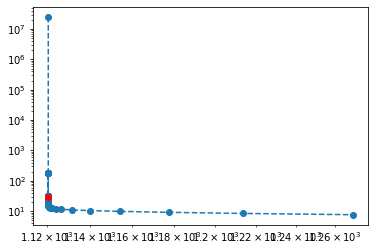

In [34]:
plt.loglog(*fsvals.T, 'o--')
idx = 29
plt.loglog(*fsvals[idx], 'ro')

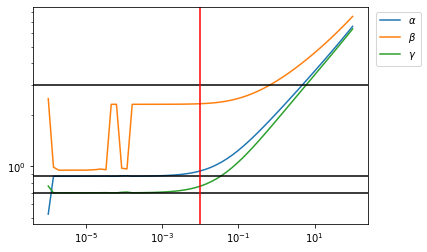

In [15]:
plt.loglog(pranges, [float(s['x'][-3]) for s in sols], label=r'$\alpha$')
plt.loglog(pranges, [float(s['x'][-2]) for s in sols], label=r'$\beta$')
plt.loglog(pranges, [float(s['x'][-1]) for s in sols], label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

idx = 29
plt.axvline(pranges[idx], color='r')

In [28]:
getp = ca.Function('getx', [solver_setup['x']], model.ps)
getp(sols[idx]['x'])

(DM(0.940693), DM(2.32211), DM(0.766913))

1120.78 28.9251


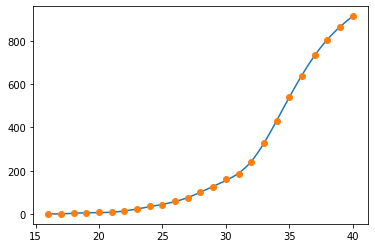

In [27]:
idx = 29
print(f1_ex(sols[idx]['x']), f2_ex(sols[idx]['x']))
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1], label='model')
plt.plot(time, data, 'o', label='data')

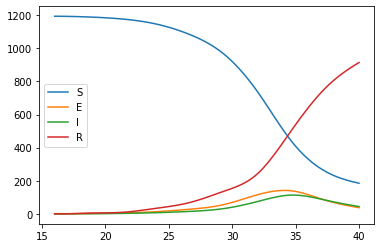

In [25]:
idx=29
plt.plot(model.observation_times, getx(sols[idx]['x'])[0])
plt.plot(model.observation_times, getx(sols[idx]['x'])[1])
plt.plot(model.observation_times, getx(sols[idx]['x'])[2])
plt.plot(model.observation_times, getx(sols[idx]['x'])[3])
plt.legend("SEIR")

In [30]:
N = np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1)
print(np.mean(N), np.std(N))

1190.5973525121083 8.582490083473042


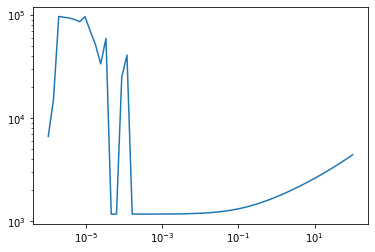

In [31]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(pranges, [getN(i) for i,_ in enumerate(pranges)])

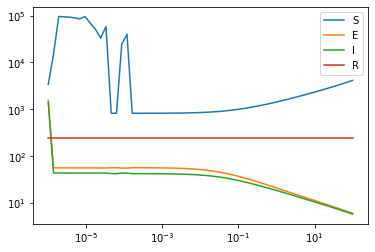

In [32]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(pranges, [getM(i) for i,_ in enumerate(pranges)])
plt.yscale('symlog')
plt.legend("SEIR")

In [33]:
[x[10] for x in getx(sols[idx]['x'])]

[DM(1189.53), DM(1.99049), DM(1.10281), DM(4.44377)]

In [29]:
idx = 29
pfin = np.array([float(p) for p in getp(sols[idx]['x'])])
7/pfin

array([7.44131973, 3.01450489, 9.12750606])